In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.nn as nn
from torch.autograd import Variable
import itertools
import math
import time
import matplotlib.pyplot as plt
from IPython import display
import torchvision.datasets as dsets
import torch

# 問題1 GANの基本を知る

transforms.Compose()はpytorchで画像を指定したデータ形式に変換するためのメソッドです。ToTensor()を使用することで、取り込んだMNIST画像（最初はnumpy配列）をテンソルへと変換します。

transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))で各チャンネルにおける、テンソル（画像）の輝度値を平均0.5、標準偏差0.5になるように標準化します。今だったら3チャンネル分をまとめて指定します。

1



In [40]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
])

train_dataset = dsets.MNIST(root='~/tmp/mnis', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

In [41]:
dsets.MNIST(root='~/tmp/mnis', train=True, download=True, transform=transform)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /Users/morio/tmp/mnis
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [42]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

In [43]:
#Discriminator(判別器)の作成
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(784,1024),
      nn.LeakyReLU(0.2, inplace = True),
      nn.Dropout(0.3),
      nn.Linear(1024,512),
      nn.LeakyReLU(0.2, inplace = True),
      nn.Dropout(0.3),
      nn.Linear(512,256),
      nn.LeakyReLU(0.2, inplace = True),
      nn.Dropout(0.3),
      nn.Linear(256,1),
      nn.Sigmoid()
    )

  def forward(self,x):
    out = self.model(x.view(x.size(0),784))
    out = out.view(out.size(0),-1)
    return out

In [44]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(100,300),
      nn.LeakyReLU(0.2, inplace = True),
      nn.Dropout(0.3),
      nn.Linear(300,512),
      nn.LeakyReLU(0.2, inplace = True),
      nn.Dropout(0.3),
      nn.Linear(512,784),
      nn.Tanh()
    )
        
  def forward(self, x):
    x = x.view(x.size(0),100)
    out = self.model(x)
    return out
        

In [45]:
discriminator = Discriminator()
generator = Generator()

In [46]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [75]:
def train_discriminator(discriminator,images,real_labels,fake_images,fake_labels):
  discriminator.zero_grad()
  outputs = discriminator(images)
  real_loss = criterion(outputs,real_labels)
  real_score = outputs
    
  outputs = discriminator(fake_images)
  fake_loss = criterion(outputs,fake_labels)
  fake_score = outputs
  
  d_loss = real_loss + fake_loss
  d_loss.backward(retain_graph=True)
  d_optimizer.step()
  return d_loss, real_score, fake_score

In [76]:
def train_generator(generator, fake_score, fake_labels):
    generator.zero_grad()
    g_loss = criterion(fake_score, fake_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [77]:
#generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100))

In [78]:
for n,(images,_) in enumerate(train_loader):
  images = Variable(images)
  real_labels = Variable(torch.ones(images.size(0)))
  
  #generatorからのサンプル
  noise = Variable(torch.randn(images.size(0),100))
  fake_images = generator(noise)
  fake_labels = Variable(torch.zeros(fake_images.size(0)))
  outputs = discriminator(fake_images)
  
  # discriminatorの学習
  d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
  
  # 学習後にdiscrminatorから再度サンプリングし，discriminatorからの判定結果を出力する
  noise = Variable(torch.randn(images.size(0),100))
  fake_images = generator(noise)

  outouts = discriminator(fake_images)
    
  # generatorを学習する
  g_loss = train_generator(generator,outputs,real_labels)

/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


KeyboardInterrupt: 

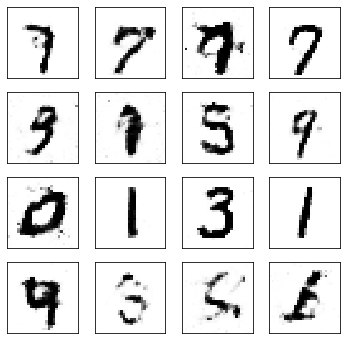

epoch: 101
num_batches: 601


KeyboardInterrupt: 

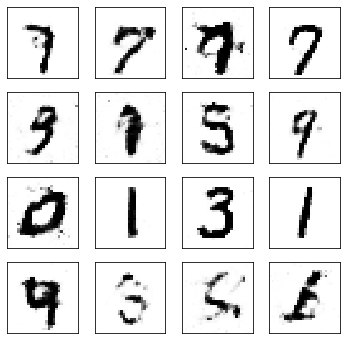

In [84]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100))



# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 200
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images)
        real_labels = Variable(torch.ones(images.size(0)))
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)))
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            plt.savefig('results/mnist-gan-%03d.png'%num_fig)
            num_fig += 1
            print("epoch: "+ str(epoch+1))
            print("num_batches: "+ str(num_batches+1))
            #print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
             #     'D(x): %.2f, D(G(z)): %.2f' 
             #     %(epoch + 1, num_epochs, n+1, num_batches, d_loss.item(), g_loss.item(),
              #      real_score.data.mean(), fake_score.data.mean()))

fig.close()

# 問題2 論文調査
Conditional Generative Adversarial Nets

生成する画像を明示的に書き分けるために、訓練時に教師データのカテゴリ（ラベル）情報を用いてやろう、というのがconditional GANです。
#### アブストラクト
- 新規性：このモデルがクラスラベルで条件付けられたMNIST数字を生成できる
- マルチモーダルモデルを学習する方法を説明 画像タグ付けへの応用の予備的な例を示します

#### イントロダクション
- 無条件生成モデルでは、生成されるデータのモードを制御することはできません。ただし、モデルを追加情報に基づいて調整することで、データ生成プロセスを指示することができます。
- 実験として　クラスラベルを条件としたMNIST数字データセット、マルチモーダル学習用のMIR Flickr 25,000データセットを使用します

#### CONDITIONAL ADVERSARIAL NETS
- GAN 生成的な敵対的ネットは、生成的モデルを訓練するための新しい方法として最近導入されました。それらは2つの「敵対的な」モデル、すなわちデータ分布を捉える生成モデルGと、サンプルがGではなく訓練データから得られる確率を推定する識別モデルDから成ります
- Conditional Adversarial Nets 生成者と弁別子の両方が何らかの追加情報yに基づいて調整されている場合、生成的な敵対的ネットを条件付きモデルに拡張することができます。 yは、クラスラベルや他のモダリティからのデータなど、あらゆる種類の補助情報です。
追加の入力層として、弁別器と生成器の両方にyを入力することで、調整を実行できます。
今回のConditional GANのポイントはyの条件付きで関数が定義されていることである。

#### 実験結果
ワンホットベクトルとして符号化された、それらのクラスラベルで条件付けされたMNIST画像についてconditional GANを訓練した。カーネル密度推定の尤度でその他手法と比較を行った。いくつかの手法よりは良い精度が出たが、non-conditionalの場合の精度は超えていない。(ちゃんとパラメータを調整したら超えるはずらしい)



## 問題3 論文実装

In [5]:
'''
通常のGANのコード
'''

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)#チャンネルの軸を追加している
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]#ランダムにX_trainから抜き出す

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)#１バッチだけ学習
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()



gan = GAN()
gan.train(epochs=30000, batch_size=32,sample_interval=200)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.928770, acc.: 14.06%] [G loss: 0.569748]
1 [D loss: 0.536116, acc.: 59.38%] [G loss: 0.589215]
2 [D loss: 0.401426, acc.: 68.75%] [G loss: 0.753875]
3 [D loss: 0.345342, acc.: 76.56%] [G loss: 0.835007]
4 [D loss: 0.298118, acc.: 81.25%] [G loss: 1.006969]
5 [D loss: 0.260267, acc.: 93.75%] [G loss: 1.134001]
6 [D loss: 0.227267, acc.: 96.88%] [G loss: 1.283211]
7 [D loss: 0.186800, acc.: 100.00%] [G loss: 1.405055]
8 [D loss: 0.158195, acc.: 98.44%] [G loss: 1.388535]
9 [D loss: 0.154739, acc.: 100.00%] [G loss: 1.519752]
10 [D loss: 0.136398, acc.: 100.00%] [G loss: 1.673555]
11 [D loss: 0.144396, acc.: 100.00%] [G loss: 1.660095]
12 [D loss: 0.108841, acc.: 100.00%] [G loss: 1.707433]
13 [D loss: 0.105600, acc.: 100.00%] [G loss: 1.924037]
14 [D loss: 0.092269, acc.: 100.00%] [G loss: 1.959607]
15 [D loss: 0.095659, acc.: 100.00%] [G loss: 1.989477]
16 [D loss: 0.094774, acc.: 100.00%] [G loss: 2.199288]
17 [D loss: 0.074491, acc.: 100.00%] [G loss: 2.102454]
18 [D loss

148 [D loss: 0.047145, acc.: 98.44%] [G loss: 3.917478]
149 [D loss: 0.043774, acc.: 100.00%] [G loss: 3.726346]
150 [D loss: 0.046302, acc.: 100.00%] [G loss: 3.702811]
151 [D loss: 0.104810, acc.: 96.88%] [G loss: 3.697108]
152 [D loss: 0.082469, acc.: 98.44%] [G loss: 3.714186]
153 [D loss: 0.093321, acc.: 100.00%] [G loss: 3.221930]
154 [D loss: 0.262518, acc.: 87.50%] [G loss: 3.138543]
155 [D loss: 0.119723, acc.: 98.44%] [G loss: 3.024508]
156 [D loss: 0.235849, acc.: 90.62%] [G loss: 3.208105]
157 [D loss: 0.204985, acc.: 93.75%] [G loss: 3.431573]
158 [D loss: 0.344808, acc.: 84.38%] [G loss: 2.498400]
159 [D loss: 0.096368, acc.: 96.88%] [G loss: 2.883780]
160 [D loss: 0.141836, acc.: 93.75%] [G loss: 3.417489]
161 [D loss: 0.308319, acc.: 92.19%] [G loss: 2.148104]
162 [D loss: 0.338720, acc.: 89.06%] [G loss: 3.571530]
163 [D loss: 0.709574, acc.: 65.62%] [G loss: 2.450418]
164 [D loss: 0.153247, acc.: 92.19%] [G loss: 3.168441]
165 [D loss: 0.146137, acc.: 95.31%] [G loss:

296 [D loss: 0.842703, acc.: 31.25%] [G loss: 0.831919]
297 [D loss: 0.786857, acc.: 40.62%] [G loss: 0.730458]
298 [D loss: 0.779067, acc.: 42.19%] [G loss: 0.724875]
299 [D loss: 0.802080, acc.: 37.50%] [G loss: 0.662843]
300 [D loss: 0.752916, acc.: 45.31%] [G loss: 0.697322]
301 [D loss: 0.718235, acc.: 48.44%] [G loss: 0.738794]
302 [D loss: 0.774030, acc.: 40.62%] [G loss: 0.715868]
303 [D loss: 0.738381, acc.: 43.75%] [G loss: 0.723616]
304 [D loss: 0.747468, acc.: 45.31%] [G loss: 0.690723]
305 [D loss: 0.738361, acc.: 40.62%] [G loss: 0.736640]
306 [D loss: 0.788426, acc.: 31.25%] [G loss: 0.702463]
307 [D loss: 0.717925, acc.: 48.44%] [G loss: 0.729393]
308 [D loss: 0.672450, acc.: 51.56%] [G loss: 0.760089]
309 [D loss: 0.747224, acc.: 43.75%] [G loss: 0.742602]
310 [D loss: 0.762027, acc.: 32.81%] [G loss: 0.688420]
311 [D loss: 0.738760, acc.: 40.62%] [G loss: 0.677368]
312 [D loss: 0.750820, acc.: 43.75%] [G loss: 0.700903]
313 [D loss: 0.721599, acc.: 45.31%] [G loss: 0.

443 [D loss: 0.648613, acc.: 53.12%] [G loss: 0.735432]
444 [D loss: 0.655009, acc.: 51.56%] [G loss: 0.705813]
445 [D loss: 0.638832, acc.: 50.00%] [G loss: 0.726045]
446 [D loss: 0.643391, acc.: 53.12%] [G loss: 0.713105]
447 [D loss: 0.640611, acc.: 56.25%] [G loss: 0.713597]
448 [D loss: 0.668966, acc.: 50.00%] [G loss: 0.699674]
449 [D loss: 0.656917, acc.: 43.75%] [G loss: 0.695296]
450 [D loss: 0.640960, acc.: 48.44%] [G loss: 0.699708]
451 [D loss: 0.630988, acc.: 56.25%] [G loss: 0.727308]
452 [D loss: 0.618344, acc.: 64.06%] [G loss: 0.741144]
453 [D loss: 0.643579, acc.: 57.81%] [G loss: 0.762265]
454 [D loss: 0.630523, acc.: 62.50%] [G loss: 0.749011]
455 [D loss: 0.649766, acc.: 48.44%] [G loss: 0.728223]
456 [D loss: 0.616822, acc.: 60.94%] [G loss: 0.734337]
457 [D loss: 0.646889, acc.: 50.00%] [G loss: 0.718061]
458 [D loss: 0.639692, acc.: 54.69%] [G loss: 0.701417]
459 [D loss: 0.635761, acc.: 54.69%] [G loss: 0.701732]
460 [D loss: 0.630625, acc.: 50.00%] [G loss: 0.

590 [D loss: 0.674914, acc.: 53.12%] [G loss: 0.770732]
591 [D loss: 0.643975, acc.: 57.81%] [G loss: 0.784124]
592 [D loss: 0.638665, acc.: 60.94%] [G loss: 0.851474]
593 [D loss: 0.649900, acc.: 65.62%] [G loss: 0.787247]
594 [D loss: 0.646737, acc.: 57.81%] [G loss: 0.758720]
595 [D loss: 0.693334, acc.: 51.56%] [G loss: 0.748024]
596 [D loss: 0.649998, acc.: 60.94%] [G loss: 0.761077]
597 [D loss: 0.657095, acc.: 59.38%] [G loss: 0.743810]
598 [D loss: 0.627856, acc.: 65.62%] [G loss: 0.740282]
599 [D loss: 0.648131, acc.: 62.50%] [G loss: 0.747767]
600 [D loss: 0.662304, acc.: 53.12%] [G loss: 0.760025]
601 [D loss: 0.646601, acc.: 59.38%] [G loss: 0.781707]
602 [D loss: 0.673334, acc.: 56.25%] [G loss: 0.765355]
603 [D loss: 0.635885, acc.: 56.25%] [G loss: 0.741583]
604 [D loss: 0.625753, acc.: 67.19%] [G loss: 0.761554]
605 [D loss: 0.620384, acc.: 62.50%] [G loss: 0.777347]
606 [D loss: 0.644503, acc.: 57.81%] [G loss: 0.763365]
607 [D loss: 0.633125, acc.: 71.88%] [G loss: 0.

737 [D loss: 0.639287, acc.: 62.50%] [G loss: 0.853831]
738 [D loss: 0.622541, acc.: 65.62%] [G loss: 0.853236]
739 [D loss: 0.629890, acc.: 59.38%] [G loss: 0.815366]
740 [D loss: 0.625025, acc.: 64.06%] [G loss: 0.805628]
741 [D loss: 0.623762, acc.: 67.19%] [G loss: 0.825519]
742 [D loss: 0.616553, acc.: 68.75%] [G loss: 0.802551]
743 [D loss: 0.649346, acc.: 59.38%] [G loss: 0.779006]
744 [D loss: 0.606039, acc.: 64.06%] [G loss: 0.782145]
745 [D loss: 0.613924, acc.: 57.81%] [G loss: 0.840039]
746 [D loss: 0.673098, acc.: 46.88%] [G loss: 0.824838]
747 [D loss: 0.647994, acc.: 64.06%] [G loss: 0.786462]
748 [D loss: 0.649901, acc.: 59.38%] [G loss: 0.809215]
749 [D loss: 0.641833, acc.: 64.06%] [G loss: 0.836482]
750 [D loss: 0.668845, acc.: 50.00%] [G loss: 0.820012]
751 [D loss: 0.642540, acc.: 59.38%] [G loss: 0.833491]
752 [D loss: 0.652611, acc.: 56.25%] [G loss: 0.831660]
753 [D loss: 0.632774, acc.: 60.94%] [G loss: 0.832405]
754 [D loss: 0.627227, acc.: 65.62%] [G loss: 0.

884 [D loss: 0.657065, acc.: 56.25%] [G loss: 0.782396]
885 [D loss: 0.627232, acc.: 57.81%] [G loss: 0.775368]
886 [D loss: 0.642222, acc.: 59.38%] [G loss: 0.789007]
887 [D loss: 0.611372, acc.: 64.06%] [G loss: 0.845670]
888 [D loss: 0.666118, acc.: 59.38%] [G loss: 0.828424]
889 [D loss: 0.672508, acc.: 53.12%] [G loss: 0.802064]
890 [D loss: 0.644951, acc.: 62.50%] [G loss: 0.791319]
891 [D loss: 0.632496, acc.: 60.94%] [G loss: 0.793596]
892 [D loss: 0.630212, acc.: 64.06%] [G loss: 0.787283]
893 [D loss: 0.644799, acc.: 56.25%] [G loss: 0.817039]
894 [D loss: 0.605632, acc.: 67.19%] [G loss: 0.838814]
895 [D loss: 0.631357, acc.: 68.75%] [G loss: 0.790548]
896 [D loss: 0.668256, acc.: 57.81%] [G loss: 0.787126]
897 [D loss: 0.621011, acc.: 73.44%] [G loss: 0.821962]
898 [D loss: 0.608501, acc.: 70.31%] [G loss: 0.825707]
899 [D loss: 0.678969, acc.: 51.56%] [G loss: 0.797524]
900 [D loss: 0.637276, acc.: 67.19%] [G loss: 0.830553]
901 [D loss: 0.687597, acc.: 53.12%] [G loss: 0.

1030 [D loss: 0.625957, acc.: 68.75%] [G loss: 0.849572]
1031 [D loss: 0.672209, acc.: 59.38%] [G loss: 0.775084]
1032 [D loss: 0.620275, acc.: 71.88%] [G loss: 0.758717]
1033 [D loss: 0.650896, acc.: 70.31%] [G loss: 0.813284]
1034 [D loss: 0.671807, acc.: 56.25%] [G loss: 0.781795]
1035 [D loss: 0.610342, acc.: 71.88%] [G loss: 0.825170]
1036 [D loss: 0.666199, acc.: 62.50%] [G loss: 0.832744]
1037 [D loss: 0.690321, acc.: 51.56%] [G loss: 0.905643]
1038 [D loss: 0.660921, acc.: 53.12%] [G loss: 0.910000]
1039 [D loss: 0.631474, acc.: 64.06%] [G loss: 0.852569]
1040 [D loss: 0.600425, acc.: 75.00%] [G loss: 0.817470]
1041 [D loss: 0.598639, acc.: 67.19%] [G loss: 0.835880]
1042 [D loss: 0.602920, acc.: 67.19%] [G loss: 0.792629]
1043 [D loss: 0.646682, acc.: 59.38%] [G loss: 0.764858]
1044 [D loss: 0.619492, acc.: 60.94%] [G loss: 0.822890]
1045 [D loss: 0.580808, acc.: 76.56%] [G loss: 0.844821]
1046 [D loss: 0.614390, acc.: 65.62%] [G loss: 0.828966]
1047 [D loss: 0.631376, acc.: 6

1174 [D loss: 0.625614, acc.: 67.19%] [G loss: 0.860172]
1175 [D loss: 0.563322, acc.: 79.69%] [G loss: 0.884756]
1176 [D loss: 0.617395, acc.: 70.31%] [G loss: 0.883281]
1177 [D loss: 0.622839, acc.: 71.88%] [G loss: 0.830666]
1178 [D loss: 0.602510, acc.: 78.12%] [G loss: 0.875017]
1179 [D loss: 0.635656, acc.: 56.25%] [G loss: 0.831593]
1180 [D loss: 0.546028, acc.: 76.56%] [G loss: 0.847483]
1181 [D loss: 0.647722, acc.: 57.81%] [G loss: 0.853108]
1182 [D loss: 0.575981, acc.: 76.56%] [G loss: 0.882472]
1183 [D loss: 0.628252, acc.: 68.75%] [G loss: 0.939052]
1184 [D loss: 0.602119, acc.: 64.06%] [G loss: 0.891834]
1185 [D loss: 0.616219, acc.: 65.62%] [G loss: 0.870632]
1186 [D loss: 0.551415, acc.: 76.56%] [G loss: 0.902833]
1187 [D loss: 0.584617, acc.: 76.56%] [G loss: 0.946360]
1188 [D loss: 0.598375, acc.: 68.75%] [G loss: 0.922746]
1189 [D loss: 0.612784, acc.: 68.75%] [G loss: 0.917208]
1190 [D loss: 0.590933, acc.: 65.62%] [G loss: 0.973431]
1191 [D loss: 0.598856, acc.: 5

1319 [D loss: 0.605611, acc.: 67.19%] [G loss: 0.892714]
1320 [D loss: 0.555380, acc.: 75.00%] [G loss: 0.948549]
1321 [D loss: 0.591707, acc.: 70.31%] [G loss: 1.015191]
1322 [D loss: 0.583333, acc.: 75.00%] [G loss: 0.978600]
1323 [D loss: 0.541987, acc.: 82.81%] [G loss: 1.008967]
1324 [D loss: 0.588507, acc.: 76.56%] [G loss: 0.951905]
1325 [D loss: 0.610718, acc.: 73.44%] [G loss: 0.937966]
1326 [D loss: 0.545051, acc.: 79.69%] [G loss: 0.972969]
1327 [D loss: 0.523482, acc.: 75.00%] [G loss: 1.014572]
1328 [D loss: 0.575708, acc.: 73.44%] [G loss: 0.939343]
1329 [D loss: 0.682900, acc.: 57.81%] [G loss: 0.861497]
1330 [D loss: 0.567664, acc.: 78.12%] [G loss: 0.880171]
1331 [D loss: 0.577719, acc.: 82.81%] [G loss: 0.887199]
1332 [D loss: 0.604251, acc.: 71.88%] [G loss: 0.965610]
1333 [D loss: 0.564809, acc.: 73.44%] [G loss: 0.970342]
1334 [D loss: 0.562369, acc.: 79.69%] [G loss: 0.975785]
1335 [D loss: 0.561033, acc.: 79.69%] [G loss: 0.952643]
1336 [D loss: 0.535649, acc.: 8

1463 [D loss: 0.555610, acc.: 79.69%] [G loss: 0.930292]
1464 [D loss: 0.568224, acc.: 68.75%] [G loss: 0.961180]
1465 [D loss: 0.576628, acc.: 70.31%] [G loss: 0.971160]
1466 [D loss: 0.603123, acc.: 67.19%] [G loss: 0.902990]
1467 [D loss: 0.620153, acc.: 62.50%] [G loss: 0.956227]
1468 [D loss: 0.575700, acc.: 71.88%] [G loss: 1.023049]
1469 [D loss: 0.558438, acc.: 79.69%] [G loss: 0.999741]
1470 [D loss: 0.606063, acc.: 70.31%] [G loss: 0.985488]
1471 [D loss: 0.564542, acc.: 81.25%] [G loss: 0.983600]
1472 [D loss: 0.552334, acc.: 78.12%] [G loss: 0.920985]
1473 [D loss: 0.553328, acc.: 78.12%] [G loss: 0.936644]
1474 [D loss: 0.558268, acc.: 71.88%] [G loss: 0.944378]
1475 [D loss: 0.531958, acc.: 79.69%] [G loss: 0.940632]
1476 [D loss: 0.607063, acc.: 65.62%] [G loss: 0.905061]
1477 [D loss: 0.564343, acc.: 73.44%] [G loss: 0.976046]
1478 [D loss: 0.573475, acc.: 78.12%] [G loss: 0.988892]
1479 [D loss: 0.563721, acc.: 73.44%] [G loss: 0.964226]
1480 [D loss: 0.582411, acc.: 7

1607 [D loss: 0.549823, acc.: 79.69%] [G loss: 1.008440]
1608 [D loss: 0.565195, acc.: 81.25%] [G loss: 0.958046]
1609 [D loss: 0.547794, acc.: 78.12%] [G loss: 0.942113]
1610 [D loss: 0.588244, acc.: 75.00%] [G loss: 0.952441]
1611 [D loss: 0.569115, acc.: 67.19%] [G loss: 0.921421]
1612 [D loss: 0.587081, acc.: 71.88%] [G loss: 0.947736]
1613 [D loss: 0.620113, acc.: 64.06%] [G loss: 1.001116]
1614 [D loss: 0.615051, acc.: 67.19%] [G loss: 0.957679]
1615 [D loss: 0.552875, acc.: 79.69%] [G loss: 0.904534]
1616 [D loss: 0.548765, acc.: 76.56%] [G loss: 0.929888]
1617 [D loss: 0.634915, acc.: 65.62%] [G loss: 0.959185]
1618 [D loss: 0.567156, acc.: 70.31%] [G loss: 1.080584]
1619 [D loss: 0.608929, acc.: 65.62%] [G loss: 1.013814]
1620 [D loss: 0.594476, acc.: 75.00%] [G loss: 0.959989]
1621 [D loss: 0.576073, acc.: 73.44%] [G loss: 0.958805]
1622 [D loss: 0.519629, acc.: 76.56%] [G loss: 0.921624]
1623 [D loss: 0.570985, acc.: 71.88%] [G loss: 0.934312]
1624 [D loss: 0.556571, acc.: 7

1751 [D loss: 0.657012, acc.: 60.94%] [G loss: 0.846967]
1752 [D loss: 0.592570, acc.: 73.44%] [G loss: 0.947838]
1753 [D loss: 0.563252, acc.: 78.12%] [G loss: 1.003077]
1754 [D loss: 0.626680, acc.: 68.75%] [G loss: 0.965837]
1755 [D loss: 0.623429, acc.: 67.19%] [G loss: 0.876549]
1756 [D loss: 0.547349, acc.: 75.00%] [G loss: 0.928423]
1757 [D loss: 0.532136, acc.: 75.00%] [G loss: 1.015922]
1758 [D loss: 0.596219, acc.: 71.88%] [G loss: 1.012659]
1759 [D loss: 0.518312, acc.: 81.25%] [G loss: 0.944923]
1760 [D loss: 0.554473, acc.: 65.62%] [G loss: 0.958338]
1761 [D loss: 0.535548, acc.: 70.31%] [G loss: 0.924623]
1762 [D loss: 0.573214, acc.: 70.31%] [G loss: 0.946473]
1763 [D loss: 0.634904, acc.: 70.31%] [G loss: 0.998160]
1764 [D loss: 0.519678, acc.: 81.25%] [G loss: 1.056697]
1765 [D loss: 0.546410, acc.: 73.44%] [G loss: 1.145299]
1766 [D loss: 0.648713, acc.: 62.50%] [G loss: 0.990982]
1767 [D loss: 0.594741, acc.: 73.44%] [G loss: 0.938314]
1768 [D loss: 0.585892, acc.: 6

1895 [D loss: 0.633070, acc.: 60.94%] [G loss: 0.993300]
1896 [D loss: 0.579547, acc.: 70.31%] [G loss: 0.959126]
1897 [D loss: 0.570079, acc.: 70.31%] [G loss: 1.046938]
1898 [D loss: 0.625655, acc.: 59.38%] [G loss: 0.917888]
1899 [D loss: 0.547303, acc.: 73.44%] [G loss: 0.971645]
1900 [D loss: 0.614316, acc.: 60.94%] [G loss: 0.924495]
1901 [D loss: 0.586142, acc.: 73.44%] [G loss: 0.877207]
1902 [D loss: 0.552725, acc.: 73.44%] [G loss: 0.884933]
1903 [D loss: 0.628798, acc.: 59.38%] [G loss: 0.890162]
1904 [D loss: 0.538471, acc.: 81.25%] [G loss: 0.953349]
1905 [D loss: 0.581097, acc.: 67.19%] [G loss: 0.901081]
1906 [D loss: 0.626088, acc.: 64.06%] [G loss: 0.949017]
1907 [D loss: 0.668569, acc.: 53.12%] [G loss: 0.927295]
1908 [D loss: 0.566728, acc.: 75.00%] [G loss: 0.896839]
1909 [D loss: 0.663714, acc.: 59.38%] [G loss: 0.862044]
1910 [D loss: 0.551326, acc.: 75.00%] [G loss: 0.977728]
1911 [D loss: 0.593988, acc.: 56.25%] [G loss: 0.994040]
1912 [D loss: 0.591338, acc.: 6

2039 [D loss: 0.631726, acc.: 64.06%] [G loss: 0.916134]
2040 [D loss: 0.663298, acc.: 57.81%] [G loss: 0.938322]
2041 [D loss: 0.593139, acc.: 70.31%] [G loss: 0.933086]
2042 [D loss: 0.649477, acc.: 62.50%] [G loss: 0.972834]
2043 [D loss: 0.558507, acc.: 75.00%] [G loss: 1.027521]
2044 [D loss: 0.597563, acc.: 65.62%] [G loss: 0.988548]
2045 [D loss: 0.492432, acc.: 84.38%] [G loss: 1.004171]
2046 [D loss: 0.560588, acc.: 71.88%] [G loss: 0.915885]
2047 [D loss: 0.585332, acc.: 68.75%] [G loss: 0.932218]
2048 [D loss: 0.631514, acc.: 62.50%] [G loss: 0.892365]
2049 [D loss: 0.636686, acc.: 57.81%] [G loss: 0.876467]
2050 [D loss: 0.623164, acc.: 65.62%] [G loss: 0.881969]
2051 [D loss: 0.555313, acc.: 78.12%] [G loss: 0.891492]
2052 [D loss: 0.613796, acc.: 62.50%] [G loss: 0.881289]
2053 [D loss: 0.565955, acc.: 75.00%] [G loss: 0.930445]
2054 [D loss: 0.572929, acc.: 76.56%] [G loss: 0.914486]
2055 [D loss: 0.564442, acc.: 78.12%] [G loss: 1.012771]
2056 [D loss: 0.659822, acc.: 6

2183 [D loss: 0.577837, acc.: 71.88%] [G loss: 0.963025]
2184 [D loss: 0.540574, acc.: 76.56%] [G loss: 0.951249]
2185 [D loss: 0.546494, acc.: 78.12%] [G loss: 0.850811]
2186 [D loss: 0.580193, acc.: 65.62%] [G loss: 0.992871]
2187 [D loss: 0.529329, acc.: 82.81%] [G loss: 0.988983]
2188 [D loss: 0.559809, acc.: 76.56%] [G loss: 1.042589]
2189 [D loss: 0.639106, acc.: 57.81%] [G loss: 1.029284]
2190 [D loss: 0.604881, acc.: 67.19%] [G loss: 0.972114]
2191 [D loss: 0.560765, acc.: 75.00%] [G loss: 0.947640]
2192 [D loss: 0.619214, acc.: 65.62%] [G loss: 0.968098]
2193 [D loss: 0.569042, acc.: 70.31%] [G loss: 0.881604]
2194 [D loss: 0.571149, acc.: 70.31%] [G loss: 0.930976]
2195 [D loss: 0.618832, acc.: 51.56%] [G loss: 1.009952]
2196 [D loss: 0.620904, acc.: 68.75%] [G loss: 0.942654]
2197 [D loss: 0.591382, acc.: 70.31%] [G loss: 0.963839]
2198 [D loss: 0.621270, acc.: 73.44%] [G loss: 0.990744]
2199 [D loss: 0.524803, acc.: 79.69%] [G loss: 0.994754]
2200 [D loss: 0.542533, acc.: 8

2327 [D loss: 0.542988, acc.: 75.00%] [G loss: 0.912434]
2328 [D loss: 0.530431, acc.: 78.12%] [G loss: 0.888275]
2329 [D loss: 0.628774, acc.: 64.06%] [G loss: 0.880301]
2330 [D loss: 0.521438, acc.: 73.44%] [G loss: 0.925626]
2331 [D loss: 0.575758, acc.: 68.75%] [G loss: 0.982916]
2332 [D loss: 0.624184, acc.: 64.06%] [G loss: 1.001637]
2333 [D loss: 0.594744, acc.: 68.75%] [G loss: 1.000822]
2334 [D loss: 0.626850, acc.: 57.81%] [G loss: 0.937263]
2335 [D loss: 0.603083, acc.: 65.62%] [G loss: 1.012300]
2336 [D loss: 0.517957, acc.: 79.69%] [G loss: 0.962030]
2337 [D loss: 0.590260, acc.: 68.75%] [G loss: 1.006705]
2338 [D loss: 0.492014, acc.: 81.25%] [G loss: 1.082855]
2339 [D loss: 0.604210, acc.: 62.50%] [G loss: 0.953945]
2340 [D loss: 0.660622, acc.: 59.38%] [G loss: 1.025431]
2341 [D loss: 0.691334, acc.: 57.81%] [G loss: 0.959715]
2342 [D loss: 0.607458, acc.: 70.31%] [G loss: 0.928555]
2343 [D loss: 0.625051, acc.: 64.06%] [G loss: 0.944021]
2344 [D loss: 0.607299, acc.: 7

2472 [D loss: 0.589890, acc.: 68.75%] [G loss: 0.903173]
2473 [D loss: 0.565167, acc.: 70.31%] [G loss: 0.913056]
2474 [D loss: 0.544241, acc.: 75.00%] [G loss: 0.977319]
2475 [D loss: 0.573092, acc.: 76.56%] [G loss: 1.000852]
2476 [D loss: 0.595692, acc.: 73.44%] [G loss: 0.955227]
2477 [D loss: 0.633792, acc.: 70.31%] [G loss: 0.929668]
2478 [D loss: 0.548475, acc.: 82.81%] [G loss: 0.893403]
2479 [D loss: 0.593872, acc.: 71.88%] [G loss: 0.966322]
2480 [D loss: 0.585617, acc.: 73.44%] [G loss: 0.864002]
2481 [D loss: 0.569125, acc.: 73.44%] [G loss: 0.953464]
2482 [D loss: 0.591813, acc.: 67.19%] [G loss: 0.910962]
2483 [D loss: 0.649117, acc.: 67.19%] [G loss: 0.931532]
2484 [D loss: 0.641931, acc.: 67.19%] [G loss: 0.925517]
2485 [D loss: 0.603557, acc.: 68.75%] [G loss: 0.872415]
2486 [D loss: 0.572194, acc.: 73.44%] [G loss: 0.863100]
2487 [D loss: 0.594215, acc.: 71.88%] [G loss: 0.993015]
2488 [D loss: 0.612296, acc.: 71.88%] [G loss: 0.973804]
2489 [D loss: 0.639886, acc.: 6

2617 [D loss: 0.535461, acc.: 73.44%] [G loss: 1.011463]
2618 [D loss: 0.559099, acc.: 73.44%] [G loss: 1.002699]
2619 [D loss: 0.601465, acc.: 68.75%] [G loss: 0.960755]
2620 [D loss: 0.567125, acc.: 71.88%] [G loss: 0.910797]
2621 [D loss: 0.628944, acc.: 60.94%] [G loss: 0.938259]
2622 [D loss: 0.645366, acc.: 64.06%] [G loss: 0.875756]
2623 [D loss: 0.555052, acc.: 70.31%] [G loss: 0.896831]
2624 [D loss: 0.613698, acc.: 60.94%] [G loss: 0.882426]
2625 [D loss: 0.618178, acc.: 64.06%] [G loss: 0.985579]
2626 [D loss: 0.592654, acc.: 73.44%] [G loss: 1.059625]
2627 [D loss: 0.531794, acc.: 76.56%] [G loss: 1.040049]
2628 [D loss: 0.592517, acc.: 71.88%] [G loss: 0.910429]
2629 [D loss: 0.643486, acc.: 59.38%] [G loss: 0.977565]
2630 [D loss: 0.543593, acc.: 75.00%] [G loss: 1.025668]
2631 [D loss: 0.660145, acc.: 60.94%] [G loss: 0.972972]
2632 [D loss: 0.575171, acc.: 78.12%] [G loss: 0.970078]
2633 [D loss: 0.549479, acc.: 73.44%] [G loss: 1.033523]
2634 [D loss: 0.563010, acc.: 6

2762 [D loss: 0.604765, acc.: 67.19%] [G loss: 0.960536]
2763 [D loss: 0.549716, acc.: 73.44%] [G loss: 0.857732]
2764 [D loss: 0.598955, acc.: 68.75%] [G loss: 0.922321]
2765 [D loss: 0.540321, acc.: 76.56%] [G loss: 0.907377]
2766 [D loss: 0.616187, acc.: 70.31%] [G loss: 0.971779]
2767 [D loss: 0.616575, acc.: 62.50%] [G loss: 0.900684]
2768 [D loss: 0.528163, acc.: 79.69%] [G loss: 0.997413]
2769 [D loss: 0.591366, acc.: 68.75%] [G loss: 0.997415]
2770 [D loss: 0.588729, acc.: 67.19%] [G loss: 0.920238]
2771 [D loss: 0.694121, acc.: 59.38%] [G loss: 0.931232]
2772 [D loss: 0.635327, acc.: 67.19%] [G loss: 0.960282]
2773 [D loss: 0.688633, acc.: 56.25%] [G loss: 0.936008]
2774 [D loss: 0.669332, acc.: 59.38%] [G loss: 1.041030]
2775 [D loss: 0.654275, acc.: 62.50%] [G loss: 0.948783]
2776 [D loss: 0.619453, acc.: 70.31%] [G loss: 0.876180]
2777 [D loss: 0.619955, acc.: 68.75%] [G loss: 0.909426]
2778 [D loss: 0.561752, acc.: 78.12%] [G loss: 0.870487]
2779 [D loss: 0.644749, acc.: 6

2907 [D loss: 0.663472, acc.: 62.50%] [G loss: 0.933415]
2908 [D loss: 0.513936, acc.: 84.38%] [G loss: 0.885375]
2909 [D loss: 0.543659, acc.: 78.12%] [G loss: 0.977220]
2910 [D loss: 0.594030, acc.: 73.44%] [G loss: 0.988586]
2911 [D loss: 0.728874, acc.: 57.81%] [G loss: 1.013741]
2912 [D loss: 0.528922, acc.: 81.25%] [G loss: 1.023561]
2913 [D loss: 0.593980, acc.: 68.75%] [G loss: 0.916317]
2914 [D loss: 0.618628, acc.: 64.06%] [G loss: 0.960968]
2915 [D loss: 0.659543, acc.: 71.88%] [G loss: 0.894177]
2916 [D loss: 0.583245, acc.: 70.31%] [G loss: 1.099064]
2917 [D loss: 0.677720, acc.: 51.56%] [G loss: 0.928425]
2918 [D loss: 0.618437, acc.: 64.06%] [G loss: 0.986127]
2919 [D loss: 0.630234, acc.: 68.75%] [G loss: 0.934697]
2920 [D loss: 0.592229, acc.: 65.62%] [G loss: 0.973960]
2921 [D loss: 0.610889, acc.: 67.19%] [G loss: 0.931928]
2922 [D loss: 0.559346, acc.: 71.88%] [G loss: 1.018389]
2923 [D loss: 0.620556, acc.: 65.62%] [G loss: 1.018914]
2924 [D loss: 0.583961, acc.: 6

3051 [D loss: 0.590314, acc.: 67.19%] [G loss: 0.995396]
3052 [D loss: 0.598796, acc.: 68.75%] [G loss: 1.003652]
3053 [D loss: 0.595269, acc.: 70.31%] [G loss: 0.944453]
3054 [D loss: 0.596472, acc.: 70.31%] [G loss: 0.851462]
3055 [D loss: 0.574922, acc.: 75.00%] [G loss: 0.928571]
3056 [D loss: 0.545999, acc.: 76.56%] [G loss: 0.934749]
3057 [D loss: 0.599486, acc.: 65.62%] [G loss: 0.979680]
3058 [D loss: 0.634302, acc.: 65.62%] [G loss: 0.982429]
3059 [D loss: 0.652039, acc.: 59.38%] [G loss: 0.923837]
3060 [D loss: 0.675929, acc.: 62.50%] [G loss: 0.869236]
3061 [D loss: 0.619268, acc.: 67.19%] [G loss: 0.911499]
3062 [D loss: 0.560818, acc.: 73.44%] [G loss: 0.930661]
3063 [D loss: 0.638980, acc.: 64.06%] [G loss: 0.824982]
3064 [D loss: 0.617172, acc.: 65.62%] [G loss: 0.932453]
3065 [D loss: 0.590219, acc.: 75.00%] [G loss: 0.941432]
3066 [D loss: 0.580357, acc.: 67.19%] [G loss: 0.971333]
3067 [D loss: 0.648479, acc.: 62.50%] [G loss: 0.912202]
3068 [D loss: 0.615952, acc.: 6

3195 [D loss: 0.596608, acc.: 67.19%] [G loss: 0.943386]
3196 [D loss: 0.603145, acc.: 64.06%] [G loss: 0.976588]
3197 [D loss: 0.626860, acc.: 62.50%] [G loss: 0.939129]
3198 [D loss: 0.577178, acc.: 73.44%] [G loss: 0.947045]
3199 [D loss: 0.577483, acc.: 67.19%] [G loss: 1.006391]
3200 [D loss: 0.636974, acc.: 67.19%] [G loss: 0.960625]
3201 [D loss: 0.629151, acc.: 65.62%] [G loss: 0.957077]
3202 [D loss: 0.591039, acc.: 68.75%] [G loss: 0.983601]
3203 [D loss: 0.570550, acc.: 78.12%] [G loss: 0.951320]
3204 [D loss: 0.630769, acc.: 64.06%] [G loss: 1.000713]
3205 [D loss: 0.543861, acc.: 79.69%] [G loss: 0.917881]
3206 [D loss: 0.607719, acc.: 65.62%] [G loss: 0.880916]
3207 [D loss: 0.647238, acc.: 59.38%] [G loss: 0.936729]
3208 [D loss: 0.605255, acc.: 70.31%] [G loss: 1.016363]
3209 [D loss: 0.611707, acc.: 68.75%] [G loss: 0.960555]
3210 [D loss: 0.541273, acc.: 81.25%] [G loss: 1.028010]
3211 [D loss: 0.598122, acc.: 68.75%] [G loss: 1.053222]
3212 [D loss: 0.592931, acc.: 7

3339 [D loss: 0.652461, acc.: 64.06%] [G loss: 1.032527]
3340 [D loss: 0.568721, acc.: 68.75%] [G loss: 0.937984]
3341 [D loss: 0.680340, acc.: 57.81%] [G loss: 0.973443]
3342 [D loss: 0.635574, acc.: 67.19%] [G loss: 0.899810]
3343 [D loss: 0.559298, acc.: 70.31%] [G loss: 0.876144]
3344 [D loss: 0.655550, acc.: 57.81%] [G loss: 0.919326]
3345 [D loss: 0.638047, acc.: 56.25%] [G loss: 0.922427]
3346 [D loss: 0.638975, acc.: 59.38%] [G loss: 0.959618]
3347 [D loss: 0.627454, acc.: 67.19%] [G loss: 0.992467]
3348 [D loss: 0.567477, acc.: 75.00%] [G loss: 0.961793]
3349 [D loss: 0.611091, acc.: 65.62%] [G loss: 0.999500]
3350 [D loss: 0.630292, acc.: 68.75%] [G loss: 0.986670]
3351 [D loss: 0.569321, acc.: 78.12%] [G loss: 0.937726]
3352 [D loss: 0.629841, acc.: 59.38%] [G loss: 0.980874]
3353 [D loss: 0.606126, acc.: 67.19%] [G loss: 0.950591]
3354 [D loss: 0.555080, acc.: 78.12%] [G loss: 0.953674]
3355 [D loss: 0.590394, acc.: 73.44%] [G loss: 1.032544]
3356 [D loss: 0.656905, acc.: 5

3483 [D loss: 0.581839, acc.: 73.44%] [G loss: 0.939805]
3484 [D loss: 0.602070, acc.: 65.62%] [G loss: 0.987762]
3485 [D loss: 0.610828, acc.: 64.06%] [G loss: 0.880975]
3486 [D loss: 0.591319, acc.: 71.88%] [G loss: 0.910438]
3487 [D loss: 0.626686, acc.: 65.62%] [G loss: 0.907888]
3488 [D loss: 0.597257, acc.: 65.62%] [G loss: 0.938797]
3489 [D loss: 0.611525, acc.: 65.62%] [G loss: 1.087242]
3490 [D loss: 0.575458, acc.: 65.62%] [G loss: 0.896215]
3491 [D loss: 0.630073, acc.: 65.62%] [G loss: 0.862027]
3492 [D loss: 0.596478, acc.: 62.50%] [G loss: 0.888835]
3493 [D loss: 0.627370, acc.: 62.50%] [G loss: 0.899622]
3494 [D loss: 0.570770, acc.: 70.31%] [G loss: 0.996115]
3495 [D loss: 0.559690, acc.: 73.44%] [G loss: 0.972283]
3496 [D loss: 0.613123, acc.: 65.62%] [G loss: 1.024483]
3497 [D loss: 0.570821, acc.: 73.44%] [G loss: 0.948655]
3498 [D loss: 0.513703, acc.: 81.25%] [G loss: 0.940897]
3499 [D loss: 0.546458, acc.: 75.00%] [G loss: 0.891397]
3500 [D loss: 0.631754, acc.: 6

3627 [D loss: 0.571572, acc.: 75.00%] [G loss: 0.911522]
3628 [D loss: 0.655148, acc.: 57.81%] [G loss: 0.955665]
3629 [D loss: 0.575485, acc.: 75.00%] [G loss: 0.956928]
3630 [D loss: 0.556485, acc.: 71.88%] [G loss: 0.938202]
3631 [D loss: 0.551151, acc.: 75.00%] [G loss: 1.014172]
3632 [D loss: 0.594306, acc.: 68.75%] [G loss: 0.871790]
3633 [D loss: 0.654278, acc.: 64.06%] [G loss: 0.937449]
3634 [D loss: 0.696144, acc.: 57.81%] [G loss: 0.952990]
3635 [D loss: 0.605869, acc.: 62.50%] [G loss: 0.921925]
3636 [D loss: 0.586257, acc.: 71.88%] [G loss: 0.869194]
3637 [D loss: 0.666240, acc.: 59.38%] [G loss: 0.974760]
3638 [D loss: 0.595829, acc.: 67.19%] [G loss: 0.982660]
3639 [D loss: 0.633338, acc.: 64.06%] [G loss: 0.910753]
3640 [D loss: 0.602959, acc.: 67.19%] [G loss: 0.921658]
3641 [D loss: 0.586148, acc.: 76.56%] [G loss: 0.978584]
3642 [D loss: 0.674722, acc.: 57.81%] [G loss: 1.099157]
3643 [D loss: 0.615831, acc.: 67.19%] [G loss: 0.968787]
3644 [D loss: 0.621635, acc.: 6

3772 [D loss: 0.631671, acc.: 65.62%] [G loss: 0.909684]
3773 [D loss: 0.597462, acc.: 68.75%] [G loss: 1.055480]
3774 [D loss: 0.607024, acc.: 71.88%] [G loss: 0.913767]
3775 [D loss: 0.567765, acc.: 71.88%] [G loss: 0.888252]
3776 [D loss: 0.593488, acc.: 73.44%] [G loss: 0.966701]
3777 [D loss: 0.573443, acc.: 70.31%] [G loss: 0.960389]
3778 [D loss: 0.581643, acc.: 71.88%] [G loss: 0.936038]
3779 [D loss: 0.605721, acc.: 65.62%] [G loss: 0.976270]
3780 [D loss: 0.655225, acc.: 65.62%] [G loss: 0.949524]
3781 [D loss: 0.608536, acc.: 64.06%] [G loss: 0.832176]
3782 [D loss: 0.716165, acc.: 54.69%] [G loss: 0.884227]
3783 [D loss: 0.653174, acc.: 62.50%] [G loss: 0.964116]
3784 [D loss: 0.585008, acc.: 65.62%] [G loss: 0.914479]
3785 [D loss: 0.557561, acc.: 76.56%] [G loss: 1.016640]
3786 [D loss: 0.606877, acc.: 71.88%] [G loss: 0.889725]
3787 [D loss: 0.664357, acc.: 64.06%] [G loss: 0.947875]
3788 [D loss: 0.631190, acc.: 65.62%] [G loss: 0.955793]
3789 [D loss: 0.588083, acc.: 7

3917 [D loss: 0.536822, acc.: 78.12%] [G loss: 0.955618]
3918 [D loss: 0.641352, acc.: 64.06%] [G loss: 0.942865]
3919 [D loss: 0.626547, acc.: 67.19%] [G loss: 0.958233]
3920 [D loss: 0.587611, acc.: 70.31%] [G loss: 0.978592]
3921 [D loss: 0.572465, acc.: 76.56%] [G loss: 0.972510]
3922 [D loss: 0.614037, acc.: 71.88%] [G loss: 0.953046]
3923 [D loss: 0.585678, acc.: 62.50%] [G loss: 1.012089]
3924 [D loss: 0.606103, acc.: 64.06%] [G loss: 0.980170]
3925 [D loss: 0.647160, acc.: 64.06%] [G loss: 0.888580]
3926 [D loss: 0.602887, acc.: 68.75%] [G loss: 1.008448]
3927 [D loss: 0.642023, acc.: 60.94%] [G loss: 0.944047]
3928 [D loss: 0.635034, acc.: 65.62%] [G loss: 0.932649]
3929 [D loss: 0.597477, acc.: 75.00%] [G loss: 0.973252]
3930 [D loss: 0.548911, acc.: 73.44%] [G loss: 0.982606]
3931 [D loss: 0.621858, acc.: 64.06%] [G loss: 0.936457]
3932 [D loss: 0.589338, acc.: 68.75%] [G loss: 0.957974]
3933 [D loss: 0.575664, acc.: 75.00%] [G loss: 0.919295]
3934 [D loss: 0.592580, acc.: 7

4061 [D loss: 0.596188, acc.: 67.19%] [G loss: 0.948112]
4062 [D loss: 0.595202, acc.: 78.12%] [G loss: 0.973882]
4063 [D loss: 0.602319, acc.: 71.88%] [G loss: 1.083469]
4064 [D loss: 0.608139, acc.: 68.75%] [G loss: 0.971566]
4065 [D loss: 0.660280, acc.: 57.81%] [G loss: 1.052603]
4066 [D loss: 0.646723, acc.: 62.50%] [G loss: 1.006690]
4067 [D loss: 0.588844, acc.: 71.88%] [G loss: 0.935521]
4068 [D loss: 0.602034, acc.: 67.19%] [G loss: 1.020409]
4069 [D loss: 0.558407, acc.: 76.56%] [G loss: 1.009607]
4070 [D loss: 0.653815, acc.: 67.19%] [G loss: 0.949288]
4071 [D loss: 0.613008, acc.: 71.88%] [G loss: 1.028641]
4072 [D loss: 0.559126, acc.: 71.88%] [G loss: 0.992574]
4073 [D loss: 0.696147, acc.: 57.81%] [G loss: 1.027076]
4074 [D loss: 0.676661, acc.: 57.81%] [G loss: 0.889459]
4075 [D loss: 0.645496, acc.: 54.69%] [G loss: 0.940875]
4076 [D loss: 0.567857, acc.: 71.88%] [G loss: 1.066385]
4077 [D loss: 0.557856, acc.: 71.88%] [G loss: 1.034909]
4078 [D loss: 0.712834, acc.: 5

4205 [D loss: 0.609079, acc.: 70.31%] [G loss: 0.909636]
4206 [D loss: 0.650137, acc.: 67.19%] [G loss: 0.874605]
4207 [D loss: 0.699728, acc.: 53.12%] [G loss: 0.986765]
4208 [D loss: 0.630731, acc.: 64.06%] [G loss: 0.909335]
4209 [D loss: 0.680309, acc.: 60.94%] [G loss: 0.956032]
4210 [D loss: 0.592997, acc.: 71.88%] [G loss: 0.991453]
4211 [D loss: 0.616485, acc.: 71.88%] [G loss: 0.878193]
4212 [D loss: 0.591294, acc.: 65.62%] [G loss: 0.964008]
4213 [D loss: 0.544434, acc.: 81.25%] [G loss: 0.957247]
4214 [D loss: 0.628743, acc.: 67.19%] [G loss: 1.052599]
4215 [D loss: 0.623682, acc.: 65.62%] [G loss: 0.946720]
4216 [D loss: 0.675982, acc.: 59.38%] [G loss: 0.941937]
4217 [D loss: 0.603328, acc.: 64.06%] [G loss: 0.939850]
4218 [D loss: 0.644824, acc.: 64.06%] [G loss: 1.025272]
4219 [D loss: 0.648129, acc.: 65.62%] [G loss: 0.941106]
4220 [D loss: 0.623526, acc.: 65.62%] [G loss: 0.959643]
4221 [D loss: 0.675705, acc.: 64.06%] [G loss: 0.961050]
4222 [D loss: 0.574409, acc.: 7

4350 [D loss: 0.622873, acc.: 64.06%] [G loss: 0.960721]
4351 [D loss: 0.534834, acc.: 73.44%] [G loss: 1.051115]
4352 [D loss: 0.665761, acc.: 57.81%] [G loss: 0.934546]
4353 [D loss: 0.582788, acc.: 76.56%] [G loss: 1.056893]
4354 [D loss: 0.581979, acc.: 70.31%] [G loss: 1.000065]
4355 [D loss: 0.701269, acc.: 50.00%] [G loss: 0.953515]
4356 [D loss: 0.586090, acc.: 68.75%] [G loss: 1.013582]
4357 [D loss: 0.663374, acc.: 60.94%] [G loss: 0.920946]
4358 [D loss: 0.674906, acc.: 62.50%] [G loss: 0.969634]
4359 [D loss: 0.671674, acc.: 57.81%] [G loss: 0.941727]
4360 [D loss: 0.592264, acc.: 65.62%] [G loss: 1.053304]
4361 [D loss: 0.657825, acc.: 64.06%] [G loss: 0.923520]
4362 [D loss: 0.640501, acc.: 60.94%] [G loss: 1.033304]
4363 [D loss: 0.661785, acc.: 54.69%] [G loss: 0.936924]
4364 [D loss: 0.551756, acc.: 75.00%] [G loss: 0.929950]
4365 [D loss: 0.673517, acc.: 57.81%] [G loss: 0.904617]
4366 [D loss: 0.555822, acc.: 84.38%] [G loss: 1.001245]
4367 [D loss: 0.571365, acc.: 7

4495 [D loss: 0.570322, acc.: 73.44%] [G loss: 0.970827]
4496 [D loss: 0.657402, acc.: 53.12%] [G loss: 1.010774]
4497 [D loss: 0.608371, acc.: 70.31%] [G loss: 0.980434]
4498 [D loss: 0.676556, acc.: 53.12%] [G loss: 0.957203]
4499 [D loss: 0.713619, acc.: 59.38%] [G loss: 1.058801]
4500 [D loss: 0.605687, acc.: 67.19%] [G loss: 0.860795]
4501 [D loss: 0.645520, acc.: 59.38%] [G loss: 0.933446]
4502 [D loss: 0.576984, acc.: 73.44%] [G loss: 0.973464]
4503 [D loss: 0.577534, acc.: 68.75%] [G loss: 0.880739]
4504 [D loss: 0.595142, acc.: 70.31%] [G loss: 0.921297]
4505 [D loss: 0.582368, acc.: 64.06%] [G loss: 0.920285]
4506 [D loss: 0.640338, acc.: 51.56%] [G loss: 0.865965]
4507 [D loss: 0.589077, acc.: 65.62%] [G loss: 0.957656]
4508 [D loss: 0.656631, acc.: 54.69%] [G loss: 0.873801]
4509 [D loss: 0.580639, acc.: 79.69%] [G loss: 1.028060]
4510 [D loss: 0.580889, acc.: 70.31%] [G loss: 1.018807]
4511 [D loss: 0.602364, acc.: 59.38%] [G loss: 1.024239]
4512 [D loss: 0.628655, acc.: 6

4640 [D loss: 0.558872, acc.: 70.31%] [G loss: 1.008897]
4641 [D loss: 0.631342, acc.: 60.94%] [G loss: 0.894808]
4642 [D loss: 0.584256, acc.: 64.06%] [G loss: 0.942281]
4643 [D loss: 0.629767, acc.: 64.06%] [G loss: 0.995863]
4644 [D loss: 0.541595, acc.: 70.31%] [G loss: 1.021369]
4645 [D loss: 0.662804, acc.: 68.75%] [G loss: 0.909612]
4646 [D loss: 0.636852, acc.: 70.31%] [G loss: 0.922427]
4647 [D loss: 0.652525, acc.: 57.81%] [G loss: 0.943849]
4648 [D loss: 0.654816, acc.: 60.94%] [G loss: 1.030509]
4649 [D loss: 0.554994, acc.: 71.88%] [G loss: 0.972305]
4650 [D loss: 0.641219, acc.: 54.69%] [G loss: 0.934015]
4651 [D loss: 0.667229, acc.: 64.06%] [G loss: 0.886126]
4652 [D loss: 0.623096, acc.: 62.50%] [G loss: 0.927670]
4653 [D loss: 0.641190, acc.: 64.06%] [G loss: 0.949207]
4654 [D loss: 0.650680, acc.: 68.75%] [G loss: 0.967211]
4655 [D loss: 0.542220, acc.: 79.69%] [G loss: 0.982321]
4656 [D loss: 0.549105, acc.: 78.12%] [G loss: 0.982175]
4657 [D loss: 0.586950, acc.: 7

4784 [D loss: 0.550298, acc.: 78.12%] [G loss: 0.980861]
4785 [D loss: 0.541320, acc.: 75.00%] [G loss: 0.844817]
4786 [D loss: 0.641324, acc.: 60.94%] [G loss: 0.957180]
4787 [D loss: 0.579390, acc.: 70.31%] [G loss: 0.907250]
4788 [D loss: 0.633279, acc.: 65.62%] [G loss: 0.950398]
4789 [D loss: 0.613274, acc.: 67.19%] [G loss: 0.940125]
4790 [D loss: 0.655329, acc.: 60.94%] [G loss: 0.959738]
4791 [D loss: 0.536835, acc.: 78.12%] [G loss: 0.934722]
4792 [D loss: 0.631369, acc.: 67.19%] [G loss: 0.936370]
4793 [D loss: 0.619080, acc.: 67.19%] [G loss: 1.016013]
4794 [D loss: 0.638443, acc.: 62.50%] [G loss: 1.026157]
4795 [D loss: 0.645976, acc.: 59.38%] [G loss: 0.992904]
4796 [D loss: 0.602791, acc.: 68.75%] [G loss: 0.962967]
4797 [D loss: 0.568534, acc.: 76.56%] [G loss: 0.884796]
4798 [D loss: 0.611976, acc.: 64.06%] [G loss: 0.893896]
4799 [D loss: 0.567180, acc.: 76.56%] [G loss: 0.870058]
4800 [D loss: 0.648146, acc.: 71.88%] [G loss: 0.983502]
4801 [D loss: 0.688064, acc.: 5

4929 [D loss: 0.607319, acc.: 68.75%] [G loss: 0.978395]
4930 [D loss: 0.596814, acc.: 70.31%] [G loss: 0.833557]
4931 [D loss: 0.665277, acc.: 57.81%] [G loss: 1.070984]
4932 [D loss: 0.671365, acc.: 56.25%] [G loss: 0.952797]
4933 [D loss: 0.581904, acc.: 73.44%] [G loss: 1.004463]
4934 [D loss: 0.666778, acc.: 60.94%] [G loss: 1.094960]
4935 [D loss: 0.577254, acc.: 73.44%] [G loss: 0.989443]
4936 [D loss: 0.669119, acc.: 51.56%] [G loss: 1.020271]
4937 [D loss: 0.628507, acc.: 64.06%] [G loss: 0.974749]
4938 [D loss: 0.573519, acc.: 68.75%] [G loss: 1.053133]
4939 [D loss: 0.588868, acc.: 70.31%] [G loss: 0.962062]
4940 [D loss: 0.593970, acc.: 64.06%] [G loss: 0.968308]
4941 [D loss: 0.690530, acc.: 57.81%] [G loss: 0.927890]
4942 [D loss: 0.609968, acc.: 70.31%] [G loss: 0.972965]
4943 [D loss: 0.588443, acc.: 71.88%] [G loss: 1.032103]
4944 [D loss: 0.575098, acc.: 73.44%] [G loss: 0.990078]
4945 [D loss: 0.640600, acc.: 67.19%] [G loss: 0.954336]
4946 [D loss: 0.553771, acc.: 7

5073 [D loss: 0.616252, acc.: 68.75%] [G loss: 0.866403]
5074 [D loss: 0.668141, acc.: 59.38%] [G loss: 0.936904]
5075 [D loss: 0.540251, acc.: 76.56%] [G loss: 0.960558]
5076 [D loss: 0.613052, acc.: 62.50%] [G loss: 0.976330]
5077 [D loss: 0.597435, acc.: 76.56%] [G loss: 0.991633]
5078 [D loss: 0.683783, acc.: 60.94%] [G loss: 0.843729]
5079 [D loss: 0.631265, acc.: 60.94%] [G loss: 1.082057]
5080 [D loss: 0.562459, acc.: 78.12%] [G loss: 0.928915]
5081 [D loss: 0.721244, acc.: 50.00%] [G loss: 0.916053]
5082 [D loss: 0.590839, acc.: 71.88%] [G loss: 0.964467]
5083 [D loss: 0.629023, acc.: 64.06%] [G loss: 0.964030]
5084 [D loss: 0.657861, acc.: 65.62%] [G loss: 0.891917]
5085 [D loss: 0.680300, acc.: 54.69%] [G loss: 0.923395]
5086 [D loss: 0.627160, acc.: 65.62%] [G loss: 0.982327]
5087 [D loss: 0.571648, acc.: 70.31%] [G loss: 0.992592]
5088 [D loss: 0.604562, acc.: 67.19%] [G loss: 1.047873]
5089 [D loss: 0.688795, acc.: 57.81%] [G loss: 1.043024]
5090 [D loss: 0.603750, acc.: 7

5217 [D loss: 0.595047, acc.: 67.19%] [G loss: 0.895708]
5218 [D loss: 0.667245, acc.: 65.62%] [G loss: 0.975348]
5219 [D loss: 0.532182, acc.: 75.00%] [G loss: 1.018533]
5220 [D loss: 0.577279, acc.: 73.44%] [G loss: 0.939323]
5221 [D loss: 0.637506, acc.: 67.19%] [G loss: 1.015388]
5222 [D loss: 0.644745, acc.: 65.62%] [G loss: 0.919828]
5223 [D loss: 0.564235, acc.: 75.00%] [G loss: 1.013208]
5224 [D loss: 0.590117, acc.: 71.88%] [G loss: 1.029443]
5225 [D loss: 0.606189, acc.: 76.56%] [G loss: 0.904665]
5226 [D loss: 0.577972, acc.: 71.88%] [G loss: 0.933059]
5227 [D loss: 0.689605, acc.: 43.75%] [G loss: 0.892308]
5228 [D loss: 0.566685, acc.: 67.19%] [G loss: 1.063909]
5229 [D loss: 0.568461, acc.: 68.75%] [G loss: 1.026553]
5230 [D loss: 0.588717, acc.: 71.88%] [G loss: 0.927882]
5231 [D loss: 0.621295, acc.: 68.75%] [G loss: 0.914504]
5232 [D loss: 0.628876, acc.: 67.19%] [G loss: 0.971131]
5233 [D loss: 0.601063, acc.: 70.31%] [G loss: 0.916474]
5234 [D loss: 0.548819, acc.: 7

5362 [D loss: 0.608780, acc.: 65.62%] [G loss: 0.954199]
5363 [D loss: 0.681498, acc.: 57.81%] [G loss: 0.958473]
5364 [D loss: 0.642671, acc.: 59.38%] [G loss: 0.930350]
5365 [D loss: 0.600839, acc.: 70.31%] [G loss: 0.934849]
5366 [D loss: 0.649191, acc.: 65.62%] [G loss: 1.094056]
5367 [D loss: 0.618987, acc.: 71.88%] [G loss: 0.880108]
5368 [D loss: 0.650591, acc.: 54.69%] [G loss: 0.987367]
5369 [D loss: 0.649631, acc.: 67.19%] [G loss: 1.001267]
5370 [D loss: 0.616176, acc.: 67.19%] [G loss: 1.023506]
5371 [D loss: 0.627039, acc.: 65.62%] [G loss: 0.890675]
5372 [D loss: 0.648717, acc.: 59.38%] [G loss: 0.967610]
5373 [D loss: 0.670574, acc.: 54.69%] [G loss: 0.950852]
5374 [D loss: 0.547678, acc.: 82.81%] [G loss: 1.084148]
5375 [D loss: 0.584310, acc.: 73.44%] [G loss: 1.076510]
5376 [D loss: 0.593284, acc.: 71.88%] [G loss: 1.004354]
5377 [D loss: 0.737097, acc.: 57.81%] [G loss: 0.845830]
5378 [D loss: 0.616766, acc.: 59.38%] [G loss: 1.066034]
5379 [D loss: 0.617075, acc.: 6

5507 [D loss: 0.556636, acc.: 79.69%] [G loss: 0.993342]
5508 [D loss: 0.637596, acc.: 60.94%] [G loss: 1.053491]
5509 [D loss: 0.626872, acc.: 65.62%] [G loss: 0.896487]
5510 [D loss: 0.621427, acc.: 70.31%] [G loss: 0.993700]
5511 [D loss: 0.610247, acc.: 67.19%] [G loss: 0.976912]
5512 [D loss: 0.626053, acc.: 68.75%] [G loss: 0.954451]
5513 [D loss: 0.655433, acc.: 62.50%] [G loss: 0.957175]
5514 [D loss: 0.598920, acc.: 67.19%] [G loss: 0.858686]
5515 [D loss: 0.617508, acc.: 67.19%] [G loss: 0.919552]
5516 [D loss: 0.622929, acc.: 70.31%] [G loss: 1.005179]
5517 [D loss: 0.594831, acc.: 78.12%] [G loss: 0.927541]
5518 [D loss: 0.622702, acc.: 60.94%] [G loss: 0.968250]
5519 [D loss: 0.675947, acc.: 57.81%] [G loss: 1.005416]
5520 [D loss: 0.600986, acc.: 67.19%] [G loss: 0.879933]
5521 [D loss: 0.636817, acc.: 67.19%] [G loss: 0.878081]
5522 [D loss: 0.617788, acc.: 68.75%] [G loss: 1.015616]
5523 [D loss: 0.636366, acc.: 65.62%] [G loss: 1.055103]
5524 [D loss: 0.628424, acc.: 6

5651 [D loss: 0.613123, acc.: 67.19%] [G loss: 0.926004]
5652 [D loss: 0.719982, acc.: 59.38%] [G loss: 0.945723]
5653 [D loss: 0.588610, acc.: 70.31%] [G loss: 1.004210]
5654 [D loss: 0.680015, acc.: 54.69%] [G loss: 0.990617]
5655 [D loss: 0.659329, acc.: 59.38%] [G loss: 1.006362]
5656 [D loss: 0.593423, acc.: 73.44%] [G loss: 0.901397]
5657 [D loss: 0.628486, acc.: 70.31%] [G loss: 0.903687]
5658 [D loss: 0.646771, acc.: 68.75%] [G loss: 0.918517]
5659 [D loss: 0.575519, acc.: 68.75%] [G loss: 0.979341]
5660 [D loss: 0.651944, acc.: 59.38%] [G loss: 1.055891]
5661 [D loss: 0.586024, acc.: 68.75%] [G loss: 0.981851]
5662 [D loss: 0.678736, acc.: 54.69%] [G loss: 0.963914]
5663 [D loss: 0.662103, acc.: 65.62%] [G loss: 0.915055]
5664 [D loss: 0.639269, acc.: 59.38%] [G loss: 0.994262]
5665 [D loss: 0.652809, acc.: 62.50%] [G loss: 0.964068]
5666 [D loss: 0.638330, acc.: 59.38%] [G loss: 0.948123]
5667 [D loss: 0.648846, acc.: 70.31%] [G loss: 0.976808]
5668 [D loss: 0.631413, acc.: 6

5795 [D loss: 0.601401, acc.: 68.75%] [G loss: 0.989631]
5796 [D loss: 0.608245, acc.: 65.62%] [G loss: 0.974498]
5797 [D loss: 0.639341, acc.: 57.81%] [G loss: 0.947801]
5798 [D loss: 0.647566, acc.: 70.31%] [G loss: 0.998741]
5799 [D loss: 0.596025, acc.: 68.75%] [G loss: 0.978889]
5800 [D loss: 0.619210, acc.: 64.06%] [G loss: 0.939849]
5801 [D loss: 0.653552, acc.: 62.50%] [G loss: 0.864600]
5802 [D loss: 0.634643, acc.: 60.94%] [G loss: 0.985825]
5803 [D loss: 0.661199, acc.: 60.94%] [G loss: 0.925009]
5804 [D loss: 0.670398, acc.: 56.25%] [G loss: 1.064921]
5805 [D loss: 0.645187, acc.: 62.50%] [G loss: 0.952201]
5806 [D loss: 0.626348, acc.: 64.06%] [G loss: 0.994666]
5807 [D loss: 0.665444, acc.: 54.69%] [G loss: 0.950347]
5808 [D loss: 0.568420, acc.: 79.69%] [G loss: 0.927776]
5809 [D loss: 0.592476, acc.: 68.75%] [G loss: 0.967206]
5810 [D loss: 0.562350, acc.: 71.88%] [G loss: 0.925497]
5811 [D loss: 0.647302, acc.: 65.62%] [G loss: 0.954358]
5812 [D loss: 0.677776, acc.: 6

5939 [D loss: 0.640863, acc.: 62.50%] [G loss: 0.905120]
5940 [D loss: 0.669068, acc.: 62.50%] [G loss: 0.845765]
5941 [D loss: 0.638048, acc.: 68.75%] [G loss: 1.001883]
5942 [D loss: 0.597711, acc.: 67.19%] [G loss: 0.907145]
5943 [D loss: 0.674104, acc.: 53.12%] [G loss: 0.882337]
5944 [D loss: 0.617166, acc.: 65.62%] [G loss: 0.949006]
5945 [D loss: 0.553846, acc.: 73.44%] [G loss: 1.043620]
5946 [D loss: 0.591152, acc.: 67.19%] [G loss: 1.005822]
5947 [D loss: 0.566501, acc.: 71.88%] [G loss: 0.954843]
5948 [D loss: 0.642859, acc.: 65.62%] [G loss: 0.918091]
5949 [D loss: 0.731829, acc.: 54.69%] [G loss: 0.873648]
5950 [D loss: 0.691532, acc.: 54.69%] [G loss: 0.897180]
5951 [D loss: 0.561204, acc.: 68.75%] [G loss: 1.020671]
5952 [D loss: 0.556997, acc.: 71.88%] [G loss: 1.021349]
5953 [D loss: 0.644643, acc.: 60.94%] [G loss: 0.940807]
5954 [D loss: 0.636941, acc.: 64.06%] [G loss: 0.986272]
5955 [D loss: 0.617527, acc.: 67.19%] [G loss: 0.996773]
5956 [D loss: 0.599914, acc.: 7

6083 [D loss: 0.631671, acc.: 57.81%] [G loss: 1.032001]
6084 [D loss: 0.658317, acc.: 64.06%] [G loss: 0.920136]
6085 [D loss: 0.638600, acc.: 64.06%] [G loss: 0.989963]
6086 [D loss: 0.667735, acc.: 50.00%] [G loss: 0.909905]
6087 [D loss: 0.661629, acc.: 62.50%] [G loss: 0.954525]
6088 [D loss: 0.610669, acc.: 60.94%] [G loss: 0.799583]
6089 [D loss: 0.686346, acc.: 57.81%] [G loss: 0.952851]
6090 [D loss: 0.684373, acc.: 56.25%] [G loss: 0.923427]
6091 [D loss: 0.621370, acc.: 68.75%] [G loss: 0.956321]
6092 [D loss: 0.677649, acc.: 59.38%] [G loss: 0.897704]
6093 [D loss: 0.644102, acc.: 62.50%] [G loss: 1.027566]
6094 [D loss: 0.612098, acc.: 64.06%] [G loss: 0.943431]
6095 [D loss: 0.647202, acc.: 59.38%] [G loss: 1.021710]
6096 [D loss: 0.679443, acc.: 57.81%] [G loss: 1.007783]
6097 [D loss: 0.780836, acc.: 42.19%] [G loss: 0.945232]
6098 [D loss: 0.592917, acc.: 65.62%] [G loss: 0.962289]
6099 [D loss: 0.611144, acc.: 71.88%] [G loss: 0.943199]
6100 [D loss: 0.610954, acc.: 6

6227 [D loss: 0.612672, acc.: 68.75%] [G loss: 1.023968]
6228 [D loss: 0.604584, acc.: 70.31%] [G loss: 1.097931]
6229 [D loss: 0.686146, acc.: 59.38%] [G loss: 0.966653]
6230 [D loss: 0.607680, acc.: 68.75%] [G loss: 0.848678]
6231 [D loss: 0.650622, acc.: 65.62%] [G loss: 0.959380]
6232 [D loss: 0.683942, acc.: 60.94%] [G loss: 0.811530]
6233 [D loss: 0.679126, acc.: 60.94%] [G loss: 0.955885]
6234 [D loss: 0.641617, acc.: 60.94%] [G loss: 0.918417]
6235 [D loss: 0.585721, acc.: 70.31%] [G loss: 0.958678]
6236 [D loss: 0.593829, acc.: 71.88%] [G loss: 1.033384]
6237 [D loss: 0.650166, acc.: 62.50%] [G loss: 0.947009]
6238 [D loss: 0.568888, acc.: 75.00%] [G loss: 0.893902]
6239 [D loss: 0.560051, acc.: 70.31%] [G loss: 0.947788]
6240 [D loss: 0.695504, acc.: 53.12%] [G loss: 0.976260]
6241 [D loss: 0.673968, acc.: 62.50%] [G loss: 0.999680]
6242 [D loss: 0.665940, acc.: 62.50%] [G loss: 0.913316]
6243 [D loss: 0.607175, acc.: 67.19%] [G loss: 0.956008]
6244 [D loss: 0.682978, acc.: 5

6371 [D loss: 0.643419, acc.: 64.06%] [G loss: 1.047026]
6372 [D loss: 0.557533, acc.: 75.00%] [G loss: 0.943166]
6373 [D loss: 0.587888, acc.: 68.75%] [G loss: 0.962642]
6374 [D loss: 0.677161, acc.: 65.62%] [G loss: 0.934430]
6375 [D loss: 0.663551, acc.: 54.69%] [G loss: 0.915983]
6376 [D loss: 0.685779, acc.: 56.25%] [G loss: 0.919691]
6377 [D loss: 0.663809, acc.: 60.94%] [G loss: 1.085021]
6378 [D loss: 0.582173, acc.: 78.12%] [G loss: 0.987781]
6379 [D loss: 0.609154, acc.: 68.75%] [G loss: 0.886678]
6380 [D loss: 0.588318, acc.: 71.88%] [G loss: 0.841204]
6381 [D loss: 0.643625, acc.: 64.06%] [G loss: 0.868544]
6382 [D loss: 0.608631, acc.: 65.62%] [G loss: 0.977952]
6383 [D loss: 0.625120, acc.: 59.38%] [G loss: 0.917050]
6384 [D loss: 0.702274, acc.: 60.94%] [G loss: 0.891758]
6385 [D loss: 0.678130, acc.: 57.81%] [G loss: 0.874856]
6386 [D loss: 0.618657, acc.: 62.50%] [G loss: 0.875501]
6387 [D loss: 0.664530, acc.: 64.06%] [G loss: 0.953971]
6388 [D loss: 0.701317, acc.: 5

6515 [D loss: 0.626295, acc.: 60.94%] [G loss: 0.805374]
6516 [D loss: 0.630637, acc.: 70.31%] [G loss: 0.913959]
6517 [D loss: 0.645416, acc.: 62.50%] [G loss: 0.892262]
6518 [D loss: 0.721347, acc.: 48.44%] [G loss: 0.898344]
6519 [D loss: 0.663384, acc.: 60.94%] [G loss: 0.979705]
6520 [D loss: 0.648145, acc.: 65.62%] [G loss: 0.968463]
6521 [D loss: 0.618566, acc.: 67.19%] [G loss: 0.965512]
6522 [D loss: 0.656414, acc.: 64.06%] [G loss: 0.977373]
6523 [D loss: 0.645027, acc.: 57.81%] [G loss: 0.907740]
6524 [D loss: 0.548039, acc.: 73.44%] [G loss: 0.965113]
6525 [D loss: 0.670206, acc.: 62.50%] [G loss: 0.934474]
6526 [D loss: 0.649441, acc.: 64.06%] [G loss: 0.914892]
6527 [D loss: 0.598852, acc.: 70.31%] [G loss: 0.931956]
6528 [D loss: 0.654036, acc.: 56.25%] [G loss: 0.896818]
6529 [D loss: 0.624200, acc.: 57.81%] [G loss: 0.909438]
6530 [D loss: 0.677870, acc.: 62.50%] [G loss: 0.948300]
6531 [D loss: 0.628085, acc.: 70.31%] [G loss: 0.959591]
6532 [D loss: 0.621524, acc.: 6

6659 [D loss: 0.633334, acc.: 67.19%] [G loss: 0.983230]
6660 [D loss: 0.621517, acc.: 65.62%] [G loss: 0.873297]
6661 [D loss: 0.632985, acc.: 67.19%] [G loss: 0.926369]
6662 [D loss: 0.644759, acc.: 54.69%] [G loss: 0.923433]
6663 [D loss: 0.655158, acc.: 62.50%] [G loss: 0.928011]
6664 [D loss: 0.637103, acc.: 70.31%] [G loss: 0.883346]
6665 [D loss: 0.645725, acc.: 59.38%] [G loss: 0.879531]
6666 [D loss: 0.620589, acc.: 60.94%] [G loss: 0.923718]
6667 [D loss: 0.629621, acc.: 59.38%] [G loss: 0.873488]
6668 [D loss: 0.685686, acc.: 56.25%] [G loss: 0.999252]
6669 [D loss: 0.618616, acc.: 67.19%] [G loss: 0.931804]
6670 [D loss: 0.635017, acc.: 64.06%] [G loss: 0.894901]
6671 [D loss: 0.676742, acc.: 57.81%] [G loss: 1.005098]
6672 [D loss: 0.667549, acc.: 62.50%] [G loss: 0.911647]
6673 [D loss: 0.651021, acc.: 60.94%] [G loss: 1.008742]
6674 [D loss: 0.680044, acc.: 56.25%] [G loss: 1.134870]
6675 [D loss: 0.663472, acc.: 62.50%] [G loss: 0.947608]
6676 [D loss: 0.615214, acc.: 6

6803 [D loss: 0.602021, acc.: 65.62%] [G loss: 0.935916]
6804 [D loss: 0.673400, acc.: 59.38%] [G loss: 1.076335]
6805 [D loss: 0.631027, acc.: 59.38%] [G loss: 1.002736]
6806 [D loss: 0.672190, acc.: 59.38%] [G loss: 0.937714]
6807 [D loss: 0.669478, acc.: 65.62%] [G loss: 1.001911]
6808 [D loss: 0.664354, acc.: 64.06%] [G loss: 0.848828]
6809 [D loss: 0.683428, acc.: 59.38%] [G loss: 0.874706]
6810 [D loss: 0.599067, acc.: 65.62%] [G loss: 0.917615]
6811 [D loss: 0.698518, acc.: 50.00%] [G loss: 0.997873]
6812 [D loss: 0.602640, acc.: 70.31%] [G loss: 0.972047]
6813 [D loss: 0.613826, acc.: 67.19%] [G loss: 0.995884]
6814 [D loss: 0.644004, acc.: 67.19%] [G loss: 0.908101]
6815 [D loss: 0.616875, acc.: 68.75%] [G loss: 0.961324]
6816 [D loss: 0.691306, acc.: 53.12%] [G loss: 0.954218]
6817 [D loss: 0.595578, acc.: 75.00%] [G loss: 1.026297]
6818 [D loss: 0.674147, acc.: 59.38%] [G loss: 0.965719]
6819 [D loss: 0.642704, acc.: 67.19%] [G loss: 1.051008]
6820 [D loss: 0.687197, acc.: 5

6947 [D loss: 0.699291, acc.: 57.81%] [G loss: 0.960248]
6948 [D loss: 0.641852, acc.: 68.75%] [G loss: 0.995012]
6949 [D loss: 0.663052, acc.: 64.06%] [G loss: 0.965545]
6950 [D loss: 0.662621, acc.: 62.50%] [G loss: 0.950702]
6951 [D loss: 0.650448, acc.: 59.38%] [G loss: 0.891450]
6952 [D loss: 0.641119, acc.: 60.94%] [G loss: 0.934461]
6953 [D loss: 0.652904, acc.: 60.94%] [G loss: 0.865251]
6954 [D loss: 0.590905, acc.: 67.19%] [G loss: 0.895805]
6955 [D loss: 0.623065, acc.: 65.62%] [G loss: 0.920073]
6956 [D loss: 0.683131, acc.: 65.62%] [G loss: 0.934248]
6957 [D loss: 0.650355, acc.: 60.94%] [G loss: 0.901873]
6958 [D loss: 0.593598, acc.: 73.44%] [G loss: 1.000410]
6959 [D loss: 0.690930, acc.: 59.38%] [G loss: 1.023908]
6960 [D loss: 0.610444, acc.: 64.06%] [G loss: 1.044575]
6961 [D loss: 0.637681, acc.: 65.62%] [G loss: 0.934094]
6962 [D loss: 0.620369, acc.: 62.50%] [G loss: 0.933594]
6963 [D loss: 0.644912, acc.: 62.50%] [G loss: 0.970416]
6964 [D loss: 0.618894, acc.: 5

7091 [D loss: 0.644078, acc.: 62.50%] [G loss: 0.927415]
7092 [D loss: 0.647966, acc.: 60.94%] [G loss: 0.908419]
7093 [D loss: 0.660406, acc.: 57.81%] [G loss: 0.857863]
7094 [D loss: 0.656002, acc.: 59.38%] [G loss: 0.949226]
7095 [D loss: 0.688344, acc.: 65.62%] [G loss: 0.926517]
7096 [D loss: 0.623201, acc.: 70.31%] [G loss: 0.854336]
7097 [D loss: 0.552181, acc.: 73.44%] [G loss: 0.907629]
7098 [D loss: 0.604523, acc.: 70.31%] [G loss: 0.963812]
7099 [D loss: 0.615967, acc.: 65.62%] [G loss: 0.885643]
7100 [D loss: 0.652472, acc.: 60.94%] [G loss: 0.918072]
7101 [D loss: 0.609962, acc.: 67.19%] [G loss: 0.918885]
7102 [D loss: 0.680390, acc.: 64.06%] [G loss: 0.981773]
7103 [D loss: 0.689696, acc.: 57.81%] [G loss: 0.953025]
7104 [D loss: 0.644060, acc.: 60.94%] [G loss: 0.909987]
7105 [D loss: 0.671296, acc.: 57.81%] [G loss: 0.935261]
7106 [D loss: 0.630294, acc.: 68.75%] [G loss: 0.937504]
7107 [D loss: 0.647913, acc.: 64.06%] [G loss: 0.935837]
7108 [D loss: 0.651802, acc.: 5

7235 [D loss: 0.686833, acc.: 54.69%] [G loss: 0.889969]
7236 [D loss: 0.598897, acc.: 70.31%] [G loss: 0.858468]
7237 [D loss: 0.645952, acc.: 67.19%] [G loss: 0.973062]
7238 [D loss: 0.647625, acc.: 57.81%] [G loss: 0.934716]
7239 [D loss: 0.626772, acc.: 67.19%] [G loss: 0.939175]
7240 [D loss: 0.711567, acc.: 56.25%] [G loss: 0.869038]
7241 [D loss: 0.599093, acc.: 71.88%] [G loss: 0.978188]
7242 [D loss: 0.581347, acc.: 71.88%] [G loss: 0.949313]
7243 [D loss: 0.675207, acc.: 54.69%] [G loss: 0.903664]
7244 [D loss: 0.680459, acc.: 56.25%] [G loss: 0.903842]
7245 [D loss: 0.652907, acc.: 59.38%] [G loss: 1.020311]
7246 [D loss: 0.646036, acc.: 67.19%] [G loss: 0.964231]
7247 [D loss: 0.659557, acc.: 59.38%] [G loss: 1.034061]
7248 [D loss: 0.578463, acc.: 73.44%] [G loss: 0.948353]
7249 [D loss: 0.666191, acc.: 59.38%] [G loss: 0.882800]
7250 [D loss: 0.577232, acc.: 68.75%] [G loss: 0.975777]
7251 [D loss: 0.649989, acc.: 60.94%] [G loss: 0.895393]
7252 [D loss: 0.669579, acc.: 6

7379 [D loss: 0.638281, acc.: 67.19%] [G loss: 1.025163]
7380 [D loss: 0.636318, acc.: 60.94%] [G loss: 0.922331]
7381 [D loss: 0.579953, acc.: 71.88%] [G loss: 0.944696]
7382 [D loss: 0.660386, acc.: 60.94%] [G loss: 1.038772]
7383 [D loss: 0.609337, acc.: 67.19%] [G loss: 0.974644]
7384 [D loss: 0.594207, acc.: 68.75%] [G loss: 1.029664]
7385 [D loss: 0.657016, acc.: 59.38%] [G loss: 0.947655]
7386 [D loss: 0.691635, acc.: 59.38%] [G loss: 1.020670]
7387 [D loss: 0.659465, acc.: 60.94%] [G loss: 1.077708]
7388 [D loss: 0.652260, acc.: 54.69%] [G loss: 0.946015]
7389 [D loss: 0.672196, acc.: 60.94%] [G loss: 0.968550]
7390 [D loss: 0.616554, acc.: 67.19%] [G loss: 0.931255]
7391 [D loss: 0.653677, acc.: 56.25%] [G loss: 0.892039]
7392 [D loss: 0.645245, acc.: 59.38%] [G loss: 0.971546]
7393 [D loss: 0.639580, acc.: 71.88%] [G loss: 1.009139]
7394 [D loss: 0.587178, acc.: 76.56%] [G loss: 0.968421]
7395 [D loss: 0.655881, acc.: 64.06%] [G loss: 0.965080]
7396 [D loss: 0.644359, acc.: 6

7524 [D loss: 0.646982, acc.: 62.50%] [G loss: 0.882588]
7525 [D loss: 0.692107, acc.: 54.69%] [G loss: 0.977949]
7526 [D loss: 0.632241, acc.: 68.75%] [G loss: 1.020520]
7527 [D loss: 0.599363, acc.: 70.31%] [G loss: 0.907005]
7528 [D loss: 0.679066, acc.: 62.50%] [G loss: 0.997998]
7529 [D loss: 0.718716, acc.: 50.00%] [G loss: 0.924448]
7530 [D loss: 0.657202, acc.: 60.94%] [G loss: 1.015956]
7531 [D loss: 0.656663, acc.: 65.62%] [G loss: 0.992306]
7532 [D loss: 0.625936, acc.: 64.06%] [G loss: 0.882460]
7533 [D loss: 0.610455, acc.: 67.19%] [G loss: 0.928982]
7534 [D loss: 0.635573, acc.: 54.69%] [G loss: 0.937128]
7535 [D loss: 0.566326, acc.: 76.56%] [G loss: 0.990685]
7536 [D loss: 0.650273, acc.: 59.38%] [G loss: 0.990444]
7537 [D loss: 0.597386, acc.: 71.88%] [G loss: 0.975425]
7538 [D loss: 0.735412, acc.: 51.56%] [G loss: 0.907877]
7539 [D loss: 0.671502, acc.: 62.50%] [G loss: 0.925729]
7540 [D loss: 0.624357, acc.: 57.81%] [G loss: 0.948109]
7541 [D loss: 0.675203, acc.: 5

7669 [D loss: 0.563973, acc.: 75.00%] [G loss: 0.884611]
7670 [D loss: 0.631419, acc.: 75.00%] [G loss: 0.982674]
7671 [D loss: 0.636650, acc.: 62.50%] [G loss: 1.004871]
7672 [D loss: 0.641638, acc.: 67.19%] [G loss: 0.924187]
7673 [D loss: 0.629783, acc.: 68.75%] [G loss: 1.015913]
7674 [D loss: 0.565227, acc.: 76.56%] [G loss: 1.028736]
7675 [D loss: 0.623219, acc.: 65.62%] [G loss: 1.037313]
7676 [D loss: 0.596498, acc.: 64.06%] [G loss: 1.047917]
7677 [D loss: 0.632344, acc.: 65.62%] [G loss: 0.917228]
7678 [D loss: 0.648158, acc.: 64.06%] [G loss: 0.943914]
7679 [D loss: 0.664892, acc.: 59.38%] [G loss: 0.924498]
7680 [D loss: 0.600147, acc.: 67.19%] [G loss: 0.997950]
7681 [D loss: 0.647959, acc.: 59.38%] [G loss: 1.059484]
7682 [D loss: 0.662621, acc.: 57.81%] [G loss: 0.943350]
7683 [D loss: 0.662782, acc.: 56.25%] [G loss: 0.871060]
7684 [D loss: 0.672897, acc.: 51.56%] [G loss: 1.045369]
7685 [D loss: 0.561571, acc.: 76.56%] [G loss: 0.908175]
7686 [D loss: 0.713396, acc.: 5

7813 [D loss: 0.596108, acc.: 65.62%] [G loss: 1.036069]
7814 [D loss: 0.610905, acc.: 67.19%] [G loss: 0.938117]
7815 [D loss: 0.609328, acc.: 65.62%] [G loss: 0.957479]
7816 [D loss: 0.677446, acc.: 60.94%] [G loss: 0.923552]
7817 [D loss: 0.641689, acc.: 64.06%] [G loss: 0.934280]
7818 [D loss: 0.534969, acc.: 82.81%] [G loss: 0.961854]
7819 [D loss: 0.588288, acc.: 67.19%] [G loss: 0.934735]
7820 [D loss: 0.685186, acc.: 57.81%] [G loss: 0.952551]
7821 [D loss: 0.592165, acc.: 67.19%] [G loss: 0.919577]
7822 [D loss: 0.674752, acc.: 57.81%] [G loss: 0.959037]
7823 [D loss: 0.636876, acc.: 59.38%] [G loss: 0.944420]
7824 [D loss: 0.644812, acc.: 60.94%] [G loss: 0.908018]
7825 [D loss: 0.681432, acc.: 59.38%] [G loss: 0.916412]
7826 [D loss: 0.640706, acc.: 59.38%] [G loss: 0.943168]
7827 [D loss: 0.620716, acc.: 65.62%] [G loss: 0.980261]
7828 [D loss: 0.600411, acc.: 71.88%] [G loss: 0.924484]
7829 [D loss: 0.652670, acc.: 70.31%] [G loss: 0.896700]
7830 [D loss: 0.627231, acc.: 7

7958 [D loss: 0.614017, acc.: 67.19%] [G loss: 0.967312]
7959 [D loss: 0.703081, acc.: 51.56%] [G loss: 1.010117]
7960 [D loss: 0.665009, acc.: 64.06%] [G loss: 0.900184]
7961 [D loss: 0.608725, acc.: 70.31%] [G loss: 0.878210]
7962 [D loss: 0.649863, acc.: 65.62%] [G loss: 0.880960]
7963 [D loss: 0.672142, acc.: 64.06%] [G loss: 0.969284]
7964 [D loss: 0.629058, acc.: 62.50%] [G loss: 0.920333]
7965 [D loss: 0.646092, acc.: 62.50%] [G loss: 0.911602]
7966 [D loss: 0.631061, acc.: 65.62%] [G loss: 0.883995]
7967 [D loss: 0.668316, acc.: 48.44%] [G loss: 0.972031]
7968 [D loss: 0.686436, acc.: 50.00%] [G loss: 0.987129]
7969 [D loss: 0.629284, acc.: 62.50%] [G loss: 0.978935]
7970 [D loss: 0.681243, acc.: 60.94%] [G loss: 0.942291]
7971 [D loss: 0.637258, acc.: 60.94%] [G loss: 0.954042]
7972 [D loss: 0.637892, acc.: 64.06%] [G loss: 1.016915]
7973 [D loss: 0.662515, acc.: 62.50%] [G loss: 0.999627]
7974 [D loss: 0.672247, acc.: 60.94%] [G loss: 0.851758]
7975 [D loss: 0.651944, acc.: 6

8103 [D loss: 0.705843, acc.: 53.12%] [G loss: 0.822694]
8104 [D loss: 0.590429, acc.: 75.00%] [G loss: 1.002890]
8105 [D loss: 0.603554, acc.: 68.75%] [G loss: 0.922937]
8106 [D loss: 0.586720, acc.: 75.00%] [G loss: 1.064521]
8107 [D loss: 0.653243, acc.: 65.62%] [G loss: 0.964208]
8108 [D loss: 0.657167, acc.: 56.25%] [G loss: 0.943606]
8109 [D loss: 0.689419, acc.: 54.69%] [G loss: 0.922821]
8110 [D loss: 0.583739, acc.: 67.19%] [G loss: 0.877359]
8111 [D loss: 0.605284, acc.: 70.31%] [G loss: 0.972593]
8112 [D loss: 0.699732, acc.: 54.69%] [G loss: 0.951701]
8113 [D loss: 0.716048, acc.: 53.12%] [G loss: 0.984031]
8114 [D loss: 0.590909, acc.: 73.44%] [G loss: 0.998552]
8115 [D loss: 0.629064, acc.: 65.62%] [G loss: 1.004545]
8116 [D loss: 0.602020, acc.: 70.31%] [G loss: 1.027505]
8117 [D loss: 0.640322, acc.: 65.62%] [G loss: 1.009272]
8118 [D loss: 0.628320, acc.: 65.62%] [G loss: 0.998756]
8119 [D loss: 0.597512, acc.: 71.88%] [G loss: 0.992883]
8120 [D loss: 0.711626, acc.: 5

8247 [D loss: 0.582754, acc.: 70.31%] [G loss: 0.982691]
8248 [D loss: 0.659613, acc.: 56.25%] [G loss: 1.015322]
8249 [D loss: 0.630264, acc.: 64.06%] [G loss: 1.033318]
8250 [D loss: 0.746489, acc.: 50.00%] [G loss: 1.016466]
8251 [D loss: 0.660010, acc.: 64.06%] [G loss: 0.976963]
8252 [D loss: 0.754575, acc.: 53.12%] [G loss: 0.991659]
8253 [D loss: 0.670519, acc.: 57.81%] [G loss: 0.878043]
8254 [D loss: 0.627365, acc.: 60.94%] [G loss: 0.872656]
8255 [D loss: 0.595703, acc.: 67.19%] [G loss: 0.932823]
8256 [D loss: 0.636748, acc.: 56.25%] [G loss: 0.960976]
8257 [D loss: 0.594368, acc.: 71.88%] [G loss: 0.979462]
8258 [D loss: 0.551283, acc.: 73.44%] [G loss: 0.998653]
8259 [D loss: 0.666782, acc.: 60.94%] [G loss: 0.922226]
8260 [D loss: 0.608675, acc.: 79.69%] [G loss: 0.984312]
8261 [D loss: 0.715380, acc.: 46.88%] [G loss: 0.877631]
8262 [D loss: 0.684315, acc.: 60.94%] [G loss: 0.952069]
8263 [D loss: 0.638195, acc.: 57.81%] [G loss: 1.061453]
8264 [D loss: 0.585019, acc.: 7

8391 [D loss: 0.658715, acc.: 60.94%] [G loss: 0.975316]
8392 [D loss: 0.709502, acc.: 54.69%] [G loss: 0.961815]
8393 [D loss: 0.620750, acc.: 65.62%] [G loss: 0.950907]
8394 [D loss: 0.647929, acc.: 60.94%] [G loss: 1.007980]
8395 [D loss: 0.647090, acc.: 62.50%] [G loss: 0.979024]
8396 [D loss: 0.671576, acc.: 54.69%] [G loss: 0.937375]
8397 [D loss: 0.610614, acc.: 60.94%] [G loss: 0.932195]
8398 [D loss: 0.737781, acc.: 51.56%] [G loss: 0.986612]
8399 [D loss: 0.663500, acc.: 59.38%] [G loss: 1.084510]
8400 [D loss: 0.624002, acc.: 64.06%] [G loss: 1.015863]
8401 [D loss: 0.698223, acc.: 51.56%] [G loss: 0.934911]
8402 [D loss: 0.592139, acc.: 73.44%] [G loss: 1.077494]
8403 [D loss: 0.695782, acc.: 56.25%] [G loss: 0.968531]
8404 [D loss: 0.678817, acc.: 50.00%] [G loss: 0.953873]
8405 [D loss: 0.683902, acc.: 59.38%] [G loss: 0.980896]
8406 [D loss: 0.642833, acc.: 57.81%] [G loss: 1.031763]
8407 [D loss: 0.642743, acc.: 68.75%] [G loss: 0.976945]
8408 [D loss: 0.616582, acc.: 5

8535 [D loss: 0.658942, acc.: 57.81%] [G loss: 0.940771]
8536 [D loss: 0.594449, acc.: 73.44%] [G loss: 0.941624]
8537 [D loss: 0.791110, acc.: 42.19%] [G loss: 1.020863]
8538 [D loss: 0.675554, acc.: 56.25%] [G loss: 0.992689]
8539 [D loss: 0.644169, acc.: 53.12%] [G loss: 0.938250]
8540 [D loss: 0.643081, acc.: 57.81%] [G loss: 0.852370]
8541 [D loss: 0.587431, acc.: 68.75%] [G loss: 0.899868]
8542 [D loss: 0.521734, acc.: 85.94%] [G loss: 1.078407]
8543 [D loss: 0.618432, acc.: 64.06%] [G loss: 0.919715]
8544 [D loss: 0.652591, acc.: 70.31%] [G loss: 0.950569]
8545 [D loss: 0.611763, acc.: 60.94%] [G loss: 0.983291]
8546 [D loss: 0.671265, acc.: 65.62%] [G loss: 0.976010]
8547 [D loss: 0.676916, acc.: 59.38%] [G loss: 0.887705]
8548 [D loss: 0.666407, acc.: 53.12%] [G loss: 0.926804]
8549 [D loss: 0.634589, acc.: 67.19%] [G loss: 0.985790]
8550 [D loss: 0.595987, acc.: 70.31%] [G loss: 0.915752]
8551 [D loss: 0.634076, acc.: 59.38%] [G loss: 1.026452]
8552 [D loss: 0.648150, acc.: 6

8679 [D loss: 0.585761, acc.: 68.75%] [G loss: 0.907093]
8680 [D loss: 0.668057, acc.: 59.38%] [G loss: 1.002414]
8681 [D loss: 0.625210, acc.: 64.06%] [G loss: 0.955698]
8682 [D loss: 0.678248, acc.: 57.81%] [G loss: 0.857730]
8683 [D loss: 0.673741, acc.: 54.69%] [G loss: 0.939644]
8684 [D loss: 0.644846, acc.: 70.31%] [G loss: 0.941635]
8685 [D loss: 0.593843, acc.: 71.88%] [G loss: 0.914313]
8686 [D loss: 0.712401, acc.: 51.56%] [G loss: 0.913208]
8687 [D loss: 0.643003, acc.: 65.62%] [G loss: 0.896936]
8688 [D loss: 0.576865, acc.: 70.31%] [G loss: 0.958548]
8689 [D loss: 0.683928, acc.: 56.25%] [G loss: 0.956648]
8690 [D loss: 0.646431, acc.: 59.38%] [G loss: 0.991558]
8691 [D loss: 0.585924, acc.: 73.44%] [G loss: 1.048414]
8692 [D loss: 0.629311, acc.: 67.19%] [G loss: 0.928306]
8693 [D loss: 0.641134, acc.: 60.94%] [G loss: 0.936052]
8694 [D loss: 0.607106, acc.: 70.31%] [G loss: 0.854422]
8695 [D loss: 0.633284, acc.: 64.06%] [G loss: 0.934593]
8696 [D loss: 0.600387, acc.: 6

8823 [D loss: 0.629270, acc.: 71.88%] [G loss: 0.969736]
8824 [D loss: 0.576071, acc.: 71.88%] [G loss: 0.863810]
8825 [D loss: 0.705003, acc.: 54.69%] [G loss: 0.894939]
8826 [D loss: 0.693686, acc.: 57.81%] [G loss: 0.877032]
8827 [D loss: 0.611053, acc.: 70.31%] [G loss: 0.880670]
8828 [D loss: 0.631362, acc.: 62.50%] [G loss: 0.922609]
8829 [D loss: 0.628996, acc.: 68.75%] [G loss: 0.983663]
8830 [D loss: 0.644409, acc.: 65.62%] [G loss: 1.027792]
8831 [D loss: 0.657213, acc.: 57.81%] [G loss: 0.915484]
8832 [D loss: 0.641852, acc.: 62.50%] [G loss: 0.851702]
8833 [D loss: 0.615172, acc.: 64.06%] [G loss: 0.834649]
8834 [D loss: 0.640226, acc.: 65.62%] [G loss: 0.878178]
8835 [D loss: 0.628211, acc.: 65.62%] [G loss: 0.826063]
8836 [D loss: 0.633049, acc.: 59.38%] [G loss: 0.906157]
8837 [D loss: 0.673014, acc.: 56.25%] [G loss: 0.893753]
8838 [D loss: 0.628351, acc.: 67.19%] [G loss: 0.915187]
8839 [D loss: 0.634743, acc.: 57.81%] [G loss: 0.962143]
8840 [D loss: 0.609171, acc.: 6

8967 [D loss: 0.589301, acc.: 68.75%] [G loss: 0.927048]
8968 [D loss: 0.606957, acc.: 70.31%] [G loss: 0.910615]
8969 [D loss: 0.654639, acc.: 68.75%] [G loss: 0.859798]
8970 [D loss: 0.640598, acc.: 64.06%] [G loss: 0.933039]
8971 [D loss: 0.696329, acc.: 54.69%] [G loss: 0.930683]
8972 [D loss: 0.653829, acc.: 67.19%] [G loss: 1.013729]
8973 [D loss: 0.640334, acc.: 65.62%] [G loss: 0.861287]
8974 [D loss: 0.654902, acc.: 57.81%] [G loss: 1.019221]
8975 [D loss: 0.574166, acc.: 68.75%] [G loss: 0.945665]
8976 [D loss: 0.634095, acc.: 70.31%] [G loss: 1.039733]
8977 [D loss: 0.642629, acc.: 60.94%] [G loss: 1.005282]
8978 [D loss: 0.633025, acc.: 65.62%] [G loss: 1.018391]
8979 [D loss: 0.548852, acc.: 75.00%] [G loss: 0.983715]
8980 [D loss: 0.666149, acc.: 59.38%] [G loss: 0.921051]
8981 [D loss: 0.792173, acc.: 42.19%] [G loss: 0.898184]
8982 [D loss: 0.626439, acc.: 65.62%] [G loss: 0.944323]
8983 [D loss: 0.687307, acc.: 56.25%] [G loss: 0.940000]
8984 [D loss: 0.581306, acc.: 6

9111 [D loss: 0.609429, acc.: 70.31%] [G loss: 1.028534]
9112 [D loss: 0.592300, acc.: 71.88%] [G loss: 1.125249]
9113 [D loss: 0.626001, acc.: 56.25%] [G loss: 0.962122]
9114 [D loss: 0.700686, acc.: 64.06%] [G loss: 0.906530]
9115 [D loss: 0.625247, acc.: 75.00%] [G loss: 1.015177]
9116 [D loss: 0.595269, acc.: 67.19%] [G loss: 0.957794]
9117 [D loss: 0.543106, acc.: 70.31%] [G loss: 0.956888]
9118 [D loss: 0.689116, acc.: 59.38%] [G loss: 0.875595]
9119 [D loss: 0.604860, acc.: 64.06%] [G loss: 0.978408]
9120 [D loss: 0.618219, acc.: 68.75%] [G loss: 0.986146]
9121 [D loss: 0.631084, acc.: 65.62%] [G loss: 1.066293]
9122 [D loss: 0.609292, acc.: 64.06%] [G loss: 1.063604]
9123 [D loss: 0.651499, acc.: 59.38%] [G loss: 0.920091]
9124 [D loss: 0.635476, acc.: 64.06%] [G loss: 0.986894]
9125 [D loss: 0.655333, acc.: 57.81%] [G loss: 1.001692]
9126 [D loss: 0.704969, acc.: 64.06%] [G loss: 0.997156]
9127 [D loss: 0.688759, acc.: 57.81%] [G loss: 0.951580]
9128 [D loss: 0.649893, acc.: 5

9255 [D loss: 0.598098, acc.: 70.31%] [G loss: 0.937995]
9256 [D loss: 0.678950, acc.: 53.12%] [G loss: 0.940310]
9257 [D loss: 0.684741, acc.: 53.12%] [G loss: 0.866351]
9258 [D loss: 0.570433, acc.: 70.31%] [G loss: 0.969426]
9259 [D loss: 0.683453, acc.: 54.69%] [G loss: 1.038101]
9260 [D loss: 0.674226, acc.: 59.38%] [G loss: 0.944233]
9261 [D loss: 0.613972, acc.: 73.44%] [G loss: 0.971012]
9262 [D loss: 0.603837, acc.: 70.31%] [G loss: 0.873513]
9263 [D loss: 0.684356, acc.: 60.94%] [G loss: 0.851672]
9264 [D loss: 0.676422, acc.: 59.38%] [G loss: 0.971622]
9265 [D loss: 0.626537, acc.: 62.50%] [G loss: 0.976596]
9266 [D loss: 0.608552, acc.: 64.06%] [G loss: 0.885299]
9267 [D loss: 0.664933, acc.: 56.25%] [G loss: 0.889352]
9268 [D loss: 0.623295, acc.: 64.06%] [G loss: 0.951678]
9269 [D loss: 0.633447, acc.: 67.19%] [G loss: 0.997172]
9270 [D loss: 0.696031, acc.: 54.69%] [G loss: 1.004504]
9271 [D loss: 0.602148, acc.: 68.75%] [G loss: 0.944536]
9272 [D loss: 0.610195, acc.: 6

9399 [D loss: 0.582568, acc.: 70.31%] [G loss: 1.001652]
9400 [D loss: 0.602775, acc.: 68.75%] [G loss: 0.981773]
9401 [D loss: 0.630779, acc.: 62.50%] [G loss: 0.933413]
9402 [D loss: 0.560970, acc.: 78.12%] [G loss: 0.850493]
9403 [D loss: 0.671139, acc.: 65.62%] [G loss: 1.041111]
9404 [D loss: 0.659849, acc.: 60.94%] [G loss: 1.047365]
9405 [D loss: 0.687328, acc.: 56.25%] [G loss: 0.932728]
9406 [D loss: 0.709476, acc.: 53.12%] [G loss: 0.915386]
9407 [D loss: 0.625226, acc.: 65.62%] [G loss: 0.997034]
9408 [D loss: 0.720254, acc.: 50.00%] [G loss: 1.045515]
9409 [D loss: 0.611907, acc.: 71.88%] [G loss: 0.961416]
9410 [D loss: 0.757269, acc.: 43.75%] [G loss: 0.938188]
9411 [D loss: 0.618473, acc.: 62.50%] [G loss: 0.904650]
9412 [D loss: 0.610649, acc.: 62.50%] [G loss: 0.935452]
9413 [D loss: 0.651269, acc.: 64.06%] [G loss: 0.985944]
9414 [D loss: 0.596550, acc.: 67.19%] [G loss: 0.933594]
9415 [D loss: 0.710205, acc.: 54.69%] [G loss: 0.925357]
9416 [D loss: 0.684739, acc.: 6

9543 [D loss: 0.604034, acc.: 64.06%] [G loss: 1.021231]
9544 [D loss: 0.664741, acc.: 59.38%] [G loss: 0.881296]
9545 [D loss: 0.695763, acc.: 59.38%] [G loss: 0.925883]
9546 [D loss: 0.650973, acc.: 60.94%] [G loss: 0.915844]
9547 [D loss: 0.612504, acc.: 64.06%] [G loss: 0.929299]
9548 [D loss: 0.672146, acc.: 68.75%] [G loss: 0.897433]
9549 [D loss: 0.713136, acc.: 56.25%] [G loss: 0.914958]
9550 [D loss: 0.627171, acc.: 64.06%] [G loss: 0.873202]
9551 [D loss: 0.681308, acc.: 57.81%] [G loss: 0.894027]
9552 [D loss: 0.566318, acc.: 70.31%] [G loss: 0.902382]
9553 [D loss: 0.614217, acc.: 60.94%] [G loss: 0.970994]
9554 [D loss: 0.715243, acc.: 56.25%] [G loss: 1.043548]
9555 [D loss: 0.709597, acc.: 60.94%] [G loss: 1.130316]
9556 [D loss: 0.633895, acc.: 60.94%] [G loss: 0.974540]
9557 [D loss: 0.593097, acc.: 65.62%] [G loss: 1.067009]
9558 [D loss: 0.641961, acc.: 59.38%] [G loss: 0.964349]
9559 [D loss: 0.643213, acc.: 60.94%] [G loss: 0.989352]
9560 [D loss: 0.606844, acc.: 6

9687 [D loss: 0.648999, acc.: 60.94%] [G loss: 0.925981]
9688 [D loss: 0.641913, acc.: 60.94%] [G loss: 0.915080]
9689 [D loss: 0.591720, acc.: 68.75%] [G loss: 0.996615]
9690 [D loss: 0.627151, acc.: 65.62%] [G loss: 1.013866]
9691 [D loss: 0.659816, acc.: 65.62%] [G loss: 1.023683]
9692 [D loss: 0.650410, acc.: 60.94%] [G loss: 0.974715]
9693 [D loss: 0.678524, acc.: 59.38%] [G loss: 0.886656]
9694 [D loss: 0.651926, acc.: 53.12%] [G loss: 0.981477]
9695 [D loss: 0.583143, acc.: 67.19%] [G loss: 0.980282]
9696 [D loss: 0.630440, acc.: 71.88%] [G loss: 0.981915]
9697 [D loss: 0.590148, acc.: 68.75%] [G loss: 0.975966]
9698 [D loss: 0.631289, acc.: 68.75%] [G loss: 0.955207]
9699 [D loss: 0.592326, acc.: 73.44%] [G loss: 0.929709]
9700 [D loss: 0.644751, acc.: 64.06%] [G loss: 0.977950]
9701 [D loss: 0.697762, acc.: 56.25%] [G loss: 0.947301]
9702 [D loss: 0.675075, acc.: 56.25%] [G loss: 0.920410]
9703 [D loss: 0.650070, acc.: 62.50%] [G loss: 0.991566]
9704 [D loss: 0.648967, acc.: 6

9831 [D loss: 0.615581, acc.: 67.19%] [G loss: 0.898389]
9832 [D loss: 0.581226, acc.: 73.44%] [G loss: 0.890236]
9833 [D loss: 0.615643, acc.: 62.50%] [G loss: 0.838846]
9834 [D loss: 0.561173, acc.: 67.19%] [G loss: 0.836674]
9835 [D loss: 0.647235, acc.: 62.50%] [G loss: 0.840625]
9836 [D loss: 0.680507, acc.: 62.50%] [G loss: 0.826661]
9837 [D loss: 0.615067, acc.: 68.75%] [G loss: 0.930571]
9838 [D loss: 0.663896, acc.: 64.06%] [G loss: 0.910771]
9839 [D loss: 0.655704, acc.: 56.25%] [G loss: 1.002231]
9840 [D loss: 0.643270, acc.: 73.44%] [G loss: 0.862018]
9841 [D loss: 0.628627, acc.: 62.50%] [G loss: 0.925735]
9842 [D loss: 0.638928, acc.: 64.06%] [G loss: 0.939193]
9843 [D loss: 0.738632, acc.: 46.88%] [G loss: 0.981422]
9844 [D loss: 0.645726, acc.: 70.31%] [G loss: 0.882082]
9845 [D loss: 0.605370, acc.: 68.75%] [G loss: 0.950690]
9846 [D loss: 0.627108, acc.: 60.94%] [G loss: 0.960184]
9847 [D loss: 0.608794, acc.: 67.19%] [G loss: 0.998537]
9848 [D loss: 0.623198, acc.: 6

9975 [D loss: 0.655299, acc.: 57.81%] [G loss: 1.010550]
9976 [D loss: 0.692810, acc.: 59.38%] [G loss: 0.906396]
9977 [D loss: 0.635411, acc.: 60.94%] [G loss: 0.892423]
9978 [D loss: 0.601121, acc.: 70.31%] [G loss: 0.888556]
9979 [D loss: 0.677667, acc.: 59.38%] [G loss: 0.993669]
9980 [D loss: 0.596526, acc.: 68.75%] [G loss: 0.913912]
9981 [D loss: 0.658807, acc.: 65.62%] [G loss: 0.996424]
9982 [D loss: 0.603893, acc.: 67.19%] [G loss: 0.931912]
9983 [D loss: 0.703151, acc.: 54.69%] [G loss: 1.012985]
9984 [D loss: 0.674587, acc.: 59.38%] [G loss: 0.874249]
9985 [D loss: 0.675054, acc.: 54.69%] [G loss: 1.022018]
9986 [D loss: 0.608975, acc.: 57.81%] [G loss: 0.968477]
9987 [D loss: 0.680682, acc.: 54.69%] [G loss: 0.909560]
9988 [D loss: 0.628169, acc.: 62.50%] [G loss: 1.102254]
9989 [D loss: 0.607363, acc.: 65.62%] [G loss: 1.008525]
9990 [D loss: 0.615919, acc.: 68.75%] [G loss: 0.940806]
9991 [D loss: 0.623701, acc.: 67.19%] [G loss: 1.010420]
9992 [D loss: 0.639450, acc.: 6

10117 [D loss: 0.607427, acc.: 70.31%] [G loss: 0.961744]
10118 [D loss: 0.618114, acc.: 68.75%] [G loss: 0.964895]
10119 [D loss: 0.660147, acc.: 62.50%] [G loss: 0.901324]
10120 [D loss: 0.660372, acc.: 60.94%] [G loss: 0.891511]
10121 [D loss: 0.701270, acc.: 56.25%] [G loss: 0.938929]
10122 [D loss: 0.611172, acc.: 67.19%] [G loss: 0.884765]
10123 [D loss: 0.603760, acc.: 68.75%] [G loss: 0.892525]
10124 [D loss: 0.692620, acc.: 54.69%] [G loss: 0.899998]
10125 [D loss: 0.599381, acc.: 75.00%] [G loss: 0.847373]
10126 [D loss: 0.666826, acc.: 62.50%] [G loss: 0.983992]
10127 [D loss: 0.647730, acc.: 65.62%] [G loss: 0.977090]
10128 [D loss: 0.634425, acc.: 60.94%] [G loss: 0.962604]
10129 [D loss: 0.571680, acc.: 68.75%] [G loss: 1.065653]
10130 [D loss: 0.732020, acc.: 51.56%] [G loss: 0.976208]
10131 [D loss: 0.699653, acc.: 46.88%] [G loss: 0.850766]
10132 [D loss: 0.670041, acc.: 64.06%] [G loss: 0.964583]
10133 [D loss: 0.581642, acc.: 68.75%] [G loss: 0.889736]
10134 [D loss:

10259 [D loss: 0.695171, acc.: 57.81%] [G loss: 0.913819]
10260 [D loss: 0.648043, acc.: 62.50%] [G loss: 1.028122]
10261 [D loss: 0.623944, acc.: 62.50%] [G loss: 0.939590]
10262 [D loss: 0.606730, acc.: 64.06%] [G loss: 0.871212]
10263 [D loss: 0.607657, acc.: 65.62%] [G loss: 0.924275]
10264 [D loss: 0.615255, acc.: 67.19%] [G loss: 1.007052]
10265 [D loss: 0.627540, acc.: 67.19%] [G loss: 0.955276]
10266 [D loss: 0.636527, acc.: 59.38%] [G loss: 0.972723]
10267 [D loss: 0.650956, acc.: 68.75%] [G loss: 0.997867]
10268 [D loss: 0.660321, acc.: 62.50%] [G loss: 0.897934]
10269 [D loss: 0.608353, acc.: 68.75%] [G loss: 0.921103]
10270 [D loss: 0.702418, acc.: 48.44%] [G loss: 1.024725]
10271 [D loss: 0.662221, acc.: 56.25%] [G loss: 1.048999]
10272 [D loss: 0.681329, acc.: 57.81%] [G loss: 1.008598]
10273 [D loss: 0.598125, acc.: 71.88%] [G loss: 1.070778]
10274 [D loss: 0.631886, acc.: 60.94%] [G loss: 0.829533]
10275 [D loss: 0.645994, acc.: 65.62%] [G loss: 0.924527]
10276 [D loss:

10401 [D loss: 0.654158, acc.: 57.81%] [G loss: 0.984528]
10402 [D loss: 0.621013, acc.: 60.94%] [G loss: 0.990084]
10403 [D loss: 0.589206, acc.: 75.00%] [G loss: 0.937223]
10404 [D loss: 0.652189, acc.: 57.81%] [G loss: 0.922149]
10405 [D loss: 0.658699, acc.: 68.75%] [G loss: 1.021120]
10406 [D loss: 0.632446, acc.: 64.06%] [G loss: 0.973554]
10407 [D loss: 0.582063, acc.: 71.88%] [G loss: 0.933246]
10408 [D loss: 0.696057, acc.: 57.81%] [G loss: 0.988120]
10409 [D loss: 0.662042, acc.: 54.69%] [G loss: 0.950455]
10410 [D loss: 0.618447, acc.: 60.94%] [G loss: 0.977417]
10411 [D loss: 0.566746, acc.: 71.88%] [G loss: 0.997075]
10412 [D loss: 0.594082, acc.: 67.19%] [G loss: 0.883916]
10413 [D loss: 0.665326, acc.: 60.94%] [G loss: 1.006959]
10414 [D loss: 0.619702, acc.: 64.06%] [G loss: 0.972387]
10415 [D loss: 0.617043, acc.: 57.81%] [G loss: 0.919078]
10416 [D loss: 0.665000, acc.: 64.06%] [G loss: 0.908678]
10417 [D loss: 0.681295, acc.: 57.81%] [G loss: 0.923384]
10418 [D loss:

10543 [D loss: 0.665073, acc.: 60.94%] [G loss: 0.839665]
10544 [D loss: 0.629837, acc.: 67.19%] [G loss: 0.906649]
10545 [D loss: 0.708068, acc.: 57.81%] [G loss: 0.903579]
10546 [D loss: 0.610286, acc.: 64.06%] [G loss: 1.023628]
10547 [D loss: 0.657801, acc.: 62.50%] [G loss: 0.919233]
10548 [D loss: 0.711626, acc.: 48.44%] [G loss: 0.998362]
10549 [D loss: 0.645591, acc.: 65.62%] [G loss: 0.994618]
10550 [D loss: 0.659788, acc.: 57.81%] [G loss: 1.000144]
10551 [D loss: 0.714143, acc.: 53.12%] [G loss: 0.959608]
10552 [D loss: 0.666337, acc.: 57.81%] [G loss: 0.998922]
10553 [D loss: 0.600135, acc.: 62.50%] [G loss: 0.945082]
10554 [D loss: 0.578288, acc.: 76.56%] [G loss: 0.967473]
10555 [D loss: 0.701105, acc.: 53.12%] [G loss: 0.889998]
10556 [D loss: 0.625805, acc.: 65.62%] [G loss: 0.859231]
10557 [D loss: 0.599657, acc.: 73.44%] [G loss: 1.083105]
10558 [D loss: 0.658082, acc.: 62.50%] [G loss: 0.851422]
10559 [D loss: 0.575881, acc.: 70.31%] [G loss: 0.852983]
10560 [D loss:

10685 [D loss: 0.660884, acc.: 62.50%] [G loss: 0.863573]
10686 [D loss: 0.606556, acc.: 67.19%] [G loss: 1.019073]
10687 [D loss: 0.691452, acc.: 51.56%] [G loss: 1.031581]
10688 [D loss: 0.596725, acc.: 71.88%] [G loss: 0.981825]
10689 [D loss: 0.599391, acc.: 64.06%] [G loss: 0.885944]
10690 [D loss: 0.667651, acc.: 53.12%] [G loss: 1.024172]
10691 [D loss: 0.617176, acc.: 68.75%] [G loss: 1.051060]
10692 [D loss: 0.614802, acc.: 70.31%] [G loss: 0.976109]
10693 [D loss: 0.621524, acc.: 65.62%] [G loss: 0.980646]
10694 [D loss: 0.678343, acc.: 54.69%] [G loss: 0.910711]
10695 [D loss: 0.622194, acc.: 68.75%] [G loss: 0.885185]
10696 [D loss: 0.612768, acc.: 78.12%] [G loss: 0.942152]
10697 [D loss: 0.645835, acc.: 64.06%] [G loss: 1.018919]
10698 [D loss: 0.586939, acc.: 68.75%] [G loss: 0.964380]
10699 [D loss: 0.629944, acc.: 62.50%] [G loss: 1.069174]
10700 [D loss: 0.680076, acc.: 60.94%] [G loss: 0.961974]
10701 [D loss: 0.698855, acc.: 59.38%] [G loss: 0.879905]
10702 [D loss:

10827 [D loss: 0.733418, acc.: 45.31%] [G loss: 1.094127]
10828 [D loss: 0.681787, acc.: 56.25%] [G loss: 1.005988]
10829 [D loss: 0.711536, acc.: 54.69%] [G loss: 0.982832]
10830 [D loss: 0.614371, acc.: 65.62%] [G loss: 0.904925]
10831 [D loss: 0.662455, acc.: 62.50%] [G loss: 0.900220]
10832 [D loss: 0.673857, acc.: 60.94%] [G loss: 0.924044]
10833 [D loss: 0.629890, acc.: 64.06%] [G loss: 0.974254]
10834 [D loss: 0.620523, acc.: 67.19%] [G loss: 0.902040]
10835 [D loss: 0.653499, acc.: 64.06%] [G loss: 0.856815]
10836 [D loss: 0.605277, acc.: 65.62%] [G loss: 0.896645]
10837 [D loss: 0.643567, acc.: 68.75%] [G loss: 0.828649]
10838 [D loss: 0.622363, acc.: 67.19%] [G loss: 0.919237]
10839 [D loss: 0.673729, acc.: 57.81%] [G loss: 0.975251]
10840 [D loss: 0.695690, acc.: 50.00%] [G loss: 0.976671]
10841 [D loss: 0.632916, acc.: 64.06%] [G loss: 0.871767]
10842 [D loss: 0.680068, acc.: 57.81%] [G loss: 0.945573]
10843 [D loss: 0.721662, acc.: 59.38%] [G loss: 1.007118]
10844 [D loss:

10969 [D loss: 0.637303, acc.: 62.50%] [G loss: 0.989399]
10970 [D loss: 0.619888, acc.: 67.19%] [G loss: 0.992528]
10971 [D loss: 0.575854, acc.: 76.56%] [G loss: 0.937932]
10972 [D loss: 0.649290, acc.: 67.19%] [G loss: 0.901338]
10973 [D loss: 0.587855, acc.: 75.00%] [G loss: 0.960751]
10974 [D loss: 0.671734, acc.: 53.12%] [G loss: 1.000970]
10975 [D loss: 0.688150, acc.: 56.25%] [G loss: 0.891861]
10976 [D loss: 0.741243, acc.: 45.31%] [G loss: 0.883752]
10977 [D loss: 0.659283, acc.: 59.38%] [G loss: 0.994562]
10978 [D loss: 0.626239, acc.: 64.06%] [G loss: 0.862828]
10979 [D loss: 0.706817, acc.: 54.69%] [G loss: 0.941626]
10980 [D loss: 0.615937, acc.: 68.75%] [G loss: 1.044399]
10981 [D loss: 0.601447, acc.: 67.19%] [G loss: 0.846075]
10982 [D loss: 0.642273, acc.: 59.38%] [G loss: 0.898749]
10983 [D loss: 0.690973, acc.: 45.31%] [G loss: 0.894014]
10984 [D loss: 0.693174, acc.: 60.94%] [G loss: 1.050865]
10985 [D loss: 0.617938, acc.: 60.94%] [G loss: 0.958715]
10986 [D loss:

11111 [D loss: 0.584706, acc.: 67.19%] [G loss: 0.906311]
11112 [D loss: 0.660833, acc.: 65.62%] [G loss: 1.026394]
11113 [D loss: 0.683168, acc.: 54.69%] [G loss: 0.998237]
11114 [D loss: 0.606916, acc.: 62.50%] [G loss: 0.959976]
11115 [D loss: 0.639607, acc.: 65.62%] [G loss: 0.931633]
11116 [D loss: 0.610315, acc.: 62.50%] [G loss: 0.909085]
11117 [D loss: 0.599618, acc.: 65.62%] [G loss: 0.901222]
11118 [D loss: 0.600567, acc.: 73.44%] [G loss: 0.919001]
11119 [D loss: 0.584092, acc.: 79.69%] [G loss: 0.916999]
11120 [D loss: 0.680744, acc.: 54.69%] [G loss: 0.961382]
11121 [D loss: 0.635368, acc.: 60.94%] [G loss: 0.908526]
11122 [D loss: 0.629678, acc.: 60.94%] [G loss: 0.869832]
11123 [D loss: 0.634563, acc.: 67.19%] [G loss: 0.884752]
11124 [D loss: 0.635254, acc.: 62.50%] [G loss: 0.864824]
11125 [D loss: 0.611579, acc.: 67.19%] [G loss: 0.918848]
11126 [D loss: 0.659713, acc.: 57.81%] [G loss: 0.945788]
11127 [D loss: 0.610223, acc.: 70.31%] [G loss: 0.903376]
11128 [D loss:

11253 [D loss: 0.650408, acc.: 57.81%] [G loss: 0.929642]
11254 [D loss: 0.676122, acc.: 54.69%] [G loss: 0.908047]
11255 [D loss: 0.555604, acc.: 75.00%] [G loss: 0.982783]
11256 [D loss: 0.637279, acc.: 68.75%] [G loss: 0.905149]
11257 [D loss: 0.669356, acc.: 48.44%] [G loss: 0.967777]
11258 [D loss: 0.702944, acc.: 57.81%] [G loss: 1.017808]
11259 [D loss: 0.692167, acc.: 56.25%] [G loss: 0.912548]
11260 [D loss: 0.658452, acc.: 60.94%] [G loss: 1.013148]
11261 [D loss: 0.682112, acc.: 65.62%] [G loss: 0.933144]
11262 [D loss: 0.649006, acc.: 62.50%] [G loss: 0.924382]
11263 [D loss: 0.710529, acc.: 56.25%] [G loss: 0.875450]
11264 [D loss: 0.647320, acc.: 65.62%] [G loss: 1.006486]
11265 [D loss: 0.663368, acc.: 59.38%] [G loss: 0.973941]
11266 [D loss: 0.649617, acc.: 62.50%] [G loss: 0.887143]
11267 [D loss: 0.628666, acc.: 65.62%] [G loss: 0.973901]
11268 [D loss: 0.628864, acc.: 67.19%] [G loss: 1.074686]
11269 [D loss: 0.663832, acc.: 57.81%] [G loss: 0.960673]
11270 [D loss:

11395 [D loss: 0.634074, acc.: 65.62%] [G loss: 0.914853]
11396 [D loss: 0.647870, acc.: 64.06%] [G loss: 0.863803]
11397 [D loss: 0.661843, acc.: 59.38%] [G loss: 0.821661]
11398 [D loss: 0.600911, acc.: 70.31%] [G loss: 0.889842]
11399 [D loss: 0.668117, acc.: 54.69%] [G loss: 0.961143]
11400 [D loss: 0.659523, acc.: 59.38%] [G loss: 0.933316]
11401 [D loss: 0.640242, acc.: 68.75%] [G loss: 0.921263]
11402 [D loss: 0.664659, acc.: 62.50%] [G loss: 0.755443]
11403 [D loss: 0.609117, acc.: 60.94%] [G loss: 0.926570]
11404 [D loss: 0.622219, acc.: 62.50%] [G loss: 0.910063]
11405 [D loss: 0.725977, acc.: 43.75%] [G loss: 0.958670]
11406 [D loss: 0.638402, acc.: 64.06%] [G loss: 0.999042]
11407 [D loss: 0.633853, acc.: 65.62%] [G loss: 0.998035]
11408 [D loss: 0.566800, acc.: 70.31%] [G loss: 0.992054]
11409 [D loss: 0.689923, acc.: 59.38%] [G loss: 0.948742]
11410 [D loss: 0.648171, acc.: 67.19%] [G loss: 0.949522]
11411 [D loss: 0.679334, acc.: 59.38%] [G loss: 0.949721]
11412 [D loss:

11537 [D loss: 0.736045, acc.: 54.69%] [G loss: 1.001374]
11538 [D loss: 0.661912, acc.: 50.00%] [G loss: 0.872295]
11539 [D loss: 0.624921, acc.: 62.50%] [G loss: 1.008474]
11540 [D loss: 0.639621, acc.: 67.19%] [G loss: 0.932651]
11541 [D loss: 0.569015, acc.: 76.56%] [G loss: 0.933817]
11542 [D loss: 0.663272, acc.: 64.06%] [G loss: 0.905458]
11543 [D loss: 0.538672, acc.: 75.00%] [G loss: 0.943985]
11544 [D loss: 0.653975, acc.: 64.06%] [G loss: 0.978037]
11545 [D loss: 0.674608, acc.: 56.25%] [G loss: 0.981034]
11546 [D loss: 0.664132, acc.: 59.38%] [G loss: 1.096752]
11547 [D loss: 0.747650, acc.: 53.12%] [G loss: 0.987493]
11548 [D loss: 0.710145, acc.: 48.44%] [G loss: 0.962066]
11549 [D loss: 0.626734, acc.: 65.62%] [G loss: 0.881153]
11550 [D loss: 0.592597, acc.: 67.19%] [G loss: 0.991753]
11551 [D loss: 0.642527, acc.: 65.62%] [G loss: 0.975058]
11552 [D loss: 0.615098, acc.: 73.44%] [G loss: 0.937115]
11553 [D loss: 0.646047, acc.: 57.81%] [G loss: 0.873782]
11554 [D loss:

11679 [D loss: 0.647181, acc.: 62.50%] [G loss: 0.994678]
11680 [D loss: 0.638145, acc.: 64.06%] [G loss: 0.911980]
11681 [D loss: 0.660833, acc.: 62.50%] [G loss: 0.886268]
11682 [D loss: 0.617087, acc.: 68.75%] [G loss: 0.922991]
11683 [D loss: 0.561213, acc.: 76.56%] [G loss: 0.948832]
11684 [D loss: 0.628336, acc.: 65.62%] [G loss: 0.907282]
11685 [D loss: 0.687617, acc.: 54.69%] [G loss: 1.011886]
11686 [D loss: 0.620700, acc.: 68.75%] [G loss: 1.017499]
11687 [D loss: 0.648458, acc.: 65.62%] [G loss: 0.830301]
11688 [D loss: 0.619048, acc.: 64.06%] [G loss: 0.861044]
11689 [D loss: 0.603783, acc.: 64.06%] [G loss: 0.965397]
11690 [D loss: 0.672923, acc.: 59.38%] [G loss: 0.959308]
11691 [D loss: 0.606413, acc.: 62.50%] [G loss: 0.989372]
11692 [D loss: 0.627636, acc.: 67.19%] [G loss: 0.894699]
11693 [D loss: 0.693709, acc.: 60.94%] [G loss: 0.880400]
11694 [D loss: 0.642888, acc.: 60.94%] [G loss: 0.908820]
11695 [D loss: 0.622878, acc.: 65.62%] [G loss: 1.008558]
11696 [D loss:

11821 [D loss: 0.580785, acc.: 78.12%] [G loss: 0.850043]
11822 [D loss: 0.652838, acc.: 59.38%] [G loss: 0.862978]
11823 [D loss: 0.581591, acc.: 76.56%] [G loss: 0.940726]
11824 [D loss: 0.656556, acc.: 62.50%] [G loss: 0.909846]
11825 [D loss: 0.662130, acc.: 62.50%] [G loss: 0.923576]
11826 [D loss: 0.719487, acc.: 53.12%] [G loss: 0.968846]
11827 [D loss: 0.587712, acc.: 70.31%] [G loss: 0.960658]
11828 [D loss: 0.676479, acc.: 62.50%] [G loss: 0.995012]
11829 [D loss: 0.635550, acc.: 62.50%] [G loss: 1.015333]
11830 [D loss: 0.603989, acc.: 64.06%] [G loss: 1.023664]
11831 [D loss: 0.673248, acc.: 56.25%] [G loss: 0.967538]
11832 [D loss: 0.685390, acc.: 56.25%] [G loss: 0.962701]
11833 [D loss: 0.612129, acc.: 62.50%] [G loss: 1.018947]
11834 [D loss: 0.670392, acc.: 59.38%] [G loss: 1.035628]
11835 [D loss: 0.612662, acc.: 59.38%] [G loss: 0.947334]
11836 [D loss: 0.621445, acc.: 57.81%] [G loss: 1.033724]
11837 [D loss: 0.657737, acc.: 59.38%] [G loss: 1.008611]
11838 [D loss:

11963 [D loss: 0.644852, acc.: 57.81%] [G loss: 0.945906]
11964 [D loss: 0.657480, acc.: 57.81%] [G loss: 0.893659]
11965 [D loss: 0.653858, acc.: 60.94%] [G loss: 0.876356]
11966 [D loss: 0.581149, acc.: 70.31%] [G loss: 0.998399]
11967 [D loss: 0.632090, acc.: 68.75%] [G loss: 0.952080]
11968 [D loss: 0.652138, acc.: 57.81%] [G loss: 0.859589]
11969 [D loss: 0.738457, acc.: 50.00%] [G loss: 0.919083]
11970 [D loss: 0.596696, acc.: 67.19%] [G loss: 1.044162]
11971 [D loss: 0.630154, acc.: 60.94%] [G loss: 0.964033]
11972 [D loss: 0.679725, acc.: 56.25%] [G loss: 1.040736]
11973 [D loss: 0.698709, acc.: 57.81%] [G loss: 0.929170]
11974 [D loss: 0.626755, acc.: 67.19%] [G loss: 0.982778]
11975 [D loss: 0.664279, acc.: 62.50%] [G loss: 1.020844]
11976 [D loss: 0.682691, acc.: 59.38%] [G loss: 0.958440]
11977 [D loss: 0.650389, acc.: 56.25%] [G loss: 1.092641]
11978 [D loss: 0.621981, acc.: 60.94%] [G loss: 0.987522]
11979 [D loss: 0.656363, acc.: 59.38%] [G loss: 1.035368]
11980 [D loss:

12106 [D loss: 0.590075, acc.: 73.44%] [G loss: 0.895426]
12107 [D loss: 0.614192, acc.: 67.19%] [G loss: 1.007216]
12108 [D loss: 0.681739, acc.: 56.25%] [G loss: 0.975596]
12109 [D loss: 0.616198, acc.: 64.06%] [G loss: 1.013828]
12110 [D loss: 0.591670, acc.: 64.06%] [G loss: 0.984234]
12111 [D loss: 0.632456, acc.: 56.25%] [G loss: 0.989093]
12112 [D loss: 0.642887, acc.: 56.25%] [G loss: 1.067551]
12113 [D loss: 0.656935, acc.: 64.06%] [G loss: 0.935287]
12114 [D loss: 0.642231, acc.: 57.81%] [G loss: 0.908797]
12115 [D loss: 0.601269, acc.: 62.50%] [G loss: 0.964427]
12116 [D loss: 0.596411, acc.: 73.44%] [G loss: 0.995012]
12117 [D loss: 0.640221, acc.: 57.81%] [G loss: 0.914623]
12118 [D loss: 0.692821, acc.: 53.12%] [G loss: 0.826069]
12119 [D loss: 0.699295, acc.: 53.12%] [G loss: 0.972265]
12120 [D loss: 0.610405, acc.: 71.88%] [G loss: 0.876788]
12121 [D loss: 0.629867, acc.: 65.62%] [G loss: 1.018322]
12122 [D loss: 0.572749, acc.: 68.75%] [G loss: 1.015610]
12123 [D loss:

12249 [D loss: 0.615528, acc.: 62.50%] [G loss: 0.931055]
12250 [D loss: 0.585134, acc.: 76.56%] [G loss: 1.051041]
12251 [D loss: 0.730507, acc.: 54.69%] [G loss: 1.014063]
12252 [D loss: 0.695187, acc.: 56.25%] [G loss: 0.886548]
12253 [D loss: 0.653822, acc.: 62.50%] [G loss: 0.857858]
12254 [D loss: 0.629861, acc.: 65.62%] [G loss: 0.895037]
12255 [D loss: 0.644318, acc.: 60.94%] [G loss: 0.884389]
12256 [D loss: 0.621874, acc.: 65.62%] [G loss: 0.936559]
12257 [D loss: 0.610032, acc.: 75.00%] [G loss: 0.970246]
12258 [D loss: 0.740769, acc.: 53.12%] [G loss: 1.006525]
12259 [D loss: 0.679887, acc.: 62.50%] [G loss: 0.889886]
12260 [D loss: 0.602790, acc.: 62.50%] [G loss: 1.015126]
12261 [D loss: 0.630307, acc.: 62.50%] [G loss: 0.928562]
12262 [D loss: 0.635759, acc.: 60.94%] [G loss: 1.047538]
12263 [D loss: 0.647843, acc.: 67.19%] [G loss: 1.107424]
12264 [D loss: 0.586364, acc.: 68.75%] [G loss: 0.972964]
12265 [D loss: 0.627476, acc.: 62.50%] [G loss: 0.965069]
12266 [D loss:

12392 [D loss: 0.599179, acc.: 64.06%] [G loss: 0.948957]
12393 [D loss: 0.650672, acc.: 64.06%] [G loss: 0.915135]
12394 [D loss: 0.659728, acc.: 65.62%] [G loss: 0.911234]
12395 [D loss: 0.567135, acc.: 68.75%] [G loss: 0.998938]
12396 [D loss: 0.648531, acc.: 60.94%] [G loss: 1.004625]
12397 [D loss: 0.680455, acc.: 53.12%] [G loss: 1.116740]
12398 [D loss: 0.714686, acc.: 51.56%] [G loss: 0.992934]
12399 [D loss: 0.593528, acc.: 68.75%] [G loss: 1.056180]
12400 [D loss: 0.641246, acc.: 64.06%] [G loss: 1.100525]
12401 [D loss: 0.590734, acc.: 68.75%] [G loss: 1.037236]
12402 [D loss: 0.734559, acc.: 53.12%] [G loss: 0.967706]
12403 [D loss: 0.649743, acc.: 60.94%] [G loss: 0.897858]
12404 [D loss: 0.636876, acc.: 62.50%] [G loss: 1.019521]
12405 [D loss: 0.650957, acc.: 60.94%] [G loss: 0.964888]
12406 [D loss: 0.683801, acc.: 53.12%] [G loss: 1.047865]
12407 [D loss: 0.644302, acc.: 64.06%] [G loss: 0.989469]
12408 [D loss: 0.597488, acc.: 70.31%] [G loss: 1.046434]
12409 [D loss:

12534 [D loss: 0.540517, acc.: 81.25%] [G loss: 0.934842]
12535 [D loss: 0.723785, acc.: 53.12%] [G loss: 0.861431]
12536 [D loss: 0.591922, acc.: 67.19%] [G loss: 0.844379]
12537 [D loss: 0.603461, acc.: 70.31%] [G loss: 0.925649]
12538 [D loss: 0.674014, acc.: 53.12%] [G loss: 0.877645]
12539 [D loss: 0.635260, acc.: 57.81%] [G loss: 0.901851]
12540 [D loss: 0.618693, acc.: 64.06%] [G loss: 0.893461]
12541 [D loss: 0.647217, acc.: 65.62%] [G loss: 0.964451]
12542 [D loss: 0.644819, acc.: 60.94%] [G loss: 0.947361]
12543 [D loss: 0.592596, acc.: 68.75%] [G loss: 1.079539]
12544 [D loss: 0.550292, acc.: 70.31%] [G loss: 1.066646]
12545 [D loss: 0.758770, acc.: 50.00%] [G loss: 1.012495]
12546 [D loss: 0.665492, acc.: 56.25%] [G loss: 0.968725]
12547 [D loss: 0.627926, acc.: 62.50%] [G loss: 0.935161]
12548 [D loss: 0.672256, acc.: 64.06%] [G loss: 0.894604]
12549 [D loss: 0.662131, acc.: 54.69%] [G loss: 0.978409]
12550 [D loss: 0.663876, acc.: 62.50%] [G loss: 0.902580]
12551 [D loss:

12677 [D loss: 0.638056, acc.: 62.50%] [G loss: 0.952929]
12678 [D loss: 0.651718, acc.: 60.94%] [G loss: 0.901939]
12679 [D loss: 0.757683, acc.: 50.00%] [G loss: 0.977093]
12680 [D loss: 0.678678, acc.: 60.94%] [G loss: 0.974765]
12681 [D loss: 0.699428, acc.: 50.00%] [G loss: 0.982827]
12682 [D loss: 0.614827, acc.: 67.19%] [G loss: 0.984976]
12683 [D loss: 0.656463, acc.: 59.38%] [G loss: 0.919896]
12684 [D loss: 0.532209, acc.: 75.00%] [G loss: 0.872899]
12685 [D loss: 0.646877, acc.: 60.94%] [G loss: 0.960952]
12686 [D loss: 0.643385, acc.: 64.06%] [G loss: 0.876624]
12687 [D loss: 0.728189, acc.: 50.00%] [G loss: 1.025296]
12688 [D loss: 0.653412, acc.: 67.19%] [G loss: 1.024635]
12689 [D loss: 0.647903, acc.: 57.81%] [G loss: 0.940274]
12690 [D loss: 0.643685, acc.: 67.19%] [G loss: 1.029343]
12691 [D loss: 0.653790, acc.: 59.38%] [G loss: 1.012336]
12692 [D loss: 0.580087, acc.: 75.00%] [G loss: 1.081382]
12693 [D loss: 0.594704, acc.: 73.44%] [G loss: 0.976641]
12694 [D loss:

12819 [D loss: 0.703070, acc.: 57.81%] [G loss: 1.058292]
12820 [D loss: 0.674213, acc.: 57.81%] [G loss: 1.035243]
12821 [D loss: 0.735324, acc.: 54.69%] [G loss: 0.967663]
12822 [D loss: 0.609133, acc.: 60.94%] [G loss: 0.980485]
12823 [D loss: 0.668057, acc.: 54.69%] [G loss: 0.974007]
12824 [D loss: 0.675021, acc.: 60.94%] [G loss: 0.960360]
12825 [D loss: 0.655938, acc.: 60.94%] [G loss: 0.992102]
12826 [D loss: 0.604063, acc.: 67.19%] [G loss: 1.066943]
12827 [D loss: 0.665622, acc.: 57.81%] [G loss: 1.018994]
12828 [D loss: 0.668968, acc.: 59.38%] [G loss: 0.925192]
12829 [D loss: 0.610600, acc.: 71.88%] [G loss: 0.955002]
12830 [D loss: 0.709002, acc.: 50.00%] [G loss: 0.886104]
12831 [D loss: 0.629516, acc.: 64.06%] [G loss: 0.887465]
12832 [D loss: 0.610458, acc.: 64.06%] [G loss: 0.963780]
12833 [D loss: 0.720980, acc.: 50.00%] [G loss: 0.886220]
12834 [D loss: 0.714197, acc.: 48.44%] [G loss: 1.056808]
12835 [D loss: 0.701054, acc.: 62.50%] [G loss: 0.988484]
12836 [D loss:

12961 [D loss: 0.671467, acc.: 62.50%] [G loss: 0.893923]
12962 [D loss: 0.640763, acc.: 65.62%] [G loss: 0.952696]
12963 [D loss: 0.627987, acc.: 64.06%] [G loss: 0.897513]
12964 [D loss: 0.641176, acc.: 56.25%] [G loss: 0.892926]
12965 [D loss: 0.658209, acc.: 53.12%] [G loss: 0.886542]
12966 [D loss: 0.696666, acc.: 56.25%] [G loss: 0.884641]
12967 [D loss: 0.609926, acc.: 56.25%] [G loss: 0.981107]
12968 [D loss: 0.627161, acc.: 59.38%] [G loss: 1.049621]
12969 [D loss: 0.674729, acc.: 60.94%] [G loss: 0.936021]
12970 [D loss: 0.643347, acc.: 64.06%] [G loss: 0.937946]
12971 [D loss: 0.680538, acc.: 60.94%] [G loss: 1.058472]
12972 [D loss: 0.680769, acc.: 62.50%] [G loss: 0.932070]
12973 [D loss: 0.685276, acc.: 62.50%] [G loss: 1.021754]
12974 [D loss: 0.674365, acc.: 56.25%] [G loss: 0.939109]
12975 [D loss: 0.679143, acc.: 65.62%] [G loss: 0.980782]
12976 [D loss: 0.622842, acc.: 64.06%] [G loss: 1.001282]
12977 [D loss: 0.671699, acc.: 67.19%] [G loss: 0.892874]
12978 [D loss:

13103 [D loss: 0.653965, acc.: 59.38%] [G loss: 0.972783]
13104 [D loss: 0.693617, acc.: 57.81%] [G loss: 1.020262]
13105 [D loss: 0.656813, acc.: 54.69%] [G loss: 1.022504]
13106 [D loss: 0.626657, acc.: 67.19%] [G loss: 0.955817]
13107 [D loss: 0.628862, acc.: 65.62%] [G loss: 0.918396]
13108 [D loss: 0.648487, acc.: 60.94%] [G loss: 0.958958]
13109 [D loss: 0.612967, acc.: 70.31%] [G loss: 0.866079]
13110 [D loss: 0.650402, acc.: 64.06%] [G loss: 0.924178]
13111 [D loss: 0.675656, acc.: 56.25%] [G loss: 1.019072]
13112 [D loss: 0.564376, acc.: 76.56%] [G loss: 0.918373]
13113 [D loss: 0.664258, acc.: 60.94%] [G loss: 0.933659]
13114 [D loss: 0.628001, acc.: 62.50%] [G loss: 1.029834]
13115 [D loss: 0.641563, acc.: 60.94%] [G loss: 1.047893]
13116 [D loss: 0.721615, acc.: 59.38%] [G loss: 0.979135]
13117 [D loss: 0.621421, acc.: 64.06%] [G loss: 1.087606]
13118 [D loss: 0.630183, acc.: 60.94%] [G loss: 1.029838]
13119 [D loss: 0.611692, acc.: 62.50%] [G loss: 0.809692]
13120 [D loss:

13245 [D loss: 0.688949, acc.: 54.69%] [G loss: 0.938729]
13246 [D loss: 0.631865, acc.: 62.50%] [G loss: 0.969160]
13247 [D loss: 0.639952, acc.: 71.88%] [G loss: 0.983037]
13248 [D loss: 0.744430, acc.: 54.69%] [G loss: 0.933160]
13249 [D loss: 0.652823, acc.: 62.50%] [G loss: 0.888110]
13250 [D loss: 0.643558, acc.: 64.06%] [G loss: 0.890337]
13251 [D loss: 0.752137, acc.: 42.19%] [G loss: 0.840310]
13252 [D loss: 0.690111, acc.: 51.56%] [G loss: 0.823893]
13253 [D loss: 0.648934, acc.: 67.19%] [G loss: 0.866527]
13254 [D loss: 0.617374, acc.: 65.62%] [G loss: 0.902753]
13255 [D loss: 0.614314, acc.: 71.88%] [G loss: 0.862425]
13256 [D loss: 0.644829, acc.: 65.62%] [G loss: 0.936130]
13257 [D loss: 0.658879, acc.: 60.94%] [G loss: 1.004619]
13258 [D loss: 0.606190, acc.: 65.62%] [G loss: 0.919109]
13259 [D loss: 0.696617, acc.: 48.44%] [G loss: 1.025105]
13260 [D loss: 0.656660, acc.: 57.81%] [G loss: 1.066063]
13261 [D loss: 0.703697, acc.: 57.81%] [G loss: 0.931191]
13262 [D loss:

13388 [D loss: 0.709457, acc.: 56.25%] [G loss: 0.916218]
13389 [D loss: 0.647479, acc.: 68.75%] [G loss: 0.933421]
13390 [D loss: 0.648715, acc.: 62.50%] [G loss: 1.044713]
13391 [D loss: 0.602930, acc.: 67.19%] [G loss: 0.954626]
13392 [D loss: 0.595276, acc.: 70.31%] [G loss: 0.918653]
13393 [D loss: 0.638874, acc.: 67.19%] [G loss: 0.875351]
13394 [D loss: 0.630471, acc.: 62.50%] [G loss: 0.956603]
13395 [D loss: 0.545638, acc.: 73.44%] [G loss: 1.041264]
13396 [D loss: 0.571486, acc.: 75.00%] [G loss: 1.029698]
13397 [D loss: 0.584245, acc.: 70.31%] [G loss: 1.005914]
13398 [D loss: 0.555045, acc.: 71.88%] [G loss: 1.011573]
13399 [D loss: 0.726419, acc.: 56.25%] [G loss: 0.982105]
13400 [D loss: 0.606490, acc.: 60.94%] [G loss: 1.006429]
13401 [D loss: 0.660789, acc.: 60.94%] [G loss: 0.971255]
13402 [D loss: 0.567352, acc.: 75.00%] [G loss: 0.961993]
13403 [D loss: 0.603262, acc.: 71.88%] [G loss: 0.864334]
13404 [D loss: 0.569383, acc.: 73.44%] [G loss: 0.920340]
13405 [D loss:

13530 [D loss: 0.576195, acc.: 70.31%] [G loss: 0.925724]
13531 [D loss: 0.624347, acc.: 62.50%] [G loss: 1.058877]
13532 [D loss: 0.650910, acc.: 59.38%] [G loss: 1.003709]
13533 [D loss: 0.698039, acc.: 59.38%] [G loss: 0.948758]
13534 [D loss: 0.640455, acc.: 62.50%] [G loss: 0.954486]
13535 [D loss: 0.719586, acc.: 53.12%] [G loss: 0.963499]
13536 [D loss: 0.637228, acc.: 62.50%] [G loss: 0.942815]
13537 [D loss: 0.669033, acc.: 60.94%] [G loss: 0.987437]
13538 [D loss: 0.598021, acc.: 70.31%] [G loss: 1.005498]
13539 [D loss: 0.657305, acc.: 60.94%] [G loss: 1.103047]
13540 [D loss: 0.646151, acc.: 65.62%] [G loss: 1.013095]
13541 [D loss: 0.621893, acc.: 65.62%] [G loss: 0.947740]
13542 [D loss: 0.586175, acc.: 70.31%] [G loss: 1.015525]
13543 [D loss: 0.680270, acc.: 51.56%] [G loss: 0.933322]
13544 [D loss: 0.617561, acc.: 65.62%] [G loss: 0.897840]
13545 [D loss: 0.699292, acc.: 56.25%] [G loss: 0.964579]
13546 [D loss: 0.690013, acc.: 57.81%] [G loss: 1.049744]
13547 [D loss:

13673 [D loss: 0.635679, acc.: 60.94%] [G loss: 0.920444]
13674 [D loss: 0.704523, acc.: 57.81%] [G loss: 0.998182]
13675 [D loss: 0.661152, acc.: 64.06%] [G loss: 0.920959]
13676 [D loss: 0.685186, acc.: 60.94%] [G loss: 0.998824]
13677 [D loss: 0.619303, acc.: 68.75%] [G loss: 0.931179]
13678 [D loss: 0.626277, acc.: 60.94%] [G loss: 0.985587]
13679 [D loss: 0.695161, acc.: 59.38%] [G loss: 1.028873]
13680 [D loss: 0.650167, acc.: 57.81%] [G loss: 0.930922]
13681 [D loss: 0.680938, acc.: 56.25%] [G loss: 0.962419]
13682 [D loss: 0.660752, acc.: 53.12%] [G loss: 0.977949]
13683 [D loss: 0.593791, acc.: 68.75%] [G loss: 0.969303]
13684 [D loss: 0.643014, acc.: 65.62%] [G loss: 1.079118]
13685 [D loss: 0.642243, acc.: 53.12%] [G loss: 1.051277]
13686 [D loss: 0.629682, acc.: 65.62%] [G loss: 0.985518]
13687 [D loss: 0.636073, acc.: 65.62%] [G loss: 0.970948]
13688 [D loss: 0.574877, acc.: 73.44%] [G loss: 1.009893]
13689 [D loss: 0.619923, acc.: 62.50%] [G loss: 0.964381]
13690 [D loss:

13815 [D loss: 0.659827, acc.: 60.94%] [G loss: 0.950054]
13816 [D loss: 0.606276, acc.: 65.62%] [G loss: 0.967311]
13817 [D loss: 0.652399, acc.: 59.38%] [G loss: 0.966383]
13818 [D loss: 0.599432, acc.: 71.88%] [G loss: 0.947774]
13819 [D loss: 0.674382, acc.: 51.56%] [G loss: 0.893593]
13820 [D loss: 0.727959, acc.: 53.12%] [G loss: 0.942774]
13821 [D loss: 0.654839, acc.: 57.81%] [G loss: 1.120667]
13822 [D loss: 0.602809, acc.: 73.44%] [G loss: 1.079258]
13823 [D loss: 0.693476, acc.: 60.94%] [G loss: 1.111431]
13824 [D loss: 0.717029, acc.: 56.25%] [G loss: 0.994166]
13825 [D loss: 0.642357, acc.: 64.06%] [G loss: 0.956980]
13826 [D loss: 0.652142, acc.: 62.50%] [G loss: 0.993543]
13827 [D loss: 0.623895, acc.: 62.50%] [G loss: 0.933130]
13828 [D loss: 0.615331, acc.: 67.19%] [G loss: 0.971696]
13829 [D loss: 0.716717, acc.: 48.44%] [G loss: 0.985989]
13830 [D loss: 0.639019, acc.: 60.94%] [G loss: 0.940820]
13831 [D loss: 0.672844, acc.: 56.25%] [G loss: 1.015741]
13832 [D loss:

13958 [D loss: 0.646677, acc.: 59.38%] [G loss: 1.059837]
13959 [D loss: 0.573312, acc.: 65.62%] [G loss: 0.975570]
13960 [D loss: 0.630470, acc.: 67.19%] [G loss: 0.990031]
13961 [D loss: 0.624757, acc.: 68.75%] [G loss: 0.926308]
13962 [D loss: 0.661551, acc.: 60.94%] [G loss: 0.929561]
13963 [D loss: 0.672569, acc.: 60.94%] [G loss: 0.962880]
13964 [D loss: 0.658140, acc.: 64.06%] [G loss: 0.894593]
13965 [D loss: 0.576507, acc.: 76.56%] [G loss: 0.987486]
13966 [D loss: 0.617787, acc.: 65.62%] [G loss: 0.961172]
13967 [D loss: 0.574984, acc.: 67.19%] [G loss: 0.999774]
13968 [D loss: 0.589554, acc.: 67.19%] [G loss: 1.080235]
13969 [D loss: 0.615632, acc.: 62.50%] [G loss: 0.967037]
13970 [D loss: 0.700167, acc.: 60.94%] [G loss: 1.007620]
13971 [D loss: 0.613712, acc.: 59.38%] [G loss: 1.026333]
13972 [D loss: 0.585642, acc.: 73.44%] [G loss: 1.036114]
13973 [D loss: 0.730849, acc.: 51.56%] [G loss: 0.906516]
13974 [D loss: 0.601160, acc.: 64.06%] [G loss: 0.941915]
13975 [D loss:

14100 [D loss: 0.598568, acc.: 71.88%] [G loss: 0.998049]
14101 [D loss: 0.613382, acc.: 68.75%] [G loss: 1.019041]
14102 [D loss: 0.662774, acc.: 56.25%] [G loss: 1.039903]
14103 [D loss: 0.701326, acc.: 56.25%] [G loss: 0.926543]
14104 [D loss: 0.649976, acc.: 60.94%] [G loss: 0.915214]
14105 [D loss: 0.647687, acc.: 60.94%] [G loss: 1.002517]
14106 [D loss: 0.678295, acc.: 56.25%] [G loss: 1.028340]
14107 [D loss: 0.709895, acc.: 57.81%] [G loss: 0.974955]
14108 [D loss: 0.729081, acc.: 53.12%] [G loss: 1.018933]
14109 [D loss: 0.646007, acc.: 50.00%] [G loss: 1.044023]
14110 [D loss: 0.617529, acc.: 62.50%] [G loss: 0.969083]
14111 [D loss: 0.659410, acc.: 65.62%] [G loss: 0.970798]
14112 [D loss: 0.694543, acc.: 51.56%] [G loss: 0.975916]
14113 [D loss: 0.562930, acc.: 70.31%] [G loss: 0.935294]
14114 [D loss: 0.675087, acc.: 54.69%] [G loss: 0.980168]
14115 [D loss: 0.694927, acc.: 51.56%] [G loss: 0.970293]
14116 [D loss: 0.636781, acc.: 56.25%] [G loss: 1.018351]
14117 [D loss:

14243 [D loss: 0.622667, acc.: 64.06%] [G loss: 1.045017]
14244 [D loss: 0.652046, acc.: 64.06%] [G loss: 0.902744]
14245 [D loss: 0.657593, acc.: 59.38%] [G loss: 0.978281]
14246 [D loss: 0.700239, acc.: 59.38%] [G loss: 0.911282]
14247 [D loss: 0.633685, acc.: 65.62%] [G loss: 0.981214]
14248 [D loss: 0.615467, acc.: 71.88%] [G loss: 0.940525]
14249 [D loss: 0.619634, acc.: 67.19%] [G loss: 0.944613]
14250 [D loss: 0.719304, acc.: 56.25%] [G loss: 0.929016]
14251 [D loss: 0.653050, acc.: 64.06%] [G loss: 0.909301]
14252 [D loss: 0.642088, acc.: 67.19%] [G loss: 0.937039]
14253 [D loss: 0.566773, acc.: 71.88%] [G loss: 0.938724]
14254 [D loss: 0.610376, acc.: 68.75%] [G loss: 1.048398]
14255 [D loss: 0.574621, acc.: 73.44%] [G loss: 0.949071]
14256 [D loss: 0.671869, acc.: 57.81%] [G loss: 0.937368]
14257 [D loss: 0.548994, acc.: 71.88%] [G loss: 0.993328]
14258 [D loss: 0.667180, acc.: 65.62%] [G loss: 0.989574]
14259 [D loss: 0.698862, acc.: 54.69%] [G loss: 0.922706]
14260 [D loss:

14385 [D loss: 0.618101, acc.: 68.75%] [G loss: 0.931276]
14386 [D loss: 0.586466, acc.: 70.31%] [G loss: 0.836132]
14387 [D loss: 0.620550, acc.: 68.75%] [G loss: 0.984990]
14388 [D loss: 0.682807, acc.: 53.12%] [G loss: 0.906976]
14389 [D loss: 0.670022, acc.: 59.38%] [G loss: 0.982138]
14390 [D loss: 0.622136, acc.: 67.19%] [G loss: 1.016913]
14391 [D loss: 0.655583, acc.: 56.25%] [G loss: 0.948099]
14392 [D loss: 0.705343, acc.: 56.25%] [G loss: 0.947134]
14393 [D loss: 0.806509, acc.: 42.19%] [G loss: 0.911763]
14394 [D loss: 0.619258, acc.: 62.50%] [G loss: 0.902725]
14395 [D loss: 0.672995, acc.: 54.69%] [G loss: 0.981475]
14396 [D loss: 0.676106, acc.: 57.81%] [G loss: 1.000059]
14397 [D loss: 0.629279, acc.: 70.31%] [G loss: 1.064705]
14398 [D loss: 0.684742, acc.: 59.38%] [G loss: 0.969848]
14399 [D loss: 0.628176, acc.: 68.75%] [G loss: 0.967346]
14400 [D loss: 0.698553, acc.: 60.94%] [G loss: 0.949460]
14401 [D loss: 0.639090, acc.: 57.81%] [G loss: 1.007041]
14402 [D loss:

14527 [D loss: 0.634826, acc.: 60.94%] [G loss: 0.976661]
14528 [D loss: 0.593889, acc.: 68.75%] [G loss: 0.936738]
14529 [D loss: 0.550957, acc.: 76.56%] [G loss: 1.037948]
14530 [D loss: 0.629375, acc.: 65.62%] [G loss: 1.015158]
14531 [D loss: 0.692391, acc.: 64.06%] [G loss: 0.983537]
14532 [D loss: 0.578510, acc.: 68.75%] [G loss: 0.949110]
14533 [D loss: 0.617929, acc.: 62.50%] [G loss: 0.934953]
14534 [D loss: 0.659725, acc.: 59.38%] [G loss: 0.965663]
14535 [D loss: 0.670603, acc.: 50.00%] [G loss: 0.988021]
14536 [D loss: 0.595233, acc.: 70.31%] [G loss: 0.926745]
14537 [D loss: 0.675209, acc.: 62.50%] [G loss: 0.928491]
14538 [D loss: 0.645805, acc.: 60.94%] [G loss: 1.026347]
14539 [D loss: 0.651137, acc.: 60.94%] [G loss: 0.974141]
14540 [D loss: 0.674969, acc.: 56.25%] [G loss: 0.882775]
14541 [D loss: 0.616010, acc.: 64.06%] [G loss: 0.961954]
14542 [D loss: 0.700161, acc.: 59.38%] [G loss: 0.958977]
14543 [D loss: 0.692144, acc.: 54.69%] [G loss: 1.049889]
14544 [D loss:

14669 [D loss: 0.678555, acc.: 60.94%] [G loss: 1.029428]
14670 [D loss: 0.557671, acc.: 68.75%] [G loss: 0.824852]
14671 [D loss: 0.643192, acc.: 60.94%] [G loss: 0.941269]
14672 [D loss: 0.597650, acc.: 62.50%] [G loss: 0.924484]
14673 [D loss: 0.657450, acc.: 64.06%] [G loss: 1.016160]
14674 [D loss: 0.688292, acc.: 59.38%] [G loss: 1.006124]
14675 [D loss: 0.640886, acc.: 71.88%] [G loss: 1.059884]
14676 [D loss: 0.610821, acc.: 70.31%] [G loss: 0.955865]
14677 [D loss: 0.667176, acc.: 56.25%] [G loss: 0.941693]
14678 [D loss: 0.676664, acc.: 56.25%] [G loss: 0.941369]
14679 [D loss: 0.608642, acc.: 65.62%] [G loss: 1.006634]
14680 [D loss: 0.714200, acc.: 48.44%] [G loss: 0.835203]
14681 [D loss: 0.613891, acc.: 67.19%] [G loss: 0.992164]
14682 [D loss: 0.605660, acc.: 67.19%] [G loss: 0.929722]
14683 [D loss: 0.613134, acc.: 60.94%] [G loss: 1.119164]
14684 [D loss: 0.621640, acc.: 65.62%] [G loss: 0.963221]
14685 [D loss: 0.739275, acc.: 50.00%] [G loss: 0.888673]
14686 [D loss:

14811 [D loss: 0.637447, acc.: 68.75%] [G loss: 0.960324]
14812 [D loss: 0.598195, acc.: 73.44%] [G loss: 0.900659]
14813 [D loss: 0.555393, acc.: 76.56%] [G loss: 0.946903]
14814 [D loss: 0.616832, acc.: 60.94%] [G loss: 0.963885]
14815 [D loss: 0.646328, acc.: 60.94%] [G loss: 0.930616]
14816 [D loss: 0.702944, acc.: 56.25%] [G loss: 0.976675]
14817 [D loss: 0.670349, acc.: 62.50%] [G loss: 0.996794]
14818 [D loss: 0.638560, acc.: 59.38%] [G loss: 0.996004]
14819 [D loss: 0.611359, acc.: 71.88%] [G loss: 0.981946]
14820 [D loss: 0.702225, acc.: 57.81%] [G loss: 1.005393]
14821 [D loss: 0.586320, acc.: 68.75%] [G loss: 1.002906]
14822 [D loss: 0.639394, acc.: 62.50%] [G loss: 0.985147]
14823 [D loss: 0.694275, acc.: 56.25%] [G loss: 1.024355]
14824 [D loss: 0.603667, acc.: 73.44%] [G loss: 0.908941]
14825 [D loss: 0.609606, acc.: 68.75%] [G loss: 0.995491]
14826 [D loss: 0.665744, acc.: 57.81%] [G loss: 0.925842]
14827 [D loss: 0.584794, acc.: 65.62%] [G loss: 0.946087]
14828 [D loss:

14954 [D loss: 0.699372, acc.: 56.25%] [G loss: 1.007452]
14955 [D loss: 0.672377, acc.: 53.12%] [G loss: 1.028041]
14956 [D loss: 0.697478, acc.: 53.12%] [G loss: 1.037094]
14957 [D loss: 0.615204, acc.: 65.62%] [G loss: 0.944839]
14958 [D loss: 0.613757, acc.: 68.75%] [G loss: 0.957622]
14959 [D loss: 0.600812, acc.: 67.19%] [G loss: 0.984251]
14960 [D loss: 0.623450, acc.: 60.94%] [G loss: 0.959515]
14961 [D loss: 0.632413, acc.: 65.62%] [G loss: 0.906402]
14962 [D loss: 0.604186, acc.: 70.31%] [G loss: 1.052773]
14963 [D loss: 0.648084, acc.: 64.06%] [G loss: 0.933881]
14964 [D loss: 0.624188, acc.: 64.06%] [G loss: 0.972309]
14965 [D loss: 0.615178, acc.: 67.19%] [G loss: 0.906543]
14966 [D loss: 0.725879, acc.: 48.44%] [G loss: 0.872940]
14967 [D loss: 0.705404, acc.: 57.81%] [G loss: 0.899683]
14968 [D loss: 0.674510, acc.: 59.38%] [G loss: 0.961023]
14969 [D loss: 0.589391, acc.: 67.19%] [G loss: 0.971377]
14970 [D loss: 0.630615, acc.: 67.19%] [G loss: 0.880031]
14971 [D loss:

15097 [D loss: 0.647755, acc.: 62.50%] [G loss: 1.001794]
15098 [D loss: 0.607375, acc.: 67.19%] [G loss: 1.074557]
15099 [D loss: 0.587660, acc.: 65.62%] [G loss: 0.922933]
15100 [D loss: 0.583158, acc.: 65.62%] [G loss: 0.865893]
15101 [D loss: 0.633059, acc.: 57.81%] [G loss: 0.962148]
15102 [D loss: 0.655347, acc.: 59.38%] [G loss: 0.985465]
15103 [D loss: 0.597239, acc.: 64.06%] [G loss: 0.925840]
15104 [D loss: 0.606663, acc.: 68.75%] [G loss: 0.884282]
15105 [D loss: 0.608670, acc.: 68.75%] [G loss: 0.927038]
15106 [D loss: 0.608378, acc.: 71.88%] [G loss: 0.993410]
15107 [D loss: 0.637812, acc.: 59.38%] [G loss: 0.981646]
15108 [D loss: 0.617872, acc.: 65.62%] [G loss: 1.097161]
15109 [D loss: 0.631425, acc.: 64.06%] [G loss: 0.996094]
15110 [D loss: 0.687533, acc.: 57.81%] [G loss: 0.983044]
15111 [D loss: 0.630590, acc.: 62.50%] [G loss: 0.944490]
15112 [D loss: 0.692294, acc.: 54.69%] [G loss: 0.968526]
15113 [D loss: 0.620751, acc.: 62.50%] [G loss: 1.071379]
15114 [D loss:

15240 [D loss: 0.622049, acc.: 65.62%] [G loss: 0.955488]
15241 [D loss: 0.663196, acc.: 54.69%] [G loss: 1.012545]
15242 [D loss: 0.640700, acc.: 64.06%] [G loss: 0.950498]
15243 [D loss: 0.644356, acc.: 65.62%] [G loss: 0.959724]
15244 [D loss: 0.614605, acc.: 59.38%] [G loss: 1.026102]
15245 [D loss: 0.609403, acc.: 68.75%] [G loss: 0.909845]
15246 [D loss: 0.658305, acc.: 56.25%] [G loss: 0.981408]
15247 [D loss: 0.624062, acc.: 60.94%] [G loss: 1.000121]
15248 [D loss: 0.668857, acc.: 60.94%] [G loss: 1.010373]
15249 [D loss: 0.714392, acc.: 56.25%] [G loss: 1.080883]
15250 [D loss: 0.663346, acc.: 54.69%] [G loss: 1.018803]
15251 [D loss: 0.624414, acc.: 64.06%] [G loss: 0.989076]
15252 [D loss: 0.588906, acc.: 71.88%] [G loss: 0.965497]
15253 [D loss: 0.621465, acc.: 67.19%] [G loss: 0.881048]
15254 [D loss: 0.633360, acc.: 68.75%] [G loss: 0.996098]
15255 [D loss: 0.637037, acc.: 57.81%] [G loss: 0.899288]
15256 [D loss: 0.643054, acc.: 62.50%] [G loss: 1.050937]
15257 [D loss:

15382 [D loss: 0.646245, acc.: 62.50%] [G loss: 1.057131]
15383 [D loss: 0.678658, acc.: 51.56%] [G loss: 1.068409]
15384 [D loss: 0.602456, acc.: 71.88%] [G loss: 0.992266]
15385 [D loss: 0.622939, acc.: 67.19%] [G loss: 0.944836]
15386 [D loss: 0.658121, acc.: 59.38%] [G loss: 0.847861]
15387 [D loss: 0.601112, acc.: 67.19%] [G loss: 0.959915]
15388 [D loss: 0.682808, acc.: 54.69%] [G loss: 1.005017]
15389 [D loss: 0.653262, acc.: 65.62%] [G loss: 0.957888]
15390 [D loss: 0.656065, acc.: 62.50%] [G loss: 1.024319]
15391 [D loss: 0.581125, acc.: 68.75%] [G loss: 0.960403]
15392 [D loss: 0.712204, acc.: 53.12%] [G loss: 0.877594]
15393 [D loss: 0.695418, acc.: 57.81%] [G loss: 0.890806]
15394 [D loss: 0.671220, acc.: 59.38%] [G loss: 0.922488]
15395 [D loss: 0.657556, acc.: 64.06%] [G loss: 1.102616]
15396 [D loss: 0.620974, acc.: 60.94%] [G loss: 1.042372]
15397 [D loss: 0.682335, acc.: 59.38%] [G loss: 1.041644]
15398 [D loss: 0.620633, acc.: 71.88%] [G loss: 0.931354]
15399 [D loss:

15524 [D loss: 0.717315, acc.: 54.69%] [G loss: 0.935715]
15525 [D loss: 0.687667, acc.: 51.56%] [G loss: 0.962521]
15526 [D loss: 0.611496, acc.: 67.19%] [G loss: 1.005015]
15527 [D loss: 0.627721, acc.: 64.06%] [G loss: 0.787694]
15528 [D loss: 0.694813, acc.: 53.12%] [G loss: 0.999043]
15529 [D loss: 0.609766, acc.: 65.62%] [G loss: 1.053752]
15530 [D loss: 0.636728, acc.: 62.50%] [G loss: 1.018557]
15531 [D loss: 0.700332, acc.: 51.56%] [G loss: 1.013430]
15532 [D loss: 0.687087, acc.: 62.50%] [G loss: 0.941303]
15533 [D loss: 0.590894, acc.: 68.75%] [G loss: 0.995156]
15534 [D loss: 0.601734, acc.: 62.50%] [G loss: 1.005943]
15535 [D loss: 0.649615, acc.: 59.38%] [G loss: 0.936534]
15536 [D loss: 0.645467, acc.: 62.50%] [G loss: 0.890067]
15537 [D loss: 0.715755, acc.: 54.69%] [G loss: 1.010669]
15538 [D loss: 0.616112, acc.: 65.62%] [G loss: 0.923244]
15539 [D loss: 0.646626, acc.: 68.75%] [G loss: 1.011221]
15540 [D loss: 0.614400, acc.: 64.06%] [G loss: 1.022020]
15541 [D loss:

15667 [D loss: 0.583917, acc.: 67.19%] [G loss: 0.864594]
15668 [D loss: 0.645627, acc.: 62.50%] [G loss: 0.979399]
15669 [D loss: 0.749289, acc.: 54.69%] [G loss: 0.958141]
15670 [D loss: 0.711259, acc.: 59.38%] [G loss: 0.907360]
15671 [D loss: 0.642646, acc.: 60.94%] [G loss: 0.921101]
15672 [D loss: 0.655519, acc.: 65.62%] [G loss: 0.966843]
15673 [D loss: 0.669011, acc.: 56.25%] [G loss: 0.924788]
15674 [D loss: 0.597957, acc.: 59.38%] [G loss: 1.019253]
15675 [D loss: 0.605415, acc.: 70.31%] [G loss: 0.939238]
15676 [D loss: 0.747064, acc.: 56.25%] [G loss: 0.844382]
15677 [D loss: 0.592182, acc.: 67.19%] [G loss: 0.929826]
15678 [D loss: 0.552479, acc.: 73.44%] [G loss: 0.896515]
15679 [D loss: 0.600917, acc.: 67.19%] [G loss: 0.975749]
15680 [D loss: 0.685649, acc.: 60.94%] [G loss: 0.958627]
15681 [D loss: 0.621083, acc.: 62.50%] [G loss: 1.047416]
15682 [D loss: 0.653539, acc.: 62.50%] [G loss: 1.001738]
15683 [D loss: 0.627178, acc.: 62.50%] [G loss: 0.954992]
15684 [D loss:

15810 [D loss: 0.598626, acc.: 70.31%] [G loss: 1.035795]
15811 [D loss: 0.602127, acc.: 68.75%] [G loss: 1.041780]
15812 [D loss: 0.604990, acc.: 62.50%] [G loss: 1.147576]
15813 [D loss: 0.729880, acc.: 56.25%] [G loss: 0.952492]
15814 [D loss: 0.614018, acc.: 68.75%] [G loss: 0.906518]
15815 [D loss: 0.580920, acc.: 75.00%] [G loss: 0.960552]
15816 [D loss: 0.587821, acc.: 70.31%] [G loss: 0.943383]
15817 [D loss: 0.674151, acc.: 53.12%] [G loss: 1.092530]
15818 [D loss: 0.668955, acc.: 54.69%] [G loss: 1.028904]
15819 [D loss: 0.631460, acc.: 68.75%] [G loss: 1.105870]
15820 [D loss: 0.668622, acc.: 57.81%] [G loss: 0.857350]
15821 [D loss: 0.638977, acc.: 64.06%] [G loss: 0.933094]
15822 [D loss: 0.568615, acc.: 73.44%] [G loss: 1.077727]
15823 [D loss: 0.633841, acc.: 68.75%] [G loss: 0.931654]
15824 [D loss: 0.681141, acc.: 56.25%] [G loss: 1.049438]
15825 [D loss: 0.614335, acc.: 71.88%] [G loss: 0.921424]
15826 [D loss: 0.677570, acc.: 53.12%] [G loss: 0.967295]
15827 [D loss:

15953 [D loss: 0.637595, acc.: 65.62%] [G loss: 0.963867]
15954 [D loss: 0.605458, acc.: 68.75%] [G loss: 0.955936]
15955 [D loss: 0.687666, acc.: 56.25%] [G loss: 0.871080]
15956 [D loss: 0.623424, acc.: 65.62%] [G loss: 0.901773]
15957 [D loss: 0.624165, acc.: 67.19%] [G loss: 0.914022]
15958 [D loss: 0.670722, acc.: 57.81%] [G loss: 0.938608]
15959 [D loss: 0.605868, acc.: 67.19%] [G loss: 1.045558]
15960 [D loss: 0.612874, acc.: 67.19%] [G loss: 0.910027]
15961 [D loss: 0.628101, acc.: 70.31%] [G loss: 0.991315]
15962 [D loss: 0.644600, acc.: 64.06%] [G loss: 0.908320]
15963 [D loss: 0.582188, acc.: 71.88%] [G loss: 1.001942]
15964 [D loss: 0.643334, acc.: 64.06%] [G loss: 1.037955]
15965 [D loss: 0.642451, acc.: 59.38%] [G loss: 0.994820]
15966 [D loss: 0.663593, acc.: 53.12%] [G loss: 0.971965]
15967 [D loss: 0.641469, acc.: 62.50%] [G loss: 1.127101]
15968 [D loss: 0.614791, acc.: 64.06%] [G loss: 1.100792]
15969 [D loss: 0.668898, acc.: 51.56%] [G loss: 1.021083]
15970 [D loss:

16095 [D loss: 0.623348, acc.: 62.50%] [G loss: 0.923647]
16096 [D loss: 0.655943, acc.: 67.19%] [G loss: 0.997534]
16097 [D loss: 0.601827, acc.: 64.06%] [G loss: 0.996663]
16098 [D loss: 0.568946, acc.: 75.00%] [G loss: 1.038257]
16099 [D loss: 0.606149, acc.: 64.06%] [G loss: 0.958802]
16100 [D loss: 0.632669, acc.: 64.06%] [G loss: 0.892362]
16101 [D loss: 0.629811, acc.: 60.94%] [G loss: 0.871038]
16102 [D loss: 0.686344, acc.: 60.94%] [G loss: 0.916586]
16103 [D loss: 0.616441, acc.: 65.62%] [G loss: 0.948582]
16104 [D loss: 0.652000, acc.: 62.50%] [G loss: 0.899146]
16105 [D loss: 0.601972, acc.: 64.06%] [G loss: 0.945019]
16106 [D loss: 0.617902, acc.: 67.19%] [G loss: 1.047894]
16107 [D loss: 0.627471, acc.: 76.56%] [G loss: 1.028342]
16108 [D loss: 0.651207, acc.: 65.62%] [G loss: 0.983554]
16109 [D loss: 0.620838, acc.: 62.50%] [G loss: 0.941292]
16110 [D loss: 0.664495, acc.: 59.38%] [G loss: 1.048257]
16111 [D loss: 0.672040, acc.: 50.00%] [G loss: 1.016294]
16112 [D loss:

16237 [D loss: 0.630740, acc.: 62.50%] [G loss: 0.920351]
16238 [D loss: 0.638999, acc.: 62.50%] [G loss: 1.046706]
16239 [D loss: 0.639804, acc.: 67.19%] [G loss: 0.924673]
16240 [D loss: 0.623855, acc.: 68.75%] [G loss: 0.939143]
16241 [D loss: 0.611884, acc.: 64.06%] [G loss: 0.942661]
16242 [D loss: 0.685027, acc.: 67.19%] [G loss: 1.030948]
16243 [D loss: 0.594248, acc.: 65.62%] [G loss: 0.998165]
16244 [D loss: 0.655658, acc.: 67.19%] [G loss: 1.035752]
16245 [D loss: 0.624696, acc.: 65.62%] [G loss: 0.964657]
16246 [D loss: 0.596019, acc.: 70.31%] [G loss: 0.979471]
16247 [D loss: 0.670876, acc.: 64.06%] [G loss: 0.957892]
16248 [D loss: 0.721536, acc.: 51.56%] [G loss: 0.935528]
16249 [D loss: 0.630912, acc.: 65.62%] [G loss: 0.908488]
16250 [D loss: 0.680232, acc.: 60.94%] [G loss: 0.964148]
16251 [D loss: 0.646079, acc.: 65.62%] [G loss: 0.956060]
16252 [D loss: 0.603264, acc.: 76.56%] [G loss: 1.015677]
16253 [D loss: 0.655916, acc.: 57.81%] [G loss: 0.941586]
16254 [D loss:

16379 [D loss: 0.637585, acc.: 67.19%] [G loss: 0.950075]
16380 [D loss: 0.707757, acc.: 56.25%] [G loss: 0.985781]
16381 [D loss: 0.650085, acc.: 64.06%] [G loss: 1.009247]
16382 [D loss: 0.612724, acc.: 71.88%] [G loss: 1.021492]
16383 [D loss: 0.627990, acc.: 60.94%] [G loss: 0.970067]
16384 [D loss: 0.672302, acc.: 56.25%] [G loss: 1.044090]
16385 [D loss: 0.635036, acc.: 65.62%] [G loss: 0.925397]
16386 [D loss: 0.634032, acc.: 60.94%] [G loss: 0.962328]
16387 [D loss: 0.594749, acc.: 62.50%] [G loss: 0.976295]
16388 [D loss: 0.546285, acc.: 75.00%] [G loss: 1.110946]
16389 [D loss: 0.684980, acc.: 57.81%] [G loss: 0.988347]
16390 [D loss: 0.595177, acc.: 75.00%] [G loss: 0.995440]
16391 [D loss: 0.656835, acc.: 67.19%] [G loss: 1.026203]
16392 [D loss: 0.592693, acc.: 67.19%] [G loss: 0.978794]
16393 [D loss: 0.661134, acc.: 60.94%] [G loss: 0.967304]
16394 [D loss: 0.649266, acc.: 60.94%] [G loss: 0.955818]
16395 [D loss: 0.638295, acc.: 65.62%] [G loss: 1.003799]
16396 [D loss:

16521 [D loss: 0.697671, acc.: 51.56%] [G loss: 1.028669]
16522 [D loss: 0.619626, acc.: 70.31%] [G loss: 0.999439]
16523 [D loss: 0.645859, acc.: 60.94%] [G loss: 1.041878]
16524 [D loss: 0.628916, acc.: 68.75%] [G loss: 1.075398]
16525 [D loss: 0.642916, acc.: 65.62%] [G loss: 1.038393]
16526 [D loss: 0.680960, acc.: 57.81%] [G loss: 0.917286]
16527 [D loss: 0.603805, acc.: 65.62%] [G loss: 0.966904]
16528 [D loss: 0.656333, acc.: 59.38%] [G loss: 0.934922]
16529 [D loss: 0.645535, acc.: 65.62%] [G loss: 0.877791]
16530 [D loss: 0.610189, acc.: 71.88%] [G loss: 0.908765]
16531 [D loss: 0.564835, acc.: 75.00%] [G loss: 0.906747]
16532 [D loss: 0.629724, acc.: 67.19%] [G loss: 1.000632]
16533 [D loss: 0.618174, acc.: 57.81%] [G loss: 1.048428]
16534 [D loss: 0.619693, acc.: 65.62%] [G loss: 0.841099]
16535 [D loss: 0.609487, acc.: 71.88%] [G loss: 1.053880]
16536 [D loss: 0.553308, acc.: 81.25%] [G loss: 1.121396]
16537 [D loss: 0.630492, acc.: 59.38%] [G loss: 1.003664]
16538 [D loss:

16663 [D loss: 0.636299, acc.: 56.25%] [G loss: 0.873985]
16664 [D loss: 0.686131, acc.: 53.12%] [G loss: 0.859171]
16665 [D loss: 0.644564, acc.: 60.94%] [G loss: 0.888783]
16666 [D loss: 0.641105, acc.: 57.81%] [G loss: 0.956701]
16667 [D loss: 0.594248, acc.: 67.19%] [G loss: 1.015915]
16668 [D loss: 0.631752, acc.: 60.94%] [G loss: 1.123613]
16669 [D loss: 0.584286, acc.: 70.31%] [G loss: 0.978913]
16670 [D loss: 0.580816, acc.: 68.75%] [G loss: 0.932328]
16671 [D loss: 0.694186, acc.: 54.69%] [G loss: 0.975902]
16672 [D loss: 0.675252, acc.: 57.81%] [G loss: 1.053391]
16673 [D loss: 0.642652, acc.: 64.06%] [G loss: 0.973284]
16674 [D loss: 0.602395, acc.: 62.50%] [G loss: 0.984383]
16675 [D loss: 0.606960, acc.: 71.88%] [G loss: 1.033942]
16676 [D loss: 0.661355, acc.: 60.94%] [G loss: 1.073446]
16677 [D loss: 0.648915, acc.: 65.62%] [G loss: 0.946041]
16678 [D loss: 0.662427, acc.: 56.25%] [G loss: 0.975771]
16679 [D loss: 0.598166, acc.: 68.75%] [G loss: 1.014410]
16680 [D loss:

16805 [D loss: 0.644358, acc.: 57.81%] [G loss: 0.876005]
16806 [D loss: 0.608649, acc.: 68.75%] [G loss: 0.947438]
16807 [D loss: 0.585986, acc.: 68.75%] [G loss: 1.095677]
16808 [D loss: 0.645048, acc.: 62.50%] [G loss: 1.054653]
16809 [D loss: 0.606139, acc.: 64.06%] [G loss: 0.966253]
16810 [D loss: 0.602253, acc.: 71.88%] [G loss: 0.837302]
16811 [D loss: 0.679325, acc.: 51.56%] [G loss: 0.999002]
16812 [D loss: 0.621427, acc.: 62.50%] [G loss: 0.969511]
16813 [D loss: 0.601761, acc.: 78.12%] [G loss: 1.019509]
16814 [D loss: 0.550942, acc.: 79.69%] [G loss: 1.029841]
16815 [D loss: 0.745281, acc.: 48.44%] [G loss: 0.950873]
16816 [D loss: 0.588601, acc.: 70.31%] [G loss: 0.964215]
16817 [D loss: 0.601193, acc.: 65.62%] [G loss: 0.889001]
16818 [D loss: 0.624439, acc.: 65.62%] [G loss: 0.978973]
16819 [D loss: 0.619673, acc.: 75.00%] [G loss: 1.016233]
16820 [D loss: 0.648559, acc.: 62.50%] [G loss: 0.963249]
16821 [D loss: 0.529487, acc.: 75.00%] [G loss: 0.829858]
16822 [D loss:

16947 [D loss: 0.583750, acc.: 68.75%] [G loss: 0.951706]
16948 [D loss: 0.658006, acc.: 57.81%] [G loss: 0.929196]
16949 [D loss: 0.664897, acc.: 50.00%] [G loss: 0.905118]
16950 [D loss: 0.609164, acc.: 71.88%] [G loss: 0.922261]
16951 [D loss: 0.610804, acc.: 65.62%] [G loss: 0.930152]
16952 [D loss: 0.649346, acc.: 62.50%] [G loss: 1.087506]
16953 [D loss: 0.594271, acc.: 65.62%] [G loss: 1.026944]
16954 [D loss: 0.653017, acc.: 56.25%] [G loss: 0.960792]
16955 [D loss: 0.610868, acc.: 65.62%] [G loss: 1.034151]
16956 [D loss: 0.666477, acc.: 62.50%] [G loss: 0.871316]
16957 [D loss: 0.588916, acc.: 75.00%] [G loss: 0.917430]
16958 [D loss: 0.671390, acc.: 64.06%] [G loss: 0.887984]
16959 [D loss: 0.646927, acc.: 67.19%] [G loss: 0.961820]
16960 [D loss: 0.658856, acc.: 64.06%] [G loss: 0.877398]
16961 [D loss: 0.582808, acc.: 70.31%] [G loss: 0.925242]
16962 [D loss: 0.680187, acc.: 56.25%] [G loss: 1.015237]
16963 [D loss: 0.578815, acc.: 68.75%] [G loss: 0.999831]
16964 [D loss:

17090 [D loss: 0.611492, acc.: 67.19%] [G loss: 0.972947]
17091 [D loss: 0.665726, acc.: 59.38%] [G loss: 1.014381]
17092 [D loss: 0.595383, acc.: 68.75%] [G loss: 0.989886]
17093 [D loss: 0.654493, acc.: 60.94%] [G loss: 0.985704]
17094 [D loss: 0.624011, acc.: 70.31%] [G loss: 1.013637]
17095 [D loss: 0.667771, acc.: 62.50%] [G loss: 1.045872]
17096 [D loss: 0.682902, acc.: 54.69%] [G loss: 0.999430]
17097 [D loss: 0.705863, acc.: 56.25%] [G loss: 0.958728]
17098 [D loss: 0.664401, acc.: 53.12%] [G loss: 0.890395]
17099 [D loss: 0.608818, acc.: 64.06%] [G loss: 0.918388]
17100 [D loss: 0.639786, acc.: 64.06%] [G loss: 1.049340]
17101 [D loss: 0.634861, acc.: 62.50%] [G loss: 0.903516]
17102 [D loss: 0.624702, acc.: 67.19%] [G loss: 1.107064]
17103 [D loss: 0.710564, acc.: 54.69%] [G loss: 0.891338]
17104 [D loss: 0.689519, acc.: 57.81%] [G loss: 0.994072]
17105 [D loss: 0.625871, acc.: 60.94%] [G loss: 1.129669]
17106 [D loss: 0.630444, acc.: 62.50%] [G loss: 0.838215]
17107 [D loss:

17232 [D loss: 0.632182, acc.: 57.81%] [G loss: 0.915223]
17233 [D loss: 0.591847, acc.: 70.31%] [G loss: 0.904602]
17234 [D loss: 0.702827, acc.: 56.25%] [G loss: 0.949415]
17235 [D loss: 0.663169, acc.: 64.06%] [G loss: 0.931556]
17236 [D loss: 0.607074, acc.: 68.75%] [G loss: 1.017526]
17237 [D loss: 0.678788, acc.: 59.38%] [G loss: 0.986726]
17238 [D loss: 0.624600, acc.: 70.31%] [G loss: 1.029126]
17239 [D loss: 0.765688, acc.: 50.00%] [G loss: 0.930368]
17240 [D loss: 0.598420, acc.: 64.06%] [G loss: 0.895849]
17241 [D loss: 0.665694, acc.: 56.25%] [G loss: 1.041396]
17242 [D loss: 0.633580, acc.: 59.38%] [G loss: 1.056643]
17243 [D loss: 0.587833, acc.: 75.00%] [G loss: 0.943160]
17244 [D loss: 0.623741, acc.: 59.38%] [G loss: 0.996938]
17245 [D loss: 0.633384, acc.: 62.50%] [G loss: 0.920547]
17246 [D loss: 0.648663, acc.: 59.38%] [G loss: 0.952431]
17247 [D loss: 0.692172, acc.: 57.81%] [G loss: 0.896354]
17248 [D loss: 0.590170, acc.: 68.75%] [G loss: 0.936578]
17249 [D loss:

17374 [D loss: 0.619512, acc.: 60.94%] [G loss: 0.988219]
17375 [D loss: 0.637909, acc.: 65.62%] [G loss: 0.947741]
17376 [D loss: 0.708731, acc.: 57.81%] [G loss: 1.032871]
17377 [D loss: 0.614578, acc.: 73.44%] [G loss: 1.061066]
17378 [D loss: 0.735852, acc.: 59.38%] [G loss: 0.955299]
17379 [D loss: 0.639896, acc.: 60.94%] [G loss: 0.956467]
17380 [D loss: 0.657557, acc.: 60.94%] [G loss: 1.011578]
17381 [D loss: 0.606857, acc.: 65.62%] [G loss: 0.992430]
17382 [D loss: 0.571171, acc.: 70.31%] [G loss: 0.962745]
17383 [D loss: 0.632582, acc.: 60.94%] [G loss: 0.955939]
17384 [D loss: 0.644196, acc.: 60.94%] [G loss: 1.061201]
17385 [D loss: 0.635011, acc.: 67.19%] [G loss: 1.008214]
17386 [D loss: 0.640138, acc.: 60.94%] [G loss: 0.925114]
17387 [D loss: 0.616436, acc.: 65.62%] [G loss: 0.926696]
17388 [D loss: 0.688721, acc.: 56.25%] [G loss: 0.847371]
17389 [D loss: 0.689342, acc.: 59.38%] [G loss: 0.982769]
17390 [D loss: 0.662923, acc.: 60.94%] [G loss: 1.021758]
17391 [D loss:

17516 [D loss: 0.586294, acc.: 68.75%] [G loss: 1.125553]
17517 [D loss: 0.671820, acc.: 57.81%] [G loss: 0.931875]
17518 [D loss: 0.674325, acc.: 65.62%] [G loss: 0.941303]
17519 [D loss: 0.596103, acc.: 65.62%] [G loss: 0.953072]
17520 [D loss: 0.546170, acc.: 73.44%] [G loss: 0.822394]
17521 [D loss: 0.604233, acc.: 68.75%] [G loss: 1.059866]
17522 [D loss: 0.611949, acc.: 62.50%] [G loss: 0.964781]
17523 [D loss: 0.553468, acc.: 65.62%] [G loss: 0.939764]
17524 [D loss: 0.639476, acc.: 62.50%] [G loss: 0.951470]
17525 [D loss: 0.596786, acc.: 68.75%] [G loss: 0.916096]
17526 [D loss: 0.603682, acc.: 64.06%] [G loss: 1.003495]
17527 [D loss: 0.692690, acc.: 51.56%] [G loss: 0.942937]
17528 [D loss: 0.599331, acc.: 67.19%] [G loss: 1.054330]
17529 [D loss: 0.634189, acc.: 65.62%] [G loss: 0.991736]
17530 [D loss: 0.620622, acc.: 60.94%] [G loss: 1.054739]
17531 [D loss: 0.560572, acc.: 71.88%] [G loss: 0.948952]
17532 [D loss: 0.623916, acc.: 73.44%] [G loss: 1.005221]
17533 [D loss:

17659 [D loss: 0.632925, acc.: 62.50%] [G loss: 0.987634]
17660 [D loss: 0.579248, acc.: 73.44%] [G loss: 1.014963]
17661 [D loss: 0.587128, acc.: 68.75%] [G loss: 0.878339]
17662 [D loss: 0.606141, acc.: 73.44%] [G loss: 1.048268]
17663 [D loss: 0.673979, acc.: 57.81%] [G loss: 0.876759]
17664 [D loss: 0.694977, acc.: 53.12%] [G loss: 0.986655]
17665 [D loss: 0.552462, acc.: 70.31%] [G loss: 1.005894]
17666 [D loss: 0.646267, acc.: 65.62%] [G loss: 0.923917]
17667 [D loss: 0.734614, acc.: 51.56%] [G loss: 1.005103]
17668 [D loss: 0.628454, acc.: 59.38%] [G loss: 1.028447]
17669 [D loss: 0.578871, acc.: 65.62%] [G loss: 1.012823]
17670 [D loss: 0.658207, acc.: 59.38%] [G loss: 0.938422]
17671 [D loss: 0.631134, acc.: 59.38%] [G loss: 1.072182]
17672 [D loss: 0.674234, acc.: 59.38%] [G loss: 0.951703]
17673 [D loss: 0.650690, acc.: 60.94%] [G loss: 0.957758]
17674 [D loss: 0.627847, acc.: 62.50%] [G loss: 1.059362]
17675 [D loss: 0.589288, acc.: 68.75%] [G loss: 0.999087]
17676 [D loss:

17801 [D loss: 0.640068, acc.: 62.50%] [G loss: 0.856521]
17802 [D loss: 0.619971, acc.: 60.94%] [G loss: 0.913031]
17803 [D loss: 0.590562, acc.: 75.00%] [G loss: 1.027404]
17804 [D loss: 0.693539, acc.: 53.12%] [G loss: 0.985668]
17805 [D loss: 0.690232, acc.: 56.25%] [G loss: 1.020007]
17806 [D loss: 0.563431, acc.: 68.75%] [G loss: 0.967802]
17807 [D loss: 0.662631, acc.: 51.56%] [G loss: 1.032561]
17808 [D loss: 0.654870, acc.: 59.38%] [G loss: 1.001780]
17809 [D loss: 0.633329, acc.: 59.38%] [G loss: 1.066382]
17810 [D loss: 0.654470, acc.: 64.06%] [G loss: 0.979624]
17811 [D loss: 0.602383, acc.: 67.19%] [G loss: 0.931174]
17812 [D loss: 0.704878, acc.: 57.81%] [G loss: 0.851054]
17813 [D loss: 0.616777, acc.: 60.94%] [G loss: 1.022532]
17814 [D loss: 0.680581, acc.: 54.69%] [G loss: 1.008202]
17815 [D loss: 0.615728, acc.: 65.62%] [G loss: 0.877578]
17816 [D loss: 0.624509, acc.: 68.75%] [G loss: 0.961486]
17817 [D loss: 0.678207, acc.: 57.81%] [G loss: 0.953770]
17818 [D loss:

17943 [D loss: 0.700750, acc.: 51.56%] [G loss: 1.059132]
17944 [D loss: 0.629615, acc.: 65.62%] [G loss: 0.926665]
17945 [D loss: 0.622576, acc.: 67.19%] [G loss: 1.148490]
17946 [D loss: 0.651577, acc.: 67.19%] [G loss: 0.968594]
17947 [D loss: 0.688205, acc.: 57.81%] [G loss: 0.979775]
17948 [D loss: 0.643946, acc.: 59.38%] [G loss: 0.959959]
17949 [D loss: 0.624286, acc.: 65.62%] [G loss: 0.945410]
17950 [D loss: 0.551329, acc.: 79.69%] [G loss: 0.930192]
17951 [D loss: 0.619520, acc.: 60.94%] [G loss: 0.933293]
17952 [D loss: 0.633710, acc.: 62.50%] [G loss: 1.045138]
17953 [D loss: 0.603887, acc.: 73.44%] [G loss: 0.976197]
17954 [D loss: 0.647636, acc.: 68.75%] [G loss: 0.825891]
17955 [D loss: 0.585048, acc.: 70.31%] [G loss: 1.014924]
17956 [D loss: 0.705945, acc.: 54.69%] [G loss: 0.935093]
17957 [D loss: 0.611289, acc.: 65.62%] [G loss: 1.040876]
17958 [D loss: 0.667976, acc.: 59.38%] [G loss: 0.975154]
17959 [D loss: 0.593468, acc.: 64.06%] [G loss: 0.934911]
17960 [D loss:

18085 [D loss: 0.673291, acc.: 57.81%] [G loss: 0.904577]
18086 [D loss: 0.598929, acc.: 73.44%] [G loss: 0.993088]
18087 [D loss: 0.655380, acc.: 59.38%] [G loss: 0.987490]
18088 [D loss: 0.614209, acc.: 62.50%] [G loss: 0.936865]
18089 [D loss: 0.610913, acc.: 71.88%] [G loss: 1.014339]
18090 [D loss: 0.525100, acc.: 73.44%] [G loss: 0.941646]
18091 [D loss: 0.629000, acc.: 71.88%] [G loss: 0.971085]
18092 [D loss: 0.685284, acc.: 53.12%] [G loss: 0.949183]
18093 [D loss: 0.688506, acc.: 59.38%] [G loss: 1.022993]
18094 [D loss: 0.704213, acc.: 53.12%] [G loss: 0.974679]
18095 [D loss: 0.637005, acc.: 65.62%] [G loss: 0.965362]
18096 [D loss: 0.621455, acc.: 64.06%] [G loss: 1.070571]
18097 [D loss: 0.553575, acc.: 71.88%] [G loss: 1.082355]
18098 [D loss: 0.641608, acc.: 64.06%] [G loss: 1.014509]
18099 [D loss: 0.640194, acc.: 64.06%] [G loss: 1.040134]
18100 [D loss: 0.680798, acc.: 60.94%] [G loss: 0.951521]
18101 [D loss: 0.618435, acc.: 60.94%] [G loss: 0.908131]
18102 [D loss:

18227 [D loss: 0.605240, acc.: 65.62%] [G loss: 0.889694]
18228 [D loss: 0.642596, acc.: 62.50%] [G loss: 0.961116]
18229 [D loss: 0.654593, acc.: 65.62%] [G loss: 0.896848]
18230 [D loss: 0.697509, acc.: 62.50%] [G loss: 0.946029]
18231 [D loss: 0.674868, acc.: 70.31%] [G loss: 0.997050]
18232 [D loss: 0.655025, acc.: 65.62%] [G loss: 0.938847]
18233 [D loss: 0.651588, acc.: 57.81%] [G loss: 1.085680]
18234 [D loss: 0.664806, acc.: 60.94%] [G loss: 0.961177]
18235 [D loss: 0.682459, acc.: 60.94%] [G loss: 0.929663]
18236 [D loss: 0.588512, acc.: 68.75%] [G loss: 0.929558]
18237 [D loss: 0.589535, acc.: 67.19%] [G loss: 1.120086]
18238 [D loss: 0.689664, acc.: 59.38%] [G loss: 1.018706]
18239 [D loss: 0.617577, acc.: 70.31%] [G loss: 0.973396]
18240 [D loss: 0.660219, acc.: 60.94%] [G loss: 1.084360]
18241 [D loss: 0.650683, acc.: 57.81%] [G loss: 0.861289]
18242 [D loss: 0.692705, acc.: 53.12%] [G loss: 1.037529]
18243 [D loss: 0.633360, acc.: 62.50%] [G loss: 1.013336]
18244 [D loss:

18369 [D loss: 0.592294, acc.: 64.06%] [G loss: 1.016304]
18370 [D loss: 0.559325, acc.: 68.75%] [G loss: 0.904816]
18371 [D loss: 0.651414, acc.: 59.38%] [G loss: 1.154418]
18372 [D loss: 0.667170, acc.: 53.12%] [G loss: 1.010146]
18373 [D loss: 0.615523, acc.: 62.50%] [G loss: 0.987791]
18374 [D loss: 0.629581, acc.: 64.06%] [G loss: 1.039086]
18375 [D loss: 0.650096, acc.: 60.94%] [G loss: 1.024951]
18376 [D loss: 0.683602, acc.: 51.56%] [G loss: 0.952270]
18377 [D loss: 0.673216, acc.: 59.38%] [G loss: 0.958092]
18378 [D loss: 0.560495, acc.: 73.44%] [G loss: 1.011051]
18379 [D loss: 0.647545, acc.: 57.81%] [G loss: 0.968891]
18380 [D loss: 0.680502, acc.: 67.19%] [G loss: 1.070310]
18381 [D loss: 0.654786, acc.: 70.31%] [G loss: 0.982901]
18382 [D loss: 0.693823, acc.: 56.25%] [G loss: 0.893813]
18383 [D loss: 0.617725, acc.: 62.50%] [G loss: 0.917522]
18384 [D loss: 0.618932, acc.: 62.50%] [G loss: 0.953685]
18385 [D loss: 0.572703, acc.: 76.56%] [G loss: 0.966227]
18386 [D loss:

18512 [D loss: 0.583851, acc.: 67.19%] [G loss: 0.991007]
18513 [D loss: 0.615365, acc.: 68.75%] [G loss: 1.066472]
18514 [D loss: 0.797907, acc.: 46.88%] [G loss: 0.968917]
18515 [D loss: 0.666668, acc.: 56.25%] [G loss: 0.979224]
18516 [D loss: 0.622275, acc.: 65.62%] [G loss: 1.010384]
18517 [D loss: 0.613163, acc.: 64.06%] [G loss: 0.973699]
18518 [D loss: 0.651076, acc.: 62.50%] [G loss: 0.949040]
18519 [D loss: 0.636651, acc.: 60.94%] [G loss: 0.960646]
18520 [D loss: 0.661114, acc.: 54.69%] [G loss: 0.966257]
18521 [D loss: 0.617123, acc.: 57.81%] [G loss: 0.900052]
18522 [D loss: 0.671031, acc.: 62.50%] [G loss: 0.889897]
18523 [D loss: 0.672181, acc.: 59.38%] [G loss: 0.964419]
18524 [D loss: 0.607656, acc.: 64.06%] [G loss: 0.906968]
18525 [D loss: 0.587086, acc.: 65.62%] [G loss: 0.983847]
18526 [D loss: 0.583179, acc.: 62.50%] [G loss: 1.048106]
18527 [D loss: 0.604363, acc.: 68.75%] [G loss: 1.070335]
18528 [D loss: 0.632593, acc.: 59.38%] [G loss: 0.989726]
18529 [D loss:

18655 [D loss: 0.738422, acc.: 51.56%] [G loss: 1.057004]
18656 [D loss: 0.665946, acc.: 57.81%] [G loss: 1.008656]
18657 [D loss: 0.636324, acc.: 59.38%] [G loss: 0.925208]
18658 [D loss: 0.542439, acc.: 78.12%] [G loss: 1.006137]
18659 [D loss: 0.720367, acc.: 62.50%] [G loss: 0.909747]
18660 [D loss: 0.712772, acc.: 57.81%] [G loss: 1.043560]
18661 [D loss: 0.640708, acc.: 56.25%] [G loss: 0.981409]
18662 [D loss: 0.652038, acc.: 59.38%] [G loss: 0.986198]
18663 [D loss: 0.680005, acc.: 56.25%] [G loss: 0.996715]
18664 [D loss: 0.562323, acc.: 79.69%] [G loss: 0.917689]
18665 [D loss: 0.634979, acc.: 65.62%] [G loss: 0.958963]
18666 [D loss: 0.593170, acc.: 70.31%] [G loss: 0.998893]
18667 [D loss: 0.631598, acc.: 59.38%] [G loss: 1.054004]
18668 [D loss: 0.609694, acc.: 65.62%] [G loss: 0.979460]
18669 [D loss: 0.687127, acc.: 53.12%] [G loss: 1.059325]
18670 [D loss: 0.706908, acc.: 59.38%] [G loss: 0.940744]
18671 [D loss: 0.624817, acc.: 65.62%] [G loss: 0.966744]
18672 [D loss:

18797 [D loss: 0.635056, acc.: 60.94%] [G loss: 0.895441]
18798 [D loss: 0.603926, acc.: 67.19%] [G loss: 0.957490]
18799 [D loss: 0.566861, acc.: 73.44%] [G loss: 1.039026]
18800 [D loss: 0.633439, acc.: 57.81%] [G loss: 0.953059]
18801 [D loss: 0.688954, acc.: 54.69%] [G loss: 1.117031]
18802 [D loss: 0.592472, acc.: 68.75%] [G loss: 1.035254]
18803 [D loss: 0.654765, acc.: 59.38%] [G loss: 0.975475]
18804 [D loss: 0.684919, acc.: 59.38%] [G loss: 0.993456]
18805 [D loss: 0.616472, acc.: 65.62%] [G loss: 0.999879]
18806 [D loss: 0.616031, acc.: 68.75%] [G loss: 1.031715]
18807 [D loss: 0.677089, acc.: 62.50%] [G loss: 0.903795]
18808 [D loss: 0.544882, acc.: 78.12%] [G loss: 0.990783]
18809 [D loss: 0.658483, acc.: 56.25%] [G loss: 0.949779]
18810 [D loss: 0.606740, acc.: 62.50%] [G loss: 0.872410]
18811 [D loss: 0.631586, acc.: 65.62%] [G loss: 0.995440]
18812 [D loss: 0.767149, acc.: 46.88%] [G loss: 0.949432]
18813 [D loss: 0.650630, acc.: 68.75%] [G loss: 1.033412]
18814 [D loss:

18939 [D loss: 0.591493, acc.: 67.19%] [G loss: 1.012115]
18940 [D loss: 0.641006, acc.: 60.94%] [G loss: 0.898793]
18941 [D loss: 0.699794, acc.: 54.69%] [G loss: 0.899381]
18942 [D loss: 0.715658, acc.: 56.25%] [G loss: 0.875356]
18943 [D loss: 0.665134, acc.: 60.94%] [G loss: 0.941983]
18944 [D loss: 0.643226, acc.: 67.19%] [G loss: 1.007321]
18945 [D loss: 0.606562, acc.: 65.62%] [G loss: 0.949869]
18946 [D loss: 0.559549, acc.: 70.31%] [G loss: 1.063270]
18947 [D loss: 0.655286, acc.: 60.94%] [G loss: 0.934052]
18948 [D loss: 0.655241, acc.: 62.50%] [G loss: 1.012862]
18949 [D loss: 0.536079, acc.: 70.31%] [G loss: 0.999336]
18950 [D loss: 0.644387, acc.: 57.81%] [G loss: 0.973454]
18951 [D loss: 0.636464, acc.: 60.94%] [G loss: 1.024263]
18952 [D loss: 0.666414, acc.: 64.06%] [G loss: 1.044683]
18953 [D loss: 0.635294, acc.: 65.62%] [G loss: 1.034045]
18954 [D loss: 0.640940, acc.: 70.31%] [G loss: 0.952688]
18955 [D loss: 0.616202, acc.: 73.44%] [G loss: 0.872423]
18956 [D loss:

19081 [D loss: 0.545467, acc.: 78.12%] [G loss: 1.054078]
19082 [D loss: 0.664411, acc.: 59.38%] [G loss: 0.993702]
19083 [D loss: 0.668991, acc.: 64.06%] [G loss: 1.016741]
19084 [D loss: 0.647626, acc.: 64.06%] [G loss: 1.009308]
19085 [D loss: 0.629670, acc.: 59.38%] [G loss: 0.981928]
19086 [D loss: 0.653032, acc.: 59.38%] [G loss: 0.892191]
19087 [D loss: 0.738801, acc.: 54.69%] [G loss: 0.986907]
19088 [D loss: 0.666657, acc.: 60.94%] [G loss: 1.076881]
19089 [D loss: 0.635738, acc.: 65.62%] [G loss: 1.029938]
19090 [D loss: 0.652257, acc.: 64.06%] [G loss: 1.019225]
19091 [D loss: 0.651866, acc.: 57.81%] [G loss: 0.920405]
19092 [D loss: 0.700407, acc.: 57.81%] [G loss: 0.972882]
19093 [D loss: 0.590328, acc.: 64.06%] [G loss: 0.962070]
19094 [D loss: 0.652582, acc.: 60.94%] [G loss: 1.031564]
19095 [D loss: 0.650155, acc.: 59.38%] [G loss: 1.073484]
19096 [D loss: 0.653518, acc.: 64.06%] [G loss: 1.057047]
19097 [D loss: 0.614548, acc.: 73.44%] [G loss: 1.021009]
19098 [D loss:

19223 [D loss: 0.695065, acc.: 56.25%] [G loss: 0.886433]
19224 [D loss: 0.661274, acc.: 57.81%] [G loss: 1.016466]
19225 [D loss: 0.613617, acc.: 67.19%] [G loss: 0.886153]
19226 [D loss: 0.591235, acc.: 68.75%] [G loss: 1.006025]
19227 [D loss: 0.661962, acc.: 56.25%] [G loss: 1.057880]
19228 [D loss: 0.671768, acc.: 60.94%] [G loss: 0.888399]
19229 [D loss: 0.699805, acc.: 56.25%] [G loss: 1.007783]
19230 [D loss: 0.614892, acc.: 70.31%] [G loss: 1.063098]
19231 [D loss: 0.643206, acc.: 68.75%] [G loss: 0.998279]
19232 [D loss: 0.599156, acc.: 65.62%] [G loss: 0.921828]
19233 [D loss: 0.672488, acc.: 64.06%] [G loss: 1.101924]
19234 [D loss: 0.746325, acc.: 62.50%] [G loss: 1.011815]
19235 [D loss: 0.665933, acc.: 53.12%] [G loss: 1.036952]
19236 [D loss: 0.674175, acc.: 56.25%] [G loss: 0.938661]
19237 [D loss: 0.676593, acc.: 54.69%] [G loss: 0.960480]
19238 [D loss: 0.576777, acc.: 71.88%] [G loss: 1.000802]
19239 [D loss: 0.592296, acc.: 70.31%] [G loss: 0.998895]
19240 [D loss:

19365 [D loss: 0.624293, acc.: 64.06%] [G loss: 1.130082]
19366 [D loss: 0.636945, acc.: 65.62%] [G loss: 1.011772]
19367 [D loss: 0.643048, acc.: 64.06%] [G loss: 0.828198]
19368 [D loss: 0.654895, acc.: 64.06%] [G loss: 0.880912]
19369 [D loss: 0.605044, acc.: 64.06%] [G loss: 0.889296]
19370 [D loss: 0.595604, acc.: 70.31%] [G loss: 1.158535]
19371 [D loss: 0.652476, acc.: 54.69%] [G loss: 0.991518]
19372 [D loss: 0.583374, acc.: 71.88%] [G loss: 1.017715]
19373 [D loss: 0.595750, acc.: 71.88%] [G loss: 1.068821]
19374 [D loss: 0.655722, acc.: 62.50%] [G loss: 1.061513]
19375 [D loss: 0.590030, acc.: 64.06%] [G loss: 0.908086]
19376 [D loss: 0.683722, acc.: 59.38%] [G loss: 0.995192]
19377 [D loss: 0.680708, acc.: 57.81%] [G loss: 1.080559]
19378 [D loss: 0.594192, acc.: 68.75%] [G loss: 1.004011]
19379 [D loss: 0.675859, acc.: 54.69%] [G loss: 0.975855]
19380 [D loss: 0.591871, acc.: 68.75%] [G loss: 0.908887]
19381 [D loss: 0.644781, acc.: 62.50%] [G loss: 1.026952]
19382 [D loss:

19507 [D loss: 0.646966, acc.: 62.50%] [G loss: 0.921051]
19508 [D loss: 0.669371, acc.: 62.50%] [G loss: 0.996611]
19509 [D loss: 0.656045, acc.: 56.25%] [G loss: 0.945514]
19510 [D loss: 0.596259, acc.: 65.62%] [G loss: 0.923902]
19511 [D loss: 0.625508, acc.: 59.38%] [G loss: 0.852373]
19512 [D loss: 0.675126, acc.: 65.62%] [G loss: 1.079088]
19513 [D loss: 0.607508, acc.: 64.06%] [G loss: 1.028156]
19514 [D loss: 0.579564, acc.: 65.62%] [G loss: 1.074915]
19515 [D loss: 0.584325, acc.: 68.75%] [G loss: 1.021779]
19516 [D loss: 0.713536, acc.: 53.12%] [G loss: 0.984852]
19517 [D loss: 0.735064, acc.: 48.44%] [G loss: 1.086940]
19518 [D loss: 0.650685, acc.: 65.62%] [G loss: 1.083270]
19519 [D loss: 0.691695, acc.: 60.94%] [G loss: 1.042101]
19520 [D loss: 0.719821, acc.: 62.50%] [G loss: 1.064782]
19521 [D loss: 0.675835, acc.: 60.94%] [G loss: 1.031685]
19522 [D loss: 0.681226, acc.: 57.81%] [G loss: 0.970512]
19523 [D loss: 0.670857, acc.: 60.94%] [G loss: 0.915863]
19524 [D loss:

19650 [D loss: 0.567227, acc.: 71.88%] [G loss: 0.888483]
19651 [D loss: 0.626104, acc.: 59.38%] [G loss: 1.035128]
19652 [D loss: 0.676014, acc.: 59.38%] [G loss: 0.880728]
19653 [D loss: 0.670928, acc.: 65.62%] [G loss: 0.963565]
19654 [D loss: 0.617245, acc.: 68.75%] [G loss: 0.988021]
19655 [D loss: 0.627285, acc.: 62.50%] [G loss: 0.942194]
19656 [D loss: 0.671156, acc.: 59.38%] [G loss: 0.950560]
19657 [D loss: 0.643786, acc.: 67.19%] [G loss: 1.036803]
19658 [D loss: 0.594802, acc.: 60.94%] [G loss: 1.040761]
19659 [D loss: 0.643129, acc.: 57.81%] [G loss: 0.953674]
19660 [D loss: 0.623594, acc.: 62.50%] [G loss: 0.934354]
19661 [D loss: 0.605032, acc.: 65.62%] [G loss: 1.104054]
19662 [D loss: 0.621994, acc.: 67.19%] [G loss: 0.884696]
19663 [D loss: 0.647487, acc.: 59.38%] [G loss: 1.078830]
19664 [D loss: 0.628493, acc.: 65.62%] [G loss: 1.002465]
19665 [D loss: 0.636521, acc.: 67.19%] [G loss: 0.969783]
19666 [D loss: 0.602617, acc.: 67.19%] [G loss: 1.044745]
19667 [D loss:

19792 [D loss: 0.609194, acc.: 68.75%] [G loss: 0.975699]
19793 [D loss: 0.659648, acc.: 59.38%] [G loss: 1.051695]
19794 [D loss: 0.656519, acc.: 64.06%] [G loss: 0.855678]
19795 [D loss: 0.668276, acc.: 60.94%] [G loss: 1.053429]
19796 [D loss: 0.614651, acc.: 64.06%] [G loss: 0.866530]
19797 [D loss: 0.631141, acc.: 56.25%] [G loss: 0.798307]
19798 [D loss: 0.683147, acc.: 51.56%] [G loss: 0.880725]
19799 [D loss: 0.632967, acc.: 62.50%] [G loss: 0.966011]
19800 [D loss: 0.638393, acc.: 65.62%] [G loss: 0.939791]
19801 [D loss: 0.627813, acc.: 68.75%] [G loss: 0.985739]
19802 [D loss: 0.612579, acc.: 67.19%] [G loss: 1.002931]
19803 [D loss: 0.658376, acc.: 54.69%] [G loss: 1.079389]
19804 [D loss: 0.601248, acc.: 68.75%] [G loss: 1.004410]
19805 [D loss: 0.628172, acc.: 62.50%] [G loss: 1.038821]
19806 [D loss: 0.636850, acc.: 59.38%] [G loss: 0.822347]
19807 [D loss: 0.679496, acc.: 62.50%] [G loss: 1.052136]
19808 [D loss: 0.661404, acc.: 59.38%] [G loss: 0.985571]
19809 [D loss:

19935 [D loss: 0.638928, acc.: 60.94%] [G loss: 1.059237]
19936 [D loss: 0.632728, acc.: 64.06%] [G loss: 0.943372]
19937 [D loss: 0.584785, acc.: 65.62%] [G loss: 0.926709]
19938 [D loss: 0.647028, acc.: 59.38%] [G loss: 0.932656]
19939 [D loss: 0.570804, acc.: 70.31%] [G loss: 1.060376]
19940 [D loss: 0.652489, acc.: 65.62%] [G loss: 1.028328]
19941 [D loss: 0.621857, acc.: 62.50%] [G loss: 0.867344]
19942 [D loss: 0.679705, acc.: 62.50%] [G loss: 0.988757]
19943 [D loss: 0.585396, acc.: 68.75%] [G loss: 0.999714]
19944 [D loss: 0.655277, acc.: 64.06%] [G loss: 0.876878]
19945 [D loss: 0.707684, acc.: 53.12%] [G loss: 0.975982]
19946 [D loss: 0.527886, acc.: 75.00%] [G loss: 0.956393]
19947 [D loss: 0.619940, acc.: 59.38%] [G loss: 0.955485]
19948 [D loss: 0.625844, acc.: 59.38%] [G loss: 0.916680]
19949 [D loss: 0.757474, acc.: 57.81%] [G loss: 1.030751]
19950 [D loss: 0.687154, acc.: 59.38%] [G loss: 0.933415]
19951 [D loss: 0.640165, acc.: 68.75%] [G loss: 1.010290]
19952 [D loss:

20077 [D loss: 0.642115, acc.: 62.50%] [G loss: 0.912265]
20078 [D loss: 0.631768, acc.: 64.06%] [G loss: 0.950516]
20079 [D loss: 0.572689, acc.: 68.75%] [G loss: 0.999811]
20080 [D loss: 0.647040, acc.: 62.50%] [G loss: 1.076059]
20081 [D loss: 0.571471, acc.: 68.75%] [G loss: 0.910153]
20082 [D loss: 0.655498, acc.: 62.50%] [G loss: 0.975098]
20083 [D loss: 0.752807, acc.: 53.12%] [G loss: 0.930773]
20084 [D loss: 0.556744, acc.: 71.88%] [G loss: 0.877433]
20085 [D loss: 0.634354, acc.: 64.06%] [G loss: 0.872795]
20086 [D loss: 0.624741, acc.: 57.81%] [G loss: 0.829964]
20087 [D loss: 0.567444, acc.: 70.31%] [G loss: 0.996211]
20088 [D loss: 0.637317, acc.: 64.06%] [G loss: 0.952848]
20089 [D loss: 0.686614, acc.: 57.81%] [G loss: 1.034276]
20090 [D loss: 0.599006, acc.: 71.88%] [G loss: 1.049931]
20091 [D loss: 0.623376, acc.: 57.81%] [G loss: 1.155980]
20092 [D loss: 0.632067, acc.: 59.38%] [G loss: 1.007470]
20093 [D loss: 0.620093, acc.: 68.75%] [G loss: 0.995546]
20094 [D loss:

20219 [D loss: 0.654309, acc.: 64.06%] [G loss: 0.929095]
20220 [D loss: 0.599441, acc.: 65.62%] [G loss: 0.972296]
20221 [D loss: 0.631363, acc.: 60.94%] [G loss: 1.034574]
20222 [D loss: 0.758105, acc.: 54.69%] [G loss: 0.832728]
20223 [D loss: 0.568988, acc.: 73.44%] [G loss: 0.894027]
20224 [D loss: 0.686554, acc.: 56.25%] [G loss: 0.895027]
20225 [D loss: 0.601352, acc.: 71.88%] [G loss: 0.975107]
20226 [D loss: 0.604828, acc.: 73.44%] [G loss: 0.949295]
20227 [D loss: 0.753560, acc.: 54.69%] [G loss: 0.992831]
20228 [D loss: 0.666457, acc.: 60.94%] [G loss: 0.932953]
20229 [D loss: 0.634308, acc.: 60.94%] [G loss: 0.937100]
20230 [D loss: 0.632683, acc.: 67.19%] [G loss: 0.886435]
20231 [D loss: 0.635262, acc.: 68.75%] [G loss: 1.059947]
20232 [D loss: 0.607390, acc.: 60.94%] [G loss: 0.979317]
20233 [D loss: 0.622740, acc.: 65.62%] [G loss: 1.036312]
20234 [D loss: 0.635110, acc.: 62.50%] [G loss: 0.966627]
20235 [D loss: 0.589741, acc.: 73.44%] [G loss: 1.014611]
20236 [D loss:

20361 [D loss: 0.601569, acc.: 67.19%] [G loss: 0.978106]
20362 [D loss: 0.666131, acc.: 56.25%] [G loss: 0.977803]
20363 [D loss: 0.724630, acc.: 60.94%] [G loss: 0.954745]
20364 [D loss: 0.666165, acc.: 59.38%] [G loss: 0.951481]
20365 [D loss: 0.651351, acc.: 64.06%] [G loss: 1.250893]
20366 [D loss: 0.669241, acc.: 54.69%] [G loss: 0.930055]
20367 [D loss: 0.672419, acc.: 48.44%] [G loss: 1.181301]
20368 [D loss: 0.570336, acc.: 71.88%] [G loss: 1.083813]
20369 [D loss: 0.593941, acc.: 65.62%] [G loss: 1.072143]
20370 [D loss: 0.579437, acc.: 75.00%] [G loss: 0.911168]
20371 [D loss: 0.670031, acc.: 62.50%] [G loss: 0.928830]
20372 [D loss: 0.682147, acc.: 60.94%] [G loss: 0.962169]
20373 [D loss: 0.598706, acc.: 68.75%] [G loss: 0.902837]
20374 [D loss: 0.623144, acc.: 71.88%] [G loss: 1.073640]
20375 [D loss: 0.609359, acc.: 59.38%] [G loss: 0.923824]
20376 [D loss: 0.625536, acc.: 60.94%] [G loss: 0.973222]
20377 [D loss: 0.692203, acc.: 56.25%] [G loss: 0.966464]
20378 [D loss:

20503 [D loss: 0.622862, acc.: 59.38%] [G loss: 0.894897]
20504 [D loss: 0.680124, acc.: 59.38%] [G loss: 0.921778]
20505 [D loss: 0.618284, acc.: 67.19%] [G loss: 0.872080]
20506 [D loss: 0.644490, acc.: 62.50%] [G loss: 0.946876]
20507 [D loss: 0.552560, acc.: 73.44%] [G loss: 1.041955]
20508 [D loss: 0.587364, acc.: 64.06%] [G loss: 0.916660]
20509 [D loss: 0.661675, acc.: 59.38%] [G loss: 0.918539]
20510 [D loss: 0.652343, acc.: 62.50%] [G loss: 1.068578]
20511 [D loss: 0.629911, acc.: 67.19%] [G loss: 1.066840]
20512 [D loss: 0.596728, acc.: 67.19%] [G loss: 1.055053]
20513 [D loss: 0.594756, acc.: 68.75%] [G loss: 0.952198]
20514 [D loss: 0.714718, acc.: 57.81%] [G loss: 0.888103]
20515 [D loss: 0.665547, acc.: 62.50%] [G loss: 0.907461]
20516 [D loss: 0.555830, acc.: 70.31%] [G loss: 1.002056]
20517 [D loss: 0.643708, acc.: 60.94%] [G loss: 1.056874]
20518 [D loss: 0.711599, acc.: 57.81%] [G loss: 1.016585]
20519 [D loss: 0.646104, acc.: 65.62%] [G loss: 1.031978]
20520 [D loss:

20645 [D loss: 0.668943, acc.: 56.25%] [G loss: 1.025088]
20646 [D loss: 0.605102, acc.: 68.75%] [G loss: 1.026971]
20647 [D loss: 0.628384, acc.: 62.50%] [G loss: 0.896299]
20648 [D loss: 0.598460, acc.: 59.38%] [G loss: 1.100224]
20649 [D loss: 0.618575, acc.: 65.62%] [G loss: 0.921050]
20650 [D loss: 0.678723, acc.: 64.06%] [G loss: 0.996892]
20651 [D loss: 0.600130, acc.: 65.62%] [G loss: 1.059943]
20652 [D loss: 0.649221, acc.: 65.62%] [G loss: 0.921936]
20653 [D loss: 0.582428, acc.: 75.00%] [G loss: 0.937370]
20654 [D loss: 0.621588, acc.: 65.62%] [G loss: 1.025951]
20655 [D loss: 0.562937, acc.: 76.56%] [G loss: 1.091423]
20656 [D loss: 0.671694, acc.: 64.06%] [G loss: 1.086524]
20657 [D loss: 0.547760, acc.: 71.88%] [G loss: 1.096544]
20658 [D loss: 0.652311, acc.: 59.38%] [G loss: 1.005528]
20659 [D loss: 0.635229, acc.: 62.50%] [G loss: 0.968223]
20660 [D loss: 0.606425, acc.: 67.19%] [G loss: 0.883376]
20661 [D loss: 0.530705, acc.: 76.56%] [G loss: 0.981346]
20662 [D loss:

20787 [D loss: 0.638336, acc.: 71.88%] [G loss: 0.942983]
20788 [D loss: 0.639701, acc.: 65.62%] [G loss: 0.887907]
20789 [D loss: 0.650017, acc.: 59.38%] [G loss: 0.997936]
20790 [D loss: 0.628224, acc.: 64.06%] [G loss: 1.004659]
20791 [D loss: 0.607467, acc.: 62.50%] [G loss: 0.911519]
20792 [D loss: 0.559947, acc.: 76.56%] [G loss: 0.956376]
20793 [D loss: 0.623540, acc.: 65.62%] [G loss: 0.948812]
20794 [D loss: 0.611848, acc.: 68.75%] [G loss: 1.116313]
20795 [D loss: 0.576331, acc.: 71.88%] [G loss: 1.026091]
20796 [D loss: 0.652566, acc.: 60.94%] [G loss: 0.981281]
20797 [D loss: 0.631611, acc.: 64.06%] [G loss: 1.040744]
20798 [D loss: 0.670405, acc.: 59.38%] [G loss: 1.082609]
20799 [D loss: 0.623312, acc.: 64.06%] [G loss: 1.050014]
20800 [D loss: 0.674859, acc.: 60.94%] [G loss: 1.084570]
20801 [D loss: 0.621927, acc.: 60.94%] [G loss: 1.063716]
20802 [D loss: 0.578503, acc.: 67.19%] [G loss: 0.957948]
20803 [D loss: 0.647823, acc.: 59.38%] [G loss: 1.049903]
20804 [D loss:

20929 [D loss: 0.711693, acc.: 51.56%] [G loss: 0.941461]
20930 [D loss: 0.624360, acc.: 68.75%] [G loss: 0.861033]
20931 [D loss: 0.626851, acc.: 67.19%] [G loss: 0.841058]
20932 [D loss: 0.640056, acc.: 65.62%] [G loss: 0.929701]
20933 [D loss: 0.640560, acc.: 67.19%] [G loss: 1.033841]
20934 [D loss: 0.685434, acc.: 54.69%] [G loss: 0.907903]
20935 [D loss: 0.665469, acc.: 60.94%] [G loss: 1.002913]
20936 [D loss: 0.630184, acc.: 62.50%] [G loss: 0.903730]
20937 [D loss: 0.655920, acc.: 57.81%] [G loss: 0.985209]
20938 [D loss: 0.655633, acc.: 64.06%] [G loss: 0.980969]
20939 [D loss: 0.659395, acc.: 70.31%] [G loss: 0.958627]
20940 [D loss: 0.639578, acc.: 50.00%] [G loss: 1.051569]
20941 [D loss: 0.636024, acc.: 62.50%] [G loss: 1.010327]
20942 [D loss: 0.657232, acc.: 60.94%] [G loss: 1.053710]
20943 [D loss: 0.614371, acc.: 64.06%] [G loss: 1.049994]
20944 [D loss: 0.671102, acc.: 53.12%] [G loss: 0.957093]
20945 [D loss: 0.588051, acc.: 73.44%] [G loss: 0.896783]
20946 [D loss:

21071 [D loss: 0.565409, acc.: 75.00%] [G loss: 0.949161]
21072 [D loss: 0.653852, acc.: 59.38%] [G loss: 0.888712]
21073 [D loss: 0.633179, acc.: 62.50%] [G loss: 0.987225]
21074 [D loss: 0.669479, acc.: 62.50%] [G loss: 0.957894]
21075 [D loss: 0.611980, acc.: 65.62%] [G loss: 1.000298]
21076 [D loss: 0.658999, acc.: 56.25%] [G loss: 0.963957]
21077 [D loss: 0.588615, acc.: 67.19%] [G loss: 0.931883]
21078 [D loss: 0.668287, acc.: 64.06%] [G loss: 0.945448]
21079 [D loss: 0.745392, acc.: 53.12%] [G loss: 0.979690]
21080 [D loss: 0.621274, acc.: 64.06%] [G loss: 0.935089]
21081 [D loss: 0.684429, acc.: 57.81%] [G loss: 1.085908]
21082 [D loss: 0.630742, acc.: 64.06%] [G loss: 1.151709]
21083 [D loss: 0.650984, acc.: 65.62%] [G loss: 0.963402]
21084 [D loss: 0.613633, acc.: 68.75%] [G loss: 0.983355]
21085 [D loss: 0.550878, acc.: 75.00%] [G loss: 1.109909]
21086 [D loss: 0.644463, acc.: 68.75%] [G loss: 1.065841]
21087 [D loss: 0.685638, acc.: 54.69%] [G loss: 1.128600]
21088 [D loss:

21213 [D loss: 0.671304, acc.: 53.12%] [G loss: 1.115396]
21214 [D loss: 0.579438, acc.: 73.44%] [G loss: 1.065573]
21215 [D loss: 0.642035, acc.: 64.06%] [G loss: 0.906633]
21216 [D loss: 0.614191, acc.: 71.88%] [G loss: 1.111391]
21217 [D loss: 0.662173, acc.: 67.19%] [G loss: 1.081087]
21218 [D loss: 0.601739, acc.: 75.00%] [G loss: 1.149378]
21219 [D loss: 0.629045, acc.: 64.06%] [G loss: 0.886989]
21220 [D loss: 0.752626, acc.: 59.38%] [G loss: 1.002270]
21221 [D loss: 0.698812, acc.: 54.69%] [G loss: 0.954276]
21222 [D loss: 0.626628, acc.: 67.19%] [G loss: 1.092342]
21223 [D loss: 0.654861, acc.: 64.06%] [G loss: 1.021092]
21224 [D loss: 0.653773, acc.: 64.06%] [G loss: 0.983507]
21225 [D loss: 0.605155, acc.: 71.88%] [G loss: 1.002461]
21226 [D loss: 0.673292, acc.: 57.81%] [G loss: 0.998852]
21227 [D loss: 0.612369, acc.: 60.94%] [G loss: 1.193588]
21228 [D loss: 0.590384, acc.: 67.19%] [G loss: 1.098015]
21229 [D loss: 0.624494, acc.: 65.62%] [G loss: 1.245200]
21230 [D loss:

21355 [D loss: 0.611019, acc.: 64.06%] [G loss: 1.014179]
21356 [D loss: 0.686295, acc.: 64.06%] [G loss: 0.913612]
21357 [D loss: 0.685898, acc.: 60.94%] [G loss: 1.058357]
21358 [D loss: 0.712587, acc.: 53.12%] [G loss: 0.997019]
21359 [D loss: 0.642920, acc.: 59.38%] [G loss: 1.089341]
21360 [D loss: 0.698779, acc.: 54.69%] [G loss: 1.099948]
21361 [D loss: 0.605960, acc.: 76.56%] [G loss: 1.024833]
21362 [D loss: 0.600407, acc.: 67.19%] [G loss: 1.068380]
21363 [D loss: 0.661521, acc.: 51.56%] [G loss: 1.034659]
21364 [D loss: 0.670601, acc.: 57.81%] [G loss: 1.104030]
21365 [D loss: 0.652105, acc.: 65.62%] [G loss: 1.090390]
21366 [D loss: 0.631903, acc.: 67.19%] [G loss: 1.076566]
21367 [D loss: 0.572866, acc.: 67.19%] [G loss: 0.988927]
21368 [D loss: 0.630433, acc.: 68.75%] [G loss: 0.917738]
21369 [D loss: 0.636300, acc.: 60.94%] [G loss: 1.009224]
21370 [D loss: 0.686162, acc.: 57.81%] [G loss: 1.132105]
21371 [D loss: 0.670809, acc.: 59.38%] [G loss: 1.081514]
21372 [D loss:

21497 [D loss: 0.698063, acc.: 59.38%] [G loss: 1.061154]
21498 [D loss: 0.653140, acc.: 65.62%] [G loss: 1.013059]
21499 [D loss: 0.724335, acc.: 51.56%] [G loss: 1.023216]
21500 [D loss: 0.705966, acc.: 62.50%] [G loss: 1.006091]
21501 [D loss: 0.617828, acc.: 56.25%] [G loss: 0.887690]
21502 [D loss: 0.557175, acc.: 73.44%] [G loss: 1.137777]
21503 [D loss: 0.654949, acc.: 57.81%] [G loss: 1.034514]
21504 [D loss: 0.589642, acc.: 65.62%] [G loss: 1.018194]
21505 [D loss: 0.668218, acc.: 57.81%] [G loss: 1.051256]
21506 [D loss: 0.719858, acc.: 56.25%] [G loss: 0.961124]
21507 [D loss: 0.669304, acc.: 64.06%] [G loss: 1.042001]
21508 [D loss: 0.651984, acc.: 54.69%] [G loss: 0.941607]
21509 [D loss: 0.730599, acc.: 48.44%] [G loss: 0.934105]
21510 [D loss: 0.607942, acc.: 68.75%] [G loss: 0.896497]
21511 [D loss: 0.574098, acc.: 71.88%] [G loss: 0.897677]
21512 [D loss: 0.659397, acc.: 56.25%] [G loss: 0.989725]
21513 [D loss: 0.654301, acc.: 59.38%] [G loss: 0.898531]
21514 [D loss:

21639 [D loss: 0.662169, acc.: 65.62%] [G loss: 1.103727]
21640 [D loss: 0.652756, acc.: 56.25%] [G loss: 1.103667]
21641 [D loss: 0.609984, acc.: 68.75%] [G loss: 1.083743]
21642 [D loss: 0.598882, acc.: 71.88%] [G loss: 0.973657]
21643 [D loss: 0.612675, acc.: 64.06%] [G loss: 1.081913]
21644 [D loss: 0.623730, acc.: 64.06%] [G loss: 1.085323]
21645 [D loss: 0.637162, acc.: 57.81%] [G loss: 0.993646]
21646 [D loss: 0.683817, acc.: 56.25%] [G loss: 0.994459]
21647 [D loss: 0.635310, acc.: 65.62%] [G loss: 0.936451]
21648 [D loss: 0.659114, acc.: 51.56%] [G loss: 1.000853]
21649 [D loss: 0.669853, acc.: 56.25%] [G loss: 0.985983]
21650 [D loss: 0.646647, acc.: 57.81%] [G loss: 1.043925]
21651 [D loss: 0.638127, acc.: 64.06%] [G loss: 0.935584]
21652 [D loss: 0.609552, acc.: 65.62%] [G loss: 1.124138]
21653 [D loss: 0.566743, acc.: 73.44%] [G loss: 1.008759]
21654 [D loss: 0.690571, acc.: 57.81%] [G loss: 1.013648]
21655 [D loss: 0.543572, acc.: 76.56%] [G loss: 1.004802]
21656 [D loss:

21782 [D loss: 0.708070, acc.: 54.69%] [G loss: 1.058038]
21783 [D loss: 0.592997, acc.: 59.38%] [G loss: 1.022792]
21784 [D loss: 0.642593, acc.: 62.50%] [G loss: 1.066574]
21785 [D loss: 0.641061, acc.: 62.50%] [G loss: 0.957664]
21786 [D loss: 0.696423, acc.: 57.81%] [G loss: 1.016661]
21787 [D loss: 0.658265, acc.: 51.56%] [G loss: 1.058419]
21788 [D loss: 0.616508, acc.: 68.75%] [G loss: 1.049184]
21789 [D loss: 0.700987, acc.: 62.50%] [G loss: 1.112892]
21790 [D loss: 0.603466, acc.: 64.06%] [G loss: 0.950443]
21791 [D loss: 0.687370, acc.: 46.88%] [G loss: 0.861476]
21792 [D loss: 0.588281, acc.: 67.19%] [G loss: 1.129435]
21793 [D loss: 0.656124, acc.: 64.06%] [G loss: 1.034163]
21794 [D loss: 0.638236, acc.: 57.81%] [G loss: 0.998047]
21795 [D loss: 0.611069, acc.: 64.06%] [G loss: 1.038530]
21796 [D loss: 0.636884, acc.: 68.75%] [G loss: 1.040251]
21797 [D loss: 0.656729, acc.: 60.94%] [G loss: 1.058558]
21798 [D loss: 0.723553, acc.: 57.81%] [G loss: 1.013352]
21799 [D loss:

21925 [D loss: 0.660083, acc.: 57.81%] [G loss: 0.944282]
21926 [D loss: 0.598899, acc.: 67.19%] [G loss: 1.001001]
21927 [D loss: 0.634139, acc.: 59.38%] [G loss: 0.940386]
21928 [D loss: 0.624689, acc.: 70.31%] [G loss: 0.852352]
21929 [D loss: 0.627030, acc.: 68.75%] [G loss: 0.960764]
21930 [D loss: 0.650261, acc.: 62.50%] [G loss: 0.936428]
21931 [D loss: 0.610837, acc.: 62.50%] [G loss: 0.934757]
21932 [D loss: 0.700181, acc.: 59.38%] [G loss: 0.994510]
21933 [D loss: 0.687730, acc.: 54.69%] [G loss: 0.956196]
21934 [D loss: 0.635056, acc.: 57.81%] [G loss: 0.998452]
21935 [D loss: 0.573211, acc.: 76.56%] [G loss: 1.080480]
21936 [D loss: 0.593545, acc.: 68.75%] [G loss: 1.053783]
21937 [D loss: 0.623640, acc.: 62.50%] [G loss: 0.952146]
21938 [D loss: 0.585038, acc.: 73.44%] [G loss: 0.995018]
21939 [D loss: 0.629269, acc.: 65.62%] [G loss: 1.130846]
21940 [D loss: 0.577270, acc.: 73.44%] [G loss: 0.989130]
21941 [D loss: 0.637302, acc.: 65.62%] [G loss: 0.991424]
21942 [D loss:

22067 [D loss: 0.596021, acc.: 64.06%] [G loss: 1.016609]
22068 [D loss: 0.713329, acc.: 51.56%] [G loss: 0.972613]
22069 [D loss: 0.625298, acc.: 59.38%] [G loss: 1.063682]
22070 [D loss: 0.620861, acc.: 67.19%] [G loss: 1.140749]
22071 [D loss: 0.643686, acc.: 65.62%] [G loss: 1.043399]
22072 [D loss: 0.676327, acc.: 62.50%] [G loss: 0.996725]
22073 [D loss: 0.514729, acc.: 78.12%] [G loss: 1.118500]
22074 [D loss: 0.654378, acc.: 60.94%] [G loss: 0.988286]
22075 [D loss: 0.653057, acc.: 64.06%] [G loss: 0.942174]
22076 [D loss: 0.579792, acc.: 68.75%] [G loss: 1.086687]
22077 [D loss: 0.619915, acc.: 64.06%] [G loss: 0.931397]
22078 [D loss: 0.635914, acc.: 59.38%] [G loss: 1.040858]
22079 [D loss: 0.620048, acc.: 68.75%] [G loss: 0.960065]
22080 [D loss: 0.628616, acc.: 62.50%] [G loss: 1.006537]
22081 [D loss: 0.583294, acc.: 65.62%] [G loss: 0.975015]
22082 [D loss: 0.618308, acc.: 65.62%] [G loss: 1.040797]
22083 [D loss: 0.654658, acc.: 64.06%] [G loss: 1.007491]
22084 [D loss:

22209 [D loss: 0.636874, acc.: 62.50%] [G loss: 1.011127]
22210 [D loss: 0.628008, acc.: 64.06%] [G loss: 0.964053]
22211 [D loss: 0.622811, acc.: 67.19%] [G loss: 0.951378]
22212 [D loss: 0.598245, acc.: 70.31%] [G loss: 0.979710]
22213 [D loss: 0.642736, acc.: 59.38%] [G loss: 0.976287]
22214 [D loss: 0.621084, acc.: 65.62%] [G loss: 0.916728]
22215 [D loss: 0.702295, acc.: 57.81%] [G loss: 0.882449]
22216 [D loss: 0.641436, acc.: 67.19%] [G loss: 0.983084]
22217 [D loss: 0.662055, acc.: 59.38%] [G loss: 0.910911]
22218 [D loss: 0.595747, acc.: 67.19%] [G loss: 0.935718]
22219 [D loss: 0.572962, acc.: 78.12%] [G loss: 0.945513]
22220 [D loss: 0.668009, acc.: 54.69%] [G loss: 0.876593]
22221 [D loss: 0.638753, acc.: 67.19%] [G loss: 1.043388]
22222 [D loss: 0.680954, acc.: 64.06%] [G loss: 0.905686]
22223 [D loss: 0.595998, acc.: 73.44%] [G loss: 1.019750]
22224 [D loss: 0.630814, acc.: 67.19%] [G loss: 1.080711]
22225 [D loss: 0.573739, acc.: 78.12%] [G loss: 1.033608]
22226 [D loss:

22351 [D loss: 0.627584, acc.: 67.19%] [G loss: 0.995649]
22352 [D loss: 0.660629, acc.: 65.62%] [G loss: 0.964816]
22353 [D loss: 0.625423, acc.: 67.19%] [G loss: 0.977613]
22354 [D loss: 0.680994, acc.: 56.25%] [G loss: 0.945787]
22355 [D loss: 0.638382, acc.: 64.06%] [G loss: 1.035892]
22356 [D loss: 0.688690, acc.: 59.38%] [G loss: 0.952311]
22357 [D loss: 0.632627, acc.: 59.38%] [G loss: 0.981064]
22358 [D loss: 0.642829, acc.: 62.50%] [G loss: 1.053753]
22359 [D loss: 0.627914, acc.: 67.19%] [G loss: 1.112668]
22360 [D loss: 0.670429, acc.: 51.56%] [G loss: 1.087403]
22361 [D loss: 0.651309, acc.: 62.50%] [G loss: 1.009055]
22362 [D loss: 0.621126, acc.: 65.62%] [G loss: 0.980972]
22363 [D loss: 0.638613, acc.: 60.94%] [G loss: 0.879419]
22364 [D loss: 0.608404, acc.: 67.19%] [G loss: 1.030638]
22365 [D loss: 0.534347, acc.: 73.44%] [G loss: 0.957940]
22366 [D loss: 0.663791, acc.: 62.50%] [G loss: 1.052067]
22367 [D loss: 0.586796, acc.: 65.62%] [G loss: 1.040288]
22368 [D loss:

22493 [D loss: 0.681436, acc.: 54.69%] [G loss: 1.009753]
22494 [D loss: 0.514950, acc.: 78.12%] [G loss: 0.899181]
22495 [D loss: 0.636154, acc.: 60.94%] [G loss: 0.973613]
22496 [D loss: 0.659415, acc.: 60.94%] [G loss: 1.034265]
22497 [D loss: 0.702564, acc.: 60.94%] [G loss: 0.941057]
22498 [D loss: 0.641949, acc.: 64.06%] [G loss: 1.016333]
22499 [D loss: 0.664379, acc.: 56.25%] [G loss: 0.997032]
22500 [D loss: 0.731015, acc.: 54.69%] [G loss: 1.012750]
22501 [D loss: 0.602461, acc.: 65.62%] [G loss: 0.992415]
22502 [D loss: 0.589556, acc.: 71.88%] [G loss: 0.943934]
22503 [D loss: 0.576763, acc.: 68.75%] [G loss: 0.954368]
22504 [D loss: 0.652876, acc.: 64.06%] [G loss: 1.040992]
22505 [D loss: 0.633333, acc.: 60.94%] [G loss: 0.987838]
22506 [D loss: 0.607271, acc.: 60.94%] [G loss: 1.106876]
22507 [D loss: 0.629150, acc.: 65.62%] [G loss: 0.948318]
22508 [D loss: 0.623226, acc.: 64.06%] [G loss: 1.062987]
22509 [D loss: 0.538242, acc.: 78.12%] [G loss: 0.994948]
22510 [D loss:

22636 [D loss: 0.608483, acc.: 71.88%] [G loss: 0.926146]
22637 [D loss: 0.562475, acc.: 75.00%] [G loss: 1.126323]
22638 [D loss: 0.742787, acc.: 53.12%] [G loss: 1.039456]
22639 [D loss: 0.658750, acc.: 64.06%] [G loss: 1.081477]
22640 [D loss: 0.667774, acc.: 57.81%] [G loss: 1.042214]
22641 [D loss: 0.646074, acc.: 70.31%] [G loss: 1.025837]
22642 [D loss: 0.616900, acc.: 68.75%] [G loss: 0.927694]
22643 [D loss: 0.604069, acc.: 71.88%] [G loss: 0.921935]
22644 [D loss: 0.614213, acc.: 65.62%] [G loss: 0.995022]
22645 [D loss: 0.645834, acc.: 62.50%] [G loss: 1.160374]
22646 [D loss: 0.708223, acc.: 62.50%] [G loss: 1.198300]
22647 [D loss: 0.589255, acc.: 67.19%] [G loss: 0.931378]
22648 [D loss: 0.593830, acc.: 65.62%] [G loss: 0.976378]
22649 [D loss: 0.654323, acc.: 62.50%] [G loss: 0.986926]
22650 [D loss: 0.567429, acc.: 75.00%] [G loss: 1.011482]
22651 [D loss: 0.706764, acc.: 56.25%] [G loss: 1.125715]
22652 [D loss: 0.570517, acc.: 71.88%] [G loss: 0.964684]
22653 [D loss:

22778 [D loss: 0.612428, acc.: 65.62%] [G loss: 1.028113]
22779 [D loss: 0.586830, acc.: 65.62%] [G loss: 1.048335]
22780 [D loss: 0.624886, acc.: 70.31%] [G loss: 0.969385]
22781 [D loss: 0.609173, acc.: 68.75%] [G loss: 1.029443]
22782 [D loss: 0.586130, acc.: 71.88%] [G loss: 0.914046]
22783 [D loss: 0.654945, acc.: 62.50%] [G loss: 1.023549]
22784 [D loss: 0.700275, acc.: 57.81%] [G loss: 0.916999]
22785 [D loss: 0.645883, acc.: 67.19%] [G loss: 0.975972]
22786 [D loss: 0.609110, acc.: 59.38%] [G loss: 1.016336]
22787 [D loss: 0.570932, acc.: 73.44%] [G loss: 0.986332]
22788 [D loss: 0.664698, acc.: 60.94%] [G loss: 1.023540]
22789 [D loss: 0.603608, acc.: 71.88%] [G loss: 1.046422]
22790 [D loss: 0.664133, acc.: 65.62%] [G loss: 1.050533]
22791 [D loss: 0.647418, acc.: 65.62%] [G loss: 1.059831]
22792 [D loss: 0.670986, acc.: 62.50%] [G loss: 1.000966]
22793 [D loss: 0.626945, acc.: 60.94%] [G loss: 0.958508]
22794 [D loss: 0.656312, acc.: 60.94%] [G loss: 0.939095]
22795 [D loss:

22920 [D loss: 0.604144, acc.: 73.44%] [G loss: 0.995184]
22921 [D loss: 0.650440, acc.: 62.50%] [G loss: 1.023188]
22922 [D loss: 0.595656, acc.: 73.44%] [G loss: 1.055707]
22923 [D loss: 0.673222, acc.: 62.50%] [G loss: 1.021020]
22924 [D loss: 0.645883, acc.: 60.94%] [G loss: 1.098851]
22925 [D loss: 0.648075, acc.: 60.94%] [G loss: 1.104049]
22926 [D loss: 0.610062, acc.: 68.75%] [G loss: 1.115457]
22927 [D loss: 0.655537, acc.: 62.50%] [G loss: 0.945268]
22928 [D loss: 0.673729, acc.: 64.06%] [G loss: 0.994642]
22929 [D loss: 0.639363, acc.: 60.94%] [G loss: 0.997138]
22930 [D loss: 0.703342, acc.: 56.25%] [G loss: 1.077536]
22931 [D loss: 0.613491, acc.: 67.19%] [G loss: 1.005136]
22932 [D loss: 0.710375, acc.: 59.38%] [G loss: 1.040183]
22933 [D loss: 0.605876, acc.: 67.19%] [G loss: 0.998346]
22934 [D loss: 0.617464, acc.: 65.62%] [G loss: 1.045084]
22935 [D loss: 0.575102, acc.: 73.44%] [G loss: 1.027854]
22936 [D loss: 0.682194, acc.: 56.25%] [G loss: 0.986637]
22937 [D loss:

23063 [D loss: 0.591794, acc.: 67.19%] [G loss: 1.009898]
23064 [D loss: 0.655969, acc.: 59.38%] [G loss: 1.006726]
23065 [D loss: 0.612680, acc.: 71.88%] [G loss: 0.948508]
23066 [D loss: 0.656497, acc.: 68.75%] [G loss: 0.991133]
23067 [D loss: 0.598734, acc.: 68.75%] [G loss: 1.030994]
23068 [D loss: 0.722016, acc.: 53.12%] [G loss: 0.918149]
23069 [D loss: 0.692188, acc.: 59.38%] [G loss: 0.869699]
23070 [D loss: 0.644043, acc.: 54.69%] [G loss: 1.027476]
23071 [D loss: 0.597881, acc.: 71.88%] [G loss: 1.034698]
23072 [D loss: 0.661421, acc.: 62.50%] [G loss: 0.894704]
23073 [D loss: 0.678727, acc.: 51.56%] [G loss: 0.984076]
23074 [D loss: 0.581294, acc.: 71.88%] [G loss: 0.938356]
23075 [D loss: 0.598281, acc.: 70.31%] [G loss: 1.079732]
23076 [D loss: 0.676627, acc.: 64.06%] [G loss: 1.132051]
23077 [D loss: 0.570763, acc.: 71.88%] [G loss: 1.016844]
23078 [D loss: 0.728089, acc.: 54.69%] [G loss: 1.051436]
23079 [D loss: 0.602029, acc.: 67.19%] [G loss: 0.963848]
23080 [D loss:

23205 [D loss: 0.616099, acc.: 68.75%] [G loss: 0.973914]
23206 [D loss: 0.609817, acc.: 62.50%] [G loss: 0.966737]
23207 [D loss: 0.606082, acc.: 65.62%] [G loss: 0.936345]
23208 [D loss: 0.613446, acc.: 71.88%] [G loss: 0.993379]
23209 [D loss: 0.689022, acc.: 54.69%] [G loss: 0.959874]
23210 [D loss: 0.595631, acc.: 65.62%] [G loss: 1.032451]
23211 [D loss: 0.580570, acc.: 70.31%] [G loss: 1.156286]
23212 [D loss: 0.635147, acc.: 70.31%] [G loss: 1.000213]
23213 [D loss: 0.599262, acc.: 73.44%] [G loss: 1.095495]
23214 [D loss: 0.600551, acc.: 67.19%] [G loss: 1.097345]
23215 [D loss: 0.627263, acc.: 64.06%] [G loss: 0.968608]
23216 [D loss: 0.605973, acc.: 67.19%] [G loss: 0.974973]
23217 [D loss: 0.657953, acc.: 59.38%] [G loss: 0.917967]
23218 [D loss: 0.616704, acc.: 62.50%] [G loss: 0.861439]
23219 [D loss: 0.639381, acc.: 60.94%] [G loss: 0.884950]
23220 [D loss: 0.609767, acc.: 65.62%] [G loss: 0.868379]
23221 [D loss: 0.670243, acc.: 62.50%] [G loss: 1.000951]
23222 [D loss:

23348 [D loss: 0.657851, acc.: 56.25%] [G loss: 1.049699]
23349 [D loss: 0.581877, acc.: 75.00%] [G loss: 0.914016]
23350 [D loss: 0.566973, acc.: 73.44%] [G loss: 1.088223]
23351 [D loss: 0.651538, acc.: 67.19%] [G loss: 1.019259]
23352 [D loss: 0.616324, acc.: 73.44%] [G loss: 0.932211]
23353 [D loss: 0.707128, acc.: 57.81%] [G loss: 1.014452]
23354 [D loss: 0.589870, acc.: 67.19%] [G loss: 1.038966]
23355 [D loss: 0.599274, acc.: 65.62%] [G loss: 1.022273]
23356 [D loss: 0.590505, acc.: 76.56%] [G loss: 0.994077]
23357 [D loss: 0.609890, acc.: 65.62%] [G loss: 1.079213]
23358 [D loss: 0.610424, acc.: 70.31%] [G loss: 0.985169]
23359 [D loss: 0.590808, acc.: 67.19%] [G loss: 0.987888]
23360 [D loss: 0.629321, acc.: 64.06%] [G loss: 1.144429]
23361 [D loss: 0.724584, acc.: 53.12%] [G loss: 0.948465]
23362 [D loss: 0.689179, acc.: 62.50%] [G loss: 1.086441]
23363 [D loss: 0.684273, acc.: 56.25%] [G loss: 1.011389]
23364 [D loss: 0.709730, acc.: 54.69%] [G loss: 0.977750]
23365 [D loss:

23491 [D loss: 0.574867, acc.: 75.00%] [G loss: 1.082641]
23492 [D loss: 0.724521, acc.: 51.56%] [G loss: 1.077139]
23493 [D loss: 0.714751, acc.: 51.56%] [G loss: 1.103312]
23494 [D loss: 0.652277, acc.: 62.50%] [G loss: 0.993844]
23495 [D loss: 0.619011, acc.: 70.31%] [G loss: 0.856856]
23496 [D loss: 0.671191, acc.: 56.25%] [G loss: 0.932438]
23497 [D loss: 0.638051, acc.: 64.06%] [G loss: 0.960806]
23498 [D loss: 0.698061, acc.: 56.25%] [G loss: 0.947304]
23499 [D loss: 0.648318, acc.: 60.94%] [G loss: 1.111408]
23500 [D loss: 0.590821, acc.: 67.19%] [G loss: 1.087387]
23501 [D loss: 0.664198, acc.: 64.06%] [G loss: 1.067885]
23502 [D loss: 0.637545, acc.: 62.50%] [G loss: 1.077722]
23503 [D loss: 0.611893, acc.: 64.06%] [G loss: 0.947372]
23504 [D loss: 0.607056, acc.: 60.94%] [G loss: 0.970434]
23505 [D loss: 0.627119, acc.: 70.31%] [G loss: 1.049839]
23506 [D loss: 0.692094, acc.: 60.94%] [G loss: 0.953029]
23507 [D loss: 0.663175, acc.: 56.25%] [G loss: 1.028959]
23508 [D loss:

23634 [D loss: 0.614059, acc.: 70.31%] [G loss: 0.999411]
23635 [D loss: 0.685358, acc.: 54.69%] [G loss: 1.007248]
23636 [D loss: 0.588348, acc.: 68.75%] [G loss: 0.917908]
23637 [D loss: 0.667859, acc.: 54.69%] [G loss: 0.913639]
23638 [D loss: 0.640134, acc.: 62.50%] [G loss: 1.041224]
23639 [D loss: 0.648046, acc.: 59.38%] [G loss: 0.911434]
23640 [D loss: 0.587319, acc.: 68.75%] [G loss: 1.043116]
23641 [D loss: 0.655743, acc.: 60.94%] [G loss: 0.952611]
23642 [D loss: 0.648746, acc.: 60.94%] [G loss: 0.965134]
23643 [D loss: 0.590822, acc.: 67.19%] [G loss: 1.007981]
23644 [D loss: 0.631119, acc.: 60.94%] [G loss: 0.942350]
23645 [D loss: 0.656380, acc.: 60.94%] [G loss: 0.955020]
23646 [D loss: 0.677320, acc.: 56.25%] [G loss: 1.163478]
23647 [D loss: 0.679239, acc.: 54.69%] [G loss: 1.128181]
23648 [D loss: 0.712599, acc.: 54.69%] [G loss: 0.975597]
23649 [D loss: 0.590852, acc.: 70.31%] [G loss: 1.012488]
23650 [D loss: 0.634884, acc.: 59.38%] [G loss: 1.102814]
23651 [D loss:

23776 [D loss: 0.652483, acc.: 60.94%] [G loss: 1.047235]
23777 [D loss: 0.672512, acc.: 53.12%] [G loss: 1.122174]
23778 [D loss: 0.550946, acc.: 75.00%] [G loss: 1.121741]
23779 [D loss: 0.761254, acc.: 40.62%] [G loss: 1.093578]
23780 [D loss: 0.640939, acc.: 65.62%] [G loss: 1.032816]
23781 [D loss: 0.622712, acc.: 64.06%] [G loss: 0.938981]
23782 [D loss: 0.663868, acc.: 50.00%] [G loss: 0.972376]
23783 [D loss: 0.595172, acc.: 67.19%] [G loss: 0.995507]
23784 [D loss: 0.656737, acc.: 57.81%] [G loss: 0.952596]
23785 [D loss: 0.633666, acc.: 62.50%] [G loss: 0.954586]
23786 [D loss: 0.567789, acc.: 76.56%] [G loss: 0.944273]
23787 [D loss: 0.703589, acc.: 65.62%] [G loss: 1.048130]
23788 [D loss: 0.633254, acc.: 62.50%] [G loss: 1.011305]
23789 [D loss: 0.633697, acc.: 60.94%] [G loss: 0.981733]
23790 [D loss: 0.593225, acc.: 65.62%] [G loss: 0.960355]
23791 [D loss: 0.590581, acc.: 68.75%] [G loss: 1.032320]
23792 [D loss: 0.553085, acc.: 73.44%] [G loss: 0.977990]
23793 [D loss:

23919 [D loss: 0.631905, acc.: 60.94%] [G loss: 1.083644]
23920 [D loss: 0.676270, acc.: 56.25%] [G loss: 1.012236]
23921 [D loss: 0.558583, acc.: 71.88%] [G loss: 1.079108]
23922 [D loss: 0.719728, acc.: 51.56%] [G loss: 0.994746]
23923 [D loss: 0.569203, acc.: 71.88%] [G loss: 1.005836]
23924 [D loss: 0.662018, acc.: 56.25%] [G loss: 1.074913]
23925 [D loss: 0.660977, acc.: 57.81%] [G loss: 0.989267]
23926 [D loss: 0.628525, acc.: 64.06%] [G loss: 0.993922]
23927 [D loss: 0.562266, acc.: 68.75%] [G loss: 1.012674]
23928 [D loss: 0.610814, acc.: 65.62%] [G loss: 1.064761]
23929 [D loss: 0.673745, acc.: 62.50%] [G loss: 1.079815]
23930 [D loss: 0.628836, acc.: 67.19%] [G loss: 0.988505]
23931 [D loss: 0.599808, acc.: 70.31%] [G loss: 0.877804]
23932 [D loss: 0.678836, acc.: 50.00%] [G loss: 0.963598]
23933 [D loss: 0.661665, acc.: 62.50%] [G loss: 0.939485]
23934 [D loss: 0.673862, acc.: 64.06%] [G loss: 0.981566]
23935 [D loss: 0.623481, acc.: 68.75%] [G loss: 1.040629]
23936 [D loss:

24061 [D loss: 0.545551, acc.: 76.56%] [G loss: 0.981460]
24062 [D loss: 0.589012, acc.: 70.31%] [G loss: 1.034572]
24063 [D loss: 0.680981, acc.: 53.12%] [G loss: 1.011435]
24064 [D loss: 0.664218, acc.: 59.38%] [G loss: 1.007690]
24065 [D loss: 0.580039, acc.: 75.00%] [G loss: 1.035316]
24066 [D loss: 0.648016, acc.: 59.38%] [G loss: 0.943170]
24067 [D loss: 0.643191, acc.: 59.38%] [G loss: 0.801850]
24068 [D loss: 0.657440, acc.: 62.50%] [G loss: 0.964443]
24069 [D loss: 0.628332, acc.: 68.75%] [G loss: 0.989110]
24070 [D loss: 0.587033, acc.: 70.31%] [G loss: 1.050164]
24071 [D loss: 0.656819, acc.: 62.50%] [G loss: 1.035350]
24072 [D loss: 0.672751, acc.: 56.25%] [G loss: 0.921301]
24073 [D loss: 0.604322, acc.: 62.50%] [G loss: 0.979554]
24074 [D loss: 0.628988, acc.: 73.44%] [G loss: 1.003519]
24075 [D loss: 0.665482, acc.: 53.12%] [G loss: 1.054360]
24076 [D loss: 0.660237, acc.: 62.50%] [G loss: 0.967258]
24077 [D loss: 0.606426, acc.: 64.06%] [G loss: 0.997001]
24078 [D loss:

24203 [D loss: 0.732038, acc.: 51.56%] [G loss: 1.105724]
24204 [D loss: 0.684053, acc.: 60.94%] [G loss: 0.963226]
24205 [D loss: 0.670433, acc.: 59.38%] [G loss: 0.920636]
24206 [D loss: 0.607967, acc.: 60.94%] [G loss: 0.870187]
24207 [D loss: 0.581638, acc.: 71.88%] [G loss: 1.002499]
24208 [D loss: 0.641217, acc.: 62.50%] [G loss: 0.966823]
24209 [D loss: 0.596291, acc.: 64.06%] [G loss: 0.861319]
24210 [D loss: 0.623821, acc.: 62.50%] [G loss: 1.012359]
24211 [D loss: 0.628952, acc.: 62.50%] [G loss: 0.952835]
24212 [D loss: 0.574527, acc.: 71.88%] [G loss: 0.902535]
24213 [D loss: 0.561948, acc.: 67.19%] [G loss: 0.876543]
24214 [D loss: 0.544315, acc.: 75.00%] [G loss: 0.923580]
24215 [D loss: 0.646606, acc.: 62.50%] [G loss: 0.977801]
24216 [D loss: 0.644597, acc.: 59.38%] [G loss: 0.979988]
24217 [D loss: 0.590797, acc.: 75.00%] [G loss: 1.047205]
24218 [D loss: 0.630295, acc.: 64.06%] [G loss: 0.995051]
24219 [D loss: 0.673660, acc.: 60.94%] [G loss: 1.168959]
24220 [D loss:

24345 [D loss: 0.639232, acc.: 67.19%] [G loss: 1.043955]
24346 [D loss: 0.630881, acc.: 67.19%] [G loss: 0.999288]
24347 [D loss: 0.628601, acc.: 67.19%] [G loss: 1.073977]
24348 [D loss: 0.600566, acc.: 67.19%] [G loss: 1.054415]
24349 [D loss: 0.602917, acc.: 70.31%] [G loss: 0.988516]
24350 [D loss: 0.582518, acc.: 70.31%] [G loss: 0.917430]
24351 [D loss: 0.558573, acc.: 71.88%] [G loss: 1.105549]
24352 [D loss: 0.654479, acc.: 62.50%] [G loss: 1.011878]
24353 [D loss: 0.645320, acc.: 54.69%] [G loss: 1.033081]
24354 [D loss: 0.681429, acc.: 59.38%] [G loss: 1.018440]
24355 [D loss: 0.726033, acc.: 59.38%] [G loss: 1.083136]
24356 [D loss: 0.624317, acc.: 54.69%] [G loss: 1.041249]
24357 [D loss: 0.552235, acc.: 78.12%] [G loss: 1.088488]
24358 [D loss: 0.689436, acc.: 53.12%] [G loss: 0.875678]
24359 [D loss: 0.640284, acc.: 56.25%] [G loss: 0.997401]
24360 [D loss: 0.646173, acc.: 62.50%] [G loss: 1.086989]
24361 [D loss: 0.610834, acc.: 65.62%] [G loss: 1.017156]
24362 [D loss:

24488 [D loss: 0.705762, acc.: 56.25%] [G loss: 0.912852]
24489 [D loss: 0.639091, acc.: 65.62%] [G loss: 1.086459]
24490 [D loss: 0.602273, acc.: 62.50%] [G loss: 1.004814]
24491 [D loss: 0.654876, acc.: 59.38%] [G loss: 0.959921]
24492 [D loss: 0.680644, acc.: 56.25%] [G loss: 0.995105]
24493 [D loss: 0.705050, acc.: 53.12%] [G loss: 1.069275]
24494 [D loss: 0.654689, acc.: 53.12%] [G loss: 1.180592]
24495 [D loss: 0.623126, acc.: 59.38%] [G loss: 1.063209]
24496 [D loss: 0.609240, acc.: 67.19%] [G loss: 1.145314]
24497 [D loss: 0.698626, acc.: 59.38%] [G loss: 0.994469]
24498 [D loss: 0.679440, acc.: 53.12%] [G loss: 0.989825]
24499 [D loss: 0.715168, acc.: 56.25%] [G loss: 1.012724]
24500 [D loss: 0.699187, acc.: 56.25%] [G loss: 1.042724]
24501 [D loss: 0.672777, acc.: 56.25%] [G loss: 1.131526]
24502 [D loss: 0.668309, acc.: 53.12%] [G loss: 0.988935]
24503 [D loss: 0.557457, acc.: 71.88%] [G loss: 1.074384]
24504 [D loss: 0.686970, acc.: 50.00%] [G loss: 0.922611]
24505 [D loss:

24631 [D loss: 0.655802, acc.: 60.94%] [G loss: 0.833705]
24632 [D loss: 0.658873, acc.: 62.50%] [G loss: 0.978356]
24633 [D loss: 0.664961, acc.: 54.69%] [G loss: 0.960680]
24634 [D loss: 0.670005, acc.: 60.94%] [G loss: 0.968355]
24635 [D loss: 0.632549, acc.: 65.62%] [G loss: 0.965945]
24636 [D loss: 0.615990, acc.: 54.69%] [G loss: 1.010838]
24637 [D loss: 0.643667, acc.: 67.19%] [G loss: 1.015476]
24638 [D loss: 0.655858, acc.: 62.50%] [G loss: 1.010606]
24639 [D loss: 0.661137, acc.: 67.19%] [G loss: 0.936075]
24640 [D loss: 0.535350, acc.: 73.44%] [G loss: 1.086042]
24641 [D loss: 0.647027, acc.: 60.94%] [G loss: 0.978419]
24642 [D loss: 0.672036, acc.: 62.50%] [G loss: 0.939371]
24643 [D loss: 0.741971, acc.: 53.12%] [G loss: 0.949192]
24644 [D loss: 0.689053, acc.: 67.19%] [G loss: 0.867678]
24645 [D loss: 0.646768, acc.: 62.50%] [G loss: 0.963479]
24646 [D loss: 0.678737, acc.: 59.38%] [G loss: 0.945101]
24647 [D loss: 0.574340, acc.: 73.44%] [G loss: 1.003395]
24648 [D loss:

24774 [D loss: 0.571277, acc.: 76.56%] [G loss: 0.957635]
24775 [D loss: 0.689074, acc.: 56.25%] [G loss: 0.976978]
24776 [D loss: 0.634131, acc.: 64.06%] [G loss: 0.971563]
24777 [D loss: 0.596818, acc.: 70.31%] [G loss: 1.081491]
24778 [D loss: 0.660851, acc.: 57.81%] [G loss: 0.925446]
24779 [D loss: 0.632692, acc.: 60.94%] [G loss: 0.970072]
24780 [D loss: 0.682303, acc.: 62.50%] [G loss: 0.991103]
24781 [D loss: 0.589480, acc.: 67.19%] [G loss: 0.941206]
24782 [D loss: 0.655423, acc.: 67.19%] [G loss: 1.089367]
24783 [D loss: 0.639587, acc.: 57.81%] [G loss: 1.046646]
24784 [D loss: 0.601012, acc.: 62.50%] [G loss: 0.844115]
24785 [D loss: 0.633656, acc.: 64.06%] [G loss: 0.961940]
24786 [D loss: 0.681470, acc.: 60.94%] [G loss: 1.034820]
24787 [D loss: 0.587785, acc.: 67.19%] [G loss: 1.076098]
24788 [D loss: 0.628917, acc.: 60.94%] [G loss: 0.953679]
24789 [D loss: 0.625247, acc.: 65.62%] [G loss: 0.909717]
24790 [D loss: 0.702718, acc.: 48.44%] [G loss: 1.052712]
24791 [D loss:

24917 [D loss: 0.630841, acc.: 68.75%] [G loss: 0.952437]
24918 [D loss: 0.647864, acc.: 60.94%] [G loss: 0.987692]
24919 [D loss: 0.718854, acc.: 59.38%] [G loss: 1.089748]
24920 [D loss: 0.581526, acc.: 71.88%] [G loss: 0.976739]
24921 [D loss: 0.625941, acc.: 64.06%] [G loss: 0.966556]
24922 [D loss: 0.619741, acc.: 70.31%] [G loss: 0.960076]
24923 [D loss: 0.652222, acc.: 64.06%] [G loss: 0.948043]
24924 [D loss: 0.600417, acc.: 68.75%] [G loss: 0.921164]
24925 [D loss: 0.609333, acc.: 67.19%] [G loss: 1.041309]
24926 [D loss: 0.539046, acc.: 81.25%] [G loss: 0.909308]
24927 [D loss: 0.617973, acc.: 67.19%] [G loss: 1.118621]
24928 [D loss: 0.672954, acc.: 59.38%] [G loss: 0.887687]
24929 [D loss: 0.677871, acc.: 65.62%] [G loss: 0.979264]
24930 [D loss: 0.612049, acc.: 64.06%] [G loss: 0.918827]
24931 [D loss: 0.693311, acc.: 50.00%] [G loss: 1.071484]
24932 [D loss: 0.618022, acc.: 62.50%] [G loss: 0.945262]
24933 [D loss: 0.618153, acc.: 60.94%] [G loss: 0.844452]
24934 [D loss:

25059 [D loss: 0.573623, acc.: 68.75%] [G loss: 0.940950]
25060 [D loss: 0.690556, acc.: 59.38%] [G loss: 0.974392]
25061 [D loss: 0.666796, acc.: 64.06%] [G loss: 1.020932]
25062 [D loss: 0.680204, acc.: 62.50%] [G loss: 1.015867]
25063 [D loss: 0.647294, acc.: 64.06%] [G loss: 1.081505]
25064 [D loss: 0.591990, acc.: 70.31%] [G loss: 1.077641]
25065 [D loss: 0.624575, acc.: 65.62%] [G loss: 1.033087]
25066 [D loss: 0.647815, acc.: 59.38%] [G loss: 1.169703]
25067 [D loss: 0.744563, acc.: 53.12%] [G loss: 1.026613]
25068 [D loss: 0.635392, acc.: 70.31%] [G loss: 0.856766]
25069 [D loss: 0.663063, acc.: 56.25%] [G loss: 1.003153]
25070 [D loss: 0.580858, acc.: 71.88%] [G loss: 1.019261]
25071 [D loss: 0.662768, acc.: 53.12%] [G loss: 1.078167]
25072 [D loss: 0.730557, acc.: 46.88%] [G loss: 1.036027]
25073 [D loss: 0.548915, acc.: 78.12%] [G loss: 1.169284]
25074 [D loss: 0.691329, acc.: 56.25%] [G loss: 0.988624]
25075 [D loss: 0.617136, acc.: 67.19%] [G loss: 0.976730]
25076 [D loss:

25201 [D loss: 0.718935, acc.: 54.69%] [G loss: 1.044501]
25202 [D loss: 0.638466, acc.: 65.62%] [G loss: 0.879626]
25203 [D loss: 0.612936, acc.: 65.62%] [G loss: 0.802718]
25204 [D loss: 0.690471, acc.: 59.38%] [G loss: 0.990429]
25205 [D loss: 0.662772, acc.: 57.81%] [G loss: 0.971954]
25206 [D loss: 0.599245, acc.: 68.75%] [G loss: 0.877582]
25207 [D loss: 0.564469, acc.: 75.00%] [G loss: 0.988033]
25208 [D loss: 0.679330, acc.: 65.62%] [G loss: 0.951038]
25209 [D loss: 0.645010, acc.: 57.81%] [G loss: 0.915922]
25210 [D loss: 0.565009, acc.: 68.75%] [G loss: 1.082620]
25211 [D loss: 0.672554, acc.: 60.94%] [G loss: 1.040465]
25212 [D loss: 0.688521, acc.: 60.94%] [G loss: 0.998013]
25213 [D loss: 0.649384, acc.: 56.25%] [G loss: 1.048490]
25214 [D loss: 0.526429, acc.: 73.44%] [G loss: 0.968886]
25215 [D loss: 0.632627, acc.: 65.62%] [G loss: 0.963753]
25216 [D loss: 0.609718, acc.: 64.06%] [G loss: 0.997482]
25217 [D loss: 0.587463, acc.: 67.19%] [G loss: 0.995898]
25218 [D loss:

25343 [D loss: 0.615864, acc.: 68.75%] [G loss: 0.976879]
25344 [D loss: 0.671847, acc.: 59.38%] [G loss: 1.165723]
25345 [D loss: 0.719960, acc.: 54.69%] [G loss: 0.943349]
25346 [D loss: 0.619731, acc.: 62.50%] [G loss: 0.967081]
25347 [D loss: 0.614617, acc.: 68.75%] [G loss: 1.004291]
25348 [D loss: 0.667512, acc.: 56.25%] [G loss: 1.065602]
25349 [D loss: 0.627858, acc.: 62.50%] [G loss: 0.932528]
25350 [D loss: 0.597116, acc.: 59.38%] [G loss: 0.972294]
25351 [D loss: 0.657911, acc.: 65.62%] [G loss: 0.889904]
25352 [D loss: 0.647818, acc.: 70.31%] [G loss: 1.044463]
25353 [D loss: 0.631447, acc.: 60.94%] [G loss: 0.896489]
25354 [D loss: 0.595266, acc.: 73.44%] [G loss: 1.037158]
25355 [D loss: 0.564097, acc.: 70.31%] [G loss: 0.954598]
25356 [D loss: 0.600851, acc.: 67.19%] [G loss: 0.981964]
25357 [D loss: 0.548889, acc.: 76.56%] [G loss: 0.944750]
25358 [D loss: 0.614225, acc.: 68.75%] [G loss: 1.008804]
25359 [D loss: 0.635262, acc.: 67.19%] [G loss: 0.957969]
25360 [D loss:

25485 [D loss: 0.657120, acc.: 59.38%] [G loss: 0.964169]
25486 [D loss: 0.646178, acc.: 60.94%] [G loss: 0.875282]
25487 [D loss: 0.616424, acc.: 67.19%] [G loss: 0.966909]
25488 [D loss: 0.644965, acc.: 60.94%] [G loss: 1.046088]
25489 [D loss: 0.576133, acc.: 78.12%] [G loss: 1.121429]
25490 [D loss: 0.587792, acc.: 68.75%] [G loss: 0.841465]
25491 [D loss: 0.679654, acc.: 56.25%] [G loss: 0.861517]
25492 [D loss: 0.591516, acc.: 70.31%] [G loss: 0.926145]
25493 [D loss: 0.585357, acc.: 67.19%] [G loss: 0.991172]
25494 [D loss: 0.667455, acc.: 60.94%] [G loss: 0.956112]
25495 [D loss: 0.647409, acc.: 59.38%] [G loss: 0.921909]
25496 [D loss: 0.693650, acc.: 56.25%] [G loss: 1.004760]
25497 [D loss: 0.617079, acc.: 59.38%] [G loss: 1.088269]
25498 [D loss: 0.646931, acc.: 65.62%] [G loss: 0.995244]
25499 [D loss: 0.604753, acc.: 65.62%] [G loss: 1.062933]
25500 [D loss: 0.593809, acc.: 73.44%] [G loss: 0.982414]
25501 [D loss: 0.622000, acc.: 70.31%] [G loss: 1.056941]
25502 [D loss:

25627 [D loss: 0.652515, acc.: 65.62%] [G loss: 1.054922]
25628 [D loss: 0.728985, acc.: 54.69%] [G loss: 1.019182]
25629 [D loss: 0.663585, acc.: 54.69%] [G loss: 1.093567]
25630 [D loss: 0.707736, acc.: 53.12%] [G loss: 0.905410]
25631 [D loss: 0.662741, acc.: 60.94%] [G loss: 0.896254]
25632 [D loss: 0.669115, acc.: 60.94%] [G loss: 0.889808]
25633 [D loss: 0.652549, acc.: 59.38%] [G loss: 0.963897]
25634 [D loss: 0.733299, acc.: 48.44%] [G loss: 1.043976]
25635 [D loss: 0.687315, acc.: 54.69%] [G loss: 0.950089]
25636 [D loss: 0.644044, acc.: 60.94%] [G loss: 1.009364]
25637 [D loss: 0.604494, acc.: 67.19%] [G loss: 0.969352]
25638 [D loss: 0.601952, acc.: 62.50%] [G loss: 0.994156]
25639 [D loss: 0.648481, acc.: 62.50%] [G loss: 0.969898]
25640 [D loss: 0.687986, acc.: 60.94%] [G loss: 0.915846]
25641 [D loss: 0.632100, acc.: 62.50%] [G loss: 1.060398]
25642 [D loss: 0.683334, acc.: 56.25%] [G loss: 0.937320]
25643 [D loss: 0.587729, acc.: 76.56%] [G loss: 0.899081]
25644 [D loss:

25769 [D loss: 0.542070, acc.: 73.44%] [G loss: 1.026765]
25770 [D loss: 0.531652, acc.: 76.56%] [G loss: 0.934551]
25771 [D loss: 0.632678, acc.: 64.06%] [G loss: 0.823914]
25772 [D loss: 0.604217, acc.: 67.19%] [G loss: 1.076997]
25773 [D loss: 0.713157, acc.: 48.44%] [G loss: 0.950526]
25774 [D loss: 0.585326, acc.: 67.19%] [G loss: 1.068065]
25775 [D loss: 0.663466, acc.: 56.25%] [G loss: 0.996657]
25776 [D loss: 0.630832, acc.: 64.06%] [G loss: 0.984809]
25777 [D loss: 0.669943, acc.: 60.94%] [G loss: 1.053243]
25778 [D loss: 0.653372, acc.: 60.94%] [G loss: 1.055703]
25779 [D loss: 0.586509, acc.: 73.44%] [G loss: 0.963625]
25780 [D loss: 0.709656, acc.: 59.38%] [G loss: 1.030826]
25781 [D loss: 0.638197, acc.: 64.06%] [G loss: 1.070874]
25782 [D loss: 0.648075, acc.: 60.94%] [G loss: 0.982406]
25783 [D loss: 0.594345, acc.: 71.88%] [G loss: 0.904565]
25784 [D loss: 0.648850, acc.: 56.25%] [G loss: 0.970558]
25785 [D loss: 0.539160, acc.: 70.31%] [G loss: 1.098098]
25786 [D loss:

25911 [D loss: 0.565616, acc.: 68.75%] [G loss: 1.088910]
25912 [D loss: 0.695350, acc.: 57.81%] [G loss: 0.986644]
25913 [D loss: 0.618934, acc.: 64.06%] [G loss: 1.185860]
25914 [D loss: 0.661828, acc.: 56.25%] [G loss: 1.113345]
25915 [D loss: 0.607946, acc.: 64.06%] [G loss: 1.013290]
25916 [D loss: 0.636534, acc.: 57.81%] [G loss: 0.998598]
25917 [D loss: 0.638264, acc.: 65.62%] [G loss: 0.987966]
25918 [D loss: 0.621655, acc.: 60.94%] [G loss: 1.074843]
25919 [D loss: 0.673807, acc.: 53.12%] [G loss: 0.936605]
25920 [D loss: 0.630666, acc.: 64.06%] [G loss: 1.063658]
25921 [D loss: 0.641872, acc.: 64.06%] [G loss: 1.132820]
25922 [D loss: 0.686779, acc.: 56.25%] [G loss: 0.878516]
25923 [D loss: 0.608421, acc.: 70.31%] [G loss: 1.015064]
25924 [D loss: 0.656950, acc.: 64.06%] [G loss: 0.956278]
25925 [D loss: 0.665014, acc.: 59.38%] [G loss: 0.865544]
25926 [D loss: 0.607930, acc.: 73.44%] [G loss: 1.077726]
25927 [D loss: 0.601722, acc.: 64.06%] [G loss: 1.064262]
25928 [D loss:

26053 [D loss: 0.612353, acc.: 65.62%] [G loss: 1.050305]
26054 [D loss: 0.653211, acc.: 60.94%] [G loss: 1.156891]
26055 [D loss: 0.704452, acc.: 54.69%] [G loss: 0.997180]
26056 [D loss: 0.643422, acc.: 68.75%] [G loss: 1.141992]
26057 [D loss: 0.688276, acc.: 53.12%] [G loss: 0.904321]
26058 [D loss: 0.650036, acc.: 59.38%] [G loss: 1.052107]
26059 [D loss: 0.612039, acc.: 59.38%] [G loss: 0.950063]
26060 [D loss: 0.621467, acc.: 65.62%] [G loss: 1.008450]
26061 [D loss: 0.651977, acc.: 59.38%] [G loss: 1.035363]
26062 [D loss: 0.657126, acc.: 62.50%] [G loss: 0.954439]
26063 [D loss: 0.611335, acc.: 71.88%] [G loss: 0.950059]
26064 [D loss: 0.628787, acc.: 67.19%] [G loss: 0.976636]
26065 [D loss: 0.643434, acc.: 62.50%] [G loss: 1.031561]
26066 [D loss: 0.610826, acc.: 67.19%] [G loss: 1.020007]
26067 [D loss: 0.637675, acc.: 64.06%] [G loss: 0.967892]
26068 [D loss: 0.669728, acc.: 59.38%] [G loss: 1.084929]
26069 [D loss: 0.601941, acc.: 70.31%] [G loss: 1.100496]
26070 [D loss:

26196 [D loss: 0.566971, acc.: 73.44%] [G loss: 1.030358]
26197 [D loss: 0.645085, acc.: 59.38%] [G loss: 0.992346]
26198 [D loss: 0.629149, acc.: 64.06%] [G loss: 1.051057]
26199 [D loss: 0.659189, acc.: 56.25%] [G loss: 1.054295]
26200 [D loss: 0.654450, acc.: 62.50%] [G loss: 1.016747]
26201 [D loss: 0.633312, acc.: 67.19%] [G loss: 1.042178]
26202 [D loss: 0.611623, acc.: 65.62%] [G loss: 0.959381]
26203 [D loss: 0.646968, acc.: 57.81%] [G loss: 0.967935]
26204 [D loss: 0.629689, acc.: 64.06%] [G loss: 0.948353]
26205 [D loss: 0.622644, acc.: 67.19%] [G loss: 0.927568]
26206 [D loss: 0.609787, acc.: 73.44%] [G loss: 0.906103]
26207 [D loss: 0.581664, acc.: 67.19%] [G loss: 1.064642]
26208 [D loss: 0.724130, acc.: 60.94%] [G loss: 0.994749]
26209 [D loss: 0.700930, acc.: 56.25%] [G loss: 0.948459]
26210 [D loss: 0.634134, acc.: 64.06%] [G loss: 1.005324]
26211 [D loss: 0.493129, acc.: 82.81%] [G loss: 0.984626]
26212 [D loss: 0.711002, acc.: 48.44%] [G loss: 0.960223]
26213 [D loss:

26338 [D loss: 0.645567, acc.: 67.19%] [G loss: 0.949993]
26339 [D loss: 0.697392, acc.: 53.12%] [G loss: 1.024594]
26340 [D loss: 0.643007, acc.: 59.38%] [G loss: 0.975938]
26341 [D loss: 0.636228, acc.: 60.94%] [G loss: 1.022922]
26342 [D loss: 0.599753, acc.: 65.62%] [G loss: 1.106201]
26343 [D loss: 0.656474, acc.: 64.06%] [G loss: 1.005135]
26344 [D loss: 0.563828, acc.: 75.00%] [G loss: 1.068030]
26345 [D loss: 0.654078, acc.: 64.06%] [G loss: 1.016093]
26346 [D loss: 0.629534, acc.: 68.75%] [G loss: 1.013908]
26347 [D loss: 0.631567, acc.: 62.50%] [G loss: 0.924178]
26348 [D loss: 0.635600, acc.: 62.50%] [G loss: 0.979909]
26349 [D loss: 0.630233, acc.: 60.94%] [G loss: 1.181518]
26350 [D loss: 0.609705, acc.: 64.06%] [G loss: 1.070690]
26351 [D loss: 0.585847, acc.: 64.06%] [G loss: 1.084227]
26352 [D loss: 0.668852, acc.: 60.94%] [G loss: 0.984352]
26353 [D loss: 0.687579, acc.: 59.38%] [G loss: 0.948145]
26354 [D loss: 0.597208, acc.: 65.62%] [G loss: 1.272823]
26355 [D loss:

26481 [D loss: 0.624116, acc.: 60.94%] [G loss: 0.882200]
26482 [D loss: 0.624109, acc.: 62.50%] [G loss: 0.942851]
26483 [D loss: 0.589286, acc.: 65.62%] [G loss: 0.963453]
26484 [D loss: 0.678663, acc.: 65.62%] [G loss: 0.981174]
26485 [D loss: 0.646490, acc.: 59.38%] [G loss: 0.850536]
26486 [D loss: 0.619942, acc.: 70.31%] [G loss: 0.863881]
26487 [D loss: 0.652935, acc.: 60.94%] [G loss: 0.990215]
26488 [D loss: 0.583516, acc.: 68.75%] [G loss: 1.119589]
26489 [D loss: 0.568517, acc.: 68.75%] [G loss: 1.196797]
26490 [D loss: 0.626144, acc.: 60.94%] [G loss: 0.951094]
26491 [D loss: 0.545930, acc.: 76.56%] [G loss: 1.039969]
26492 [D loss: 0.609470, acc.: 65.62%] [G loss: 0.977072]
26493 [D loss: 0.666389, acc.: 64.06%] [G loss: 1.031138]
26494 [D loss: 0.647974, acc.: 60.94%] [G loss: 1.005920]
26495 [D loss: 0.584319, acc.: 78.12%] [G loss: 0.903935]
26496 [D loss: 0.653455, acc.: 57.81%] [G loss: 0.964885]
26497 [D loss: 0.540567, acc.: 76.56%] [G loss: 0.918213]
26498 [D loss:

26623 [D loss: 0.608293, acc.: 67.19%] [G loss: 1.085040]
26624 [D loss: 0.628358, acc.: 62.50%] [G loss: 1.230896]
26625 [D loss: 0.660320, acc.: 62.50%] [G loss: 1.134549]
26626 [D loss: 0.718182, acc.: 53.12%] [G loss: 1.055205]
26627 [D loss: 0.689644, acc.: 56.25%] [G loss: 0.968899]
26628 [D loss: 0.622609, acc.: 64.06%] [G loss: 0.925699]
26629 [D loss: 0.638988, acc.: 59.38%] [G loss: 1.057800]
26630 [D loss: 0.616391, acc.: 65.62%] [G loss: 1.048331]
26631 [D loss: 0.652247, acc.: 60.94%] [G loss: 1.057205]
26632 [D loss: 0.620134, acc.: 62.50%] [G loss: 0.974030]
26633 [D loss: 0.573172, acc.: 67.19%] [G loss: 0.991676]
26634 [D loss: 0.636604, acc.: 60.94%] [G loss: 1.122078]
26635 [D loss: 0.678951, acc.: 62.50%] [G loss: 1.128904]
26636 [D loss: 0.637968, acc.: 67.19%] [G loss: 1.003196]
26637 [D loss: 0.602536, acc.: 79.69%] [G loss: 0.973378]
26638 [D loss: 0.615249, acc.: 65.62%] [G loss: 0.946788]
26639 [D loss: 0.580591, acc.: 73.44%] [G loss: 0.967890]
26640 [D loss:

26766 [D loss: 0.674821, acc.: 60.94%] [G loss: 0.979858]
26767 [D loss: 0.676273, acc.: 54.69%] [G loss: 1.077397]
26768 [D loss: 0.647705, acc.: 53.12%] [G loss: 1.052207]
26769 [D loss: 0.627855, acc.: 71.88%] [G loss: 0.958225]
26770 [D loss: 0.647002, acc.: 67.19%] [G loss: 0.899696]
26771 [D loss: 0.540593, acc.: 76.56%] [G loss: 0.897990]
26772 [D loss: 0.608161, acc.: 60.94%] [G loss: 1.029864]
26773 [D loss: 0.683573, acc.: 57.81%] [G loss: 0.882143]
26774 [D loss: 0.677081, acc.: 62.50%] [G loss: 0.959212]
26775 [D loss: 0.610120, acc.: 62.50%] [G loss: 0.912459]
26776 [D loss: 0.645911, acc.: 62.50%] [G loss: 0.999491]
26777 [D loss: 0.645982, acc.: 59.38%] [G loss: 1.079025]
26778 [D loss: 0.635756, acc.: 64.06%] [G loss: 1.147157]
26779 [D loss: 0.657005, acc.: 56.25%] [G loss: 0.962495]
26780 [D loss: 0.660338, acc.: 60.94%] [G loss: 1.094116]
26781 [D loss: 0.578194, acc.: 68.75%] [G loss: 1.076408]
26782 [D loss: 0.599363, acc.: 67.19%] [G loss: 1.159361]
26783 [D loss:

26909 [D loss: 0.648218, acc.: 64.06%] [G loss: 0.981763]
26910 [D loss: 0.603843, acc.: 67.19%] [G loss: 1.047697]
26911 [D loss: 0.645102, acc.: 57.81%] [G loss: 0.945537]
26912 [D loss: 0.588745, acc.: 65.62%] [G loss: 1.126292]
26913 [D loss: 0.621313, acc.: 67.19%] [G loss: 1.017783]
26914 [D loss: 0.647456, acc.: 67.19%] [G loss: 0.958004]
26915 [D loss: 0.550235, acc.: 67.19%] [G loss: 1.121780]
26916 [D loss: 0.622526, acc.: 62.50%] [G loss: 1.077255]
26917 [D loss: 0.581570, acc.: 70.31%] [G loss: 1.111978]
26918 [D loss: 0.682303, acc.: 56.25%] [G loss: 1.151926]
26919 [D loss: 0.601850, acc.: 73.44%] [G loss: 1.079206]
26920 [D loss: 0.675595, acc.: 56.25%] [G loss: 1.052455]
26921 [D loss: 0.605892, acc.: 70.31%] [G loss: 1.127071]
26922 [D loss: 0.633469, acc.: 67.19%] [G loss: 0.909298]
26923 [D loss: 0.587606, acc.: 67.19%] [G loss: 0.950888]
26924 [D loss: 0.635856, acc.: 65.62%] [G loss: 0.999989]
26925 [D loss: 0.685739, acc.: 60.94%] [G loss: 1.002704]
26926 [D loss:

27051 [D loss: 0.619474, acc.: 62.50%] [G loss: 1.138807]
27052 [D loss: 0.688309, acc.: 62.50%] [G loss: 0.945960]
27053 [D loss: 0.563016, acc.: 73.44%] [G loss: 1.007138]
27054 [D loss: 0.562492, acc.: 76.56%] [G loss: 1.014814]
27055 [D loss: 0.699795, acc.: 64.06%] [G loss: 0.854266]
27056 [D loss: 0.675524, acc.: 59.38%] [G loss: 1.081065]
27057 [D loss: 0.681705, acc.: 57.81%] [G loss: 1.075067]
27058 [D loss: 0.687808, acc.: 57.81%] [G loss: 0.971673]
27059 [D loss: 0.621477, acc.: 60.94%] [G loss: 1.023753]
27060 [D loss: 0.555033, acc.: 75.00%] [G loss: 1.059965]
27061 [D loss: 0.693307, acc.: 50.00%] [G loss: 1.075448]
27062 [D loss: 0.630126, acc.: 65.62%] [G loss: 1.015089]
27063 [D loss: 0.623014, acc.: 65.62%] [G loss: 1.081458]
27064 [D loss: 0.607690, acc.: 67.19%] [G loss: 1.057595]
27065 [D loss: 0.630371, acc.: 62.50%] [G loss: 0.995769]
27066 [D loss: 0.589951, acc.: 75.00%] [G loss: 0.907878]
27067 [D loss: 0.716585, acc.: 54.69%] [G loss: 1.006930]
27068 [D loss:

27194 [D loss: 0.618318, acc.: 65.62%] [G loss: 0.953237]
27195 [D loss: 0.534654, acc.: 71.88%] [G loss: 0.891401]
27196 [D loss: 0.650426, acc.: 65.62%] [G loss: 0.975362]
27197 [D loss: 0.677550, acc.: 54.69%] [G loss: 0.963570]
27198 [D loss: 0.627220, acc.: 68.75%] [G loss: 0.957842]
27199 [D loss: 0.609674, acc.: 70.31%] [G loss: 0.951680]
27200 [D loss: 0.647995, acc.: 62.50%] [G loss: 0.938212]
27201 [D loss: 0.674255, acc.: 60.94%] [G loss: 0.974272]
27202 [D loss: 0.648827, acc.: 57.81%] [G loss: 1.060502]
27203 [D loss: 0.689647, acc.: 56.25%] [G loss: 0.896365]
27204 [D loss: 0.630509, acc.: 65.62%] [G loss: 1.031564]
27205 [D loss: 0.554740, acc.: 75.00%] [G loss: 0.943945]
27206 [D loss: 0.654283, acc.: 56.25%] [G loss: 1.121779]
27207 [D loss: 0.641798, acc.: 67.19%] [G loss: 1.011248]
27208 [D loss: 0.643994, acc.: 64.06%] [G loss: 1.045550]
27209 [D loss: 0.674882, acc.: 59.38%] [G loss: 1.030828]
27210 [D loss: 0.557634, acc.: 76.56%] [G loss: 1.033026]
27211 [D loss:

27337 [D loss: 0.593949, acc.: 67.19%] [G loss: 1.081664]
27338 [D loss: 0.593217, acc.: 71.88%] [G loss: 1.165811]
27339 [D loss: 0.667033, acc.: 62.50%] [G loss: 1.003859]
27340 [D loss: 0.705977, acc.: 62.50%] [G loss: 1.097559]
27341 [D loss: 0.617018, acc.: 71.88%] [G loss: 1.042716]
27342 [D loss: 0.637285, acc.: 54.69%] [G loss: 1.025932]
27343 [D loss: 0.600852, acc.: 65.62%] [G loss: 1.044720]
27344 [D loss: 0.658948, acc.: 62.50%] [G loss: 1.028666]
27345 [D loss: 0.651750, acc.: 57.81%] [G loss: 1.008809]
27346 [D loss: 0.671348, acc.: 59.38%] [G loss: 0.947245]
27347 [D loss: 0.528835, acc.: 71.88%] [G loss: 0.927540]
27348 [D loss: 0.603706, acc.: 70.31%] [G loss: 1.017313]
27349 [D loss: 0.551692, acc.: 75.00%] [G loss: 0.957247]
27350 [D loss: 0.595567, acc.: 67.19%] [G loss: 1.087342]
27351 [D loss: 0.637169, acc.: 64.06%] [G loss: 1.018564]
27352 [D loss: 0.670941, acc.: 62.50%] [G loss: 1.006473]
27353 [D loss: 0.634889, acc.: 59.38%] [G loss: 0.954055]
27354 [D loss:

27479 [D loss: 0.645187, acc.: 60.94%] [G loss: 1.010771]
27480 [D loss: 0.639971, acc.: 60.94%] [G loss: 1.067325]
27481 [D loss: 0.737988, acc.: 50.00%] [G loss: 0.989714]
27482 [D loss: 0.562754, acc.: 71.88%] [G loss: 0.974999]
27483 [D loss: 0.653443, acc.: 57.81%] [G loss: 0.869765]
27484 [D loss: 0.595730, acc.: 65.62%] [G loss: 1.066093]
27485 [D loss: 0.613864, acc.: 64.06%] [G loss: 0.977410]
27486 [D loss: 0.616900, acc.: 65.62%] [G loss: 1.021407]
27487 [D loss: 0.601671, acc.: 60.94%] [G loss: 1.010368]
27488 [D loss: 0.635456, acc.: 60.94%] [G loss: 0.932836]
27489 [D loss: 0.646914, acc.: 56.25%] [G loss: 0.965171]
27490 [D loss: 0.624599, acc.: 57.81%] [G loss: 0.981238]
27491 [D loss: 0.689759, acc.: 59.38%] [G loss: 1.111660]
27492 [D loss: 0.666280, acc.: 64.06%] [G loss: 1.202071]
27493 [D loss: 0.543899, acc.: 81.25%] [G loss: 0.979425]
27494 [D loss: 0.622470, acc.: 67.19%] [G loss: 1.095972]
27495 [D loss: 0.594926, acc.: 60.94%] [G loss: 1.061721]
27496 [D loss:

27621 [D loss: 0.645403, acc.: 57.81%] [G loss: 0.919164]
27622 [D loss: 0.656875, acc.: 59.38%] [G loss: 0.956480]
27623 [D loss: 0.687503, acc.: 64.06%] [G loss: 0.824162]
27624 [D loss: 0.631911, acc.: 68.75%] [G loss: 1.058066]
27625 [D loss: 0.670913, acc.: 56.25%] [G loss: 1.157596]
27626 [D loss: 0.626347, acc.: 64.06%] [G loss: 1.074319]
27627 [D loss: 0.674569, acc.: 48.44%] [G loss: 0.861681]
27628 [D loss: 0.644777, acc.: 65.62%] [G loss: 0.965318]
27629 [D loss: 0.726887, acc.: 53.12%] [G loss: 0.973643]
27630 [D loss: 0.627908, acc.: 67.19%] [G loss: 0.979914]
27631 [D loss: 0.667308, acc.: 60.94%] [G loss: 0.996404]
27632 [D loss: 0.688752, acc.: 60.94%] [G loss: 0.919650]
27633 [D loss: 0.632958, acc.: 62.50%] [G loss: 1.052543]
27634 [D loss: 0.593086, acc.: 70.31%] [G loss: 1.094490]
27635 [D loss: 0.660585, acc.: 67.19%] [G loss: 1.022899]
27636 [D loss: 0.635758, acc.: 60.94%] [G loss: 1.030455]
27637 [D loss: 0.695352, acc.: 59.38%] [G loss: 1.060746]
27638 [D loss:

27763 [D loss: 0.548245, acc.: 70.31%] [G loss: 1.079189]
27764 [D loss: 0.563535, acc.: 75.00%] [G loss: 1.170972]
27765 [D loss: 0.648870, acc.: 67.19%] [G loss: 1.061600]
27766 [D loss: 0.657321, acc.: 60.94%] [G loss: 0.942971]
27767 [D loss: 0.575168, acc.: 71.88%] [G loss: 1.058804]
27768 [D loss: 0.576962, acc.: 70.31%] [G loss: 1.057184]
27769 [D loss: 0.558250, acc.: 76.56%] [G loss: 0.970680]
27770 [D loss: 0.592778, acc.: 68.75%] [G loss: 1.060601]
27771 [D loss: 0.576893, acc.: 68.75%] [G loss: 1.035958]
27772 [D loss: 0.650063, acc.: 65.62%] [G loss: 0.931032]
27773 [D loss: 0.641329, acc.: 60.94%] [G loss: 1.010374]
27774 [D loss: 0.587042, acc.: 65.62%] [G loss: 0.992678]
27775 [D loss: 0.603343, acc.: 62.50%] [G loss: 0.905737]
27776 [D loss: 0.681054, acc.: 59.38%] [G loss: 1.061547]
27777 [D loss: 0.607450, acc.: 68.75%] [G loss: 1.079956]
27778 [D loss: 0.623077, acc.: 60.94%] [G loss: 1.027052]
27779 [D loss: 0.590868, acc.: 70.31%] [G loss: 1.022913]
27780 [D loss:

27905 [D loss: 0.578877, acc.: 71.88%] [G loss: 0.933902]
27906 [D loss: 0.659707, acc.: 62.50%] [G loss: 0.956705]
27907 [D loss: 0.697126, acc.: 51.56%] [G loss: 0.898799]
27908 [D loss: 0.618664, acc.: 59.38%] [G loss: 0.943698]
27909 [D loss: 0.669799, acc.: 62.50%] [G loss: 1.037543]
27910 [D loss: 0.626035, acc.: 70.31%] [G loss: 1.001496]
27911 [D loss: 0.632406, acc.: 60.94%] [G loss: 1.100627]
27912 [D loss: 0.547048, acc.: 76.56%] [G loss: 1.059049]
27913 [D loss: 0.669731, acc.: 54.69%] [G loss: 1.047661]
27914 [D loss: 0.641869, acc.: 56.25%] [G loss: 1.034739]
27915 [D loss: 0.682419, acc.: 57.81%] [G loss: 1.132669]
27916 [D loss: 0.565993, acc.: 68.75%] [G loss: 0.908267]
27917 [D loss: 0.595113, acc.: 67.19%] [G loss: 0.987284]
27918 [D loss: 0.638728, acc.: 65.62%] [G loss: 0.848774]
27919 [D loss: 0.621017, acc.: 67.19%] [G loss: 0.974234]
27920 [D loss: 0.634062, acc.: 70.31%] [G loss: 0.945368]
27921 [D loss: 0.563681, acc.: 75.00%] [G loss: 0.981364]
27922 [D loss:

28047 [D loss: 0.619442, acc.: 67.19%] [G loss: 1.154966]
28048 [D loss: 0.661142, acc.: 59.38%] [G loss: 1.040781]
28049 [D loss: 0.680912, acc.: 59.38%] [G loss: 0.997214]
28050 [D loss: 0.576488, acc.: 73.44%] [G loss: 1.097929]
28051 [D loss: 0.616663, acc.: 65.62%] [G loss: 0.944143]
28052 [D loss: 0.687981, acc.: 60.94%] [G loss: 0.938554]
28053 [D loss: 0.626144, acc.: 57.81%] [G loss: 0.965381]
28054 [D loss: 0.696046, acc.: 54.69%] [G loss: 1.062502]
28055 [D loss: 0.634717, acc.: 65.62%] [G loss: 0.897981]
28056 [D loss: 0.565895, acc.: 73.44%] [G loss: 0.996615]
28057 [D loss: 0.578420, acc.: 73.44%] [G loss: 1.161990]
28058 [D loss: 0.700610, acc.: 59.38%] [G loss: 1.097728]
28059 [D loss: 0.707647, acc.: 50.00%] [G loss: 1.003944]
28060 [D loss: 0.590941, acc.: 62.50%] [G loss: 0.985484]
28061 [D loss: 0.689960, acc.: 57.81%] [G loss: 0.936976]
28062 [D loss: 0.670933, acc.: 59.38%] [G loss: 1.039489]
28063 [D loss: 0.650804, acc.: 62.50%] [G loss: 0.994218]
28064 [D loss:

28189 [D loss: 0.651898, acc.: 59.38%] [G loss: 1.031600]
28190 [D loss: 0.612806, acc.: 76.56%] [G loss: 0.998277]
28191 [D loss: 0.687038, acc.: 54.69%] [G loss: 0.978680]
28192 [D loss: 0.634620, acc.: 60.94%] [G loss: 1.040469]
28193 [D loss: 0.597306, acc.: 68.75%] [G loss: 1.017586]
28194 [D loss: 0.684678, acc.: 56.25%] [G loss: 0.985402]
28195 [D loss: 0.599891, acc.: 65.62%] [G loss: 1.007461]
28196 [D loss: 0.635434, acc.: 60.94%] [G loss: 1.127271]
28197 [D loss: 0.634781, acc.: 60.94%] [G loss: 1.037468]
28198 [D loss: 0.601951, acc.: 65.62%] [G loss: 1.108390]
28199 [D loss: 0.623532, acc.: 62.50%] [G loss: 1.057276]
28200 [D loss: 0.558689, acc.: 68.75%] [G loss: 1.023386]
28201 [D loss: 0.648848, acc.: 60.94%] [G loss: 0.886372]
28202 [D loss: 0.607597, acc.: 60.94%] [G loss: 1.143961]
28203 [D loss: 0.631202, acc.: 59.38%] [G loss: 1.005303]
28204 [D loss: 0.652158, acc.: 62.50%] [G loss: 1.017795]
28205 [D loss: 0.599659, acc.: 65.62%] [G loss: 1.130856]
28206 [D loss:

28331 [D loss: 0.597056, acc.: 78.12%] [G loss: 1.056274]
28332 [D loss: 0.672307, acc.: 54.69%] [G loss: 1.072283]
28333 [D loss: 0.652711, acc.: 62.50%] [G loss: 0.961807]
28334 [D loss: 0.645986, acc.: 60.94%] [G loss: 0.928517]
28335 [D loss: 0.641513, acc.: 57.81%] [G loss: 1.018795]
28336 [D loss: 0.579317, acc.: 68.75%] [G loss: 1.080935]
28337 [D loss: 0.640493, acc.: 56.25%] [G loss: 1.040442]
28338 [D loss: 0.551052, acc.: 73.44%] [G loss: 1.048333]
28339 [D loss: 0.706238, acc.: 54.69%] [G loss: 1.073791]
28340 [D loss: 0.690388, acc.: 56.25%] [G loss: 0.967245]
28341 [D loss: 0.618532, acc.: 68.75%] [G loss: 1.034003]
28342 [D loss: 0.686088, acc.: 53.12%] [G loss: 0.945007]
28343 [D loss: 0.620815, acc.: 65.62%] [G loss: 0.968069]
28344 [D loss: 0.629752, acc.: 64.06%] [G loss: 0.920628]
28345 [D loss: 0.618658, acc.: 67.19%] [G loss: 0.963661]
28346 [D loss: 0.590432, acc.: 76.56%] [G loss: 0.953474]
28347 [D loss: 0.657174, acc.: 60.94%] [G loss: 0.979472]
28348 [D loss:

28473 [D loss: 0.550912, acc.: 75.00%] [G loss: 1.083617]
28474 [D loss: 0.714664, acc.: 60.94%] [G loss: 1.011298]
28475 [D loss: 0.535466, acc.: 78.12%] [G loss: 0.963865]
28476 [D loss: 0.642806, acc.: 67.19%] [G loss: 0.983526]
28477 [D loss: 0.567783, acc.: 75.00%] [G loss: 0.989703]
28478 [D loss: 0.689386, acc.: 62.50%] [G loss: 0.952789]
28479 [D loss: 0.566819, acc.: 68.75%] [G loss: 1.017590]
28480 [D loss: 0.642060, acc.: 57.81%] [G loss: 0.968423]
28481 [D loss: 0.636906, acc.: 65.62%] [G loss: 1.008816]
28482 [D loss: 0.551606, acc.: 68.75%] [G loss: 0.994246]
28483 [D loss: 0.666450, acc.: 62.50%] [G loss: 1.164369]
28484 [D loss: 0.606252, acc.: 62.50%] [G loss: 0.957949]
28485 [D loss: 0.652807, acc.: 60.94%] [G loss: 0.962223]
28486 [D loss: 0.630453, acc.: 60.94%] [G loss: 0.950771]
28487 [D loss: 0.696424, acc.: 57.81%] [G loss: 0.886886]
28488 [D loss: 0.593864, acc.: 75.00%] [G loss: 0.908767]
28489 [D loss: 0.666682, acc.: 60.94%] [G loss: 0.938066]
28490 [D loss:

28615 [D loss: 0.652306, acc.: 68.75%] [G loss: 1.008299]
28616 [D loss: 0.652724, acc.: 57.81%] [G loss: 1.095816]
28617 [D loss: 0.573965, acc.: 65.62%] [G loss: 1.213814]
28618 [D loss: 0.721111, acc.: 57.81%] [G loss: 0.920986]
28619 [D loss: 0.612780, acc.: 67.19%] [G loss: 0.849260]
28620 [D loss: 0.710543, acc.: 59.38%] [G loss: 0.937995]
28621 [D loss: 0.595480, acc.: 70.31%] [G loss: 1.085442]
28622 [D loss: 0.644096, acc.: 62.50%] [G loss: 0.917055]
28623 [D loss: 0.636801, acc.: 67.19%] [G loss: 0.921194]
28624 [D loss: 0.725757, acc.: 53.12%] [G loss: 0.926456]
28625 [D loss: 0.653219, acc.: 64.06%] [G loss: 1.075429]
28626 [D loss: 0.609978, acc.: 65.62%] [G loss: 1.022029]
28627 [D loss: 0.637031, acc.: 62.50%] [G loss: 1.035246]
28628 [D loss: 0.585334, acc.: 68.75%] [G loss: 0.950443]
28629 [D loss: 0.656152, acc.: 64.06%] [G loss: 0.962656]
28630 [D loss: 0.659010, acc.: 57.81%] [G loss: 0.938631]
28631 [D loss: 0.596981, acc.: 68.75%] [G loss: 0.966545]
28632 [D loss:

28758 [D loss: 0.643255, acc.: 59.38%] [G loss: 1.048700]
28759 [D loss: 0.676414, acc.: 68.75%] [G loss: 1.036086]
28760 [D loss: 0.721165, acc.: 48.44%] [G loss: 0.971398]
28761 [D loss: 0.606201, acc.: 59.38%] [G loss: 0.956061]
28762 [D loss: 0.590132, acc.: 65.62%] [G loss: 0.960946]
28763 [D loss: 0.649429, acc.: 59.38%] [G loss: 1.031588]
28764 [D loss: 0.608266, acc.: 67.19%] [G loss: 1.123761]
28765 [D loss: 0.618504, acc.: 62.50%] [G loss: 1.045269]
28766 [D loss: 0.610666, acc.: 70.31%] [G loss: 0.940226]
28767 [D loss: 0.646748, acc.: 65.62%] [G loss: 0.974035]
28768 [D loss: 0.560514, acc.: 75.00%] [G loss: 1.104569]
28769 [D loss: 0.588731, acc.: 75.00%] [G loss: 1.056799]
28770 [D loss: 0.608517, acc.: 67.19%] [G loss: 0.993772]
28771 [D loss: 0.696892, acc.: 56.25%] [G loss: 1.002010]
28772 [D loss: 0.734114, acc.: 53.12%] [G loss: 0.948522]
28773 [D loss: 0.608436, acc.: 67.19%] [G loss: 0.988553]
28774 [D loss: 0.585449, acc.: 64.06%] [G loss: 0.995980]
28775 [D loss:

28901 [D loss: 0.629421, acc.: 73.44%] [G loss: 1.002645]
28902 [D loss: 0.644373, acc.: 64.06%] [G loss: 1.037195]
28903 [D loss: 0.620588, acc.: 60.94%] [G loss: 0.917510]
28904 [D loss: 0.661794, acc.: 59.38%] [G loss: 0.847637]
28905 [D loss: 0.624403, acc.: 64.06%] [G loss: 0.973743]
28906 [D loss: 0.586599, acc.: 70.31%] [G loss: 1.000102]
28907 [D loss: 0.626234, acc.: 70.31%] [G loss: 0.855343]
28908 [D loss: 0.616931, acc.: 59.38%] [G loss: 1.129936]
28909 [D loss: 0.611228, acc.: 67.19%] [G loss: 0.950279]
28910 [D loss: 0.660075, acc.: 59.38%] [G loss: 1.154910]
28911 [D loss: 0.650688, acc.: 62.50%] [G loss: 0.996813]
28912 [D loss: 0.527808, acc.: 71.88%] [G loss: 1.042413]
28913 [D loss: 0.711909, acc.: 53.12%] [G loss: 1.094964]
28914 [D loss: 0.665155, acc.: 60.94%] [G loss: 0.931244]
28915 [D loss: 0.612631, acc.: 65.62%] [G loss: 0.974766]
28916 [D loss: 0.629948, acc.: 64.06%] [G loss: 0.947467]
28917 [D loss: 0.615741, acc.: 64.06%] [G loss: 1.104962]
28918 [D loss:

29044 [D loss: 0.549035, acc.: 71.88%] [G loss: 1.114550]
29045 [D loss: 0.614572, acc.: 65.62%] [G loss: 0.866116]
29046 [D loss: 0.594275, acc.: 65.62%] [G loss: 0.981678]
29047 [D loss: 0.627204, acc.: 56.25%] [G loss: 0.870629]
29048 [D loss: 0.655824, acc.: 57.81%] [G loss: 0.893496]
29049 [D loss: 0.624625, acc.: 70.31%] [G loss: 1.004096]
29050 [D loss: 0.671822, acc.: 62.50%] [G loss: 1.027834]
29051 [D loss: 0.705720, acc.: 51.56%] [G loss: 0.999707]
29052 [D loss: 0.632264, acc.: 67.19%] [G loss: 0.968963]
29053 [D loss: 0.645404, acc.: 59.38%] [G loss: 1.047683]
29054 [D loss: 0.638964, acc.: 64.06%] [G loss: 0.955051]
29055 [D loss: 0.713827, acc.: 54.69%] [G loss: 0.977698]
29056 [D loss: 0.571581, acc.: 70.31%] [G loss: 0.956676]
29057 [D loss: 0.633377, acc.: 68.75%] [G loss: 1.014014]
29058 [D loss: 0.683604, acc.: 56.25%] [G loss: 0.878061]
29059 [D loss: 0.649912, acc.: 64.06%] [G loss: 0.999281]
29060 [D loss: 0.689181, acc.: 57.81%] [G loss: 1.046664]
29061 [D loss:

29186 [D loss: 0.622297, acc.: 62.50%] [G loss: 0.948158]
29187 [D loss: 0.669535, acc.: 54.69%] [G loss: 1.029793]
29188 [D loss: 0.660672, acc.: 67.19%] [G loss: 0.879995]
29189 [D loss: 0.586301, acc.: 68.75%] [G loss: 1.015320]
29190 [D loss: 0.601050, acc.: 67.19%] [G loss: 1.097873]
29191 [D loss: 0.588465, acc.: 75.00%] [G loss: 0.937298]
29192 [D loss: 0.627654, acc.: 62.50%] [G loss: 0.953469]
29193 [D loss: 0.575532, acc.: 67.19%] [G loss: 1.084216]
29194 [D loss: 0.586559, acc.: 70.31%] [G loss: 1.004879]
29195 [D loss: 0.661426, acc.: 62.50%] [G loss: 1.042943]
29196 [D loss: 0.704220, acc.: 56.25%] [G loss: 0.979980]
29197 [D loss: 0.605724, acc.: 68.75%] [G loss: 1.062418]
29198 [D loss: 0.678210, acc.: 54.69%] [G loss: 0.951288]
29199 [D loss: 0.595049, acc.: 67.19%] [G loss: 0.949941]
29200 [D loss: 0.669306, acc.: 57.81%] [G loss: 0.968077]
29201 [D loss: 0.604805, acc.: 67.19%] [G loss: 1.129409]
29202 [D loss: 0.653054, acc.: 62.50%] [G loss: 1.078317]
29203 [D loss:

29328 [D loss: 0.669921, acc.: 64.06%] [G loss: 1.027045]
29329 [D loss: 0.610802, acc.: 60.94%] [G loss: 1.082627]
29330 [D loss: 0.691719, acc.: 54.69%] [G loss: 1.116643]
29331 [D loss: 0.751448, acc.: 51.56%] [G loss: 1.052304]
29332 [D loss: 0.661177, acc.: 65.62%] [G loss: 1.004771]
29333 [D loss: 0.643402, acc.: 64.06%] [G loss: 1.173694]
29334 [D loss: 0.577517, acc.: 75.00%] [G loss: 1.152801]
29335 [D loss: 0.572417, acc.: 78.12%] [G loss: 1.102528]
29336 [D loss: 0.776720, acc.: 48.44%] [G loss: 1.064418]
29337 [D loss: 0.668087, acc.: 60.94%] [G loss: 0.991826]
29338 [D loss: 0.680882, acc.: 59.38%] [G loss: 1.011349]
29339 [D loss: 0.645762, acc.: 59.38%] [G loss: 0.916090]
29340 [D loss: 0.655504, acc.: 59.38%] [G loss: 1.077464]
29341 [D loss: 0.631887, acc.: 65.62%] [G loss: 1.018328]
29342 [D loss: 0.688164, acc.: 60.94%] [G loss: 0.958118]
29343 [D loss: 0.599161, acc.: 70.31%] [G loss: 1.028704]
29344 [D loss: 0.630106, acc.: 60.94%] [G loss: 1.104484]
29345 [D loss:

29471 [D loss: 0.758874, acc.: 53.12%] [G loss: 0.923518]
29472 [D loss: 0.610591, acc.: 73.44%] [G loss: 1.075748]
29473 [D loss: 0.673470, acc.: 54.69%] [G loss: 1.017260]
29474 [D loss: 0.688765, acc.: 59.38%] [G loss: 1.087418]
29475 [D loss: 0.677030, acc.: 59.38%] [G loss: 1.078126]
29476 [D loss: 0.618067, acc.: 67.19%] [G loss: 1.112346]
29477 [D loss: 0.642124, acc.: 62.50%] [G loss: 1.087957]
29478 [D loss: 0.590000, acc.: 60.94%] [G loss: 1.023088]
29479 [D loss: 0.586331, acc.: 71.88%] [G loss: 1.076394]
29480 [D loss: 0.593380, acc.: 67.19%] [G loss: 0.968213]
29481 [D loss: 0.700467, acc.: 53.12%] [G loss: 1.130639]
29482 [D loss: 0.651064, acc.: 57.81%] [G loss: 0.965296]
29483 [D loss: 0.661999, acc.: 64.06%] [G loss: 1.018595]
29484 [D loss: 0.688358, acc.: 60.94%] [G loss: 1.004959]
29485 [D loss: 0.640421, acc.: 67.19%] [G loss: 0.867527]
29486 [D loss: 0.619137, acc.: 70.31%] [G loss: 0.986528]
29487 [D loss: 0.518124, acc.: 76.56%] [G loss: 1.091011]
29488 [D loss:

29613 [D loss: 0.628882, acc.: 60.94%] [G loss: 0.939403]
29614 [D loss: 0.560721, acc.: 73.44%] [G loss: 0.996437]
29615 [D loss: 0.681306, acc.: 56.25%] [G loss: 0.895122]
29616 [D loss: 0.601705, acc.: 64.06%] [G loss: 1.062821]
29617 [D loss: 0.569988, acc.: 67.19%] [G loss: 0.996908]
29618 [D loss: 0.698141, acc.: 54.69%] [G loss: 1.083892]
29619 [D loss: 0.712196, acc.: 56.25%] [G loss: 1.062768]
29620 [D loss: 0.646283, acc.: 62.50%] [G loss: 0.944829]
29621 [D loss: 0.617609, acc.: 67.19%] [G loss: 0.975804]
29622 [D loss: 0.652781, acc.: 68.75%] [G loss: 1.111340]
29623 [D loss: 0.577676, acc.: 70.31%] [G loss: 0.924664]
29624 [D loss: 0.695345, acc.: 46.88%] [G loss: 1.017471]
29625 [D loss: 0.589358, acc.: 68.75%] [G loss: 0.871151]
29626 [D loss: 0.569702, acc.: 76.56%] [G loss: 0.910896]
29627 [D loss: 0.667419, acc.: 60.94%] [G loss: 1.080090]
29628 [D loss: 0.671045, acc.: 59.38%] [G loss: 1.098277]
29629 [D loss: 0.578391, acc.: 70.31%] [G loss: 1.048614]
29630 [D loss:

29755 [D loss: 0.577712, acc.: 71.88%] [G loss: 0.958739]
29756 [D loss: 0.638777, acc.: 64.06%] [G loss: 1.002117]
29757 [D loss: 0.595377, acc.: 65.62%] [G loss: 1.057465]
29758 [D loss: 0.636603, acc.: 64.06%] [G loss: 0.961724]
29759 [D loss: 0.617961, acc.: 67.19%] [G loss: 1.044401]
29760 [D loss: 0.598541, acc.: 65.62%] [G loss: 1.060738]
29761 [D loss: 0.640091, acc.: 62.50%] [G loss: 0.981645]
29762 [D loss: 0.683106, acc.: 53.12%] [G loss: 0.923954]
29763 [D loss: 0.616493, acc.: 64.06%] [G loss: 1.132792]
29764 [D loss: 0.636439, acc.: 70.31%] [G loss: 0.937839]
29765 [D loss: 0.670450, acc.: 62.50%] [G loss: 1.105885]
29766 [D loss: 0.691736, acc.: 53.12%] [G loss: 0.896280]
29767 [D loss: 0.710106, acc.: 59.38%] [G loss: 1.070873]
29768 [D loss: 0.677666, acc.: 65.62%] [G loss: 1.049578]
29769 [D loss: 0.551993, acc.: 75.00%] [G loss: 1.057633]
29770 [D loss: 0.703667, acc.: 60.94%] [G loss: 1.107931]
29771 [D loss: 0.714156, acc.: 54.69%] [G loss: 0.977694]
29772 [D loss:

29897 [D loss: 0.628550, acc.: 65.62%] [G loss: 1.098978]
29898 [D loss: 0.616636, acc.: 65.62%] [G loss: 0.864983]
29899 [D loss: 0.671556, acc.: 53.12%] [G loss: 1.090669]
29900 [D loss: 0.591449, acc.: 65.62%] [G loss: 0.881062]
29901 [D loss: 0.634021, acc.: 64.06%] [G loss: 0.934867]
29902 [D loss: 0.564961, acc.: 70.31%] [G loss: 1.026984]
29903 [D loss: 0.553758, acc.: 81.25%] [G loss: 1.099039]
29904 [D loss: 0.619394, acc.: 67.19%] [G loss: 0.885818]
29905 [D loss: 0.648002, acc.: 64.06%] [G loss: 0.962593]
29906 [D loss: 0.643126, acc.: 67.19%] [G loss: 1.169021]
29907 [D loss: 0.703639, acc.: 57.81%] [G loss: 1.073321]
29908 [D loss: 0.597753, acc.: 67.19%] [G loss: 1.043948]
29909 [D loss: 0.694922, acc.: 54.69%] [G loss: 1.109831]
29910 [D loss: 0.606579, acc.: 59.38%] [G loss: 1.028086]
29911 [D loss: 0.539796, acc.: 76.56%] [G loss: 1.104387]
29912 [D loss: 0.582665, acc.: 64.06%] [G loss: 1.035337]
29913 [D loss: 0.636146, acc.: 68.75%] [G loss: 0.812594]
29914 [D loss:

In [13]:
'''
Conditional  GANのコード
'''

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding, concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.label_dim = 10 #ラベル

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim+self.label_dim,))
        y = Input(shape=(self.label_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator([img, y])

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([z,y], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim+self.label_dim)) #プラスlabel_dim =10  ラベル情報ワンホット
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim+self.label_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        
        img = Input(shape=self.img_shape)
        label = Input(shape=(self.label_dim,))
        
        x = Flatten(input_shape=self.img_shape)(img)
        x = concatenate([x, label], axis=1)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        validity = Dense(1, activation='sigmoid')(x)
        model = Model([img, label], validity)
        model.summary()
        
        return model

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)#チャンネルの軸を追加している
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]#ランダムにX_trainから抜き出す
            image_y_int = y_train[idx]
            image_y = np.zeros((batch_size, self.label_dim))
            for i in range(batch_size):#ワンホット
                image_y[i, image_y_int[i]] = 1.0

            noise_x = np.random.normal(0, 1, (batch_size, self.latent_dim))
            noise_y_int = np.random.randint(0, 9, (batch_size, 1))
            noise_y = np.zeros((batch_size, self.label_dim))
            for i in range(batch_size):#ワンホット
                noise_y[i, noise_y_int[i]] = 1.0
            
            noise_xy = np.hstack((noise_x, noise_y))
            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise_xy)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, image_y] , valid)#１バッチだけ学習
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, noise_y], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch([noise_xy, noise_y], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise_x = np.random.normal(0, 1, (r * c, self.latent_dim))
        noise_y_int = np.random.randint(0, 9, (r * c, 1))
        noise_y = np.zeros((r * c, self.label_dim))
        for i in range(r * c):#ワンホット
            noise_y[i, noise_y_int[i]] = 1.0
        noise_xy = np.hstack((noise_x, noise_y))
        gen_imgs = self.generator.predict(noise_xy)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_C/%d.png" % epoch)
        print(noise_y_int)
        plt.close()

        


gan = GAN()
gan.train(epochs=30000, batch_size=32,sample_interval=200)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 784)          0           input_40[0][0]                   
__________________________________________________________________________________________________
input_41 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 794)          0           flatten_11[0][0]                 
                                                                 input_41[0][0]                   
__________

72 [D loss: 0.018897, acc.: 100.00%] [G loss: 4.307451]
73 [D loss: 0.012555, acc.: 100.00%] [G loss: 4.287612]
74 [D loss: 0.017187, acc.: 100.00%] [G loss: 4.201549]
75 [D loss: 0.016791, acc.: 100.00%] [G loss: 4.379338]
76 [D loss: 0.011204, acc.: 100.00%] [G loss: 4.383434]
77 [D loss: 0.015593, acc.: 100.00%] [G loss: 4.411309]
78 [D loss: 0.017437, acc.: 100.00%] [G loss: 4.318721]
79 [D loss: 0.017765, acc.: 100.00%] [G loss: 4.480643]
80 [D loss: 0.017623, acc.: 100.00%] [G loss: 4.370858]
81 [D loss: 0.015281, acc.: 100.00%] [G loss: 4.519916]
82 [D loss: 0.019281, acc.: 100.00%] [G loss: 4.478629]
83 [D loss: 0.012870, acc.: 100.00%] [G loss: 4.473540]
84 [D loss: 0.012899, acc.: 100.00%] [G loss: 4.263021]
85 [D loss: 0.012850, acc.: 100.00%] [G loss: 4.442154]
86 [D loss: 0.017127, acc.: 100.00%] [G loss: 4.508277]
87 [D loss: 0.018888, acc.: 100.00%] [G loss: 4.571789]
88 [D loss: 0.023303, acc.: 100.00%] [G loss: 4.634312]
89 [D loss: 0.015015, acc.: 100.00%] [G loss: 4.

216 [D loss: 0.691008, acc.: 60.94%] [G loss: 2.530815]
217 [D loss: 0.248855, acc.: 87.50%] [G loss: 3.534685]
218 [D loss: 0.687937, acc.: 70.31%] [G loss: 2.122396]
219 [D loss: 0.194297, acc.: 95.31%] [G loss: 3.279011]
220 [D loss: 0.400981, acc.: 84.38%] [G loss: 2.277404]
221 [D loss: 0.353457, acc.: 79.69%] [G loss: 3.590670]
222 [D loss: 1.043971, acc.: 46.88%] [G loss: 2.105642]
223 [D loss: 0.259579, acc.: 90.62%] [G loss: 3.348736]
224 [D loss: 0.316867, acc.: 87.50%] [G loss: 2.432344]
225 [D loss: 0.304299, acc.: 85.94%] [G loss: 3.085193]
226 [D loss: 0.379665, acc.: 84.38%] [G loss: 3.338015]
227 [D loss: 0.444056, acc.: 73.44%] [G loss: 2.655105]
228 [D loss: 0.339554, acc.: 84.38%] [G loss: 2.727314]
229 [D loss: 0.670337, acc.: 70.31%] [G loss: 2.220839]
230 [D loss: 0.260640, acc.: 93.75%] [G loss: 3.240277]
231 [D loss: 0.580508, acc.: 67.19%] [G loss: 2.255466]
232 [D loss: 0.289757, acc.: 90.62%] [G loss: 3.291817]
233 [D loss: 0.676096, acc.: 62.50%] [G loss: 2.

363 [D loss: 0.688314, acc.: 40.62%] [G loss: 0.726731]
364 [D loss: 0.679610, acc.: 42.19%] [G loss: 0.742204]
365 [D loss: 0.676003, acc.: 40.62%] [G loss: 0.732561]
366 [D loss: 0.675169, acc.: 46.88%] [G loss: 0.741525]
367 [D loss: 0.675271, acc.: 46.88%] [G loss: 0.738077]
368 [D loss: 0.685269, acc.: 37.50%] [G loss: 0.758212]
369 [D loss: 0.696121, acc.: 32.81%] [G loss: 0.727944]
370 [D loss: 0.718700, acc.: 37.50%] [G loss: 0.695146]
371 [D loss: 0.677805, acc.: 56.25%] [G loss: 0.705145]
372 [D loss: 0.706945, acc.: 39.06%] [G loss: 0.699361]
373 [D loss: 0.655799, acc.: 46.88%] [G loss: 0.743274]
374 [D loss: 0.708469, acc.: 39.06%] [G loss: 0.735566]
375 [D loss: 0.665485, acc.: 56.25%] [G loss: 0.734390]
376 [D loss: 0.691172, acc.: 37.50%] [G loss: 0.724083]
377 [D loss: 0.701150, acc.: 37.50%] [G loss: 0.705440]
378 [D loss: 0.666173, acc.: 43.75%] [G loss: 0.709150]
379 [D loss: 0.707994, acc.: 42.19%] [G loss: 0.684652]
380 [D loss: 0.680207, acc.: 42.19%] [G loss: 0.

508 [D loss: 0.683997, acc.: 46.88%] [G loss: 0.746693]
509 [D loss: 0.668408, acc.: 50.00%] [G loss: 0.767668]
510 [D loss: 0.636766, acc.: 50.00%] [G loss: 0.804274]
511 [D loss: 0.671762, acc.: 48.44%] [G loss: 0.797474]
512 [D loss: 0.651472, acc.: 62.50%] [G loss: 0.793711]
513 [D loss: 0.668461, acc.: 53.12%] [G loss: 0.792314]
514 [D loss: 0.651961, acc.: 53.12%] [G loss: 0.747435]
515 [D loss: 0.667597, acc.: 54.69%] [G loss: 0.763747]
516 [D loss: 0.652554, acc.: 53.12%] [G loss: 0.768949]
517 [D loss: 0.681728, acc.: 50.00%] [G loss: 0.763659]
518 [D loss: 0.674067, acc.: 56.25%] [G loss: 0.754269]
519 [D loss: 0.687587, acc.: 43.75%] [G loss: 0.746186]
520 [D loss: 0.653042, acc.: 54.69%] [G loss: 0.767847]
521 [D loss: 0.624612, acc.: 56.25%] [G loss: 0.776420]
522 [D loss: 0.669281, acc.: 51.56%] [G loss: 0.757046]
523 [D loss: 0.676773, acc.: 45.31%] [G loss: 0.752517]
524 [D loss: 0.676524, acc.: 48.44%] [G loss: 0.742912]
525 [D loss: 0.669443, acc.: 45.31%] [G loss: 0.

654 [D loss: 0.626753, acc.: 65.62%] [G loss: 0.787919]
655 [D loss: 0.665292, acc.: 54.69%] [G loss: 0.763209]
656 [D loss: 0.636392, acc.: 65.62%] [G loss: 0.757703]
657 [D loss: 0.638135, acc.: 54.69%] [G loss: 0.761478]
658 [D loss: 0.604253, acc.: 75.00%] [G loss: 0.778628]
659 [D loss: 0.641404, acc.: 64.06%] [G loss: 0.755639]
660 [D loss: 0.637544, acc.: 59.38%] [G loss: 0.787257]
661 [D loss: 0.660888, acc.: 51.56%] [G loss: 0.772668]
662 [D loss: 0.672148, acc.: 48.44%] [G loss: 0.754395]
663 [D loss: 0.654225, acc.: 56.25%] [G loss: 0.775683]
664 [D loss: 0.662985, acc.: 53.12%] [G loss: 0.785030]
665 [D loss: 0.637079, acc.: 57.81%] [G loss: 0.784097]
666 [D loss: 0.645690, acc.: 57.81%] [G loss: 0.784691]
667 [D loss: 0.615048, acc.: 68.75%] [G loss: 0.812858]
668 [D loss: 0.651506, acc.: 67.19%] [G loss: 0.790081]
669 [D loss: 0.652295, acc.: 68.75%] [G loss: 0.794348]
670 [D loss: 0.658014, acc.: 67.19%] [G loss: 0.766548]
671 [D loss: 0.670447, acc.: 53.12%] [G loss: 0.

[[7]
 [4]
 [3]
 [5]
 [3]
 [2]
 [4]
 [1]
 [7]
 [4]
 [5]
 [8]
 [7]
 [3]
 [1]
 [8]
 [4]
 [0]
 [1]
 [4]
 [3]
 [2]
 [4]
 [4]
 [8]]
801 [D loss: 0.613105, acc.: 64.06%] [G loss: 0.809204]
802 [D loss: 0.668569, acc.: 56.25%] [G loss: 0.799422]
803 [D loss: 0.606080, acc.: 60.94%] [G loss: 0.814016]
804 [D loss: 0.630647, acc.: 67.19%] [G loss: 0.833124]
805 [D loss: 0.648776, acc.: 56.25%] [G loss: 0.807112]
806 [D loss: 0.631331, acc.: 60.94%] [G loss: 0.841680]
807 [D loss: 0.624615, acc.: 64.06%] [G loss: 0.845981]
808 [D loss: 0.648480, acc.: 62.50%] [G loss: 0.821978]
809 [D loss: 0.634480, acc.: 60.94%] [G loss: 0.796816]
810 [D loss: 0.666380, acc.: 50.00%] [G loss: 0.816896]
811 [D loss: 0.628422, acc.: 67.19%] [G loss: 0.860757]
812 [D loss: 0.614316, acc.: 70.31%] [G loss: 0.861254]
813 [D loss: 0.612834, acc.: 68.75%] [G loss: 0.850841]
814 [D loss: 0.636326, acc.: 62.50%] [G loss: 0.822849]
815 [D loss: 0.608973, acc.: 73.44%] [G loss: 0.850638]
816 [D loss: 0.628841, acc.: 67.19

946 [D loss: 0.625059, acc.: 60.94%] [G loss: 0.894387]
947 [D loss: 0.627653, acc.: 71.88%] [G loss: 0.898718]
948 [D loss: 0.623002, acc.: 71.88%] [G loss: 0.874616]
949 [D loss: 0.648675, acc.: 59.38%] [G loss: 0.809286]
950 [D loss: 0.684019, acc.: 50.00%] [G loss: 0.798720]
951 [D loss: 0.614796, acc.: 70.31%] [G loss: 0.871712]
952 [D loss: 0.613663, acc.: 68.75%] [G loss: 0.901232]
953 [D loss: 0.644719, acc.: 59.38%] [G loss: 0.879240]
954 [D loss: 0.661254, acc.: 57.81%] [G loss: 0.804421]
955 [D loss: 0.603831, acc.: 68.75%] [G loss: 0.857374]
956 [D loss: 0.619410, acc.: 60.94%] [G loss: 0.875773]
957 [D loss: 0.643729, acc.: 62.50%] [G loss: 0.842876]
958 [D loss: 0.631307, acc.: 60.94%] [G loss: 0.856236]
959 [D loss: 0.600797, acc.: 70.31%] [G loss: 0.881957]
960 [D loss: 0.594934, acc.: 71.88%] [G loss: 0.895649]
961 [D loss: 0.574261, acc.: 68.75%] [G loss: 0.951565]
962 [D loss: 0.675749, acc.: 59.38%] [G loss: 0.869603]
963 [D loss: 0.647075, acc.: 59.38%] [G loss: 0.

1090 [D loss: 0.629582, acc.: 56.25%] [G loss: 0.915785]
1091 [D loss: 0.573708, acc.: 78.12%] [G loss: 0.945730]
1092 [D loss: 0.608623, acc.: 73.44%] [G loss: 0.909040]
1093 [D loss: 0.611495, acc.: 70.31%] [G loss: 0.934887]
1094 [D loss: 0.597335, acc.: 71.88%] [G loss: 0.916538]
1095 [D loss: 0.625691, acc.: 64.06%] [G loss: 0.910689]
1096 [D loss: 0.656728, acc.: 53.12%] [G loss: 0.872714]
1097 [D loss: 0.589959, acc.: 68.75%] [G loss: 0.889499]
1098 [D loss: 0.633330, acc.: 59.38%] [G loss: 0.915251]
1099 [D loss: 0.549578, acc.: 76.56%] [G loss: 0.965628]
1100 [D loss: 0.563399, acc.: 73.44%] [G loss: 0.984638]
1101 [D loss: 0.599452, acc.: 64.06%] [G loss: 0.950489]
1102 [D loss: 0.579347, acc.: 70.31%] [G loss: 0.974527]
1103 [D loss: 0.586930, acc.: 73.44%] [G loss: 0.972807]
1104 [D loss: 0.613809, acc.: 64.06%] [G loss: 0.939412]
1105 [D loss: 0.577631, acc.: 70.31%] [G loss: 0.946124]
1106 [D loss: 0.537007, acc.: 79.69%] [G loss: 0.996446]
1107 [D loss: 0.616452, acc.: 5

1232 [D loss: 0.579316, acc.: 70.31%] [G loss: 1.051042]
1233 [D loss: 0.621304, acc.: 65.62%] [G loss: 0.965919]
1234 [D loss: 0.590405, acc.: 67.19%] [G loss: 0.967250]
1235 [D loss: 0.564322, acc.: 73.44%] [G loss: 0.969807]
1236 [D loss: 0.600389, acc.: 68.75%] [G loss: 0.939670]
1237 [D loss: 0.594820, acc.: 73.44%] [G loss: 0.989886]
1238 [D loss: 0.519496, acc.: 76.56%] [G loss: 1.051706]
1239 [D loss: 0.598932, acc.: 67.19%] [G loss: 0.999010]
1240 [D loss: 0.598410, acc.: 60.94%] [G loss: 0.975144]
1241 [D loss: 0.577933, acc.: 67.19%] [G loss: 1.065862]
1242 [D loss: 0.623956, acc.: 64.06%] [G loss: 0.980038]
1243 [D loss: 0.603203, acc.: 70.31%] [G loss: 0.932351]
1244 [D loss: 0.577279, acc.: 68.75%] [G loss: 1.011339]
1245 [D loss: 0.507687, acc.: 81.25%] [G loss: 1.081899]
1246 [D loss: 0.555884, acc.: 75.00%] [G loss: 1.042122]
1247 [D loss: 0.578480, acc.: 73.44%] [G loss: 0.990396]
1248 [D loss: 0.552104, acc.: 76.56%] [G loss: 1.025691]
1249 [D loss: 0.597912, acc.: 6

1376 [D loss: 0.496021, acc.: 82.81%] [G loss: 1.050129]
1377 [D loss: 0.574486, acc.: 70.31%] [G loss: 0.991309]
1378 [D loss: 0.535269, acc.: 71.88%] [G loss: 1.073726]
1379 [D loss: 0.554974, acc.: 73.44%] [G loss: 1.058612]
1380 [D loss: 0.586926, acc.: 67.19%] [G loss: 1.059507]
1381 [D loss: 0.578259, acc.: 76.56%] [G loss: 0.995664]
1382 [D loss: 0.571086, acc.: 70.31%] [G loss: 1.072806]
1383 [D loss: 0.541182, acc.: 76.56%] [G loss: 1.087738]
1384 [D loss: 0.580410, acc.: 68.75%] [G loss: 1.131056]
1385 [D loss: 0.616804, acc.: 62.50%] [G loss: 1.033406]
1386 [D loss: 0.581842, acc.: 70.31%] [G loss: 1.070412]
1387 [D loss: 0.546819, acc.: 68.75%] [G loss: 1.116684]
1388 [D loss: 0.530118, acc.: 79.69%] [G loss: 1.188601]
1389 [D loss: 0.529945, acc.: 75.00%] [G loss: 1.064663]
1390 [D loss: 0.533648, acc.: 78.12%] [G loss: 1.042211]
1391 [D loss: 0.557640, acc.: 73.44%] [G loss: 1.078070]
1392 [D loss: 0.623598, acc.: 67.19%] [G loss: 1.034472]
1393 [D loss: 0.598102, acc.: 6

1519 [D loss: 0.525333, acc.: 75.00%] [G loss: 1.100564]
1520 [D loss: 0.484400, acc.: 79.69%] [G loss: 1.086522]
1521 [D loss: 0.471650, acc.: 84.38%] [G loss: 1.061460]
1522 [D loss: 0.514559, acc.: 81.25%] [G loss: 1.145833]
1523 [D loss: 0.480622, acc.: 82.81%] [G loss: 1.072694]
1524 [D loss: 0.617083, acc.: 68.75%] [G loss: 1.006892]
1525 [D loss: 0.619696, acc.: 60.94%] [G loss: 0.986284]
1526 [D loss: 0.575017, acc.: 71.88%] [G loss: 1.035060]
1527 [D loss: 0.491029, acc.: 75.00%] [G loss: 1.144030]
1528 [D loss: 0.530944, acc.: 78.12%] [G loss: 1.085256]
1529 [D loss: 0.526371, acc.: 75.00%] [G loss: 1.186621]
1530 [D loss: 0.485589, acc.: 84.38%] [G loss: 1.116522]
1531 [D loss: 0.533568, acc.: 75.00%] [G loss: 1.130031]
1532 [D loss: 0.632420, acc.: 65.62%] [G loss: 1.059268]
1533 [D loss: 0.526769, acc.: 76.56%] [G loss: 1.078358]
1534 [D loss: 0.536487, acc.: 76.56%] [G loss: 1.063018]
1535 [D loss: 0.509506, acc.: 78.12%] [G loss: 1.147552]
1536 [D loss: 0.498803, acc.: 8

1661 [D loss: 0.548029, acc.: 71.88%] [G loss: 1.083990]
1662 [D loss: 0.527824, acc.: 75.00%] [G loss: 1.035276]
1663 [D loss: 0.539580, acc.: 71.88%] [G loss: 1.169289]
1664 [D loss: 0.488513, acc.: 76.56%] [G loss: 1.261199]
1665 [D loss: 0.491008, acc.: 76.56%] [G loss: 1.224541]
1666 [D loss: 0.503843, acc.: 84.38%] [G loss: 1.127776]
1667 [D loss: 0.507612, acc.: 76.56%] [G loss: 1.138783]
1668 [D loss: 0.596600, acc.: 67.19%] [G loss: 1.059938]
1669 [D loss: 0.554833, acc.: 75.00%] [G loss: 1.115388]
1670 [D loss: 0.582487, acc.: 67.19%] [G loss: 1.089298]
1671 [D loss: 0.486957, acc.: 84.38%] [G loss: 1.153097]
1672 [D loss: 0.571472, acc.: 78.12%] [G loss: 1.109282]
1673 [D loss: 0.592068, acc.: 68.75%] [G loss: 1.101768]
1674 [D loss: 0.514323, acc.: 73.44%] [G loss: 1.124100]
1675 [D loss: 0.504634, acc.: 75.00%] [G loss: 1.247150]
1676 [D loss: 0.523166, acc.: 76.56%] [G loss: 1.141697]
1677 [D loss: 0.487633, acc.: 81.25%] [G loss: 1.124751]
1678 [D loss: 0.535260, acc.: 7

1804 [D loss: 0.519223, acc.: 78.12%] [G loss: 1.162417]
1805 [D loss: 0.507851, acc.: 79.69%] [G loss: 1.150845]
1806 [D loss: 0.480236, acc.: 78.12%] [G loss: 1.184071]
1807 [D loss: 0.576811, acc.: 68.75%] [G loss: 1.206159]
1808 [D loss: 0.454243, acc.: 84.38%] [G loss: 1.238308]
1809 [D loss: 0.483210, acc.: 85.94%] [G loss: 1.245325]
1810 [D loss: 0.489007, acc.: 79.69%] [G loss: 1.183228]
1811 [D loss: 0.514820, acc.: 78.12%] [G loss: 1.133387]
1812 [D loss: 0.539846, acc.: 78.12%] [G loss: 1.227696]
1813 [D loss: 0.536233, acc.: 75.00%] [G loss: 1.236282]
1814 [D loss: 0.562646, acc.: 73.44%] [G loss: 1.127228]
1815 [D loss: 0.548497, acc.: 71.88%] [G loss: 1.105744]
1816 [D loss: 0.502160, acc.: 79.69%] [G loss: 1.234673]
1817 [D loss: 0.499843, acc.: 78.12%] [G loss: 1.301377]
1818 [D loss: 0.573072, acc.: 67.19%] [G loss: 1.136417]
1819 [D loss: 0.488549, acc.: 81.25%] [G loss: 1.210996]
1820 [D loss: 0.542532, acc.: 73.44%] [G loss: 1.219108]
1821 [D loss: 0.608343, acc.: 6

1948 [D loss: 0.535722, acc.: 78.12%] [G loss: 1.293490]
1949 [D loss: 0.509932, acc.: 78.12%] [G loss: 1.195857]
1950 [D loss: 0.501873, acc.: 76.56%] [G loss: 1.269138]
1951 [D loss: 0.523885, acc.: 78.12%] [G loss: 1.341355]
1952 [D loss: 0.548503, acc.: 76.56%] [G loss: 1.175418]
1953 [D loss: 0.523684, acc.: 71.88%] [G loss: 1.191155]
1954 [D loss: 0.402840, acc.: 84.38%] [G loss: 1.371798]
1955 [D loss: 0.529404, acc.: 78.12%] [G loss: 1.183741]
1956 [D loss: 0.517567, acc.: 71.88%] [G loss: 1.181238]
1957 [D loss: 0.620857, acc.: 65.62%] [G loss: 1.176572]
1958 [D loss: 0.556001, acc.: 64.06%] [G loss: 1.200968]
1959 [D loss: 0.444851, acc.: 84.38%] [G loss: 1.336159]
1960 [D loss: 0.511406, acc.: 79.69%] [G loss: 1.203102]
1961 [D loss: 0.541106, acc.: 68.75%] [G loss: 1.224805]
1962 [D loss: 0.491337, acc.: 76.56%] [G loss: 1.207340]
1963 [D loss: 0.462039, acc.: 81.25%] [G loss: 1.285750]
1964 [D loss: 0.534363, acc.: 73.44%] [G loss: 1.234637]
1965 [D loss: 0.522754, acc.: 7

2090 [D loss: 0.451912, acc.: 82.81%] [G loss: 1.246517]
2091 [D loss: 0.560989, acc.: 70.31%] [G loss: 1.141608]
2092 [D loss: 0.527153, acc.: 79.69%] [G loss: 1.225116]
2093 [D loss: 0.473051, acc.: 78.12%] [G loss: 1.271072]
2094 [D loss: 0.458035, acc.: 81.25%] [G loss: 1.283016]
2095 [D loss: 0.667416, acc.: 64.06%] [G loss: 1.204226]
2096 [D loss: 0.472575, acc.: 79.69%] [G loss: 1.188313]
2097 [D loss: 0.520091, acc.: 79.69%] [G loss: 1.176281]
2098 [D loss: 0.440944, acc.: 89.06%] [G loss: 1.286399]
2099 [D loss: 0.585619, acc.: 73.44%] [G loss: 1.137814]
2100 [D loss: 0.577063, acc.: 70.31%] [G loss: 1.188769]
2101 [D loss: 0.442840, acc.: 84.38%] [G loss: 1.321459]
2102 [D loss: 0.594908, acc.: 73.44%] [G loss: 1.222851]
2103 [D loss: 0.599835, acc.: 65.62%] [G loss: 1.192146]
2104 [D loss: 0.460648, acc.: 84.38%] [G loss: 1.427004]
2105 [D loss: 0.607403, acc.: 62.50%] [G loss: 1.168128]
2106 [D loss: 0.465530, acc.: 84.38%] [G loss: 1.186435]
2107 [D loss: 0.449554, acc.: 8

2232 [D loss: 0.489939, acc.: 71.88%] [G loss: 1.174355]
2233 [D loss: 0.530513, acc.: 76.56%] [G loss: 1.179185]
2234 [D loss: 0.523968, acc.: 68.75%] [G loss: 1.244947]
2235 [D loss: 0.656830, acc.: 64.06%] [G loss: 1.173052]
2236 [D loss: 0.496205, acc.: 73.44%] [G loss: 1.165316]
2237 [D loss: 0.523722, acc.: 79.69%] [G loss: 1.306953]
2238 [D loss: 0.570436, acc.: 65.62%] [G loss: 1.212486]
2239 [D loss: 0.595490, acc.: 67.19%] [G loss: 1.145135]
2240 [D loss: 0.577461, acc.: 75.00%] [G loss: 1.155990]
2241 [D loss: 0.558556, acc.: 75.00%] [G loss: 1.189404]
2242 [D loss: 0.566704, acc.: 67.19%] [G loss: 1.226346]
2243 [D loss: 0.512007, acc.: 73.44%] [G loss: 1.262996]
2244 [D loss: 0.467087, acc.: 82.81%] [G loss: 1.175374]
2245 [D loss: 0.435386, acc.: 84.38%] [G loss: 1.318046]
2246 [D loss: 0.561170, acc.: 73.44%] [G loss: 1.232879]
2247 [D loss: 0.483950, acc.: 75.00%] [G loss: 1.300788]
2248 [D loss: 0.601967, acc.: 71.88%] [G loss: 1.090147]
2249 [D loss: 0.466499, acc.: 8

2376 [D loss: 0.603965, acc.: 56.25%] [G loss: 1.163833]
2377 [D loss: 0.498939, acc.: 79.69%] [G loss: 1.329759]
2378 [D loss: 0.639973, acc.: 60.94%] [G loss: 1.241450]
2379 [D loss: 0.514680, acc.: 78.12%] [G loss: 1.210403]
2380 [D loss: 0.491546, acc.: 79.69%] [G loss: 1.213038]
2381 [D loss: 0.553686, acc.: 68.75%] [G loss: 1.121632]
2382 [D loss: 0.623131, acc.: 65.62%] [G loss: 1.184321]
2383 [D loss: 0.517016, acc.: 76.56%] [G loss: 1.181173]
2384 [D loss: 0.542224, acc.: 73.44%] [G loss: 1.217067]
2385 [D loss: 0.576536, acc.: 70.31%] [G loss: 1.199447]
2386 [D loss: 0.545270, acc.: 68.75%] [G loss: 1.143511]
2387 [D loss: 0.545117, acc.: 70.31%] [G loss: 1.193692]
2388 [D loss: 0.469413, acc.: 82.81%] [G loss: 1.297479]
2389 [D loss: 0.621386, acc.: 59.38%] [G loss: 1.082666]
2390 [D loss: 0.539313, acc.: 70.31%] [G loss: 1.140192]
2391 [D loss: 0.610666, acc.: 62.50%] [G loss: 1.126709]
2392 [D loss: 0.612345, acc.: 64.06%] [G loss: 1.215487]
2393 [D loss: 0.472137, acc.: 8

2518 [D loss: 0.645057, acc.: 60.94%] [G loss: 1.055317]
2519 [D loss: 0.578288, acc.: 75.00%] [G loss: 0.999231]
2520 [D loss: 0.625460, acc.: 65.62%] [G loss: 1.059450]
2521 [D loss: 0.596488, acc.: 62.50%] [G loss: 1.092192]
2522 [D loss: 0.586162, acc.: 65.62%] [G loss: 1.090669]
2523 [D loss: 0.623807, acc.: 65.62%] [G loss: 1.167624]
2524 [D loss: 0.590458, acc.: 67.19%] [G loss: 1.100088]
2525 [D loss: 0.587400, acc.: 67.19%] [G loss: 1.082114]
2526 [D loss: 0.543883, acc.: 73.44%] [G loss: 1.029070]
2527 [D loss: 0.549369, acc.: 71.88%] [G loss: 1.120142]
2528 [D loss: 0.533579, acc.: 71.88%] [G loss: 1.133437]
2529 [D loss: 0.502070, acc.: 79.69%] [G loss: 1.214628]
2530 [D loss: 0.556802, acc.: 70.31%] [G loss: 1.183887]
2531 [D loss: 0.577342, acc.: 73.44%] [G loss: 1.052582]
2532 [D loss: 0.598124, acc.: 68.75%] [G loss: 1.102896]
2533 [D loss: 0.680920, acc.: 60.94%] [G loss: 1.056808]
2534 [D loss: 0.557157, acc.: 73.44%] [G loss: 1.243083]
2535 [D loss: 0.636665, acc.: 6

2660 [D loss: 0.587877, acc.: 68.75%] [G loss: 1.105699]
2661 [D loss: 0.646516, acc.: 54.69%] [G loss: 0.990479]
2662 [D loss: 0.620281, acc.: 60.94%] [G loss: 1.078602]
2663 [D loss: 0.600140, acc.: 65.62%] [G loss: 1.092148]
2664 [D loss: 0.594257, acc.: 67.19%] [G loss: 1.126067]
2665 [D loss: 0.650868, acc.: 57.81%] [G loss: 0.982177]
2666 [D loss: 0.664680, acc.: 54.69%] [G loss: 0.976926]
2667 [D loss: 0.582875, acc.: 71.88%] [G loss: 1.043976]
2668 [D loss: 0.609085, acc.: 64.06%] [G loss: 1.049003]
2669 [D loss: 0.520740, acc.: 78.12%] [G loss: 1.176257]
2670 [D loss: 0.591792, acc.: 67.19%] [G loss: 1.095688]
2671 [D loss: 0.568950, acc.: 75.00%] [G loss: 1.236745]
2672 [D loss: 0.676007, acc.: 57.81%] [G loss: 1.068511]
2673 [D loss: 0.626752, acc.: 64.06%] [G loss: 1.077954]
2674 [D loss: 0.645872, acc.: 67.19%] [G loss: 1.066679]
2675 [D loss: 0.599090, acc.: 67.19%] [G loss: 1.173380]
2676 [D loss: 0.622498, acc.: 50.00%] [G loss: 0.963593]
2677 [D loss: 0.597135, acc.: 7

2802 [D loss: 0.651253, acc.: 60.94%] [G loss: 0.979998]
2803 [D loss: 0.581117, acc.: 70.31%] [G loss: 1.053558]
2804 [D loss: 0.649955, acc.: 64.06%] [G loss: 0.979050]
2805 [D loss: 0.684235, acc.: 56.25%] [G loss: 0.957124]
2806 [D loss: 0.666588, acc.: 64.06%] [G loss: 0.932834]
2807 [D loss: 0.656521, acc.: 62.50%] [G loss: 0.921474]
2808 [D loss: 0.572448, acc.: 70.31%] [G loss: 1.050867]
2809 [D loss: 0.607629, acc.: 71.88%] [G loss: 1.125571]
2810 [D loss: 0.554863, acc.: 71.88%] [G loss: 1.041963]
2811 [D loss: 0.659160, acc.: 59.38%] [G loss: 1.019462]
2812 [D loss: 0.609631, acc.: 57.81%] [G loss: 1.002264]
2813 [D loss: 0.622302, acc.: 60.94%] [G loss: 1.049514]
2814 [D loss: 0.600651, acc.: 64.06%] [G loss: 1.057078]
2815 [D loss: 0.593775, acc.: 70.31%] [G loss: 1.085664]
2816 [D loss: 0.626316, acc.: 62.50%] [G loss: 1.027714]
2817 [D loss: 0.607324, acc.: 65.62%] [G loss: 1.127633]
2818 [D loss: 0.569340, acc.: 70.31%] [G loss: 1.117128]
2819 [D loss: 0.631541, acc.: 5

2946 [D loss: 0.733559, acc.: 51.56%] [G loss: 0.902031]
2947 [D loss: 0.660187, acc.: 59.38%] [G loss: 0.901118]
2948 [D loss: 0.588776, acc.: 67.19%] [G loss: 0.969532]
2949 [D loss: 0.642734, acc.: 64.06%] [G loss: 0.930705]
2950 [D loss: 0.663282, acc.: 51.56%] [G loss: 0.925373]
2951 [D loss: 0.630289, acc.: 64.06%] [G loss: 0.916074]
2952 [D loss: 0.650288, acc.: 64.06%] [G loss: 0.965656]
2953 [D loss: 0.591504, acc.: 75.00%] [G loss: 1.080054]
2954 [D loss: 0.673828, acc.: 59.38%] [G loss: 0.959802]
2955 [D loss: 0.629868, acc.: 62.50%] [G loss: 0.956954]
2956 [D loss: 0.615177, acc.: 62.50%] [G loss: 0.991974]
2957 [D loss: 0.622377, acc.: 59.38%] [G loss: 0.985608]
2958 [D loss: 0.619790, acc.: 56.25%] [G loss: 1.000838]
2959 [D loss: 0.672480, acc.: 56.25%] [G loss: 0.966192]
2960 [D loss: 0.606583, acc.: 64.06%] [G loss: 1.013726]
2961 [D loss: 0.616699, acc.: 70.31%] [G loss: 1.027158]
2962 [D loss: 0.616147, acc.: 62.50%] [G loss: 0.998635]
2963 [D loss: 0.617859, acc.: 7

3088 [D loss: 0.606950, acc.: 60.94%] [G loss: 1.023478]
3089 [D loss: 0.571954, acc.: 62.50%] [G loss: 1.067648]
3090 [D loss: 0.644409, acc.: 60.94%] [G loss: 1.044796]
3091 [D loss: 0.666152, acc.: 56.25%] [G loss: 0.955766]
3092 [D loss: 0.635270, acc.: 64.06%] [G loss: 0.918610]
3093 [D loss: 0.643069, acc.: 59.38%] [G loss: 1.006175]
3094 [D loss: 0.601276, acc.: 64.06%] [G loss: 1.027817]
3095 [D loss: 0.649391, acc.: 53.12%] [G loss: 0.962649]
3096 [D loss: 0.592864, acc.: 67.19%] [G loss: 0.975954]
3097 [D loss: 0.642171, acc.: 67.19%] [G loss: 0.944533]
3098 [D loss: 0.637361, acc.: 60.94%] [G loss: 0.986816]
3099 [D loss: 0.579563, acc.: 75.00%] [G loss: 0.964734]
3100 [D loss: 0.715135, acc.: 53.12%] [G loss: 0.906302]
3101 [D loss: 0.624803, acc.: 57.81%] [G loss: 0.950639]
3102 [D loss: 0.637852, acc.: 67.19%] [G loss: 0.928877]
3103 [D loss: 0.702716, acc.: 48.44%] [G loss: 0.930263]
3104 [D loss: 0.606957, acc.: 60.94%] [G loss: 1.033553]
3105 [D loss: 0.586131, acc.: 6

3230 [D loss: 0.616954, acc.: 65.62%] [G loss: 0.945618]
3231 [D loss: 0.626754, acc.: 51.56%] [G loss: 0.999408]
3232 [D loss: 0.596027, acc.: 70.31%] [G loss: 0.990579]
3233 [D loss: 0.623057, acc.: 62.50%] [G loss: 0.956858]
3234 [D loss: 0.590376, acc.: 70.31%] [G loss: 0.954875]
3235 [D loss: 0.630172, acc.: 65.62%] [G loss: 0.951421]
3236 [D loss: 0.691866, acc.: 57.81%] [G loss: 0.947090]
3237 [D loss: 0.634816, acc.: 64.06%] [G loss: 0.905053]
3238 [D loss: 0.666116, acc.: 51.56%] [G loss: 0.986103]
3239 [D loss: 0.589504, acc.: 70.31%] [G loss: 1.007897]
3240 [D loss: 0.589230, acc.: 67.19%] [G loss: 1.084868]
3241 [D loss: 0.578023, acc.: 65.62%] [G loss: 1.077105]
3242 [D loss: 0.578313, acc.: 70.31%] [G loss: 1.014771]
3243 [D loss: 0.589588, acc.: 64.06%] [G loss: 0.938654]
3244 [D loss: 0.625159, acc.: 67.19%] [G loss: 1.001352]
3245 [D loss: 0.622361, acc.: 59.38%] [G loss: 0.991045]
3246 [D loss: 0.694474, acc.: 54.69%] [G loss: 0.904670]
3247 [D loss: 0.599667, acc.: 7

3374 [D loss: 0.591750, acc.: 70.31%] [G loss: 1.002797]
3375 [D loss: 0.610539, acc.: 64.06%] [G loss: 0.971898]
3376 [D loss: 0.656832, acc.: 53.12%] [G loss: 1.053449]
3377 [D loss: 0.613354, acc.: 67.19%] [G loss: 0.973775]
3378 [D loss: 0.607701, acc.: 62.50%] [G loss: 1.070271]
3379 [D loss: 0.656208, acc.: 56.25%] [G loss: 0.978359]
3380 [D loss: 0.586805, acc.: 67.19%] [G loss: 1.037628]
3381 [D loss: 0.615894, acc.: 68.75%] [G loss: 1.025609]
3382 [D loss: 0.647467, acc.: 70.31%] [G loss: 0.940219]
3383 [D loss: 0.654316, acc.: 57.81%] [G loss: 0.978526]
3384 [D loss: 0.594104, acc.: 70.31%] [G loss: 1.028864]
3385 [D loss: 0.647369, acc.: 65.62%] [G loss: 0.963977]
3386 [D loss: 0.616419, acc.: 68.75%] [G loss: 1.003525]
3387 [D loss: 0.671887, acc.: 51.56%] [G loss: 0.875540]
3388 [D loss: 0.690732, acc.: 56.25%] [G loss: 0.886597]
3389 [D loss: 0.622174, acc.: 67.19%] [G loss: 0.848791]
3390 [D loss: 0.612835, acc.: 65.62%] [G loss: 0.949059]
3391 [D loss: 0.617887, acc.: 6

3516 [D loss: 0.613634, acc.: 65.62%] [G loss: 0.946140]
3517 [D loss: 0.567446, acc.: 78.12%] [G loss: 1.022152]
3518 [D loss: 0.671774, acc.: 56.25%] [G loss: 0.977141]
3519 [D loss: 0.641535, acc.: 65.62%] [G loss: 0.887269]
3520 [D loss: 0.570656, acc.: 73.44%] [G loss: 0.920046]
3521 [D loss: 0.564316, acc.: 71.88%] [G loss: 1.002160]
3522 [D loss: 0.690068, acc.: 53.12%] [G loss: 0.983912]
3523 [D loss: 0.642396, acc.: 64.06%] [G loss: 0.935276]
3524 [D loss: 0.658418, acc.: 62.50%] [G loss: 0.973536]
3525 [D loss: 0.635197, acc.: 56.25%] [G loss: 0.950938]
3526 [D loss: 0.650188, acc.: 54.69%] [G loss: 0.918591]
3527 [D loss: 0.622690, acc.: 62.50%] [G loss: 0.943919]
3528 [D loss: 0.623760, acc.: 62.50%] [G loss: 0.977988]
3529 [D loss: 0.622248, acc.: 70.31%] [G loss: 0.969570]
3530 [D loss: 0.662443, acc.: 62.50%] [G loss: 0.907709]
3531 [D loss: 0.663169, acc.: 51.56%] [G loss: 0.907748]
3532 [D loss: 0.666034, acc.: 64.06%] [G loss: 0.967625]
3533 [D loss: 0.617957, acc.: 6

3659 [D loss: 0.650390, acc.: 65.62%] [G loss: 1.005439]
3660 [D loss: 0.663953, acc.: 57.81%] [G loss: 0.958142]
3661 [D loss: 0.615342, acc.: 65.62%] [G loss: 0.953193]
3662 [D loss: 0.571817, acc.: 73.44%] [G loss: 1.008233]
3663 [D loss: 0.624268, acc.: 67.19%] [G loss: 0.939889]
3664 [D loss: 0.637571, acc.: 59.38%] [G loss: 0.872952]
3665 [D loss: 0.589702, acc.: 68.75%] [G loss: 1.019713]
3666 [D loss: 0.596688, acc.: 62.50%] [G loss: 1.002973]
3667 [D loss: 0.630027, acc.: 68.75%] [G loss: 1.014238]
3668 [D loss: 0.598323, acc.: 64.06%] [G loss: 0.932291]
3669 [D loss: 0.617015, acc.: 64.06%] [G loss: 0.972168]
3670 [D loss: 0.661842, acc.: 56.25%] [G loss: 1.020836]
3671 [D loss: 0.597046, acc.: 62.50%] [G loss: 1.043231]
3672 [D loss: 0.615412, acc.: 64.06%] [G loss: 1.072772]
3673 [D loss: 0.677982, acc.: 54.69%] [G loss: 0.903611]
3674 [D loss: 0.589725, acc.: 62.50%] [G loss: 0.964533]
3675 [D loss: 0.652952, acc.: 54.69%] [G loss: 0.975978]
3676 [D loss: 0.655251, acc.: 6

3802 [D loss: 0.671478, acc.: 65.62%] [G loss: 0.945063]
3803 [D loss: 0.582974, acc.: 68.75%] [G loss: 0.984496]
3804 [D loss: 0.608870, acc.: 56.25%] [G loss: 0.920566]
3805 [D loss: 0.748290, acc.: 46.88%] [G loss: 0.925443]
3806 [D loss: 0.611647, acc.: 67.19%] [G loss: 0.938877]
3807 [D loss: 0.647219, acc.: 57.81%] [G loss: 0.934043]
3808 [D loss: 0.565341, acc.: 73.44%] [G loss: 0.971597]
3809 [D loss: 0.577294, acc.: 68.75%] [G loss: 1.024995]
3810 [D loss: 0.564440, acc.: 70.31%] [G loss: 1.010853]
3811 [D loss: 0.635706, acc.: 60.94%] [G loss: 0.940910]
3812 [D loss: 0.582616, acc.: 67.19%] [G loss: 1.007227]
3813 [D loss: 0.637703, acc.: 60.94%] [G loss: 0.964287]
3814 [D loss: 0.685887, acc.: 53.12%] [G loss: 0.882801]
3815 [D loss: 0.599626, acc.: 60.94%] [G loss: 0.926257]
3816 [D loss: 0.673293, acc.: 54.69%] [G loss: 0.902878]
3817 [D loss: 0.634756, acc.: 59.38%] [G loss: 0.978980]
3818 [D loss: 0.657337, acc.: 56.25%] [G loss: 0.979605]
3819 [D loss: 0.667197, acc.: 5

3946 [D loss: 0.615559, acc.: 65.62%] [G loss: 0.971621]
3947 [D loss: 0.626219, acc.: 56.25%] [G loss: 0.963818]
3948 [D loss: 0.689919, acc.: 45.31%] [G loss: 0.939912]
3949 [D loss: 0.652429, acc.: 54.69%] [G loss: 0.924414]
3950 [D loss: 0.597224, acc.: 62.50%] [G loss: 1.013542]
3951 [D loss: 0.637991, acc.: 68.75%] [G loss: 0.975510]
3952 [D loss: 0.611744, acc.: 75.00%] [G loss: 0.936060]
3953 [D loss: 0.598020, acc.: 68.75%] [G loss: 0.985422]
3954 [D loss: 0.573909, acc.: 70.31%] [G loss: 1.023451]
3955 [D loss: 0.674637, acc.: 60.94%] [G loss: 0.971720]
3956 [D loss: 0.737833, acc.: 53.12%] [G loss: 0.953693]
3957 [D loss: 0.605885, acc.: 68.75%] [G loss: 0.970410]
3958 [D loss: 0.630549, acc.: 56.25%] [G loss: 0.945299]
3959 [D loss: 0.606991, acc.: 73.44%] [G loss: 1.021240]
3960 [D loss: 0.607742, acc.: 67.19%] [G loss: 0.955864]
3961 [D loss: 0.567415, acc.: 73.44%] [G loss: 0.963732]
3962 [D loss: 0.625165, acc.: 57.81%] [G loss: 0.936157]
3963 [D loss: 0.605434, acc.: 6

4088 [D loss: 0.605893, acc.: 60.94%] [G loss: 1.049048]
4089 [D loss: 0.588654, acc.: 64.06%] [G loss: 1.008155]
4090 [D loss: 0.647582, acc.: 62.50%] [G loss: 0.955346]
4091 [D loss: 0.674156, acc.: 56.25%] [G loss: 0.926283]
4092 [D loss: 0.587056, acc.: 71.88%] [G loss: 1.111183]
4093 [D loss: 0.594872, acc.: 68.75%] [G loss: 0.993711]
4094 [D loss: 0.663340, acc.: 56.25%] [G loss: 1.039754]
4095 [D loss: 0.605488, acc.: 67.19%] [G loss: 1.042382]
4096 [D loss: 0.719370, acc.: 59.38%] [G loss: 0.934424]
4097 [D loss: 0.608735, acc.: 68.75%] [G loss: 0.979847]
4098 [D loss: 0.579360, acc.: 57.81%] [G loss: 1.028807]
4099 [D loss: 0.604246, acc.: 71.88%] [G loss: 1.029545]
4100 [D loss: 0.602836, acc.: 70.31%] [G loss: 1.021762]
4101 [D loss: 0.681915, acc.: 50.00%] [G loss: 0.988109]
4102 [D loss: 0.587683, acc.: 71.88%] [G loss: 1.057272]
4103 [D loss: 0.650079, acc.: 62.50%] [G loss: 1.027033]
4104 [D loss: 0.623835, acc.: 65.62%] [G loss: 1.047130]
4105 [D loss: 0.719542, acc.: 4

4231 [D loss: 0.589138, acc.: 62.50%] [G loss: 0.985362]
4232 [D loss: 0.649872, acc.: 60.94%] [G loss: 0.973729]
4233 [D loss: 0.632676, acc.: 62.50%] [G loss: 0.937557]
4234 [D loss: 0.619340, acc.: 67.19%] [G loss: 0.977075]
4235 [D loss: 0.592600, acc.: 65.62%] [G loss: 0.986155]
4236 [D loss: 0.652040, acc.: 67.19%] [G loss: 0.959259]
4237 [D loss: 0.645309, acc.: 65.62%] [G loss: 1.007423]
4238 [D loss: 0.629337, acc.: 62.50%] [G loss: 0.971570]
4239 [D loss: 0.590405, acc.: 68.75%] [G loss: 0.986820]
4240 [D loss: 0.617441, acc.: 67.19%] [G loss: 0.967955]
4241 [D loss: 0.638572, acc.: 60.94%] [G loss: 0.977169]
4242 [D loss: 0.619401, acc.: 67.19%] [G loss: 0.981450]
4243 [D loss: 0.582479, acc.: 70.31%] [G loss: 0.991736]
4244 [D loss: 0.607279, acc.: 64.06%] [G loss: 1.002562]
4245 [D loss: 0.647175, acc.: 60.94%] [G loss: 0.970979]
4246 [D loss: 0.657554, acc.: 57.81%] [G loss: 0.935230]
4247 [D loss: 0.697169, acc.: 54.69%] [G loss: 0.884800]
4248 [D loss: 0.628731, acc.: 6

4375 [D loss: 0.573733, acc.: 68.75%] [G loss: 1.074854]
4376 [D loss: 0.572661, acc.: 75.00%] [G loss: 1.004607]
4377 [D loss: 0.635783, acc.: 62.50%] [G loss: 1.032409]
4378 [D loss: 0.642143, acc.: 57.81%] [G loss: 0.966784]
4379 [D loss: 0.646688, acc.: 57.81%] [G loss: 0.970736]
4380 [D loss: 0.594514, acc.: 64.06%] [G loss: 1.050506]
4381 [D loss: 0.633694, acc.: 57.81%] [G loss: 0.958333]
4382 [D loss: 0.607771, acc.: 67.19%] [G loss: 1.004269]
4383 [D loss: 0.659780, acc.: 62.50%] [G loss: 0.946301]
4384 [D loss: 0.638625, acc.: 54.69%] [G loss: 0.956123]
4385 [D loss: 0.621131, acc.: 59.38%] [G loss: 0.920770]
4386 [D loss: 0.626572, acc.: 68.75%] [G loss: 0.956686]
4387 [D loss: 0.608163, acc.: 70.31%] [G loss: 0.989614]
4388 [D loss: 0.645366, acc.: 62.50%] [G loss: 0.972100]
4389 [D loss: 0.603849, acc.: 65.62%] [G loss: 0.994582]
4390 [D loss: 0.688417, acc.: 59.38%] [G loss: 0.974517]
4391 [D loss: 0.609278, acc.: 67.19%] [G loss: 0.949295]
4392 [D loss: 0.577754, acc.: 6

4518 [D loss: 0.624461, acc.: 64.06%] [G loss: 0.981660]
4519 [D loss: 0.615925, acc.: 64.06%] [G loss: 1.001920]
4520 [D loss: 0.596698, acc.: 65.62%] [G loss: 0.992224]
4521 [D loss: 0.686096, acc.: 54.69%] [G loss: 0.939600]
4522 [D loss: 0.605394, acc.: 62.50%] [G loss: 0.942004]
4523 [D loss: 0.590328, acc.: 62.50%] [G loss: 0.950769]
4524 [D loss: 0.663885, acc.: 57.81%] [G loss: 0.954962]
4525 [D loss: 0.621383, acc.: 64.06%] [G loss: 0.972823]
4526 [D loss: 0.616345, acc.: 57.81%] [G loss: 0.972189]
4527 [D loss: 0.622835, acc.: 64.06%] [G loss: 1.023165]
4528 [D loss: 0.664090, acc.: 64.06%] [G loss: 0.970704]
4529 [D loss: 0.667892, acc.: 56.25%] [G loss: 0.977594]
4530 [D loss: 0.563381, acc.: 70.31%] [G loss: 1.012001]
4531 [D loss: 0.668188, acc.: 67.19%] [G loss: 0.996055]
4532 [D loss: 0.661173, acc.: 62.50%] [G loss: 0.964502]
4533 [D loss: 0.620089, acc.: 60.94%] [G loss: 0.937681]
4534 [D loss: 0.640255, acc.: 59.38%] [G loss: 0.924984]
4535 [D loss: 0.601290, acc.: 6

4661 [D loss: 0.642592, acc.: 59.38%] [G loss: 1.006783]
4662 [D loss: 0.635332, acc.: 62.50%] [G loss: 0.954182]
4663 [D loss: 0.542818, acc.: 82.81%] [G loss: 0.983394]
4664 [D loss: 0.658851, acc.: 54.69%] [G loss: 0.968273]
4665 [D loss: 0.633124, acc.: 67.19%] [G loss: 0.948279]
4666 [D loss: 0.619786, acc.: 64.06%] [G loss: 0.945493]
4667 [D loss: 0.668560, acc.: 53.12%] [G loss: 0.940494]
4668 [D loss: 0.672701, acc.: 54.69%] [G loss: 0.978728]
4669 [D loss: 0.581168, acc.: 70.31%] [G loss: 0.968971]
4670 [D loss: 0.633369, acc.: 60.94%] [G loss: 1.007626]
4671 [D loss: 0.664294, acc.: 56.25%] [G loss: 0.994605]
4672 [D loss: 0.620312, acc.: 62.50%] [G loss: 0.955346]
4673 [D loss: 0.623893, acc.: 64.06%] [G loss: 0.975681]
4674 [D loss: 0.581144, acc.: 67.19%] [G loss: 1.012258]
4675 [D loss: 0.582075, acc.: 71.88%] [G loss: 1.070563]
4676 [D loss: 0.668839, acc.: 53.12%] [G loss: 0.960973]
4677 [D loss: 0.587374, acc.: 65.62%] [G loss: 1.033725]
4678 [D loss: 0.657709, acc.: 6

4804 [D loss: 0.585695, acc.: 68.75%] [G loss: 1.021578]
4805 [D loss: 0.651932, acc.: 62.50%] [G loss: 0.905736]
4806 [D loss: 0.660804, acc.: 51.56%] [G loss: 0.925458]
4807 [D loss: 0.598827, acc.: 68.75%] [G loss: 1.013160]
4808 [D loss: 0.644093, acc.: 62.50%] [G loss: 0.977258]
4809 [D loss: 0.543273, acc.: 71.88%] [G loss: 1.009547]
4810 [D loss: 0.687210, acc.: 57.81%] [G loss: 0.947846]
4811 [D loss: 0.580688, acc.: 71.88%] [G loss: 0.923480]
4812 [D loss: 0.685106, acc.: 54.69%] [G loss: 0.947346]
4813 [D loss: 0.584022, acc.: 68.75%] [G loss: 0.980536]
4814 [D loss: 0.599344, acc.: 68.75%] [G loss: 0.990193]
4815 [D loss: 0.579699, acc.: 71.88%] [G loss: 0.996310]
4816 [D loss: 0.665528, acc.: 60.94%] [G loss: 0.935961]
4817 [D loss: 0.627408, acc.: 59.38%] [G loss: 0.949239]
4818 [D loss: 0.667387, acc.: 57.81%] [G loss: 0.979503]
4819 [D loss: 0.689986, acc.: 57.81%] [G loss: 0.864482]
4820 [D loss: 0.700430, acc.: 51.56%] [G loss: 0.929467]
4821 [D loss: 0.519342, acc.: 7

4948 [D loss: 0.649715, acc.: 59.38%] [G loss: 0.964127]
4949 [D loss: 0.658589, acc.: 57.81%] [G loss: 0.909040]
4950 [D loss: 0.629922, acc.: 57.81%] [G loss: 0.938621]
4951 [D loss: 0.591752, acc.: 70.31%] [G loss: 1.030059]
4952 [D loss: 0.610574, acc.: 65.62%] [G loss: 0.962825]
4953 [D loss: 0.580200, acc.: 67.19%] [G loss: 0.993420]
4954 [D loss: 0.607741, acc.: 71.88%] [G loss: 1.020396]
4955 [D loss: 0.669811, acc.: 59.38%] [G loss: 0.960773]
4956 [D loss: 0.662830, acc.: 59.38%] [G loss: 0.902714]
4957 [D loss: 0.642654, acc.: 59.38%] [G loss: 0.994758]
4958 [D loss: 0.642285, acc.: 64.06%] [G loss: 0.990055]
4959 [D loss: 0.655308, acc.: 56.25%] [G loss: 0.980137]
4960 [D loss: 0.580861, acc.: 68.75%] [G loss: 1.006937]
4961 [D loss: 0.593849, acc.: 67.19%] [G loss: 1.084013]
4962 [D loss: 0.641723, acc.: 64.06%] [G loss: 1.019811]
4963 [D loss: 0.579634, acc.: 71.88%] [G loss: 0.975196]
4964 [D loss: 0.624376, acc.: 68.75%] [G loss: 0.969225]
4965 [D loss: 0.636311, acc.: 5

5090 [D loss: 0.587837, acc.: 70.31%] [G loss: 0.969684]
5091 [D loss: 0.630803, acc.: 64.06%] [G loss: 0.924480]
5092 [D loss: 0.571454, acc.: 70.31%] [G loss: 1.071560]
5093 [D loss: 0.697380, acc.: 48.44%] [G loss: 0.974352]
5094 [D loss: 0.699993, acc.: 59.38%] [G loss: 0.959894]
5095 [D loss: 0.673941, acc.: 54.69%] [G loss: 0.947002]
5096 [D loss: 0.660265, acc.: 62.50%] [G loss: 1.016662]
5097 [D loss: 0.655948, acc.: 54.69%] [G loss: 0.908110]
5098 [D loss: 0.615339, acc.: 65.62%] [G loss: 1.011978]
5099 [D loss: 0.642664, acc.: 64.06%] [G loss: 0.914295]
5100 [D loss: 0.681586, acc.: 56.25%] [G loss: 0.979112]
5101 [D loss: 0.594021, acc.: 65.62%] [G loss: 1.016043]
5102 [D loss: 0.563070, acc.: 76.56%] [G loss: 1.014116]
5103 [D loss: 0.601463, acc.: 71.88%] [G loss: 0.993245]
5104 [D loss: 0.737253, acc.: 48.44%] [G loss: 0.932777]
5105 [D loss: 0.616541, acc.: 62.50%] [G loss: 1.008159]
5106 [D loss: 0.578602, acc.: 68.75%] [G loss: 1.090809]
5107 [D loss: 0.772958, acc.: 4

5232 [D loss: 0.597242, acc.: 65.62%] [G loss: 0.962630]
5233 [D loss: 0.609067, acc.: 65.62%] [G loss: 1.046886]
5234 [D loss: 0.613274, acc.: 67.19%] [G loss: 1.040166]
5235 [D loss: 0.617911, acc.: 67.19%] [G loss: 1.026042]
5236 [D loss: 0.635042, acc.: 64.06%] [G loss: 0.924592]
5237 [D loss: 0.668059, acc.: 56.25%] [G loss: 0.940991]
5238 [D loss: 0.661403, acc.: 59.38%] [G loss: 0.986838]
5239 [D loss: 0.602407, acc.: 64.06%] [G loss: 1.012662]
5240 [D loss: 0.595988, acc.: 71.88%] [G loss: 1.039311]
5241 [D loss: 0.609040, acc.: 68.75%] [G loss: 1.078552]
5242 [D loss: 0.651396, acc.: 62.50%] [G loss: 0.916977]
5243 [D loss: 0.618710, acc.: 60.94%] [G loss: 0.967873]
5244 [D loss: 0.637597, acc.: 68.75%] [G loss: 0.914923]
5245 [D loss: 0.592117, acc.: 68.75%] [G loss: 1.021244]
5246 [D loss: 0.567038, acc.: 71.88%] [G loss: 0.998530]
5247 [D loss: 0.715941, acc.: 50.00%] [G loss: 0.916138]
5248 [D loss: 0.608050, acc.: 71.88%] [G loss: 0.958117]
5249 [D loss: 0.666497, acc.: 5

5377 [D loss: 0.599391, acc.: 64.06%] [G loss: 0.986060]
5378 [D loss: 0.668470, acc.: 57.81%] [G loss: 0.969054]
5379 [D loss: 0.619890, acc.: 57.81%] [G loss: 0.972629]
5380 [D loss: 0.620993, acc.: 64.06%] [G loss: 0.971883]
5381 [D loss: 0.616835, acc.: 67.19%] [G loss: 1.008520]
5382 [D loss: 0.648924, acc.: 57.81%] [G loss: 0.979493]
5383 [D loss: 0.593754, acc.: 62.50%] [G loss: 0.958326]
5384 [D loss: 0.662396, acc.: 67.19%] [G loss: 0.928590]
5385 [D loss: 0.638770, acc.: 57.81%] [G loss: 0.950684]
5386 [D loss: 0.652172, acc.: 57.81%] [G loss: 1.021917]
5387 [D loss: 0.590850, acc.: 67.19%] [G loss: 1.038096]
5388 [D loss: 0.624950, acc.: 64.06%] [G loss: 1.026140]
5389 [D loss: 0.715155, acc.: 51.56%] [G loss: 0.928855]
5390 [D loss: 0.654895, acc.: 57.81%] [G loss: 0.975568]
5391 [D loss: 0.598867, acc.: 67.19%] [G loss: 1.001266]
5392 [D loss: 0.655884, acc.: 57.81%] [G loss: 1.034546]
5393 [D loss: 0.664532, acc.: 56.25%] [G loss: 0.914341]
5394 [D loss: 0.725549, acc.: 5

5520 [D loss: 0.656918, acc.: 60.94%] [G loss: 0.943030]
5521 [D loss: 0.600187, acc.: 68.75%] [G loss: 0.989634]
5522 [D loss: 0.642376, acc.: 60.94%] [G loss: 0.904551]
5523 [D loss: 0.575125, acc.: 67.19%] [G loss: 1.024742]
5524 [D loss: 0.732742, acc.: 43.75%] [G loss: 0.976178]
5525 [D loss: 0.640865, acc.: 59.38%] [G loss: 0.937840]
5526 [D loss: 0.655222, acc.: 62.50%] [G loss: 0.942343]
5527 [D loss: 0.628290, acc.: 67.19%] [G loss: 0.928104]
5528 [D loss: 0.581305, acc.: 78.12%] [G loss: 1.048323]
5529 [D loss: 0.643656, acc.: 57.81%] [G loss: 0.994223]
5530 [D loss: 0.655386, acc.: 54.69%] [G loss: 0.944280]
5531 [D loss: 0.608013, acc.: 64.06%] [G loss: 0.937306]
5532 [D loss: 0.634583, acc.: 60.94%] [G loss: 0.956255]
5533 [D loss: 0.608835, acc.: 68.75%] [G loss: 0.921959]
5534 [D loss: 0.636957, acc.: 64.06%] [G loss: 0.957431]
5535 [D loss: 0.613164, acc.: 68.75%] [G loss: 0.949726]
5536 [D loss: 0.571902, acc.: 71.88%] [G loss: 0.986975]
5537 [D loss: 0.674406, acc.: 5

5663 [D loss: 0.614451, acc.: 65.62%] [G loss: 0.979018]
5664 [D loss: 0.596180, acc.: 71.88%] [G loss: 1.065496]
5665 [D loss: 0.632312, acc.: 64.06%] [G loss: 0.966147]
5666 [D loss: 0.604771, acc.: 59.38%] [G loss: 0.991691]
5667 [D loss: 0.609124, acc.: 68.75%] [G loss: 0.975068]
5668 [D loss: 0.597163, acc.: 56.25%] [G loss: 1.027217]
5669 [D loss: 0.677701, acc.: 56.25%] [G loss: 1.006424]
5670 [D loss: 0.633770, acc.: 62.50%] [G loss: 1.038471]
5671 [D loss: 0.649010, acc.: 64.06%] [G loss: 0.967783]
5672 [D loss: 0.585919, acc.: 68.75%] [G loss: 0.978667]
5673 [D loss: 0.604721, acc.: 64.06%] [G loss: 1.004335]
5674 [D loss: 0.686651, acc.: 45.31%] [G loss: 1.019147]
5675 [D loss: 0.610207, acc.: 60.94%] [G loss: 1.032232]
5676 [D loss: 0.638204, acc.: 60.94%] [G loss: 1.040037]
5677 [D loss: 0.626412, acc.: 64.06%] [G loss: 0.996698]
5678 [D loss: 0.618263, acc.: 64.06%] [G loss: 1.000259]
5679 [D loss: 0.639454, acc.: 60.94%] [G loss: 0.962031]
5680 [D loss: 0.692307, acc.: 5

5806 [D loss: 0.655859, acc.: 64.06%] [G loss: 0.918663]
5807 [D loss: 0.613290, acc.: 67.19%] [G loss: 0.967662]
5808 [D loss: 0.601626, acc.: 65.62%] [G loss: 0.949182]
5809 [D loss: 0.613274, acc.: 60.94%] [G loss: 0.974199]
5810 [D loss: 0.653085, acc.: 62.50%] [G loss: 0.986502]
5811 [D loss: 0.607270, acc.: 68.75%] [G loss: 0.967139]
5812 [D loss: 0.639826, acc.: 59.38%] [G loss: 0.958143]
5813 [D loss: 0.649992, acc.: 60.94%] [G loss: 0.913664]
5814 [D loss: 0.625327, acc.: 62.50%] [G loss: 0.957609]
5815 [D loss: 0.655403, acc.: 60.94%] [G loss: 1.010195]
5816 [D loss: 0.647394, acc.: 57.81%] [G loss: 0.990595]
5817 [D loss: 0.640893, acc.: 62.50%] [G loss: 1.045755]
5818 [D loss: 0.615630, acc.: 62.50%] [G loss: 1.004470]
5819 [D loss: 0.647497, acc.: 60.94%] [G loss: 1.001108]
5820 [D loss: 0.658298, acc.: 57.81%] [G loss: 0.939348]
5821 [D loss: 0.609378, acc.: 67.19%] [G loss: 1.018899]
5822 [D loss: 0.677114, acc.: 56.25%] [G loss: 0.966560]
5823 [D loss: 0.646479, acc.: 6

5950 [D loss: 0.627219, acc.: 64.06%] [G loss: 0.874321]
5951 [D loss: 0.617453, acc.: 65.62%] [G loss: 0.955790]
5952 [D loss: 0.568707, acc.: 75.00%] [G loss: 1.064042]
5953 [D loss: 0.627135, acc.: 67.19%] [G loss: 0.939067]
5954 [D loss: 0.701202, acc.: 56.25%] [G loss: 0.928108]
5955 [D loss: 0.640196, acc.: 57.81%] [G loss: 0.919260]
5956 [D loss: 0.594233, acc.: 68.75%] [G loss: 0.941498]
5957 [D loss: 0.574458, acc.: 65.62%] [G loss: 1.027208]
5958 [D loss: 0.681710, acc.: 51.56%] [G loss: 0.977847]
5959 [D loss: 0.664212, acc.: 51.56%] [G loss: 0.924420]
5960 [D loss: 0.671015, acc.: 57.81%] [G loss: 0.949388]
5961 [D loss: 0.686393, acc.: 51.56%] [G loss: 0.936006]
5962 [D loss: 0.644424, acc.: 57.81%] [G loss: 1.060755]
5963 [D loss: 0.640706, acc.: 59.38%] [G loss: 0.974794]
5964 [D loss: 0.670480, acc.: 56.25%] [G loss: 1.001866]
5965 [D loss: 0.676639, acc.: 50.00%] [G loss: 0.964792]
5966 [D loss: 0.585459, acc.: 67.19%] [G loss: 1.005011]
5967 [D loss: 0.623782, acc.: 5

6092 [D loss: 0.674001, acc.: 50.00%] [G loss: 0.963585]
6093 [D loss: 0.658240, acc.: 67.19%] [G loss: 0.941801]
6094 [D loss: 0.597648, acc.: 62.50%] [G loss: 0.978887]
6095 [D loss: 0.582337, acc.: 70.31%] [G loss: 1.059691]
6096 [D loss: 0.652085, acc.: 60.94%] [G loss: 0.971728]
6097 [D loss: 0.645438, acc.: 67.19%] [G loss: 0.949077]
6098 [D loss: 0.647427, acc.: 59.38%] [G loss: 0.975122]
6099 [D loss: 0.615049, acc.: 64.06%] [G loss: 0.942142]
6100 [D loss: 0.589277, acc.: 70.31%] [G loss: 0.997428]
6101 [D loss: 0.653574, acc.: 65.62%] [G loss: 0.931834]
6102 [D loss: 0.583699, acc.: 71.88%] [G loss: 0.958853]
6103 [D loss: 0.601711, acc.: 59.38%] [G loss: 1.015408]
6104 [D loss: 0.603326, acc.: 62.50%] [G loss: 0.941194]
6105 [D loss: 0.677454, acc.: 59.38%] [G loss: 0.919014]
6106 [D loss: 0.623957, acc.: 60.94%] [G loss: 0.976022]
6107 [D loss: 0.739114, acc.: 46.88%] [G loss: 0.972164]
6108 [D loss: 0.567280, acc.: 75.00%] [G loss: 0.993126]
6109 [D loss: 0.656771, acc.: 5

6234 [D loss: 0.646099, acc.: 65.62%] [G loss: 0.967146]
6235 [D loss: 0.597432, acc.: 75.00%] [G loss: 0.969780]
6236 [D loss: 0.658544, acc.: 50.00%] [G loss: 0.997346]
6237 [D loss: 0.583419, acc.: 68.75%] [G loss: 1.008613]
6238 [D loss: 0.599639, acc.: 68.75%] [G loss: 1.005101]
6239 [D loss: 0.623480, acc.: 67.19%] [G loss: 0.918493]
6240 [D loss: 0.550590, acc.: 79.69%] [G loss: 1.038218]
6241 [D loss: 0.647402, acc.: 59.38%] [G loss: 1.058577]
6242 [D loss: 0.638801, acc.: 62.50%] [G loss: 0.949724]
6243 [D loss: 0.583615, acc.: 67.19%] [G loss: 1.011372]
6244 [D loss: 0.629840, acc.: 57.81%] [G loss: 0.994807]
6245 [D loss: 0.590104, acc.: 78.12%] [G loss: 0.970720]
6246 [D loss: 0.608198, acc.: 68.75%] [G loss: 0.951079]
6247 [D loss: 0.636368, acc.: 65.62%] [G loss: 0.955592]
6248 [D loss: 0.624510, acc.: 62.50%] [G loss: 0.996449]
6249 [D loss: 0.636138, acc.: 64.06%] [G loss: 1.011245]
6250 [D loss: 0.608755, acc.: 57.81%] [G loss: 1.000616]
6251 [D loss: 0.661224, acc.: 6

6378 [D loss: 0.602612, acc.: 67.19%] [G loss: 1.027937]
6379 [D loss: 0.659403, acc.: 56.25%] [G loss: 0.911811]
6380 [D loss: 0.679452, acc.: 53.12%] [G loss: 0.903793]
6381 [D loss: 0.647315, acc.: 56.25%] [G loss: 0.939472]
6382 [D loss: 0.649804, acc.: 60.94%] [G loss: 0.919996]
6383 [D loss: 0.667703, acc.: 54.69%] [G loss: 0.949282]
6384 [D loss: 0.643672, acc.: 60.94%] [G loss: 1.057464]
6385 [D loss: 0.624625, acc.: 64.06%] [G loss: 0.997275]
6386 [D loss: 0.635500, acc.: 64.06%] [G loss: 0.961132]
6387 [D loss: 0.627259, acc.: 62.50%] [G loss: 1.030074]
6388 [D loss: 0.658143, acc.: 59.38%] [G loss: 1.041397]
6389 [D loss: 0.675745, acc.: 57.81%] [G loss: 1.020032]
6390 [D loss: 0.627979, acc.: 57.81%] [G loss: 1.009312]
6391 [D loss: 0.615420, acc.: 64.06%] [G loss: 1.007052]
6392 [D loss: 0.647575, acc.: 60.94%] [G loss: 1.021340]
6393 [D loss: 0.708315, acc.: 56.25%] [G loss: 0.914816]
6394 [D loss: 0.658798, acc.: 54.69%] [G loss: 0.926995]
6395 [D loss: 0.644220, acc.: 6

6521 [D loss: 0.659626, acc.: 56.25%] [G loss: 0.906437]
6522 [D loss: 0.612867, acc.: 67.19%] [G loss: 0.982343]
6523 [D loss: 0.551057, acc.: 73.44%] [G loss: 0.963105]
6524 [D loss: 0.638563, acc.: 59.38%] [G loss: 0.964390]
6525 [D loss: 0.593594, acc.: 68.75%] [G loss: 1.054210]
6526 [D loss: 0.645460, acc.: 65.62%] [G loss: 0.981215]
6527 [D loss: 0.663080, acc.: 57.81%] [G loss: 1.005603]
6528 [D loss: 0.686317, acc.: 54.69%] [G loss: 0.944844]
6529 [D loss: 0.681256, acc.: 51.56%] [G loss: 1.000704]
6530 [D loss: 0.660175, acc.: 54.69%] [G loss: 1.002648]
6531 [D loss: 0.655579, acc.: 67.19%] [G loss: 0.935268]
6532 [D loss: 0.688865, acc.: 50.00%] [G loss: 0.901901]
6533 [D loss: 0.650788, acc.: 54.69%] [G loss: 0.947695]
6534 [D loss: 0.651130, acc.: 59.38%] [G loss: 0.983976]
6535 [D loss: 0.604468, acc.: 70.31%] [G loss: 1.005075]
6536 [D loss: 0.713372, acc.: 50.00%] [G loss: 0.896147]
6537 [D loss: 0.647782, acc.: 54.69%] [G loss: 0.951252]
6538 [D loss: 0.636887, acc.: 5

6664 [D loss: 0.699434, acc.: 50.00%] [G loss: 0.890007]
6665 [D loss: 0.612025, acc.: 62.50%] [G loss: 0.970699]
6666 [D loss: 0.632955, acc.: 64.06%] [G loss: 0.974203]
6667 [D loss: 0.621078, acc.: 56.25%] [G loss: 0.905271]
6668 [D loss: 0.601352, acc.: 68.75%] [G loss: 1.007559]
6669 [D loss: 0.635853, acc.: 65.62%] [G loss: 0.936299]
6670 [D loss: 0.704971, acc.: 46.88%] [G loss: 0.895888]
6671 [D loss: 0.599568, acc.: 68.75%] [G loss: 0.936477]
6672 [D loss: 0.708068, acc.: 46.88%] [G loss: 0.970673]
6673 [D loss: 0.678175, acc.: 50.00%] [G loss: 0.927318]
6674 [D loss: 0.643285, acc.: 64.06%] [G loss: 0.948385]
6675 [D loss: 0.604267, acc.: 67.19%] [G loss: 0.936577]
6676 [D loss: 0.657503, acc.: 59.38%] [G loss: 0.943719]
6677 [D loss: 0.621067, acc.: 65.62%] [G loss: 0.980216]
6678 [D loss: 0.599839, acc.: 67.19%] [G loss: 0.966304]
6679 [D loss: 0.566479, acc.: 75.00%] [G loss: 0.985942]
6680 [D loss: 0.687974, acc.: 54.69%] [G loss: 0.901778]
6681 [D loss: 0.647863, acc.: 5

6806 [D loss: 0.685939, acc.: 48.44%] [G loss: 1.001575]
6807 [D loss: 0.637427, acc.: 65.62%] [G loss: 0.972736]
6808 [D loss: 0.637834, acc.: 62.50%] [G loss: 0.978090]
6809 [D loss: 0.647952, acc.: 59.38%] [G loss: 0.988770]
6810 [D loss: 0.628841, acc.: 65.62%] [G loss: 0.957304]
6811 [D loss: 0.679710, acc.: 57.81%] [G loss: 0.980743]
6812 [D loss: 0.607555, acc.: 64.06%] [G loss: 0.998569]
6813 [D loss: 0.653927, acc.: 64.06%] [G loss: 0.998589]
6814 [D loss: 0.671138, acc.: 54.69%] [G loss: 0.911657]
6815 [D loss: 0.578817, acc.: 78.12%] [G loss: 0.974222]
6816 [D loss: 0.665590, acc.: 51.56%] [G loss: 0.969868]
6817 [D loss: 0.633514, acc.: 64.06%] [G loss: 0.965120]
6818 [D loss: 0.612827, acc.: 62.50%] [G loss: 0.952739]
6819 [D loss: 0.583827, acc.: 67.19%] [G loss: 0.928690]
6820 [D loss: 0.678136, acc.: 56.25%] [G loss: 0.962284]
6821 [D loss: 0.662314, acc.: 57.81%] [G loss: 0.952564]
6822 [D loss: 0.650479, acc.: 57.81%] [G loss: 0.942873]
6823 [D loss: 0.616937, acc.: 7

6951 [D loss: 0.670352, acc.: 51.56%] [G loss: 0.937346]
6952 [D loss: 0.614596, acc.: 62.50%] [G loss: 0.934580]
6953 [D loss: 0.576249, acc.: 65.62%] [G loss: 1.004154]
6954 [D loss: 0.639178, acc.: 60.94%] [G loss: 0.967549]
6955 [D loss: 0.666381, acc.: 60.94%] [G loss: 0.952452]
6956 [D loss: 0.578387, acc.: 70.31%] [G loss: 0.933987]
6957 [D loss: 0.699568, acc.: 46.88%] [G loss: 0.903868]
6958 [D loss: 0.650233, acc.: 64.06%] [G loss: 0.944623]
6959 [D loss: 0.611961, acc.: 62.50%] [G loss: 0.923784]
6960 [D loss: 0.653035, acc.: 59.38%] [G loss: 0.917953]
6961 [D loss: 0.682244, acc.: 51.56%] [G loss: 0.976334]
6962 [D loss: 0.705583, acc.: 57.81%] [G loss: 0.865631]
6963 [D loss: 0.681545, acc.: 53.12%] [G loss: 0.945980]
6964 [D loss: 0.630165, acc.: 59.38%] [G loss: 0.994917]
6965 [D loss: 0.619172, acc.: 67.19%] [G loss: 0.993571]
6966 [D loss: 0.567103, acc.: 73.44%] [G loss: 0.986963]
6967 [D loss: 0.622106, acc.: 54.69%] [G loss: 0.960371]
6968 [D loss: 0.656141, acc.: 4

7094 [D loss: 0.589356, acc.: 75.00%] [G loss: 0.944458]
7095 [D loss: 0.677956, acc.: 56.25%] [G loss: 0.985703]
7096 [D loss: 0.686865, acc.: 48.44%] [G loss: 0.943614]
7097 [D loss: 0.600100, acc.: 62.50%] [G loss: 1.031389]
7098 [D loss: 0.675123, acc.: 54.69%] [G loss: 0.972440]
7099 [D loss: 0.580131, acc.: 62.50%] [G loss: 1.052049]
7100 [D loss: 0.699364, acc.: 57.81%] [G loss: 0.939524]
7101 [D loss: 0.673493, acc.: 46.88%] [G loss: 0.914998]
7102 [D loss: 0.676542, acc.: 57.81%] [G loss: 0.994570]
7103 [D loss: 0.641424, acc.: 65.62%] [G loss: 0.980601]
7104 [D loss: 0.630419, acc.: 60.94%] [G loss: 0.961619]
7105 [D loss: 0.595668, acc.: 68.75%] [G loss: 0.974219]
7106 [D loss: 0.656867, acc.: 59.38%] [G loss: 0.923376]
7107 [D loss: 0.659009, acc.: 62.50%] [G loss: 0.966673]
7108 [D loss: 0.648804, acc.: 57.81%] [G loss: 0.934075]
7109 [D loss: 0.670772, acc.: 62.50%] [G loss: 0.946844]
7110 [D loss: 0.597113, acc.: 68.75%] [G loss: 0.939244]
7111 [D loss: 0.669469, acc.: 6

7236 [D loss: 0.616000, acc.: 60.94%] [G loss: 0.923681]
7237 [D loss: 0.562778, acc.: 68.75%] [G loss: 1.019743]
7238 [D loss: 0.672324, acc.: 60.94%] [G loss: 0.969165]
7239 [D loss: 0.615972, acc.: 65.62%] [G loss: 0.945685]
7240 [D loss: 0.640717, acc.: 56.25%] [G loss: 0.991191]
7241 [D loss: 0.597638, acc.: 64.06%] [G loss: 0.967689]
7242 [D loss: 0.661160, acc.: 48.44%] [G loss: 1.004034]
7243 [D loss: 0.649049, acc.: 53.12%] [G loss: 0.955746]
7244 [D loss: 0.627508, acc.: 57.81%] [G loss: 1.020542]
7245 [D loss: 0.620390, acc.: 62.50%] [G loss: 1.017390]
7246 [D loss: 0.682671, acc.: 57.81%] [G loss: 0.983518]
7247 [D loss: 0.650048, acc.: 59.38%] [G loss: 0.975611]
7248 [D loss: 0.614004, acc.: 60.94%] [G loss: 1.033166]
7249 [D loss: 0.619859, acc.: 57.81%] [G loss: 1.005710]
7250 [D loss: 0.613330, acc.: 64.06%] [G loss: 1.055293]
7251 [D loss: 0.615118, acc.: 60.94%] [G loss: 0.997020]
7252 [D loss: 0.693822, acc.: 54.69%] [G loss: 0.946744]
7253 [D loss: 0.726823, acc.: 5

7380 [D loss: 0.639047, acc.: 60.94%] [G loss: 1.022142]
7381 [D loss: 0.628255, acc.: 67.19%] [G loss: 1.020242]
7382 [D loss: 0.658404, acc.: 54.69%] [G loss: 0.965546]
7383 [D loss: 0.611920, acc.: 65.62%] [G loss: 0.972966]
7384 [D loss: 0.607316, acc.: 68.75%] [G loss: 0.948941]
7385 [D loss: 0.598904, acc.: 68.75%] [G loss: 1.079508]
7386 [D loss: 0.593005, acc.: 65.62%] [G loss: 1.001731]
7387 [D loss: 0.604781, acc.: 64.06%] [G loss: 1.008044]
7388 [D loss: 0.688452, acc.: 45.31%] [G loss: 0.999884]
7389 [D loss: 0.695958, acc.: 53.12%] [G loss: 0.959287]
7390 [D loss: 0.663442, acc.: 54.69%] [G loss: 0.946345]
7391 [D loss: 0.688306, acc.: 45.31%] [G loss: 0.916019]
7392 [D loss: 0.632911, acc.: 64.06%] [G loss: 0.966124]
7393 [D loss: 0.650796, acc.: 64.06%] [G loss: 0.983719]
7394 [D loss: 0.665400, acc.: 54.69%] [G loss: 0.920274]
7395 [D loss: 0.665747, acc.: 64.06%] [G loss: 0.987874]
7396 [D loss: 0.660146, acc.: 54.69%] [G loss: 0.893786]
7397 [D loss: 0.650194, acc.: 5

7522 [D loss: 0.689130, acc.: 59.38%] [G loss: 0.963175]
7523 [D loss: 0.616570, acc.: 70.31%] [G loss: 0.999120]
7524 [D loss: 0.670976, acc.: 53.12%] [G loss: 0.914146]
7525 [D loss: 0.657967, acc.: 53.12%] [G loss: 0.942523]
7526 [D loss: 0.627204, acc.: 65.62%] [G loss: 0.960252]
7527 [D loss: 0.660973, acc.: 53.12%] [G loss: 0.919120]
7528 [D loss: 0.646153, acc.: 59.38%] [G loss: 0.916926]
7529 [D loss: 0.663867, acc.: 48.44%] [G loss: 0.949092]
7530 [D loss: 0.594502, acc.: 64.06%] [G loss: 1.032435]
7531 [D loss: 0.693270, acc.: 54.69%] [G loss: 0.882380]
7532 [D loss: 0.609265, acc.: 64.06%] [G loss: 0.970754]
7533 [D loss: 0.658999, acc.: 54.69%] [G loss: 0.953452]
7534 [D loss: 0.618421, acc.: 65.62%] [G loss: 1.000145]
7535 [D loss: 0.671010, acc.: 59.38%] [G loss: 0.955636]
7536 [D loss: 0.614229, acc.: 60.94%] [G loss: 1.008261]
7537 [D loss: 0.620229, acc.: 65.62%] [G loss: 0.925377]
7538 [D loss: 0.630805, acc.: 60.94%] [G loss: 0.979098]
7539 [D loss: 0.626736, acc.: 5

7664 [D loss: 0.678844, acc.: 56.25%] [G loss: 0.921213]
7665 [D loss: 0.656758, acc.: 54.69%] [G loss: 0.984712]
7666 [D loss: 0.613838, acc.: 68.75%] [G loss: 0.975542]
7667 [D loss: 0.641170, acc.: 57.81%] [G loss: 0.949825]
7668 [D loss: 0.559832, acc.: 64.06%] [G loss: 1.018474]
7669 [D loss: 0.669365, acc.: 53.12%] [G loss: 0.933420]
7670 [D loss: 0.628484, acc.: 67.19%] [G loss: 1.016852]
7671 [D loss: 0.617932, acc.: 65.62%] [G loss: 0.957447]
7672 [D loss: 0.637281, acc.: 57.81%] [G loss: 0.953534]
7673 [D loss: 0.608415, acc.: 67.19%] [G loss: 0.934490]
7674 [D loss: 0.613961, acc.: 62.50%] [G loss: 1.025885]
7675 [D loss: 0.686655, acc.: 59.38%] [G loss: 1.006074]
7676 [D loss: 0.542988, acc.: 75.00%] [G loss: 1.023463]
7677 [D loss: 0.667034, acc.: 57.81%] [G loss: 0.943321]
7678 [D loss: 0.644430, acc.: 56.25%] [G loss: 0.948994]
7679 [D loss: 0.643925, acc.: 59.38%] [G loss: 0.969476]
7680 [D loss: 0.666857, acc.: 62.50%] [G loss: 0.988003]
7681 [D loss: 0.651462, acc.: 5

7806 [D loss: 0.654579, acc.: 57.81%] [G loss: 0.926285]
7807 [D loss: 0.598554, acc.: 65.62%] [G loss: 0.972986]
7808 [D loss: 0.618814, acc.: 60.94%] [G loss: 0.983546]
7809 [D loss: 0.787169, acc.: 40.62%] [G loss: 0.933176]
7810 [D loss: 0.571040, acc.: 73.44%] [G loss: 1.001395]
7811 [D loss: 0.684450, acc.: 53.12%] [G loss: 0.934220]
7812 [D loss: 0.625638, acc.: 64.06%] [G loss: 1.020018]
7813 [D loss: 0.600175, acc.: 64.06%] [G loss: 1.048951]
7814 [D loss: 0.653322, acc.: 50.00%] [G loss: 0.996623]
7815 [D loss: 0.616689, acc.: 56.25%] [G loss: 1.018947]
7816 [D loss: 0.666810, acc.: 51.56%] [G loss: 1.031916]
7817 [D loss: 0.629227, acc.: 65.62%] [G loss: 1.016895]
7818 [D loss: 0.659047, acc.: 59.38%] [G loss: 0.967205]
7819 [D loss: 0.646887, acc.: 59.38%] [G loss: 0.980164]
7820 [D loss: 0.645050, acc.: 54.69%] [G loss: 0.957142]
7821 [D loss: 0.617242, acc.: 62.50%] [G loss: 0.905240]
7822 [D loss: 0.583346, acc.: 64.06%] [G loss: 0.952029]
7823 [D loss: 0.665148, acc.: 5

7950 [D loss: 0.649176, acc.: 57.81%] [G loss: 0.939970]
7951 [D loss: 0.627486, acc.: 62.50%] [G loss: 0.926497]
7952 [D loss: 0.639828, acc.: 54.69%] [G loss: 0.969628]
7953 [D loss: 0.639263, acc.: 59.38%] [G loss: 0.983945]
7954 [D loss: 0.681787, acc.: 46.88%] [G loss: 0.945904]
7955 [D loss: 0.680086, acc.: 50.00%] [G loss: 0.981079]
7956 [D loss: 0.595860, acc.: 60.94%] [G loss: 0.947712]
7957 [D loss: 0.631999, acc.: 59.38%] [G loss: 0.997415]
7958 [D loss: 0.608424, acc.: 60.94%] [G loss: 1.032889]
7959 [D loss: 0.674735, acc.: 56.25%] [G loss: 1.009287]
7960 [D loss: 0.613589, acc.: 51.56%] [G loss: 1.052690]
7961 [D loss: 0.656974, acc.: 56.25%] [G loss: 0.976949]
7962 [D loss: 0.674012, acc.: 51.56%] [G loss: 1.014938]
7963 [D loss: 0.633380, acc.: 57.81%] [G loss: 0.978151]
7964 [D loss: 0.608109, acc.: 59.38%] [G loss: 0.979750]
7965 [D loss: 0.607882, acc.: 56.25%] [G loss: 1.024142]
7966 [D loss: 0.724523, acc.: 43.75%] [G loss: 0.908410]
7967 [D loss: 0.680955, acc.: 5

8092 [D loss: 0.683400, acc.: 56.25%] [G loss: 0.882653]
8093 [D loss: 0.610847, acc.: 70.31%] [G loss: 0.948531]
8094 [D loss: 0.641651, acc.: 60.94%] [G loss: 0.869512]
8095 [D loss: 0.662888, acc.: 57.81%] [G loss: 0.938343]
8096 [D loss: 0.633394, acc.: 64.06%] [G loss: 0.989745]
8097 [D loss: 0.569399, acc.: 64.06%] [G loss: 0.968002]
8098 [D loss: 0.603857, acc.: 62.50%] [G loss: 0.958413]
8099 [D loss: 0.627869, acc.: 59.38%] [G loss: 0.976884]
8100 [D loss: 0.637034, acc.: 64.06%] [G loss: 0.937704]
8101 [D loss: 0.573654, acc.: 64.06%] [G loss: 1.033348]
8102 [D loss: 0.627919, acc.: 56.25%] [G loss: 1.005139]
8103 [D loss: 0.653525, acc.: 59.38%] [G loss: 1.002284]
8104 [D loss: 0.673176, acc.: 62.50%] [G loss: 0.960974]
8105 [D loss: 0.664694, acc.: 46.88%] [G loss: 0.898058]
8106 [D loss: 0.657391, acc.: 64.06%] [G loss: 0.907867]
8107 [D loss: 0.617163, acc.: 65.62%] [G loss: 1.021589]
8108 [D loss: 0.670094, acc.: 50.00%] [G loss: 0.977285]
8109 [D loss: 0.619889, acc.: 7

8234 [D loss: 0.619817, acc.: 60.94%] [G loss: 1.010550]
8235 [D loss: 0.647175, acc.: 56.25%] [G loss: 0.990160]
8236 [D loss: 0.657527, acc.: 56.25%] [G loss: 0.958546]
8237 [D loss: 0.637738, acc.: 57.81%] [G loss: 0.955480]
8238 [D loss: 0.712079, acc.: 48.44%] [G loss: 0.958780]
8239 [D loss: 0.581648, acc.: 67.19%] [G loss: 1.053386]
8240 [D loss: 0.616699, acc.: 67.19%] [G loss: 1.026272]
8241 [D loss: 0.676383, acc.: 53.12%] [G loss: 0.918253]
8242 [D loss: 0.674994, acc.: 60.94%] [G loss: 0.899552]
8243 [D loss: 0.625701, acc.: 62.50%] [G loss: 0.969529]
8244 [D loss: 0.661354, acc.: 59.38%] [G loss: 0.946105]
8245 [D loss: 0.622489, acc.: 60.94%] [G loss: 0.971486]
8246 [D loss: 0.639532, acc.: 59.38%] [G loss: 0.948722]
8247 [D loss: 0.653349, acc.: 57.81%] [G loss: 0.852528]
8248 [D loss: 0.701445, acc.: 50.00%] [G loss: 0.904065]
8249 [D loss: 0.670278, acc.: 51.56%] [G loss: 0.916556]
8250 [D loss: 0.677531, acc.: 56.25%] [G loss: 0.981761]
8251 [D loss: 0.611180, acc.: 6

8378 [D loss: 0.659397, acc.: 51.56%] [G loss: 0.951763]
8379 [D loss: 0.648825, acc.: 57.81%] [G loss: 0.970294]
8380 [D loss: 0.656848, acc.: 60.94%] [G loss: 0.897935]
8381 [D loss: 0.558794, acc.: 76.56%] [G loss: 0.983473]
8382 [D loss: 0.624322, acc.: 54.69%] [G loss: 0.994802]
8383 [D loss: 0.719011, acc.: 46.88%] [G loss: 0.969216]
8384 [D loss: 0.701255, acc.: 51.56%] [G loss: 1.012296]
8385 [D loss: 0.597356, acc.: 64.06%] [G loss: 0.988519]
8386 [D loss: 0.695557, acc.: 53.12%] [G loss: 0.968932]
8387 [D loss: 0.655830, acc.: 53.12%] [G loss: 0.987910]
8388 [D loss: 0.669916, acc.: 51.56%] [G loss: 0.953762]
8389 [D loss: 0.668080, acc.: 56.25%] [G loss: 0.927617]
8390 [D loss: 0.609380, acc.: 71.88%] [G loss: 0.931398]
8391 [D loss: 0.656259, acc.: 57.81%] [G loss: 0.948856]
8392 [D loss: 0.663257, acc.: 56.25%] [G loss: 0.909765]
8393 [D loss: 0.585698, acc.: 60.94%] [G loss: 0.939362]
8394 [D loss: 0.643709, acc.: 54.69%] [G loss: 1.027072]
8395 [D loss: 0.657988, acc.: 5

8520 [D loss: 0.659373, acc.: 57.81%] [G loss: 0.995513]
8521 [D loss: 0.639345, acc.: 59.38%] [G loss: 1.034463]
8522 [D loss: 0.714976, acc.: 50.00%] [G loss: 0.888377]
8523 [D loss: 0.615371, acc.: 68.75%] [G loss: 0.984890]
8524 [D loss: 0.669265, acc.: 51.56%] [G loss: 0.887752]
8525 [D loss: 0.674305, acc.: 59.38%] [G loss: 0.924273]
8526 [D loss: 0.661060, acc.: 51.56%] [G loss: 0.887220]
8527 [D loss: 0.647973, acc.: 65.62%] [G loss: 0.974789]
8528 [D loss: 0.627854, acc.: 59.38%] [G loss: 0.950623]
8529 [D loss: 0.696662, acc.: 53.12%] [G loss: 0.915991]
8530 [D loss: 0.588895, acc.: 68.75%] [G loss: 0.969036]
8531 [D loss: 0.681479, acc.: 56.25%] [G loss: 0.962168]
8532 [D loss: 0.638965, acc.: 62.50%] [G loss: 0.950804]
8533 [D loss: 0.663256, acc.: 57.81%] [G loss: 0.966616]
8534 [D loss: 0.647084, acc.: 59.38%] [G loss: 0.945912]
8535 [D loss: 0.629965, acc.: 64.06%] [G loss: 0.967503]
8536 [D loss: 0.658227, acc.: 64.06%] [G loss: 0.967802]
8537 [D loss: 0.634485, acc.: 5

8662 [D loss: 0.658883, acc.: 50.00%] [G loss: 0.962674]
8663 [D loss: 0.624994, acc.: 67.19%] [G loss: 1.040670]
8664 [D loss: 0.647513, acc.: 59.38%] [G loss: 0.986625]
8665 [D loss: 0.659331, acc.: 59.38%] [G loss: 1.047089]
8666 [D loss: 0.601108, acc.: 65.62%] [G loss: 1.025955]
8667 [D loss: 0.618443, acc.: 65.62%] [G loss: 1.036708]
8668 [D loss: 0.600686, acc.: 56.25%] [G loss: 1.065692]
8669 [D loss: 0.700369, acc.: 50.00%] [G loss: 0.977267]
8670 [D loss: 0.623339, acc.: 60.94%] [G loss: 0.940957]
8671 [D loss: 0.596310, acc.: 67.19%] [G loss: 0.963322]
8672 [D loss: 0.649313, acc.: 59.38%] [G loss: 0.995723]
8673 [D loss: 0.621029, acc.: 62.50%] [G loss: 0.995534]
8674 [D loss: 0.595133, acc.: 67.19%] [G loss: 1.026962]
8675 [D loss: 0.728769, acc.: 54.69%] [G loss: 0.902797]
8676 [D loss: 0.637433, acc.: 59.38%] [G loss: 0.944523]
8677 [D loss: 0.669204, acc.: 57.81%] [G loss: 0.939333]
8678 [D loss: 0.590628, acc.: 65.62%] [G loss: 0.971103]
8679 [D loss: 0.669653, acc.: 5

8804 [D loss: 0.631553, acc.: 64.06%] [G loss: 0.935671]
8805 [D loss: 0.680093, acc.: 51.56%] [G loss: 0.855090]
8806 [D loss: 0.681609, acc.: 54.69%] [G loss: 0.901824]
8807 [D loss: 0.600979, acc.: 67.19%] [G loss: 0.954571]
8808 [D loss: 0.658241, acc.: 51.56%] [G loss: 0.962085]
8809 [D loss: 0.666472, acc.: 53.12%] [G loss: 0.960099]
8810 [D loss: 0.604151, acc.: 62.50%] [G loss: 0.963999]
8811 [D loss: 0.641171, acc.: 62.50%] [G loss: 0.974574]
8812 [D loss: 0.645697, acc.: 64.06%] [G loss: 0.991362]
8813 [D loss: 0.713467, acc.: 48.44%] [G loss: 0.976009]
8814 [D loss: 0.598175, acc.: 57.81%] [G loss: 1.016161]
8815 [D loss: 0.588688, acc.: 68.75%] [G loss: 0.955438]
8816 [D loss: 0.644803, acc.: 59.38%] [G loss: 0.983099]
8817 [D loss: 0.626600, acc.: 64.06%] [G loss: 1.007267]
8818 [D loss: 0.651436, acc.: 57.81%] [G loss: 1.002453]
8819 [D loss: 0.718073, acc.: 45.31%] [G loss: 0.933515]
8820 [D loss: 0.681677, acc.: 51.56%] [G loss: 0.936159]
8821 [D loss: 0.660503, acc.: 5

8948 [D loss: 0.702302, acc.: 51.56%] [G loss: 0.887576]
8949 [D loss: 0.660969, acc.: 56.25%] [G loss: 0.988661]
8950 [D loss: 0.636563, acc.: 64.06%] [G loss: 0.979173]
8951 [D loss: 0.669025, acc.: 62.50%] [G loss: 0.906324]
8952 [D loss: 0.598300, acc.: 64.06%] [G loss: 0.954229]
8953 [D loss: 0.662411, acc.: 54.69%] [G loss: 0.969984]
8954 [D loss: 0.643785, acc.: 60.94%] [G loss: 0.990874]
8955 [D loss: 0.645272, acc.: 60.94%] [G loss: 0.983582]
8956 [D loss: 0.596941, acc.: 62.50%] [G loss: 0.970095]
8957 [D loss: 0.622005, acc.: 60.94%] [G loss: 0.983480]
8958 [D loss: 0.727345, acc.: 48.44%] [G loss: 0.967647]
8959 [D loss: 0.655516, acc.: 57.81%] [G loss: 0.936537]
8960 [D loss: 0.630034, acc.: 60.94%] [G loss: 0.902442]
8961 [D loss: 0.614070, acc.: 60.94%] [G loss: 0.940996]
8962 [D loss: 0.716023, acc.: 46.88%] [G loss: 0.932803]
8963 [D loss: 0.663727, acc.: 53.12%] [G loss: 0.918948]
8964 [D loss: 0.574952, acc.: 71.88%] [G loss: 0.983847]
8965 [D loss: 0.643372, acc.: 5

9090 [D loss: 0.598067, acc.: 68.75%] [G loss: 0.946960]
9091 [D loss: 0.658181, acc.: 50.00%] [G loss: 0.967315]
9092 [D loss: 0.657827, acc.: 59.38%] [G loss: 0.938862]
9093 [D loss: 0.587468, acc.: 67.19%] [G loss: 0.998774]
9094 [D loss: 0.622589, acc.: 62.50%] [G loss: 0.978137]
9095 [D loss: 0.646821, acc.: 54.69%] [G loss: 1.009359]
9096 [D loss: 0.678229, acc.: 50.00%] [G loss: 0.969941]
9097 [D loss: 0.611925, acc.: 70.31%] [G loss: 1.051563]
9098 [D loss: 0.637399, acc.: 62.50%] [G loss: 0.954188]
9099 [D loss: 0.621107, acc.: 71.88%] [G loss: 0.914126]
9100 [D loss: 0.728161, acc.: 46.88%] [G loss: 0.962299]
9101 [D loss: 0.698758, acc.: 53.12%] [G loss: 0.972825]
9102 [D loss: 0.678590, acc.: 53.12%] [G loss: 0.943443]
9103 [D loss: 0.638279, acc.: 59.38%] [G loss: 0.941357]
9104 [D loss: 0.610328, acc.: 59.38%] [G loss: 0.951069]
9105 [D loss: 0.638150, acc.: 59.38%] [G loss: 0.955264]
9106 [D loss: 0.665562, acc.: 59.38%] [G loss: 0.919996]
9107 [D loss: 0.667241, acc.: 5

9232 [D loss: 0.650950, acc.: 59.38%] [G loss: 0.915639]
9233 [D loss: 0.667752, acc.: 48.44%] [G loss: 0.987637]
9234 [D loss: 0.677345, acc.: 57.81%] [G loss: 0.962502]
9235 [D loss: 0.654138, acc.: 54.69%] [G loss: 0.881733]
9236 [D loss: 0.602872, acc.: 65.62%] [G loss: 1.015921]
9237 [D loss: 0.596728, acc.: 70.31%] [G loss: 0.950491]
9238 [D loss: 0.578076, acc.: 68.75%] [G loss: 1.060602]
9239 [D loss: 0.628574, acc.: 65.62%] [G loss: 1.023360]
9240 [D loss: 0.663265, acc.: 59.38%] [G loss: 0.944874]
9241 [D loss: 0.666371, acc.: 54.69%] [G loss: 1.010722]
9242 [D loss: 0.563300, acc.: 76.56%] [G loss: 1.007281]
9243 [D loss: 0.623444, acc.: 60.94%] [G loss: 0.958568]
9244 [D loss: 0.577968, acc.: 70.31%] [G loss: 1.003490]
9245 [D loss: 0.666135, acc.: 64.06%] [G loss: 0.902369]
9246 [D loss: 0.603714, acc.: 68.75%] [G loss: 0.949124]
9247 [D loss: 0.641648, acc.: 64.06%] [G loss: 0.956170]
9248 [D loss: 0.657085, acc.: 60.94%] [G loss: 0.976507]
9249 [D loss: 0.633754, acc.: 5

9376 [D loss: 0.640435, acc.: 59.38%] [G loss: 0.946169]
9377 [D loss: 0.644936, acc.: 65.62%] [G loss: 0.953717]
9378 [D loss: 0.648775, acc.: 59.38%] [G loss: 0.993753]
9379 [D loss: 0.625302, acc.: 59.38%] [G loss: 0.985470]
9380 [D loss: 0.591602, acc.: 65.62%] [G loss: 1.017792]
9381 [D loss: 0.626128, acc.: 59.38%] [G loss: 0.995809]
9382 [D loss: 0.686634, acc.: 60.94%] [G loss: 1.000783]
9383 [D loss: 0.636513, acc.: 60.94%] [G loss: 1.002731]
9384 [D loss: 0.635062, acc.: 57.81%] [G loss: 0.928844]
9385 [D loss: 0.648878, acc.: 54.69%] [G loss: 0.968398]
9386 [D loss: 0.638022, acc.: 56.25%] [G loss: 1.004641]
9387 [D loss: 0.684140, acc.: 51.56%] [G loss: 0.915524]
9388 [D loss: 0.692523, acc.: 46.88%] [G loss: 0.959062]
9389 [D loss: 0.643815, acc.: 60.94%] [G loss: 0.979073]
9390 [D loss: 0.626048, acc.: 60.94%] [G loss: 0.988126]
9391 [D loss: 0.669267, acc.: 57.81%] [G loss: 0.952069]
9392 [D loss: 0.634606, acc.: 67.19%] [G loss: 0.912615]
9393 [D loss: 0.660381, acc.: 5

9518 [D loss: 0.601527, acc.: 67.19%] [G loss: 1.023644]
9519 [D loss: 0.631806, acc.: 59.38%] [G loss: 0.949469]
9520 [D loss: 0.642067, acc.: 65.62%] [G loss: 0.922971]
9521 [D loss: 0.571815, acc.: 64.06%] [G loss: 1.051819]
9522 [D loss: 0.665828, acc.: 56.25%] [G loss: 1.021809]
9523 [D loss: 0.653206, acc.: 57.81%] [G loss: 1.015003]
9524 [D loss: 0.667699, acc.: 57.81%] [G loss: 0.999873]
9525 [D loss: 0.620468, acc.: 53.12%] [G loss: 1.035671]
9526 [D loss: 0.616451, acc.: 67.19%] [G loss: 0.988256]
9527 [D loss: 0.625773, acc.: 60.94%] [G loss: 0.958246]
9528 [D loss: 0.710080, acc.: 48.44%] [G loss: 0.902969]
9529 [D loss: 0.693473, acc.: 56.25%] [G loss: 0.883307]
9530 [D loss: 0.631990, acc.: 65.62%] [G loss: 0.898141]
9531 [D loss: 0.691097, acc.: 50.00%] [G loss: 0.901809]
9532 [D loss: 0.699106, acc.: 54.69%] [G loss: 0.900496]
9533 [D loss: 0.642970, acc.: 62.50%] [G loss: 0.902637]
9534 [D loss: 0.642190, acc.: 62.50%] [G loss: 0.931912]
9535 [D loss: 0.685906, acc.: 4

9660 [D loss: 0.694147, acc.: 56.25%] [G loss: 0.934428]
9661 [D loss: 0.641112, acc.: 57.81%] [G loss: 0.909778]
9662 [D loss: 0.655864, acc.: 59.38%] [G loss: 0.998411]
9663 [D loss: 0.661489, acc.: 53.12%] [G loss: 0.997928]
9664 [D loss: 0.631191, acc.: 64.06%] [G loss: 0.952428]
9665 [D loss: 0.574105, acc.: 71.88%] [G loss: 0.926278]
9666 [D loss: 0.611409, acc.: 75.00%] [G loss: 0.962154]
9667 [D loss: 0.602652, acc.: 64.06%] [G loss: 0.963876]
9668 [D loss: 0.683214, acc.: 57.81%] [G loss: 0.931857]
9669 [D loss: 0.683774, acc.: 53.12%] [G loss: 0.940035]
9670 [D loss: 0.711005, acc.: 53.12%] [G loss: 0.957132]
9671 [D loss: 0.580252, acc.: 68.75%] [G loss: 0.992133]
9672 [D loss: 0.620669, acc.: 64.06%] [G loss: 1.010852]
9673 [D loss: 0.725080, acc.: 50.00%] [G loss: 0.942512]
9674 [D loss: 0.595655, acc.: 64.06%] [G loss: 1.004768]
9675 [D loss: 0.676202, acc.: 56.25%] [G loss: 0.958580]
9676 [D loss: 0.674529, acc.: 56.25%] [G loss: 0.910688]
9677 [D loss: 0.621978, acc.: 6

9802 [D loss: 0.603014, acc.: 65.62%] [G loss: 0.999605]
9803 [D loss: 0.654516, acc.: 62.50%] [G loss: 0.982732]
9804 [D loss: 0.625484, acc.: 64.06%] [G loss: 0.966576]
9805 [D loss: 0.602808, acc.: 65.62%] [G loss: 1.062957]
9806 [D loss: 0.654054, acc.: 50.00%] [G loss: 0.919062]
9807 [D loss: 0.660143, acc.: 62.50%] [G loss: 0.922979]
9808 [D loss: 0.644811, acc.: 59.38%] [G loss: 0.941053]
9809 [D loss: 0.596030, acc.: 64.06%] [G loss: 0.993098]
9810 [D loss: 0.665223, acc.: 54.69%] [G loss: 1.009466]
9811 [D loss: 0.618219, acc.: 57.81%] [G loss: 0.953562]
9812 [D loss: 0.650975, acc.: 48.44%] [G loss: 0.971647]
9813 [D loss: 0.631559, acc.: 54.69%] [G loss: 1.045593]
9814 [D loss: 0.658310, acc.: 60.94%] [G loss: 0.961953]
9815 [D loss: 0.615415, acc.: 65.62%] [G loss: 1.030390]
9816 [D loss: 0.637253, acc.: 62.50%] [G loss: 0.995857]
9817 [D loss: 0.708553, acc.: 40.62%] [G loss: 0.939177]
9818 [D loss: 0.628203, acc.: 59.38%] [G loss: 0.921238]
9819 [D loss: 0.636017, acc.: 6

9946 [D loss: 0.675358, acc.: 54.69%] [G loss: 0.897560]
9947 [D loss: 0.624581, acc.: 57.81%] [G loss: 0.920749]
9948 [D loss: 0.676183, acc.: 56.25%] [G loss: 1.005734]
9949 [D loss: 0.662545, acc.: 56.25%] [G loss: 0.959105]
9950 [D loss: 0.689063, acc.: 53.12%] [G loss: 0.952849]
9951 [D loss: 0.611196, acc.: 62.50%] [G loss: 0.994144]
9952 [D loss: 0.634808, acc.: 60.94%] [G loss: 0.933774]
9953 [D loss: 0.653248, acc.: 64.06%] [G loss: 0.960360]
9954 [D loss: 0.682104, acc.: 64.06%] [G loss: 0.950443]
9955 [D loss: 0.611231, acc.: 57.81%] [G loss: 0.977630]
9956 [D loss: 0.632708, acc.: 57.81%] [G loss: 0.994975]
9957 [D loss: 0.647178, acc.: 62.50%] [G loss: 0.993258]
9958 [D loss: 0.645559, acc.: 56.25%] [G loss: 0.939817]
9959 [D loss: 0.610790, acc.: 60.94%] [G loss: 1.026157]
9960 [D loss: 0.643440, acc.: 57.81%] [G loss: 0.924907]
9961 [D loss: 0.621628, acc.: 65.62%] [G loss: 0.947819]
9962 [D loss: 0.627105, acc.: 60.94%] [G loss: 1.008052]
9963 [D loss: 0.597004, acc.: 6

10088 [D loss: 0.664053, acc.: 53.12%] [G loss: 0.917772]
10089 [D loss: 0.677405, acc.: 53.12%] [G loss: 0.928509]
10090 [D loss: 0.724985, acc.: 45.31%] [G loss: 0.892112]
10091 [D loss: 0.688471, acc.: 53.12%] [G loss: 0.889703]
10092 [D loss: 0.645312, acc.: 60.94%] [G loss: 0.935850]
10093 [D loss: 0.641363, acc.: 62.50%] [G loss: 0.967494]
10094 [D loss: 0.634550, acc.: 64.06%] [G loss: 0.958658]
10095 [D loss: 0.699865, acc.: 42.19%] [G loss: 0.885625]
10096 [D loss: 0.629455, acc.: 59.38%] [G loss: 0.950875]
10097 [D loss: 0.638175, acc.: 54.69%] [G loss: 0.978477]
10098 [D loss: 0.676151, acc.: 46.88%] [G loss: 0.912753]
10099 [D loss: 0.712911, acc.: 43.75%] [G loss: 0.934345]
10100 [D loss: 0.754706, acc.: 50.00%] [G loss: 0.833795]
10101 [D loss: 0.643124, acc.: 59.38%] [G loss: 0.986341]
10102 [D loss: 0.591764, acc.: 67.19%] [G loss: 0.925681]
10103 [D loss: 0.630812, acc.: 65.62%] [G loss: 0.985356]
10104 [D loss: 0.682138, acc.: 60.94%] [G loss: 0.932807]
10105 [D loss:

10228 [D loss: 0.635898, acc.: 56.25%] [G loss: 0.991334]
10229 [D loss: 0.684489, acc.: 50.00%] [G loss: 0.956555]
10230 [D loss: 0.652347, acc.: 54.69%] [G loss: 0.903314]
10231 [D loss: 0.662677, acc.: 53.12%] [G loss: 0.908286]
10232 [D loss: 0.600214, acc.: 71.88%] [G loss: 0.957497]
10233 [D loss: 0.625998, acc.: 57.81%] [G loss: 0.907281]
10234 [D loss: 0.623820, acc.: 70.31%] [G loss: 0.961529]
10235 [D loss: 0.683541, acc.: 51.56%] [G loss: 0.960289]
10236 [D loss: 0.703870, acc.: 54.69%] [G loss: 0.958382]
10237 [D loss: 0.599745, acc.: 64.06%] [G loss: 0.934203]
10238 [D loss: 0.667856, acc.: 54.69%] [G loss: 0.980669]
10239 [D loss: 0.643687, acc.: 53.12%] [G loss: 0.876039]
10240 [D loss: 0.671911, acc.: 57.81%] [G loss: 0.962184]
10241 [D loss: 0.684288, acc.: 54.69%] [G loss: 0.931397]
10242 [D loss: 0.674418, acc.: 45.31%] [G loss: 0.959396]
10243 [D loss: 0.657209, acc.: 54.69%] [G loss: 0.914690]
10244 [D loss: 0.693048, acc.: 51.56%] [G loss: 0.904173]
10245 [D loss:

10370 [D loss: 0.685335, acc.: 53.12%] [G loss: 1.008397]
10371 [D loss: 0.644191, acc.: 59.38%] [G loss: 1.014562]
10372 [D loss: 0.592080, acc.: 68.75%] [G loss: 0.974324]
10373 [D loss: 0.612796, acc.: 64.06%] [G loss: 1.032599]
10374 [D loss: 0.706130, acc.: 57.81%] [G loss: 0.976472]
10375 [D loss: 0.643954, acc.: 67.19%] [G loss: 0.898339]
10376 [D loss: 0.661224, acc.: 51.56%] [G loss: 0.924228]
10377 [D loss: 0.657700, acc.: 57.81%] [G loss: 0.950204]
10378 [D loss: 0.681436, acc.: 57.81%] [G loss: 0.922458]
10379 [D loss: 0.643628, acc.: 53.12%] [G loss: 1.013690]
10380 [D loss: 0.647109, acc.: 54.69%] [G loss: 1.063355]
10381 [D loss: 0.690141, acc.: 54.69%] [G loss: 1.001091]
10382 [D loss: 0.657093, acc.: 59.38%] [G loss: 0.988903]
10383 [D loss: 0.674819, acc.: 48.44%] [G loss: 0.919824]
10384 [D loss: 0.700984, acc.: 45.31%] [G loss: 0.952394]
10385 [D loss: 0.637514, acc.: 59.38%] [G loss: 0.991414]
10386 [D loss: 0.609627, acc.: 68.75%] [G loss: 0.981707]
10387 [D loss:

10510 [D loss: 0.640366, acc.: 64.06%] [G loss: 0.995003]
10511 [D loss: 0.701734, acc.: 46.88%] [G loss: 0.865362]
10512 [D loss: 0.651031, acc.: 59.38%] [G loss: 0.890724]
10513 [D loss: 0.599103, acc.: 67.19%] [G loss: 0.943280]
10514 [D loss: 0.642209, acc.: 56.25%] [G loss: 0.928469]
10515 [D loss: 0.640213, acc.: 62.50%] [G loss: 0.933891]
10516 [D loss: 0.695009, acc.: 48.44%] [G loss: 0.978437]
10517 [D loss: 0.666151, acc.: 50.00%] [G loss: 0.928394]
10518 [D loss: 0.622012, acc.: 57.81%] [G loss: 0.975102]
10519 [D loss: 0.623905, acc.: 64.06%] [G loss: 0.968241]
10520 [D loss: 0.671714, acc.: 51.56%] [G loss: 0.909201]
10521 [D loss: 0.688408, acc.: 48.44%] [G loss: 0.912733]
10522 [D loss: 0.697719, acc.: 51.56%] [G loss: 0.920169]
10523 [D loss: 0.674349, acc.: 54.69%] [G loss: 0.964026]
10524 [D loss: 0.665895, acc.: 60.94%] [G loss: 1.014177]
10525 [D loss: 0.645020, acc.: 64.06%] [G loss: 0.987720]
10526 [D loss: 0.648620, acc.: 59.38%] [G loss: 0.993984]
10527 [D loss:

10650 [D loss: 0.639965, acc.: 65.62%] [G loss: 1.041022]
10651 [D loss: 0.672988, acc.: 50.00%] [G loss: 0.976269]
10652 [D loss: 0.677844, acc.: 56.25%] [G loss: 0.994401]
10653 [D loss: 0.605306, acc.: 70.31%] [G loss: 0.989470]
10654 [D loss: 0.623396, acc.: 60.94%] [G loss: 0.955807]
10655 [D loss: 0.697172, acc.: 56.25%] [G loss: 0.892376]
10656 [D loss: 0.702691, acc.: 46.88%] [G loss: 0.891890]
10657 [D loss: 0.669294, acc.: 50.00%] [G loss: 0.945267]
10658 [D loss: 0.666115, acc.: 54.69%] [G loss: 0.941878]
10659 [D loss: 0.730719, acc.: 43.75%] [G loss: 0.848064]
10660 [D loss: 0.703430, acc.: 53.12%] [G loss: 0.952376]
10661 [D loss: 0.684719, acc.: 54.69%] [G loss: 0.970543]
10662 [D loss: 0.632559, acc.: 62.50%] [G loss: 0.928142]
10663 [D loss: 0.618615, acc.: 70.31%] [G loss: 0.943516]
10664 [D loss: 0.665347, acc.: 54.69%] [G loss: 0.919469]
10665 [D loss: 0.624575, acc.: 62.50%] [G loss: 0.964700]
10666 [D loss: 0.635432, acc.: 65.62%] [G loss: 0.982656]
10667 [D loss:

10792 [D loss: 0.645480, acc.: 60.94%] [G loss: 0.930455]
10793 [D loss: 0.638922, acc.: 53.12%] [G loss: 0.938539]
10794 [D loss: 0.647330, acc.: 65.62%] [G loss: 1.013216]
10795 [D loss: 0.580108, acc.: 67.19%] [G loss: 0.990856]
10796 [D loss: 0.695934, acc.: 54.69%] [G loss: 0.930067]
10797 [D loss: 0.649264, acc.: 56.25%] [G loss: 0.956575]
10798 [D loss: 0.581524, acc.: 65.62%] [G loss: 0.930610]
10799 [D loss: 0.640005, acc.: 53.12%] [G loss: 0.941613]
10800 [D loss: 0.616405, acc.: 65.62%] [G loss: 1.018246]
[[7]
 [2]
 [5]
 [7]
 [3]
 [4]
 [0]
 [6]
 [2]
 [1]
 [6]
 [0]
 [7]
 [8]
 [2]
 [4]
 [0]
 [8]
 [7]
 [2]
 [2]
 [4]
 [7]
 [0]
 [2]]
10801 [D loss: 0.703130, acc.: 54.69%] [G loss: 0.937434]
10802 [D loss: 0.688897, acc.: 59.38%] [G loss: 0.882426]
10803 [D loss: 0.695867, acc.: 51.56%] [G loss: 0.984037]
10804 [D loss: 0.643185, acc.: 60.94%] [G loss: 0.891200]
10805 [D loss: 0.566107, acc.: 73.44%] [G loss: 0.993547]
10806 [D loss: 0.660592, acc.: 57.81%] [G loss: 0.998986]
1080

10932 [D loss: 0.632785, acc.: 59.38%] [G loss: 0.960882]
10933 [D loss: 0.678178, acc.: 54.69%] [G loss: 0.942117]
10934 [D loss: 0.640955, acc.: 67.19%] [G loss: 1.012331]
10935 [D loss: 0.686516, acc.: 50.00%] [G loss: 0.891605]
10936 [D loss: 0.666550, acc.: 53.12%] [G loss: 0.935561]
10937 [D loss: 0.652003, acc.: 60.94%] [G loss: 0.904020]
10938 [D loss: 0.656409, acc.: 57.81%] [G loss: 0.997888]
10939 [D loss: 0.713835, acc.: 48.44%] [G loss: 0.916404]
10940 [D loss: 0.680109, acc.: 51.56%] [G loss: 0.901028]
10941 [D loss: 0.641184, acc.: 60.94%] [G loss: 0.924475]
10942 [D loss: 0.690421, acc.: 50.00%] [G loss: 0.950804]
10943 [D loss: 0.646344, acc.: 57.81%] [G loss: 0.885239]
10944 [D loss: 0.702443, acc.: 53.12%] [G loss: 0.887155]
10945 [D loss: 0.686828, acc.: 57.81%] [G loss: 0.898657]
10946 [D loss: 0.665661, acc.: 56.25%] [G loss: 0.962570]
10947 [D loss: 0.630602, acc.: 64.06%] [G loss: 1.074560]
10948 [D loss: 0.594955, acc.: 64.06%] [G loss: 1.026098]
10949 [D loss:

11072 [D loss: 0.587797, acc.: 70.31%] [G loss: 0.992273]
11073 [D loss: 0.655342, acc.: 57.81%] [G loss: 0.941208]
11074 [D loss: 0.701410, acc.: 57.81%] [G loss: 0.969667]
11075 [D loss: 0.654789, acc.: 57.81%] [G loss: 0.919926]
11076 [D loss: 0.687848, acc.: 54.69%] [G loss: 0.965674]
11077 [D loss: 0.639251, acc.: 60.94%] [G loss: 0.939708]
11078 [D loss: 0.605541, acc.: 64.06%] [G loss: 0.956420]
11079 [D loss: 0.670473, acc.: 50.00%] [G loss: 0.979653]
11080 [D loss: 0.679413, acc.: 54.69%] [G loss: 0.970601]
11081 [D loss: 0.664940, acc.: 54.69%] [G loss: 0.954081]
11082 [D loss: 0.657190, acc.: 59.38%] [G loss: 0.979529]
11083 [D loss: 0.630771, acc.: 60.94%] [G loss: 1.006366]
11084 [D loss: 0.668294, acc.: 57.81%] [G loss: 0.951113]
11085 [D loss: 0.657452, acc.: 53.12%] [G loss: 0.905633]
11086 [D loss: 0.649935, acc.: 68.75%] [G loss: 0.945759]
11087 [D loss: 0.607911, acc.: 68.75%] [G loss: 0.931918]
11088 [D loss: 0.653455, acc.: 64.06%] [G loss: 0.982866]
11089 [D loss:

11212 [D loss: 0.659177, acc.: 62.50%] [G loss: 1.021554]
11213 [D loss: 0.676041, acc.: 53.12%] [G loss: 0.933010]
11214 [D loss: 0.638031, acc.: 64.06%] [G loss: 0.995735]
11215 [D loss: 0.629697, acc.: 67.19%] [G loss: 0.948825]
11216 [D loss: 0.643526, acc.: 60.94%] [G loss: 1.027198]
11217 [D loss: 0.731024, acc.: 46.88%] [G loss: 0.879720]
11218 [D loss: 0.659015, acc.: 53.12%] [G loss: 0.869195]
11219 [D loss: 0.630800, acc.: 64.06%] [G loss: 0.923989]
11220 [D loss: 0.662162, acc.: 51.56%] [G loss: 0.951695]
11221 [D loss: 0.606514, acc.: 64.06%] [G loss: 1.000208]
11222 [D loss: 0.674233, acc.: 45.31%] [G loss: 0.945486]
11223 [D loss: 0.563978, acc.: 70.31%] [G loss: 0.989104]
11224 [D loss: 0.678220, acc.: 56.25%] [G loss: 0.964734]
11225 [D loss: 0.714701, acc.: 53.12%] [G loss: 0.956275]
11226 [D loss: 0.631080, acc.: 62.50%] [G loss: 0.879262]
11227 [D loss: 0.605756, acc.: 62.50%] [G loss: 1.005927]
11228 [D loss: 0.600990, acc.: 62.50%] [G loss: 0.922812]
11229 [D loss:

11354 [D loss: 0.661157, acc.: 59.38%] [G loss: 0.926004]
11355 [D loss: 0.654559, acc.: 62.50%] [G loss: 0.981696]
11356 [D loss: 0.639918, acc.: 57.81%] [G loss: 0.952008]
11357 [D loss: 0.622040, acc.: 70.31%] [G loss: 1.036579]
11358 [D loss: 0.711520, acc.: 51.56%] [G loss: 0.969797]
11359 [D loss: 0.632444, acc.: 59.38%] [G loss: 0.947145]
11360 [D loss: 0.637010, acc.: 71.88%] [G loss: 0.913681]
11361 [D loss: 0.648194, acc.: 62.50%] [G loss: 0.937286]
11362 [D loss: 0.726578, acc.: 50.00%] [G loss: 0.918361]
11363 [D loss: 0.653706, acc.: 59.38%] [G loss: 0.962341]
11364 [D loss: 0.640489, acc.: 53.12%] [G loss: 1.041968]
11365 [D loss: 0.611807, acc.: 62.50%] [G loss: 0.968168]
11366 [D loss: 0.655239, acc.: 67.19%] [G loss: 0.973778]
11367 [D loss: 0.679120, acc.: 53.12%] [G loss: 0.918261]
11368 [D loss: 0.604074, acc.: 62.50%] [G loss: 0.998095]
11369 [D loss: 0.648672, acc.: 59.38%] [G loss: 0.973726]
11370 [D loss: 0.642803, acc.: 70.31%] [G loss: 0.984077]
11371 [D loss:

11494 [D loss: 0.580298, acc.: 62.50%] [G loss: 1.012015]
11495 [D loss: 0.623570, acc.: 59.38%] [G loss: 0.934379]
11496 [D loss: 0.691784, acc.: 51.56%] [G loss: 0.936342]
11497 [D loss: 0.635786, acc.: 64.06%] [G loss: 1.020487]
11498 [D loss: 0.644351, acc.: 56.25%] [G loss: 0.964961]
11499 [D loss: 0.675819, acc.: 46.88%] [G loss: 0.957418]
11500 [D loss: 0.618168, acc.: 62.50%] [G loss: 0.987053]
11501 [D loss: 0.629055, acc.: 60.94%] [G loss: 0.942802]
11502 [D loss: 0.605999, acc.: 62.50%] [G loss: 0.927119]
11503 [D loss: 0.660152, acc.: 56.25%] [G loss: 0.964958]
11504 [D loss: 0.552793, acc.: 68.75%] [G loss: 1.032700]
11505 [D loss: 0.638218, acc.: 65.62%] [G loss: 0.999341]
11506 [D loss: 0.633658, acc.: 60.94%] [G loss: 0.952405]
11507 [D loss: 0.626064, acc.: 67.19%] [G loss: 0.959011]
11508 [D loss: 0.687508, acc.: 54.69%] [G loss: 0.954721]
11509 [D loss: 0.663077, acc.: 57.81%] [G loss: 0.918090]
11510 [D loss: 0.665105, acc.: 53.12%] [G loss: 0.924086]
11511 [D loss:

11634 [D loss: 0.630888, acc.: 60.94%] [G loss: 0.963328]
11635 [D loss: 0.588933, acc.: 57.81%] [G loss: 0.944873]
11636 [D loss: 0.678078, acc.: 59.38%] [G loss: 0.925215]
11637 [D loss: 0.604390, acc.: 68.75%] [G loss: 0.935517]
11638 [D loss: 0.619050, acc.: 65.62%] [G loss: 1.006738]
11639 [D loss: 0.590393, acc.: 68.75%] [G loss: 0.979034]
11640 [D loss: 0.723476, acc.: 48.44%] [G loss: 0.890200]
11641 [D loss: 0.625329, acc.: 56.25%] [G loss: 0.961766]
11642 [D loss: 0.648628, acc.: 60.94%] [G loss: 0.995856]
11643 [D loss: 0.616586, acc.: 62.50%] [G loss: 0.961500]
11644 [D loss: 0.566850, acc.: 68.75%] [G loss: 0.982211]
11645 [D loss: 0.720946, acc.: 46.88%] [G loss: 0.910384]
11646 [D loss: 0.698906, acc.: 48.44%] [G loss: 0.993392]
11647 [D loss: 0.630882, acc.: 62.50%] [G loss: 0.913360]
11648 [D loss: 0.587514, acc.: 70.31%] [G loss: 0.948036]
11649 [D loss: 0.663879, acc.: 65.62%] [G loss: 0.948546]
11650 [D loss: 0.601637, acc.: 68.75%] [G loss: 0.994735]
11651 [D loss:

11776 [D loss: 0.619226, acc.: 65.62%] [G loss: 0.951829]
11777 [D loss: 0.611451, acc.: 64.06%] [G loss: 0.962835]
11778 [D loss: 0.677779, acc.: 57.81%] [G loss: 0.936135]
11779 [D loss: 0.619101, acc.: 56.25%] [G loss: 1.007473]
11780 [D loss: 0.643196, acc.: 53.12%] [G loss: 0.965494]
11781 [D loss: 0.760590, acc.: 39.06%] [G loss: 0.916864]
11782 [D loss: 0.579352, acc.: 59.38%] [G loss: 0.976591]
11783 [D loss: 0.695263, acc.: 43.75%] [G loss: 0.985651]
11784 [D loss: 0.645946, acc.: 59.38%] [G loss: 0.998243]
11785 [D loss: 0.624519, acc.: 65.62%] [G loss: 0.967506]
11786 [D loss: 0.637468, acc.: 56.25%] [G loss: 0.988044]
11787 [D loss: 0.661324, acc.: 53.12%] [G loss: 0.913958]
11788 [D loss: 0.567028, acc.: 67.19%] [G loss: 1.001532]
11789 [D loss: 0.647212, acc.: 56.25%] [G loss: 0.983026]
11790 [D loss: 0.682637, acc.: 56.25%] [G loss: 0.990751]
11791 [D loss: 0.642415, acc.: 60.94%] [G loss: 0.966537]
11792 [D loss: 0.662536, acc.: 59.38%] [G loss: 1.002082]
11793 [D loss:

11916 [D loss: 0.629450, acc.: 56.25%] [G loss: 0.942820]
11917 [D loss: 0.642386, acc.: 62.50%] [G loss: 0.992209]
11918 [D loss: 0.655154, acc.: 59.38%] [G loss: 0.961386]
11919 [D loss: 0.648000, acc.: 62.50%] [G loss: 0.959960]
11920 [D loss: 0.682923, acc.: 51.56%] [G loss: 0.926638]
11921 [D loss: 0.626474, acc.: 60.94%] [G loss: 0.925648]
11922 [D loss: 0.644419, acc.: 59.38%] [G loss: 0.921315]
11923 [D loss: 0.550968, acc.: 73.44%] [G loss: 1.006734]
11924 [D loss: 0.680604, acc.: 54.69%] [G loss: 0.916986]
11925 [D loss: 0.710938, acc.: 53.12%] [G loss: 0.969041]
11926 [D loss: 0.610001, acc.: 71.88%] [G loss: 0.925489]
11927 [D loss: 0.675049, acc.: 56.25%] [G loss: 0.911484]
11928 [D loss: 0.662247, acc.: 65.62%] [G loss: 0.897676]
11929 [D loss: 0.628230, acc.: 65.62%] [G loss: 0.939373]
11930 [D loss: 0.684030, acc.: 50.00%] [G loss: 0.905699]
11931 [D loss: 0.652189, acc.: 57.81%] [G loss: 0.924341]
11932 [D loss: 0.698044, acc.: 53.12%] [G loss: 0.878340]
11933 [D loss:

12057 [D loss: 0.614445, acc.: 62.50%] [G loss: 0.962304]
12058 [D loss: 0.753472, acc.: 46.88%] [G loss: 0.895929]
12059 [D loss: 0.690253, acc.: 53.12%] [G loss: 0.882620]
12060 [D loss: 0.598727, acc.: 62.50%] [G loss: 0.938256]
12061 [D loss: 0.702196, acc.: 46.88%] [G loss: 0.904865]
12062 [D loss: 0.638059, acc.: 60.94%] [G loss: 0.922694]
12063 [D loss: 0.662878, acc.: 57.81%] [G loss: 0.927230]
12064 [D loss: 0.616634, acc.: 67.19%] [G loss: 0.917141]
12065 [D loss: 0.609165, acc.: 60.94%] [G loss: 0.973957]
12066 [D loss: 0.622096, acc.: 64.06%] [G loss: 1.027865]
12067 [D loss: 0.638517, acc.: 56.25%] [G loss: 1.024275]
12068 [D loss: 0.679606, acc.: 59.38%] [G loss: 0.979019]
12069 [D loss: 0.618062, acc.: 64.06%] [G loss: 1.001626]
12070 [D loss: 0.641306, acc.: 57.81%] [G loss: 1.006596]
12071 [D loss: 0.636055, acc.: 62.50%] [G loss: 0.922385]
12072 [D loss: 0.711204, acc.: 51.56%] [G loss: 0.905662]
12073 [D loss: 0.668368, acc.: 59.38%] [G loss: 0.941036]
12074 [D loss:

12199 [D loss: 0.655496, acc.: 51.56%] [G loss: 0.917019]
12200 [D loss: 0.592260, acc.: 68.75%] [G loss: 0.943771]
[[7]
 [6]
 [3]
 [7]
 [7]
 [7]
 [1]
 [8]
 [0]
 [4]
 [0]
 [8]
 [5]
 [1]
 [7]
 [5]
 [2]
 [6]
 [3]
 [4]
 [0]
 [3]
 [8]
 [6]
 [6]]
12201 [D loss: 0.629444, acc.: 60.94%] [G loss: 0.945924]
12202 [D loss: 0.662141, acc.: 57.81%] [G loss: 0.969824]
12203 [D loss: 0.595440, acc.: 68.75%] [G loss: 1.016180]
12204 [D loss: 0.661360, acc.: 50.00%] [G loss: 0.948253]
12205 [D loss: 0.654050, acc.: 56.25%] [G loss: 0.969840]
12206 [D loss: 0.653471, acc.: 59.38%] [G loss: 0.936643]
12207 [D loss: 0.671679, acc.: 50.00%] [G loss: 0.940817]
12208 [D loss: 0.692573, acc.: 56.25%] [G loss: 0.943354]
12209 [D loss: 0.598603, acc.: 65.62%] [G loss: 0.965205]
12210 [D loss: 0.653643, acc.: 57.81%] [G loss: 0.959079]
12211 [D loss: 0.624312, acc.: 60.94%] [G loss: 0.990898]
12212 [D loss: 0.655425, acc.: 53.12%] [G loss: 0.951357]
12213 [D loss: 0.662255, acc.: 54.69%] [G loss: 0.950300]
1221

12339 [D loss: 0.663242, acc.: 56.25%] [G loss: 0.874181]
12340 [D loss: 0.659076, acc.: 57.81%] [G loss: 0.916700]
12341 [D loss: 0.667538, acc.: 53.12%] [G loss: 0.901701]
12342 [D loss: 0.665133, acc.: 54.69%] [G loss: 0.980007]
12343 [D loss: 0.636222, acc.: 67.19%] [G loss: 1.009668]
12344 [D loss: 0.668220, acc.: 60.94%] [G loss: 0.939764]
12345 [D loss: 0.656678, acc.: 59.38%] [G loss: 0.942891]
12346 [D loss: 0.689093, acc.: 46.88%] [G loss: 0.929295]
12347 [D loss: 0.701718, acc.: 51.56%] [G loss: 0.889463]
12348 [D loss: 0.652255, acc.: 59.38%] [G loss: 0.990477]
12349 [D loss: 0.639053, acc.: 56.25%] [G loss: 0.969871]
12350 [D loss: 0.614055, acc.: 57.81%] [G loss: 0.921882]
12351 [D loss: 0.650507, acc.: 64.06%] [G loss: 0.925774]
12352 [D loss: 0.709920, acc.: 48.44%] [G loss: 0.921678]
12353 [D loss: 0.678617, acc.: 51.56%] [G loss: 0.878928]
12354 [D loss: 0.629272, acc.: 64.06%] [G loss: 0.946203]
12355 [D loss: 0.659981, acc.: 56.25%] [G loss: 0.929610]
12356 [D loss:

12480 [D loss: 0.649792, acc.: 51.56%] [G loss: 0.913912]
12481 [D loss: 0.637733, acc.: 67.19%] [G loss: 0.942994]
12482 [D loss: 0.634053, acc.: 65.62%] [G loss: 0.915447]
12483 [D loss: 0.667694, acc.: 64.06%] [G loss: 0.921821]
12484 [D loss: 0.610048, acc.: 62.50%] [G loss: 0.950613]
12485 [D loss: 0.640989, acc.: 56.25%] [G loss: 0.999054]
12486 [D loss: 0.657174, acc.: 53.12%] [G loss: 0.978376]
12487 [D loss: 0.678088, acc.: 53.12%] [G loss: 0.984710]
12488 [D loss: 0.626183, acc.: 60.94%] [G loss: 0.976888]
12489 [D loss: 0.630730, acc.: 53.12%] [G loss: 1.024289]
12490 [D loss: 0.672686, acc.: 46.88%] [G loss: 0.933926]
12491 [D loss: 0.624123, acc.: 68.75%] [G loss: 1.020456]
12492 [D loss: 0.626388, acc.: 64.06%] [G loss: 0.951529]
12493 [D loss: 0.662076, acc.: 57.81%] [G loss: 0.901132]
12494 [D loss: 0.689058, acc.: 53.12%] [G loss: 0.931871]
12495 [D loss: 0.660547, acc.: 59.38%] [G loss: 0.904265]
12496 [D loss: 0.702550, acc.: 50.00%] [G loss: 0.963924]
12497 [D loss:

12620 [D loss: 0.666373, acc.: 53.12%] [G loss: 0.939919]
12621 [D loss: 0.664175, acc.: 51.56%] [G loss: 0.985476]
12622 [D loss: 0.622155, acc.: 65.62%] [G loss: 0.924338]
12623 [D loss: 0.702738, acc.: 50.00%] [G loss: 0.878475]
12624 [D loss: 0.606767, acc.: 67.19%] [G loss: 0.940143]
12625 [D loss: 0.721600, acc.: 45.31%] [G loss: 0.883350]
12626 [D loss: 0.655614, acc.: 60.94%] [G loss: 0.902689]
12627 [D loss: 0.680132, acc.: 57.81%] [G loss: 0.894331]
12628 [D loss: 0.684376, acc.: 59.38%] [G loss: 0.891440]
12629 [D loss: 0.633515, acc.: 60.94%] [G loss: 0.994867]
12630 [D loss: 0.670217, acc.: 56.25%] [G loss: 0.959939]
12631 [D loss: 0.579132, acc.: 73.44%] [G loss: 1.014174]
12632 [D loss: 0.647601, acc.: 64.06%] [G loss: 0.951085]
12633 [D loss: 0.650908, acc.: 51.56%] [G loss: 0.920068]
12634 [D loss: 0.691313, acc.: 53.12%] [G loss: 0.890645]
12635 [D loss: 0.637099, acc.: 56.25%] [G loss: 0.958874]
12636 [D loss: 0.658879, acc.: 54.69%] [G loss: 0.960552]
12637 [D loss:

12762 [D loss: 0.632399, acc.: 62.50%] [G loss: 0.995230]
12763 [D loss: 0.649486, acc.: 57.81%] [G loss: 0.950933]
12764 [D loss: 0.628794, acc.: 56.25%] [G loss: 0.984011]
12765 [D loss: 0.664929, acc.: 57.81%] [G loss: 0.961574]
12766 [D loss: 0.698947, acc.: 51.56%] [G loss: 0.923654]
12767 [D loss: 0.604688, acc.: 67.19%] [G loss: 1.030349]
12768 [D loss: 0.621549, acc.: 60.94%] [G loss: 0.993706]
12769 [D loss: 0.652262, acc.: 50.00%] [G loss: 1.002799]
12770 [D loss: 0.698104, acc.: 51.56%] [G loss: 0.979162]
12771 [D loss: 0.660742, acc.: 56.25%] [G loss: 0.952641]
12772 [D loss: 0.666939, acc.: 65.62%] [G loss: 0.992064]
12773 [D loss: 0.704149, acc.: 57.81%] [G loss: 0.898806]
12774 [D loss: 0.613242, acc.: 68.75%] [G loss: 0.972370]
12775 [D loss: 0.592626, acc.: 64.06%] [G loss: 0.952304]
12776 [D loss: 0.725536, acc.: 45.31%] [G loss: 0.927951]
12777 [D loss: 0.694196, acc.: 50.00%] [G loss: 0.897440]
12778 [D loss: 0.611555, acc.: 71.88%] [G loss: 0.899109]
12779 [D loss:

12903 [D loss: 0.682685, acc.: 50.00%] [G loss: 0.948905]
12904 [D loss: 0.606524, acc.: 68.75%] [G loss: 0.972944]
12905 [D loss: 0.624481, acc.: 56.25%] [G loss: 1.028386]
12906 [D loss: 0.665645, acc.: 56.25%] [G loss: 0.952539]
12907 [D loss: 0.642404, acc.: 62.50%] [G loss: 1.002973]
12908 [D loss: 0.622215, acc.: 60.94%] [G loss: 0.962743]
12909 [D loss: 0.716542, acc.: 53.12%] [G loss: 0.927462]
12910 [D loss: 0.610266, acc.: 62.50%] [G loss: 0.910584]
12911 [D loss: 0.672398, acc.: 56.25%] [G loss: 0.932902]
12912 [D loss: 0.653260, acc.: 60.94%] [G loss: 0.898134]
12913 [D loss: 0.628716, acc.: 64.06%] [G loss: 0.964977]
12914 [D loss: 0.547233, acc.: 65.62%] [G loss: 1.016432]
12915 [D loss: 0.635215, acc.: 59.38%] [G loss: 1.000970]
12916 [D loss: 0.584948, acc.: 67.19%] [G loss: 1.034520]
12917 [D loss: 0.663060, acc.: 53.12%] [G loss: 0.969788]
12918 [D loss: 0.631989, acc.: 60.94%] [G loss: 0.979161]
12919 [D loss: 0.686552, acc.: 51.56%] [G loss: 0.949912]
12920 [D loss:

13044 [D loss: 0.645430, acc.: 60.94%] [G loss: 0.967783]
13045 [D loss: 0.647740, acc.: 56.25%] [G loss: 0.925681]
13046 [D loss: 0.601655, acc.: 59.38%] [G loss: 0.964281]
13047 [D loss: 0.630520, acc.: 60.94%] [G loss: 0.981372]
13048 [D loss: 0.698249, acc.: 51.56%] [G loss: 0.908958]
13049 [D loss: 0.678154, acc.: 53.12%] [G loss: 0.942743]
13050 [D loss: 0.654968, acc.: 57.81%] [G loss: 0.989982]
13051 [D loss: 0.644448, acc.: 57.81%] [G loss: 0.933616]
13052 [D loss: 0.623315, acc.: 57.81%] [G loss: 0.957021]
13053 [D loss: 0.552927, acc.: 71.88%] [G loss: 1.051214]
13054 [D loss: 0.576576, acc.: 68.75%] [G loss: 1.061104]
13055 [D loss: 0.638941, acc.: 57.81%] [G loss: 0.963915]
13056 [D loss: 0.588027, acc.: 70.31%] [G loss: 1.001942]
13057 [D loss: 0.628869, acc.: 65.62%] [G loss: 0.967650]
13058 [D loss: 0.710716, acc.: 51.56%] [G loss: 0.955156]
13059 [D loss: 0.661267, acc.: 59.38%] [G loss: 0.901732]
13060 [D loss: 0.691904, acc.: 45.31%] [G loss: 0.965681]
13061 [D loss:

13186 [D loss: 0.691697, acc.: 54.69%] [G loss: 0.968796]
13187 [D loss: 0.681947, acc.: 57.81%] [G loss: 0.927518]
13188 [D loss: 0.663891, acc.: 54.69%] [G loss: 0.917983]
13189 [D loss: 0.683476, acc.: 51.56%] [G loss: 0.884051]
13190 [D loss: 0.621084, acc.: 60.94%] [G loss: 0.930691]
13191 [D loss: 0.619498, acc.: 59.38%] [G loss: 0.900831]
13192 [D loss: 0.687538, acc.: 50.00%] [G loss: 0.941913]
13193 [D loss: 0.634952, acc.: 64.06%] [G loss: 0.928320]
13194 [D loss: 0.651777, acc.: 56.25%] [G loss: 0.902527]
13195 [D loss: 0.649947, acc.: 59.38%] [G loss: 0.944420]
13196 [D loss: 0.605189, acc.: 68.75%] [G loss: 0.970433]
13197 [D loss: 0.639418, acc.: 62.50%] [G loss: 0.952117]
13198 [D loss: 0.678855, acc.: 54.69%] [G loss: 0.989271]
13199 [D loss: 0.641090, acc.: 59.38%] [G loss: 0.973682]
13200 [D loss: 0.657459, acc.: 57.81%] [G loss: 0.934216]
[[2]
 [2]
 [1]
 [7]
 [1]
 [4]
 [4]
 [5]
 [6]
 [3]
 [8]
 [4]
 [1]
 [7]
 [2]
 [3]
 [1]
 [1]
 [3]
 [7]
 [4]
 [6]
 [0]
 [1]
 [8]]
1320

13326 [D loss: 0.684940, acc.: 50.00%] [G loss: 0.930860]
13327 [D loss: 0.603995, acc.: 67.19%] [G loss: 0.941809]
13328 [D loss: 0.676519, acc.: 60.94%] [G loss: 0.992232]
13329 [D loss: 0.725178, acc.: 53.12%] [G loss: 0.917545]
13330 [D loss: 0.684756, acc.: 51.56%] [G loss: 0.876914]
13331 [D loss: 0.649611, acc.: 60.94%] [G loss: 0.948358]
13332 [D loss: 0.609037, acc.: 64.06%] [G loss: 1.003241]
13333 [D loss: 0.634387, acc.: 59.38%] [G loss: 1.033332]
13334 [D loss: 0.625488, acc.: 62.50%] [G loss: 0.899543]
13335 [D loss: 0.642151, acc.: 56.25%] [G loss: 0.950696]
13336 [D loss: 0.677518, acc.: 51.56%] [G loss: 0.972315]
13337 [D loss: 0.647281, acc.: 62.50%] [G loss: 0.926444]
13338 [D loss: 0.647329, acc.: 53.12%] [G loss: 0.942380]
13339 [D loss: 0.679366, acc.: 51.56%] [G loss: 0.957168]
13340 [D loss: 0.681161, acc.: 45.31%] [G loss: 0.983315]
13341 [D loss: 0.666210, acc.: 57.81%] [G loss: 0.934257]
13342 [D loss: 0.682727, acc.: 50.00%] [G loss: 0.957904]
13343 [D loss:

13466 [D loss: 0.603276, acc.: 70.31%] [G loss: 0.928421]
13467 [D loss: 0.668337, acc.: 53.12%] [G loss: 0.912262]
13468 [D loss: 0.676279, acc.: 48.44%] [G loss: 0.918914]
13469 [D loss: 0.686170, acc.: 53.12%] [G loss: 0.877092]
13470 [D loss: 0.625836, acc.: 54.69%] [G loss: 0.917341]
13471 [D loss: 0.637529, acc.: 60.94%] [G loss: 0.946652]
13472 [D loss: 0.696482, acc.: 50.00%] [G loss: 0.848310]
13473 [D loss: 0.634271, acc.: 64.06%] [G loss: 0.958193]
13474 [D loss: 0.614998, acc.: 62.50%] [G loss: 0.913209]
13475 [D loss: 0.643691, acc.: 53.12%] [G loss: 0.901714]
13476 [D loss: 0.673955, acc.: 54.69%] [G loss: 0.878767]
13477 [D loss: 0.685815, acc.: 54.69%] [G loss: 0.933150]
13478 [D loss: 0.629726, acc.: 60.94%] [G loss: 0.975627]
13479 [D loss: 0.628658, acc.: 64.06%] [G loss: 0.910757]
13480 [D loss: 0.720774, acc.: 48.44%] [G loss: 0.896931]
13481 [D loss: 0.676264, acc.: 57.81%] [G loss: 0.898455]
13482 [D loss: 0.585889, acc.: 71.88%] [G loss: 0.979464]
13483 [D loss:

13606 [D loss: 0.601187, acc.: 62.50%] [G loss: 0.975058]
13607 [D loss: 0.726087, acc.: 43.75%] [G loss: 0.885091]
13608 [D loss: 0.607557, acc.: 67.19%] [G loss: 0.968237]
13609 [D loss: 0.675161, acc.: 50.00%] [G loss: 0.880055]
13610 [D loss: 0.634053, acc.: 62.50%] [G loss: 0.986293]
13611 [D loss: 0.695718, acc.: 48.44%] [G loss: 0.873788]
13612 [D loss: 0.661397, acc.: 57.81%] [G loss: 0.998488]
13613 [D loss: 0.629040, acc.: 56.25%] [G loss: 0.965040]
13614 [D loss: 0.605274, acc.: 62.50%] [G loss: 0.952326]
13615 [D loss: 0.698517, acc.: 48.44%] [G loss: 0.917777]
13616 [D loss: 0.648073, acc.: 62.50%] [G loss: 0.913690]
13617 [D loss: 0.682833, acc.: 53.12%] [G loss: 0.984571]
13618 [D loss: 0.644142, acc.: 57.81%] [G loss: 0.999522]
13619 [D loss: 0.608654, acc.: 65.62%] [G loss: 0.975836]
13620 [D loss: 0.628667, acc.: 59.38%] [G loss: 0.976974]
13621 [D loss: 0.633293, acc.: 56.25%] [G loss: 0.964164]
13622 [D loss: 0.667916, acc.: 53.12%] [G loss: 0.985100]
13623 [D loss:

13748 [D loss: 0.661819, acc.: 62.50%] [G loss: 0.960399]
13749 [D loss: 0.655414, acc.: 56.25%] [G loss: 0.915014]
13750 [D loss: 0.675349, acc.: 56.25%] [G loss: 0.900102]
13751 [D loss: 0.647446, acc.: 65.62%] [G loss: 0.984067]
13752 [D loss: 0.618300, acc.: 71.88%] [G loss: 0.918557]
13753 [D loss: 0.681145, acc.: 56.25%] [G loss: 0.930487]
13754 [D loss: 0.603588, acc.: 70.31%] [G loss: 0.971742]
13755 [D loss: 0.630591, acc.: 56.25%] [G loss: 0.963864]
13756 [D loss: 0.657741, acc.: 60.94%] [G loss: 0.958360]
13757 [D loss: 0.703882, acc.: 50.00%] [G loss: 0.965076]
13758 [D loss: 0.638999, acc.: 59.38%] [G loss: 0.975144]
13759 [D loss: 0.675100, acc.: 53.12%] [G loss: 0.949812]
13760 [D loss: 0.577277, acc.: 68.75%] [G loss: 1.007708]
13761 [D loss: 0.660347, acc.: 51.56%] [G loss: 0.954391]
13762 [D loss: 0.626181, acc.: 65.62%] [G loss: 0.978498]
13763 [D loss: 0.669008, acc.: 56.25%] [G loss: 0.877406]
13764 [D loss: 0.653072, acc.: 56.25%] [G loss: 0.926901]
13765 [D loss:

13888 [D loss: 0.646812, acc.: 62.50%] [G loss: 0.983608]
13889 [D loss: 0.607500, acc.: 65.62%] [G loss: 0.982543]
13890 [D loss: 0.640436, acc.: 60.94%] [G loss: 0.966682]
13891 [D loss: 0.600882, acc.: 65.62%] [G loss: 0.961250]
13892 [D loss: 0.647142, acc.: 51.56%] [G loss: 1.025891]
13893 [D loss: 0.675293, acc.: 54.69%] [G loss: 0.912853]
13894 [D loss: 0.611832, acc.: 70.31%] [G loss: 0.937313]
13895 [D loss: 0.676491, acc.: 43.75%] [G loss: 0.986439]
13896 [D loss: 0.592852, acc.: 68.75%] [G loss: 0.987761]
13897 [D loss: 0.683961, acc.: 51.56%] [G loss: 0.916351]
13898 [D loss: 0.711099, acc.: 50.00%] [G loss: 0.935053]
13899 [D loss: 0.609627, acc.: 57.81%] [G loss: 0.973828]
13900 [D loss: 0.678547, acc.: 54.69%] [G loss: 0.929836]
13901 [D loss: 0.655496, acc.: 56.25%] [G loss: 0.953268]
13902 [D loss: 0.633266, acc.: 59.38%] [G loss: 0.958066]
13903 [D loss: 0.612613, acc.: 67.19%] [G loss: 0.938448]
13904 [D loss: 0.594821, acc.: 71.88%] [G loss: 0.995136]
13905 [D loss:

14028 [D loss: 0.633028, acc.: 64.06%] [G loss: 0.912288]
14029 [D loss: 0.622265, acc.: 54.69%] [G loss: 0.915791]
14030 [D loss: 0.628176, acc.: 57.81%] [G loss: 0.986887]
14031 [D loss: 0.597589, acc.: 70.31%] [G loss: 0.996054]
14032 [D loss: 0.635995, acc.: 56.25%] [G loss: 0.984464]
14033 [D loss: 0.639226, acc.: 60.94%] [G loss: 0.965222]
14034 [D loss: 0.671030, acc.: 54.69%] [G loss: 0.971077]
14035 [D loss: 0.614160, acc.: 64.06%] [G loss: 0.884655]
14036 [D loss: 0.668160, acc.: 59.38%] [G loss: 0.943975]
14037 [D loss: 0.602368, acc.: 54.69%] [G loss: 0.958670]
14038 [D loss: 0.705224, acc.: 46.88%] [G loss: 0.928088]
14039 [D loss: 0.667826, acc.: 54.69%] [G loss: 0.957563]
14040 [D loss: 0.705994, acc.: 45.31%] [G loss: 0.932728]
14041 [D loss: 0.612958, acc.: 68.75%] [G loss: 0.958423]
14042 [D loss: 0.705764, acc.: 48.44%] [G loss: 0.904792]
14043 [D loss: 0.663769, acc.: 56.25%] [G loss: 0.954243]
14044 [D loss: 0.696564, acc.: 46.88%] [G loss: 0.963243]
14045 [D loss:

14170 [D loss: 0.608318, acc.: 60.94%] [G loss: 1.062626]
14171 [D loss: 0.648992, acc.: 62.50%] [G loss: 0.918459]
14172 [D loss: 0.676046, acc.: 54.69%] [G loss: 0.980720]
14173 [D loss: 0.668244, acc.: 56.25%] [G loss: 0.922360]
14174 [D loss: 0.652363, acc.: 56.25%] [G loss: 0.959717]
14175 [D loss: 0.638463, acc.: 60.94%] [G loss: 0.923316]
14176 [D loss: 0.702772, acc.: 60.94%] [G loss: 0.883555]
14177 [D loss: 0.691633, acc.: 48.44%] [G loss: 0.865786]
14178 [D loss: 0.635055, acc.: 64.06%] [G loss: 1.005218]
14179 [D loss: 0.653965, acc.: 62.50%] [G loss: 0.885723]
14180 [D loss: 0.674099, acc.: 60.94%] [G loss: 0.945688]
14181 [D loss: 0.611672, acc.: 64.06%] [G loss: 0.945301]
14182 [D loss: 0.643180, acc.: 62.50%] [G loss: 0.938900]
14183 [D loss: 0.637941, acc.: 62.50%] [G loss: 0.953839]
14184 [D loss: 0.581179, acc.: 64.06%] [G loss: 1.049702]
14185 [D loss: 0.587826, acc.: 65.62%] [G loss: 0.935226]
14186 [D loss: 0.641767, acc.: 57.81%] [G loss: 0.972308]
14187 [D loss:

14311 [D loss: 0.638671, acc.: 57.81%] [G loss: 0.948500]
14312 [D loss: 0.635122, acc.: 56.25%] [G loss: 0.926581]
14313 [D loss: 0.635003, acc.: 59.38%] [G loss: 0.954300]
14314 [D loss: 0.604636, acc.: 64.06%] [G loss: 0.944521]
14315 [D loss: 0.639427, acc.: 57.81%] [G loss: 0.932538]
14316 [D loss: 0.606413, acc.: 64.06%] [G loss: 0.913869]
14317 [D loss: 0.649793, acc.: 59.38%] [G loss: 0.872098]
14318 [D loss: 0.669739, acc.: 48.44%] [G loss: 0.901463]
14319 [D loss: 0.710908, acc.: 56.25%] [G loss: 0.908052]
14320 [D loss: 0.655780, acc.: 56.25%] [G loss: 0.944327]
14321 [D loss: 0.671591, acc.: 60.94%] [G loss: 0.946515]
14322 [D loss: 0.562060, acc.: 71.88%] [G loss: 1.040032]
14323 [D loss: 0.656397, acc.: 51.56%] [G loss: 0.989992]
14324 [D loss: 0.617471, acc.: 62.50%] [G loss: 1.023779]
14325 [D loss: 0.653926, acc.: 59.38%] [G loss: 0.964490]
14326 [D loss: 0.623934, acc.: 59.38%] [G loss: 0.951859]
14327 [D loss: 0.675693, acc.: 51.56%] [G loss: 1.000602]
14328 [D loss:

14452 [D loss: 0.625347, acc.: 65.62%] [G loss: 0.926918]
14453 [D loss: 0.641753, acc.: 50.00%] [G loss: 0.885809]
14454 [D loss: 0.705916, acc.: 50.00%] [G loss: 0.883570]
14455 [D loss: 0.609709, acc.: 64.06%] [G loss: 0.923572]
14456 [D loss: 0.653934, acc.: 56.25%] [G loss: 0.935587]
14457 [D loss: 0.616364, acc.: 54.69%] [G loss: 0.958497]
14458 [D loss: 0.649587, acc.: 57.81%] [G loss: 0.948439]
14459 [D loss: 0.720911, acc.: 46.88%] [G loss: 0.879227]
14460 [D loss: 0.672866, acc.: 62.50%] [G loss: 0.899828]
14461 [D loss: 0.657406, acc.: 57.81%] [G loss: 0.921256]
14462 [D loss: 0.620920, acc.: 60.94%] [G loss: 0.953411]
14463 [D loss: 0.658524, acc.: 60.94%] [G loss: 0.965533]
14464 [D loss: 0.618285, acc.: 64.06%] [G loss: 0.923009]
14465 [D loss: 0.633117, acc.: 59.38%] [G loss: 1.009449]
14466 [D loss: 0.647630, acc.: 57.81%] [G loss: 0.973424]
14467 [D loss: 0.634235, acc.: 64.06%] [G loss: 0.974763]
14468 [D loss: 0.645676, acc.: 59.38%] [G loss: 0.981890]
14469 [D loss:

14594 [D loss: 0.660263, acc.: 56.25%] [G loss: 0.921546]
14595 [D loss: 0.555160, acc.: 62.50%] [G loss: 0.969183]
14596 [D loss: 0.663508, acc.: 57.81%] [G loss: 0.992130]
14597 [D loss: 0.621548, acc.: 57.81%] [G loss: 0.928760]
14598 [D loss: 0.636464, acc.: 59.38%] [G loss: 0.964344]
14599 [D loss: 0.680221, acc.: 53.12%] [G loss: 0.962024]
14600 [D loss: 0.614577, acc.: 59.38%] [G loss: 0.985170]
[[0]
 [3]
 [4]
 [4]
 [3]
 [0]
 [1]
 [0]
 [7]
 [2]
 [0]
 [8]
 [7]
 [8]
 [3]
 [6]
 [0]
 [8]
 [4]
 [7]
 [1]
 [5]
 [0]
 [6]
 [3]]
14601 [D loss: 0.591755, acc.: 60.94%] [G loss: 0.983193]
14602 [D loss: 0.691517, acc.: 43.75%] [G loss: 0.976115]
14603 [D loss: 0.652346, acc.: 56.25%] [G loss: 0.979015]
14604 [D loss: 0.635827, acc.: 60.94%] [G loss: 0.957636]
14605 [D loss: 0.744070, acc.: 45.31%] [G loss: 0.927329]
14606 [D loss: 0.647215, acc.: 60.94%] [G loss: 0.916863]
14607 [D loss: 0.658072, acc.: 53.12%] [G loss: 0.904853]
14608 [D loss: 0.642925, acc.: 56.25%] [G loss: 0.892950]
1460

14734 [D loss: 0.614671, acc.: 65.62%] [G loss: 0.941776]
14735 [D loss: 0.633327, acc.: 57.81%] [G loss: 0.968412]
14736 [D loss: 0.695096, acc.: 45.31%] [G loss: 0.922051]
14737 [D loss: 0.668652, acc.: 59.38%] [G loss: 0.951042]
14738 [D loss: 0.703586, acc.: 50.00%] [G loss: 0.895428]
14739 [D loss: 0.622449, acc.: 57.81%] [G loss: 0.958912]
14740 [D loss: 0.592197, acc.: 67.19%] [G loss: 0.943908]
14741 [D loss: 0.646405, acc.: 46.88%] [G loss: 0.942085]
14742 [D loss: 0.630875, acc.: 64.06%] [G loss: 0.904394]
14743 [D loss: 0.628905, acc.: 64.06%] [G loss: 0.924148]
14744 [D loss: 0.674392, acc.: 48.44%] [G loss: 0.960121]
14745 [D loss: 0.654874, acc.: 57.81%] [G loss: 0.941777]
14746 [D loss: 0.590976, acc.: 65.62%] [G loss: 0.999862]
14747 [D loss: 0.638185, acc.: 59.38%] [G loss: 0.940287]
14748 [D loss: 0.651256, acc.: 56.25%] [G loss: 0.991378]
14749 [D loss: 0.640027, acc.: 62.50%] [G loss: 0.964287]
14750 [D loss: 0.613653, acc.: 65.62%] [G loss: 0.953789]
14751 [D loss:

14874 [D loss: 0.654674, acc.: 57.81%] [G loss: 0.879179]
14875 [D loss: 0.626056, acc.: 59.38%] [G loss: 0.978810]
14876 [D loss: 0.627712, acc.: 60.94%] [G loss: 0.938915]
14877 [D loss: 0.573297, acc.: 68.75%] [G loss: 0.991802]
14878 [D loss: 0.608998, acc.: 68.75%] [G loss: 1.018690]
14879 [D loss: 0.675169, acc.: 54.69%] [G loss: 0.904141]
14880 [D loss: 0.728191, acc.: 51.56%] [G loss: 0.935988]
14881 [D loss: 0.690977, acc.: 54.69%] [G loss: 0.952703]
14882 [D loss: 0.661502, acc.: 59.38%] [G loss: 0.969576]
14883 [D loss: 0.589100, acc.: 67.19%] [G loss: 1.069314]
14884 [D loss: 0.766535, acc.: 50.00%] [G loss: 0.871973]
14885 [D loss: 0.616258, acc.: 65.62%] [G loss: 0.897561]
14886 [D loss: 0.617662, acc.: 65.62%] [G loss: 0.873819]
14887 [D loss: 0.657613, acc.: 59.38%] [G loss: 0.954272]
14888 [D loss: 0.701290, acc.: 48.44%] [G loss: 0.907437]
14889 [D loss: 0.591871, acc.: 64.06%] [G loss: 0.951759]
14890 [D loss: 0.625535, acc.: 56.25%] [G loss: 0.980933]
14891 [D loss:

15014 [D loss: 0.650139, acc.: 56.25%] [G loss: 0.872789]
15015 [D loss: 0.631653, acc.: 65.62%] [G loss: 0.945272]
15016 [D loss: 0.686193, acc.: 51.56%] [G loss: 0.912771]
15017 [D loss: 0.689740, acc.: 50.00%] [G loss: 0.899339]
15018 [D loss: 0.619491, acc.: 64.06%] [G loss: 0.918025]
15019 [D loss: 0.714598, acc.: 51.56%] [G loss: 0.882173]
15020 [D loss: 0.600489, acc.: 64.06%] [G loss: 0.893844]
15021 [D loss: 0.633081, acc.: 59.38%] [G loss: 0.970136]
15022 [D loss: 0.670947, acc.: 54.69%] [G loss: 0.964051]
15023 [D loss: 0.689413, acc.: 56.25%] [G loss: 0.935721]
15024 [D loss: 0.669815, acc.: 53.12%] [G loss: 0.934925]
15025 [D loss: 0.692295, acc.: 48.44%] [G loss: 0.945512]
15026 [D loss: 0.610962, acc.: 68.75%] [G loss: 0.951668]
15027 [D loss: 0.652984, acc.: 57.81%] [G loss: 0.937703]
15028 [D loss: 0.662438, acc.: 56.25%] [G loss: 0.883220]
15029 [D loss: 0.689356, acc.: 48.44%] [G loss: 0.941812]
15030 [D loss: 0.644708, acc.: 57.81%] [G loss: 0.962543]
15031 [D loss:

15156 [D loss: 0.635880, acc.: 64.06%] [G loss: 0.982490]
15157 [D loss: 0.681310, acc.: 53.12%] [G loss: 0.965658]
15158 [D loss: 0.722585, acc.: 51.56%] [G loss: 0.899433]
15159 [D loss: 0.620875, acc.: 57.81%] [G loss: 1.017513]
15160 [D loss: 0.591073, acc.: 68.75%] [G loss: 0.942523]
15161 [D loss: 0.638975, acc.: 54.69%] [G loss: 0.968495]
15162 [D loss: 0.637375, acc.: 59.38%] [G loss: 0.983735]
15163 [D loss: 0.697044, acc.: 51.56%] [G loss: 0.875040]
15164 [D loss: 0.620821, acc.: 65.62%] [G loss: 0.953819]
15165 [D loss: 0.637085, acc.: 64.06%] [G loss: 0.953948]
15166 [D loss: 0.657294, acc.: 64.06%] [G loss: 0.865086]
15167 [D loss: 0.653490, acc.: 60.94%] [G loss: 0.938538]
15168 [D loss: 0.654055, acc.: 51.56%] [G loss: 1.027939]
15169 [D loss: 0.646732, acc.: 64.06%] [G loss: 1.070783]
15170 [D loss: 0.674162, acc.: 51.56%] [G loss: 0.988178]
15171 [D loss: 0.619182, acc.: 60.94%] [G loss: 0.973778]
15172 [D loss: 0.601350, acc.: 60.94%] [G loss: 0.950140]
15173 [D loss:

15296 [D loss: 0.618102, acc.: 62.50%] [G loss: 0.883202]
15297 [D loss: 0.596308, acc.: 62.50%] [G loss: 1.004831]
15298 [D loss: 0.657854, acc.: 62.50%] [G loss: 0.974580]
15299 [D loss: 0.657885, acc.: 50.00%] [G loss: 0.921621]
15300 [D loss: 0.674455, acc.: 51.56%] [G loss: 0.993969]
15301 [D loss: 0.644525, acc.: 57.81%] [G loss: 0.954866]
15302 [D loss: 0.692563, acc.: 54.69%] [G loss: 0.965122]
15303 [D loss: 0.696478, acc.: 50.00%] [G loss: 0.909113]
15304 [D loss: 0.616589, acc.: 67.19%] [G loss: 1.032279]
15305 [D loss: 0.649544, acc.: 60.94%] [G loss: 0.973378]
15306 [D loss: 0.694449, acc.: 59.38%] [G loss: 0.877860]
15307 [D loss: 0.620885, acc.: 62.50%] [G loss: 0.941580]
15308 [D loss: 0.651554, acc.: 67.19%] [G loss: 0.936065]
15309 [D loss: 0.712720, acc.: 54.69%] [G loss: 0.946707]
15310 [D loss: 0.616729, acc.: 56.25%] [G loss: 0.941342]
15311 [D loss: 0.611499, acc.: 70.31%] [G loss: 0.997499]
15312 [D loss: 0.641468, acc.: 56.25%] [G loss: 0.971156]
15313 [D loss:

15436 [D loss: 0.630188, acc.: 60.94%] [G loss: 1.020792]
15437 [D loss: 0.669378, acc.: 54.69%] [G loss: 0.966127]
15438 [D loss: 0.628999, acc.: 59.38%] [G loss: 0.954051]
15439 [D loss: 0.697193, acc.: 56.25%] [G loss: 0.923199]
15440 [D loss: 0.647644, acc.: 57.81%] [G loss: 0.990247]
15441 [D loss: 0.587546, acc.: 70.31%] [G loss: 0.984288]
15442 [D loss: 0.677162, acc.: 59.38%] [G loss: 0.933249]
15443 [D loss: 0.699656, acc.: 50.00%] [G loss: 0.932480]
15444 [D loss: 0.679727, acc.: 59.38%] [G loss: 0.941086]
15445 [D loss: 0.681102, acc.: 48.44%] [G loss: 0.915105]
15446 [D loss: 0.667251, acc.: 53.12%] [G loss: 0.885494]
15447 [D loss: 0.614521, acc.: 64.06%] [G loss: 1.003827]
15448 [D loss: 0.610241, acc.: 57.81%] [G loss: 0.950690]
15449 [D loss: 0.657484, acc.: 60.94%] [G loss: 0.951418]
15450 [D loss: 0.618506, acc.: 59.38%] [G loss: 0.968501]
15451 [D loss: 0.654002, acc.: 51.56%] [G loss: 0.950843]
15452 [D loss: 0.659134, acc.: 60.94%] [G loss: 1.025276]
15453 [D loss:

15578 [D loss: 0.696953, acc.: 51.56%] [G loss: 0.907277]
15579 [D loss: 0.618426, acc.: 56.25%] [G loss: 0.978747]
15580 [D loss: 0.650934, acc.: 56.25%] [G loss: 0.968699]
15581 [D loss: 0.602438, acc.: 68.75%] [G loss: 0.991231]
15582 [D loss: 0.638834, acc.: 57.81%] [G loss: 0.996527]
15583 [D loss: 0.658741, acc.: 59.38%] [G loss: 0.968095]
15584 [D loss: 0.620825, acc.: 60.94%] [G loss: 0.961477]
15585 [D loss: 0.651183, acc.: 62.50%] [G loss: 0.961762]
15586 [D loss: 0.639553, acc.: 65.62%] [G loss: 0.990169]
15587 [D loss: 0.609648, acc.: 62.50%] [G loss: 0.976822]
15588 [D loss: 0.690915, acc.: 57.81%] [G loss: 0.889585]
15589 [D loss: 0.726911, acc.: 50.00%] [G loss: 0.917534]
15590 [D loss: 0.667284, acc.: 59.38%] [G loss: 0.919946]
15591 [D loss: 0.588966, acc.: 60.94%] [G loss: 0.976682]
15592 [D loss: 0.618562, acc.: 62.50%] [G loss: 0.949559]
15593 [D loss: 0.704594, acc.: 50.00%] [G loss: 0.908510]
15594 [D loss: 0.658056, acc.: 57.81%] [G loss: 0.917746]
15595 [D loss:

15718 [D loss: 0.630137, acc.: 62.50%] [G loss: 0.956713]
15719 [D loss: 0.705899, acc.: 50.00%] [G loss: 0.939389]
15720 [D loss: 0.680961, acc.: 46.88%] [G loss: 0.909610]
15721 [D loss: 0.658281, acc.: 53.12%] [G loss: 0.847119]
15722 [D loss: 0.688185, acc.: 46.88%] [G loss: 0.894996]
15723 [D loss: 0.651894, acc.: 64.06%] [G loss: 0.945412]
15724 [D loss: 0.662912, acc.: 57.81%] [G loss: 0.988173]
15725 [D loss: 0.656273, acc.: 53.12%] [G loss: 0.963631]
15726 [D loss: 0.664403, acc.: 57.81%] [G loss: 0.948977]
15727 [D loss: 0.600412, acc.: 71.88%] [G loss: 0.895051]
15728 [D loss: 0.647941, acc.: 54.69%] [G loss: 0.939549]
15729 [D loss: 0.617608, acc.: 62.50%] [G loss: 0.959060]
15730 [D loss: 0.620731, acc.: 64.06%] [G loss: 0.979959]
15731 [D loss: 0.690823, acc.: 50.00%] [G loss: 0.908040]
15732 [D loss: 0.612271, acc.: 62.50%] [G loss: 1.043415]
15733 [D loss: 0.677400, acc.: 54.69%] [G loss: 0.975251]
15734 [D loss: 0.685946, acc.: 48.44%] [G loss: 0.888794]
15735 [D loss:

15858 [D loss: 0.561465, acc.: 65.62%] [G loss: 0.980955]
15859 [D loss: 0.632630, acc.: 53.12%] [G loss: 0.943782]
15860 [D loss: 0.620865, acc.: 56.25%] [G loss: 0.946486]
15861 [D loss: 0.620913, acc.: 64.06%] [G loss: 1.030884]
15862 [D loss: 0.658257, acc.: 65.62%] [G loss: 0.987060]
15863 [D loss: 0.641933, acc.: 53.12%] [G loss: 0.942125]
15864 [D loss: 0.664568, acc.: 59.38%] [G loss: 0.918459]
15865 [D loss: 0.676761, acc.: 51.56%] [G loss: 0.903889]
15866 [D loss: 0.712243, acc.: 43.75%] [G loss: 0.887222]
15867 [D loss: 0.636862, acc.: 62.50%] [G loss: 0.914410]
15868 [D loss: 0.662945, acc.: 56.25%] [G loss: 0.893019]
15869 [D loss: 0.689335, acc.: 54.69%] [G loss: 0.875091]
15870 [D loss: 0.585534, acc.: 60.94%] [G loss: 0.976445]
15871 [D loss: 0.633789, acc.: 60.94%] [G loss: 0.943284]
15872 [D loss: 0.674008, acc.: 64.06%] [G loss: 0.927144]
15873 [D loss: 0.707455, acc.: 45.31%] [G loss: 0.940936]
15874 [D loss: 0.648389, acc.: 67.19%] [G loss: 0.912819]
15875 [D loss:

16000 [D loss: 0.604940, acc.: 67.19%] [G loss: 1.019925]
[[6]
 [4]
 [6]
 [0]
 [4]
 [8]
 [1]
 [2]
 [5]
 [2]
 [8]
 [4]
 [3]
 [1]
 [6]
 [2]
 [7]
 [2]
 [8]
 [3]
 [6]
 [7]
 [8]
 [8]
 [8]]
16001 [D loss: 0.713425, acc.: 50.00%] [G loss: 0.993630]
16002 [D loss: 0.658672, acc.: 59.38%] [G loss: 0.976116]
16003 [D loss: 0.651298, acc.: 53.12%] [G loss: 0.937345]
16004 [D loss: 0.682797, acc.: 54.69%] [G loss: 0.899825]
16005 [D loss: 0.610941, acc.: 56.25%] [G loss: 0.975336]
16006 [D loss: 0.671910, acc.: 53.12%] [G loss: 0.959825]
16007 [D loss: 0.664754, acc.: 56.25%] [G loss: 0.962421]
16008 [D loss: 0.637632, acc.: 59.38%] [G loss: 0.992507]
16009 [D loss: 0.687539, acc.: 54.69%] [G loss: 0.940631]
16010 [D loss: 0.596707, acc.: 65.62%] [G loss: 0.970039]
16011 [D loss: 0.677807, acc.: 53.12%] [G loss: 0.911778]
16012 [D loss: 0.626620, acc.: 60.94%] [G loss: 0.959877]
16013 [D loss: 0.696505, acc.: 54.69%] [G loss: 0.987052]
16014 [D loss: 0.625879, acc.: 60.94%] [G loss: 0.985179]
1601

16140 [D loss: 0.677994, acc.: 53.12%] [G loss: 0.891810]
16141 [D loss: 0.622806, acc.: 60.94%] [G loss: 0.968872]
16142 [D loss: 0.613154, acc.: 67.19%] [G loss: 0.927730]
16143 [D loss: 0.675161, acc.: 51.56%] [G loss: 0.996714]
16144 [D loss: 0.662602, acc.: 53.12%] [G loss: 0.984402]
16145 [D loss: 0.643987, acc.: 57.81%] [G loss: 0.969436]
16146 [D loss: 0.596366, acc.: 70.31%] [G loss: 0.996314]
16147 [D loss: 0.625674, acc.: 59.38%] [G loss: 0.917672]
16148 [D loss: 0.636024, acc.: 65.62%] [G loss: 0.978165]
16149 [D loss: 0.652543, acc.: 56.25%] [G loss: 0.907321]
16150 [D loss: 0.662243, acc.: 50.00%] [G loss: 0.907215]
16151 [D loss: 0.675014, acc.: 50.00%] [G loss: 0.951380]
16152 [D loss: 0.691380, acc.: 54.69%] [G loss: 0.947860]
16153 [D loss: 0.598128, acc.: 70.31%] [G loss: 1.010336]
16154 [D loss: 0.631662, acc.: 60.94%] [G loss: 0.957691]
16155 [D loss: 0.622398, acc.: 57.81%] [G loss: 1.000322]
16156 [D loss: 0.707666, acc.: 50.00%] [G loss: 0.930017]
16157 [D loss:

16280 [D loss: 0.617140, acc.: 60.94%] [G loss: 0.999984]
16281 [D loss: 0.654026, acc.: 62.50%] [G loss: 1.009746]
16282 [D loss: 0.630559, acc.: 71.88%] [G loss: 0.975739]
16283 [D loss: 0.632176, acc.: 62.50%] [G loss: 0.938662]
16284 [D loss: 0.594409, acc.: 67.19%] [G loss: 0.978395]
16285 [D loss: 0.611413, acc.: 57.81%] [G loss: 0.922215]
16286 [D loss: 0.644944, acc.: 54.69%] [G loss: 0.973222]
16287 [D loss: 0.634385, acc.: 60.94%] [G loss: 0.913152]
16288 [D loss: 0.609115, acc.: 68.75%] [G loss: 0.964882]
16289 [D loss: 0.679880, acc.: 56.25%] [G loss: 0.935228]
16290 [D loss: 0.683840, acc.: 57.81%] [G loss: 0.974349]
16291 [D loss: 0.623183, acc.: 56.25%] [G loss: 0.971434]
16292 [D loss: 0.684396, acc.: 56.25%] [G loss: 0.992599]
16293 [D loss: 0.679991, acc.: 51.56%] [G loss: 0.885382]
16294 [D loss: 0.657357, acc.: 60.94%] [G loss: 0.953529]
16295 [D loss: 0.607567, acc.: 57.81%] [G loss: 0.969726]
16296 [D loss: 0.677330, acc.: 46.88%] [G loss: 0.859808]
16297 [D loss:

16421 [D loss: 0.641968, acc.: 50.00%] [G loss: 0.888881]
16422 [D loss: 0.655831, acc.: 50.00%] [G loss: 0.966341]
16423 [D loss: 0.656651, acc.: 59.38%] [G loss: 0.942841]
16424 [D loss: 0.628185, acc.: 64.06%] [G loss: 1.011445]
16425 [D loss: 0.647267, acc.: 64.06%] [G loss: 0.945383]
16426 [D loss: 0.617774, acc.: 62.50%] [G loss: 0.967850]
16427 [D loss: 0.666860, acc.: 53.12%] [G loss: 0.963677]
16428 [D loss: 0.630101, acc.: 62.50%] [G loss: 0.940668]
16429 [D loss: 0.629952, acc.: 62.50%] [G loss: 0.939822]
16430 [D loss: 0.636655, acc.: 53.12%] [G loss: 0.941306]
16431 [D loss: 0.671779, acc.: 50.00%] [G loss: 0.933257]
16432 [D loss: 0.695876, acc.: 46.88%] [G loss: 0.985067]
16433 [D loss: 0.668466, acc.: 56.25%] [G loss: 0.975088]
16434 [D loss: 0.639450, acc.: 59.38%] [G loss: 0.978242]
16435 [D loss: 0.646079, acc.: 60.94%] [G loss: 0.883436]
16436 [D loss: 0.582883, acc.: 68.75%] [G loss: 0.975674]
16437 [D loss: 0.648867, acc.: 60.94%] [G loss: 0.961374]
16438 [D loss:

16564 [D loss: 0.649314, acc.: 57.81%] [G loss: 0.926357]
16565 [D loss: 0.612890, acc.: 65.62%] [G loss: 1.014833]
16566 [D loss: 0.616596, acc.: 64.06%] [G loss: 1.013705]
16567 [D loss: 0.664498, acc.: 57.81%] [G loss: 0.955734]
16568 [D loss: 0.658278, acc.: 60.94%] [G loss: 0.962701]
16569 [D loss: 0.617219, acc.: 68.75%] [G loss: 0.931654]
16570 [D loss: 0.632532, acc.: 59.38%] [G loss: 0.987853]
16571 [D loss: 0.680643, acc.: 48.44%] [G loss: 0.906908]
16572 [D loss: 0.578938, acc.: 62.50%] [G loss: 0.932994]
16573 [D loss: 0.650510, acc.: 56.25%] [G loss: 0.902699]
16574 [D loss: 0.667428, acc.: 56.25%] [G loss: 0.930905]
16575 [D loss: 0.668915, acc.: 57.81%] [G loss: 0.952960]
16576 [D loss: 0.673465, acc.: 53.12%] [G loss: 0.895100]
16577 [D loss: 0.680094, acc.: 53.12%] [G loss: 1.002145]
16578 [D loss: 0.678017, acc.: 53.12%] [G loss: 0.886007]
16579 [D loss: 0.628955, acc.: 62.50%] [G loss: 0.970042]
16580 [D loss: 0.639203, acc.: 60.94%] [G loss: 0.992833]
16581 [D loss:

16704 [D loss: 0.723277, acc.: 43.75%] [G loss: 0.942272]
16705 [D loss: 0.613283, acc.: 64.06%] [G loss: 0.973409]
16706 [D loss: 0.692029, acc.: 51.56%] [G loss: 0.873355]
16707 [D loss: 0.646190, acc.: 59.38%] [G loss: 0.938677]
16708 [D loss: 0.568436, acc.: 73.44%] [G loss: 1.013173]
16709 [D loss: 0.656070, acc.: 56.25%] [G loss: 0.973897]
16710 [D loss: 0.710890, acc.: 48.44%] [G loss: 0.917438]
16711 [D loss: 0.712971, acc.: 54.69%] [G loss: 0.894787]
16712 [D loss: 0.676452, acc.: 54.69%] [G loss: 0.918245]
16713 [D loss: 0.692038, acc.: 57.81%] [G loss: 0.879727]
16714 [D loss: 0.626699, acc.: 62.50%] [G loss: 0.948358]
16715 [D loss: 0.668988, acc.: 59.38%] [G loss: 0.895165]
16716 [D loss: 0.616055, acc.: 57.81%] [G loss: 0.963394]
16717 [D loss: 0.731621, acc.: 46.88%] [G loss: 0.904825]
16718 [D loss: 0.614278, acc.: 60.94%] [G loss: 0.886959]
16719 [D loss: 0.667488, acc.: 56.25%] [G loss: 0.887275]
16720 [D loss: 0.632685, acc.: 60.94%] [G loss: 0.919530]
16721 [D loss:

16844 [D loss: 0.614156, acc.: 64.06%] [G loss: 0.914547]
16845 [D loss: 0.650732, acc.: 59.38%] [G loss: 0.885561]
16846 [D loss: 0.656626, acc.: 65.62%] [G loss: 0.956232]
16847 [D loss: 0.691147, acc.: 54.69%] [G loss: 0.892854]
16848 [D loss: 0.631500, acc.: 62.50%] [G loss: 1.026536]
16849 [D loss: 0.656601, acc.: 54.69%] [G loss: 0.966900]
16850 [D loss: 0.665704, acc.: 53.12%] [G loss: 0.969407]
16851 [D loss: 0.672899, acc.: 48.44%] [G loss: 0.903301]
16852 [D loss: 0.626003, acc.: 65.62%] [G loss: 0.962433]
16853 [D loss: 0.630069, acc.: 65.62%] [G loss: 1.001493]
16854 [D loss: 0.629856, acc.: 62.50%] [G loss: 1.020585]
16855 [D loss: 0.647228, acc.: 56.25%] [G loss: 0.951009]
16856 [D loss: 0.643311, acc.: 59.38%] [G loss: 0.985640]
16857 [D loss: 0.612597, acc.: 64.06%] [G loss: 0.944743]
16858 [D loss: 0.714181, acc.: 51.56%] [G loss: 0.931586]
16859 [D loss: 0.697618, acc.: 50.00%] [G loss: 0.959790]
16860 [D loss: 0.639105, acc.: 59.38%] [G loss: 0.985142]
16861 [D loss:

16986 [D loss: 0.704747, acc.: 45.31%] [G loss: 0.876693]
16987 [D loss: 0.588293, acc.: 60.94%] [G loss: 0.934621]
16988 [D loss: 0.656988, acc.: 53.12%] [G loss: 0.916749]
16989 [D loss: 0.673459, acc.: 54.69%] [G loss: 0.879819]
16990 [D loss: 0.575228, acc.: 73.44%] [G loss: 0.942884]
16991 [D loss: 0.692132, acc.: 48.44%] [G loss: 0.869403]
16992 [D loss: 0.677337, acc.: 46.88%] [G loss: 0.891606]
16993 [D loss: 0.631456, acc.: 54.69%] [G loss: 0.968163]
16994 [D loss: 0.687604, acc.: 53.12%] [G loss: 0.901740]
16995 [D loss: 0.678166, acc.: 54.69%] [G loss: 0.908005]
16996 [D loss: 0.598201, acc.: 65.62%] [G loss: 0.976646]
16997 [D loss: 0.717177, acc.: 50.00%] [G loss: 0.962202]
16998 [D loss: 0.641983, acc.: 53.12%] [G loss: 0.902385]
16999 [D loss: 0.726091, acc.: 45.31%] [G loss: 0.869727]
17000 [D loss: 0.584076, acc.: 70.31%] [G loss: 0.900138]
[[3]
 [8]
 [5]
 [8]
 [8]
 [4]
 [5]
 [2]
 [1]
 [8]
 [4]
 [3]
 [0]
 [6]
 [6]
 [8]
 [6]
 [2]
 [5]
 [4]
 [4]
 [6]
 [2]
 [6]
 [1]]
1700

17126 [D loss: 0.694940, acc.: 51.56%] [G loss: 0.903819]
17127 [D loss: 0.652928, acc.: 59.38%] [G loss: 0.917719]
17128 [D loss: 0.644018, acc.: 62.50%] [G loss: 0.915398]
17129 [D loss: 0.702048, acc.: 53.12%] [G loss: 0.841669]
17130 [D loss: 0.660649, acc.: 64.06%] [G loss: 0.884279]
17131 [D loss: 0.651655, acc.: 56.25%] [G loss: 0.894926]
17132 [D loss: 0.696278, acc.: 56.25%] [G loss: 0.896006]
17133 [D loss: 0.689788, acc.: 48.44%] [G loss: 0.920803]
17134 [D loss: 0.633307, acc.: 53.12%] [G loss: 0.870489]
17135 [D loss: 0.668963, acc.: 53.12%] [G loss: 0.962423]
17136 [D loss: 0.637405, acc.: 51.56%] [G loss: 0.983492]
17137 [D loss: 0.675144, acc.: 42.19%] [G loss: 0.951790]
17138 [D loss: 0.696689, acc.: 53.12%] [G loss: 0.928858]
17139 [D loss: 0.651736, acc.: 56.25%] [G loss: 0.927497]
17140 [D loss: 0.644208, acc.: 60.94%] [G loss: 0.985338]
17141 [D loss: 0.706574, acc.: 48.44%] [G loss: 0.933638]
17142 [D loss: 0.686476, acc.: 50.00%] [G loss: 0.844647]
17143 [D loss:

17266 [D loss: 0.609367, acc.: 64.06%] [G loss: 0.932802]
17267 [D loss: 0.646986, acc.: 59.38%] [G loss: 0.977901]
17268 [D loss: 0.664212, acc.: 59.38%] [G loss: 1.015511]
17269 [D loss: 0.663156, acc.: 54.69%] [G loss: 1.002534]
17270 [D loss: 0.626341, acc.: 62.50%] [G loss: 0.880490]
17271 [D loss: 0.629330, acc.: 60.94%] [G loss: 0.981743]
17272 [D loss: 0.637276, acc.: 64.06%] [G loss: 0.970375]
17273 [D loss: 0.669433, acc.: 56.25%] [G loss: 0.930196]
17274 [D loss: 0.689267, acc.: 50.00%] [G loss: 0.912285]
17275 [D loss: 0.594637, acc.: 70.31%] [G loss: 0.944235]
17276 [D loss: 0.617757, acc.: 59.38%] [G loss: 0.974042]
17277 [D loss: 0.647860, acc.: 62.50%] [G loss: 0.963240]
17278 [D loss: 0.662836, acc.: 48.44%] [G loss: 0.882044]
17279 [D loss: 0.652263, acc.: 60.94%] [G loss: 0.914471]
17280 [D loss: 0.663713, acc.: 51.56%] [G loss: 0.961247]
17281 [D loss: 0.684092, acc.: 46.88%] [G loss: 0.918998]
17282 [D loss: 0.590327, acc.: 64.06%] [G loss: 1.040620]
17283 [D loss:

17406 [D loss: 0.676387, acc.: 50.00%] [G loss: 0.961955]
17407 [D loss: 0.635122, acc.: 57.81%] [G loss: 0.953042]
17408 [D loss: 0.666838, acc.: 51.56%] [G loss: 0.911518]
17409 [D loss: 0.631558, acc.: 57.81%] [G loss: 0.905513]
17410 [D loss: 0.647463, acc.: 50.00%] [G loss: 0.858178]
17411 [D loss: 0.687450, acc.: 50.00%] [G loss: 0.924968]
17412 [D loss: 0.645114, acc.: 57.81%] [G loss: 0.904555]
17413 [D loss: 0.677138, acc.: 51.56%] [G loss: 0.962949]
17414 [D loss: 0.651699, acc.: 51.56%] [G loss: 0.939061]
17415 [D loss: 0.643937, acc.: 51.56%] [G loss: 0.979176]
17416 [D loss: 0.691061, acc.: 54.69%] [G loss: 0.889413]
17417 [D loss: 0.713027, acc.: 54.69%] [G loss: 0.901894]
17418 [D loss: 0.650780, acc.: 60.94%] [G loss: 0.922367]
17419 [D loss: 0.670259, acc.: 53.12%] [G loss: 0.928821]
17420 [D loss: 0.668820, acc.: 48.44%] [G loss: 0.930901]
17421 [D loss: 0.634395, acc.: 65.62%] [G loss: 0.980502]
17422 [D loss: 0.588857, acc.: 68.75%] [G loss: 1.015029]
17423 [D loss:

17548 [D loss: 0.589211, acc.: 75.00%] [G loss: 1.000746]
17549 [D loss: 0.611064, acc.: 62.50%] [G loss: 1.011044]
17550 [D loss: 0.618311, acc.: 62.50%] [G loss: 1.038241]
17551 [D loss: 0.635105, acc.: 60.94%] [G loss: 0.981514]
17552 [D loss: 0.596648, acc.: 65.62%] [G loss: 0.961396]
17553 [D loss: 0.593318, acc.: 64.06%] [G loss: 0.982049]
17554 [D loss: 0.587850, acc.: 59.38%] [G loss: 1.008708]
17555 [D loss: 0.673615, acc.: 56.25%] [G loss: 0.969378]
17556 [D loss: 0.698781, acc.: 51.56%] [G loss: 0.935015]
17557 [D loss: 0.680952, acc.: 51.56%] [G loss: 0.930063]
17558 [D loss: 0.657548, acc.: 53.12%] [G loss: 0.924157]
17559 [D loss: 0.690832, acc.: 48.44%] [G loss: 0.953534]
17560 [D loss: 0.631838, acc.: 60.94%] [G loss: 0.997156]
17561 [D loss: 0.618003, acc.: 64.06%] [G loss: 0.971887]
17562 [D loss: 0.671613, acc.: 56.25%] [G loss: 0.954862]
17563 [D loss: 0.676642, acc.: 45.31%] [G loss: 0.911155]
17564 [D loss: 0.667691, acc.: 54.69%] [G loss: 0.902907]
17565 [D loss:

17688 [D loss: 0.700178, acc.: 59.38%] [G loss: 0.981323]
17689 [D loss: 0.644965, acc.: 54.69%] [G loss: 0.863719]
17690 [D loss: 0.660225, acc.: 57.81%] [G loss: 0.974853]
17691 [D loss: 0.650649, acc.: 57.81%] [G loss: 0.894261]
17692 [D loss: 0.653548, acc.: 56.25%] [G loss: 0.930253]
17693 [D loss: 0.608749, acc.: 64.06%] [G loss: 0.943202]
17694 [D loss: 0.652774, acc.: 57.81%] [G loss: 0.982421]
17695 [D loss: 0.720528, acc.: 43.75%] [G loss: 0.890499]
17696 [D loss: 0.627339, acc.: 65.62%] [G loss: 0.970826]
17697 [D loss: 0.640282, acc.: 57.81%] [G loss: 0.986870]
17698 [D loss: 0.670968, acc.: 56.25%] [G loss: 0.953276]
17699 [D loss: 0.621127, acc.: 59.38%] [G loss: 0.933353]
17700 [D loss: 0.682037, acc.: 48.44%] [G loss: 0.884218]
17701 [D loss: 0.663091, acc.: 62.50%] [G loss: 0.989305]
17702 [D loss: 0.608836, acc.: 60.94%] [G loss: 0.986118]
17703 [D loss: 0.683256, acc.: 51.56%] [G loss: 0.933485]
17704 [D loss: 0.668752, acc.: 54.69%] [G loss: 0.907094]
17705 [D loss:

17828 [D loss: 0.577999, acc.: 71.88%] [G loss: 0.953600]
17829 [D loss: 0.610292, acc.: 62.50%] [G loss: 0.975138]
17830 [D loss: 0.658845, acc.: 57.81%] [G loss: 0.946370]
17831 [D loss: 0.655147, acc.: 53.12%] [G loss: 0.942110]
17832 [D loss: 0.678836, acc.: 54.69%] [G loss: 0.891058]
17833 [D loss: 0.644626, acc.: 62.50%] [G loss: 0.942318]
17834 [D loss: 0.639525, acc.: 62.50%] [G loss: 0.915383]
17835 [D loss: 0.655317, acc.: 62.50%] [G loss: 0.917645]
17836 [D loss: 0.664401, acc.: 59.38%] [G loss: 0.891066]
17837 [D loss: 0.670540, acc.: 54.69%] [G loss: 0.898116]
17838 [D loss: 0.579732, acc.: 73.44%] [G loss: 0.917429]
17839 [D loss: 0.739762, acc.: 46.88%] [G loss: 0.974428]
17840 [D loss: 0.668237, acc.: 57.81%] [G loss: 0.917270]
17841 [D loss: 0.636742, acc.: 59.38%] [G loss: 0.943180]
17842 [D loss: 0.625680, acc.: 60.94%] [G loss: 0.956652]
17843 [D loss: 0.685002, acc.: 50.00%] [G loss: 0.897612]
17844 [D loss: 0.654618, acc.: 54.69%] [G loss: 0.922301]
17845 [D loss:

17970 [D loss: 0.709678, acc.: 53.12%] [G loss: 0.851949]
17971 [D loss: 0.638114, acc.: 59.38%] [G loss: 0.948795]
17972 [D loss: 0.658363, acc.: 46.88%] [G loss: 0.912036]
17973 [D loss: 0.651035, acc.: 60.94%] [G loss: 0.915324]
17974 [D loss: 0.658522, acc.: 56.25%] [G loss: 0.945887]
17975 [D loss: 0.671611, acc.: 54.69%] [G loss: 0.911964]
17976 [D loss: 0.661146, acc.: 51.56%] [G loss: 0.947816]
17977 [D loss: 0.597155, acc.: 71.88%] [G loss: 0.919803]
17978 [D loss: 0.654640, acc.: 62.50%] [G loss: 0.929676]
17979 [D loss: 0.658328, acc.: 53.12%] [G loss: 0.985795]
17980 [D loss: 0.705918, acc.: 48.44%] [G loss: 0.895661]
17981 [D loss: 0.632801, acc.: 64.06%] [G loss: 0.918193]
17982 [D loss: 0.684376, acc.: 51.56%] [G loss: 0.899038]
17983 [D loss: 0.662431, acc.: 54.69%] [G loss: 0.836455]
17984 [D loss: 0.735541, acc.: 42.19%] [G loss: 0.839716]
17985 [D loss: 0.648041, acc.: 56.25%] [G loss: 0.876927]
17986 [D loss: 0.612792, acc.: 64.06%] [G loss: 0.897956]
17987 [D loss:

18110 [D loss: 0.640004, acc.: 59.38%] [G loss: 0.930939]
18111 [D loss: 0.670164, acc.: 57.81%] [G loss: 0.931472]
18112 [D loss: 0.668759, acc.: 60.94%] [G loss: 0.921277]
18113 [D loss: 0.698507, acc.: 45.31%] [G loss: 0.870700]
18114 [D loss: 0.640118, acc.: 60.94%] [G loss: 0.933193]
18115 [D loss: 0.664610, acc.: 62.50%] [G loss: 0.889318]
18116 [D loss: 0.648051, acc.: 54.69%] [G loss: 0.962057]
18117 [D loss: 0.588746, acc.: 67.19%] [G loss: 0.938993]
18118 [D loss: 0.667724, acc.: 59.38%] [G loss: 0.973848]
18119 [D loss: 0.755558, acc.: 34.38%] [G loss: 0.897459]
18120 [D loss: 0.635002, acc.: 57.81%] [G loss: 0.909492]
18121 [D loss: 0.627341, acc.: 60.94%] [G loss: 0.941017]
18122 [D loss: 0.678928, acc.: 48.44%] [G loss: 0.916639]
18123 [D loss: 0.642692, acc.: 53.12%] [G loss: 0.948270]
18124 [D loss: 0.635666, acc.: 60.94%] [G loss: 0.960997]
18125 [D loss: 0.633095, acc.: 62.50%] [G loss: 0.904881]
18126 [D loss: 0.689551, acc.: 48.44%] [G loss: 0.896025]
18127 [D loss:

18250 [D loss: 0.644580, acc.: 54.69%] [G loss: 0.975300]
18251 [D loss: 0.564566, acc.: 64.06%] [G loss: 1.001104]
18252 [D loss: 0.689917, acc.: 51.56%] [G loss: 0.930309]
18253 [D loss: 0.610433, acc.: 60.94%] [G loss: 0.952652]
18254 [D loss: 0.647146, acc.: 68.75%] [G loss: 0.939736]
18255 [D loss: 0.649936, acc.: 56.25%] [G loss: 0.909728]
18256 [D loss: 0.669550, acc.: 51.56%] [G loss: 0.912700]
18257 [D loss: 0.648387, acc.: 53.12%] [G loss: 0.949901]
18258 [D loss: 0.718202, acc.: 50.00%] [G loss: 0.976510]
18259 [D loss: 0.668409, acc.: 54.69%] [G loss: 0.967441]
18260 [D loss: 0.647869, acc.: 53.12%] [G loss: 0.932873]
18261 [D loss: 0.594438, acc.: 62.50%] [G loss: 0.887561]
18262 [D loss: 0.650663, acc.: 64.06%] [G loss: 0.960785]
18263 [D loss: 0.639318, acc.: 60.94%] [G loss: 1.023951]
18264 [D loss: 0.705364, acc.: 53.12%] [G loss: 0.900274]
18265 [D loss: 0.642595, acc.: 56.25%] [G loss: 0.985494]
18266 [D loss: 0.675477, acc.: 51.56%] [G loss: 0.888014]
18267 [D loss:

18392 [D loss: 0.616495, acc.: 57.81%] [G loss: 0.951015]
18393 [D loss: 0.640061, acc.: 56.25%] [G loss: 0.977295]
18394 [D loss: 0.656317, acc.: 60.94%] [G loss: 0.961841]
18395 [D loss: 0.656109, acc.: 57.81%] [G loss: 0.935016]
18396 [D loss: 0.680825, acc.: 48.44%] [G loss: 0.943480]
18397 [D loss: 0.626214, acc.: 60.94%] [G loss: 0.999477]
18398 [D loss: 0.630787, acc.: 57.81%] [G loss: 0.957634]
18399 [D loss: 0.646687, acc.: 59.38%] [G loss: 0.969778]
18400 [D loss: 0.629884, acc.: 64.06%] [G loss: 0.942083]
[[1]
 [4]
 [6]
 [3]
 [1]
 [6]
 [2]
 [6]
 [8]
 [1]
 [3]
 [4]
 [8]
 [0]
 [5]
 [2]
 [7]
 [6]
 [3]
 [8]
 [0]
 [0]
 [5]
 [1]
 [4]]
18401 [D loss: 0.679987, acc.: 50.00%] [G loss: 0.867310]
18402 [D loss: 0.557718, acc.: 65.62%] [G loss: 0.986838]
18403 [D loss: 0.626938, acc.: 59.38%] [G loss: 1.018616]
18404 [D loss: 0.706559, acc.: 53.12%] [G loss: 0.909355]
18405 [D loss: 0.561564, acc.: 71.88%] [G loss: 0.996682]
18406 [D loss: 0.692581, acc.: 48.44%] [G loss: 1.009636]
1840

18533 [D loss: 0.623879, acc.: 60.94%] [G loss: 0.964655]
18534 [D loss: 0.650697, acc.: 59.38%] [G loss: 0.934641]
18535 [D loss: 0.645664, acc.: 64.06%] [G loss: 0.896266]
18536 [D loss: 0.655121, acc.: 60.94%] [G loss: 0.916811]
18537 [D loss: 0.750754, acc.: 39.06%] [G loss: 0.860235]
18538 [D loss: 0.676749, acc.: 60.94%] [G loss: 0.844758]
18539 [D loss: 0.693419, acc.: 54.69%] [G loss: 0.939470]
18540 [D loss: 0.575947, acc.: 67.19%] [G loss: 0.931264]
18541 [D loss: 0.651319, acc.: 59.38%] [G loss: 0.939616]
18542 [D loss: 0.656941, acc.: 50.00%] [G loss: 0.946068]
18543 [D loss: 0.651931, acc.: 57.81%] [G loss: 0.923152]
18544 [D loss: 0.640290, acc.: 64.06%] [G loss: 0.950447]
18545 [D loss: 0.686532, acc.: 54.69%] [G loss: 0.934830]
18546 [D loss: 0.564950, acc.: 73.44%] [G loss: 0.927397]
18547 [D loss: 0.617339, acc.: 67.19%] [G loss: 0.979350]
18548 [D loss: 0.619511, acc.: 68.75%] [G loss: 0.958014]
18549 [D loss: 0.698316, acc.: 53.12%] [G loss: 0.920935]
18550 [D loss:

18674 [D loss: 0.632386, acc.: 60.94%] [G loss: 0.944970]
18675 [D loss: 0.664131, acc.: 59.38%] [G loss: 1.000143]
18676 [D loss: 0.680664, acc.: 56.25%] [G loss: 0.879711]
18677 [D loss: 0.634901, acc.: 53.12%] [G loss: 0.964752]
18678 [D loss: 0.635460, acc.: 62.50%] [G loss: 0.942968]
18679 [D loss: 0.655157, acc.: 57.81%] [G loss: 0.943270]
18680 [D loss: 0.626529, acc.: 62.50%] [G loss: 0.930218]
18681 [D loss: 0.631539, acc.: 62.50%] [G loss: 1.013433]
18682 [D loss: 0.665207, acc.: 60.94%] [G loss: 1.033906]
18683 [D loss: 0.623217, acc.: 53.12%] [G loss: 0.959625]
18684 [D loss: 0.626182, acc.: 59.38%] [G loss: 0.960870]
18685 [D loss: 0.665833, acc.: 56.25%] [G loss: 0.922706]
18686 [D loss: 0.640710, acc.: 59.38%] [G loss: 0.929324]
18687 [D loss: 0.594947, acc.: 59.38%] [G loss: 0.913690]
18688 [D loss: 0.623756, acc.: 56.25%] [G loss: 1.057289]
18689 [D loss: 0.648434, acc.: 60.94%] [G loss: 0.984368]
18690 [D loss: 0.725098, acc.: 40.62%] [G loss: 0.906643]
18691 [D loss:

18814 [D loss: 0.661547, acc.: 60.94%] [G loss: 0.932974]
18815 [D loss: 0.710805, acc.: 46.88%] [G loss: 0.947779]
18816 [D loss: 0.678464, acc.: 56.25%] [G loss: 0.963961]
18817 [D loss: 0.625621, acc.: 62.50%] [G loss: 0.938459]
18818 [D loss: 0.659025, acc.: 59.38%] [G loss: 0.922848]
18819 [D loss: 0.656629, acc.: 59.38%] [G loss: 0.962260]
18820 [D loss: 0.621230, acc.: 62.50%] [G loss: 0.961913]
18821 [D loss: 0.674429, acc.: 50.00%] [G loss: 0.907166]
18822 [D loss: 0.592023, acc.: 67.19%] [G loss: 0.947511]
18823 [D loss: 0.677181, acc.: 51.56%] [G loss: 0.949854]
18824 [D loss: 0.684868, acc.: 57.81%] [G loss: 0.928806]
18825 [D loss: 0.658349, acc.: 57.81%] [G loss: 0.951422]
18826 [D loss: 0.598681, acc.: 56.25%] [G loss: 0.963274]
18827 [D loss: 0.675236, acc.: 50.00%] [G loss: 0.936924]
18828 [D loss: 0.666800, acc.: 56.25%] [G loss: 0.940699]
18829 [D loss: 0.693552, acc.: 43.75%] [G loss: 0.896599]
18830 [D loss: 0.624897, acc.: 67.19%] [G loss: 0.875180]
18831 [D loss:

18956 [D loss: 0.674635, acc.: 53.12%] [G loss: 0.956364]
18957 [D loss: 0.629115, acc.: 62.50%] [G loss: 0.876548]
18958 [D loss: 0.690447, acc.: 43.75%] [G loss: 0.970696]
18959 [D loss: 0.643219, acc.: 65.62%] [G loss: 0.980304]
18960 [D loss: 0.656684, acc.: 53.12%] [G loss: 0.971868]
18961 [D loss: 0.689964, acc.: 56.25%] [G loss: 0.918341]
18962 [D loss: 0.638267, acc.: 60.94%] [G loss: 0.986401]
18963 [D loss: 0.573519, acc.: 68.75%] [G loss: 0.984344]
18964 [D loss: 0.652972, acc.: 56.25%] [G loss: 1.013900]
18965 [D loss: 0.654571, acc.: 62.50%] [G loss: 0.956060]
18966 [D loss: 0.604691, acc.: 65.62%] [G loss: 0.975281]
18967 [D loss: 0.654350, acc.: 53.12%] [G loss: 0.965716]
18968 [D loss: 0.664011, acc.: 50.00%] [G loss: 0.938791]
18969 [D loss: 0.688234, acc.: 50.00%] [G loss: 0.904254]
18970 [D loss: 0.644148, acc.: 57.81%] [G loss: 0.956689]
18971 [D loss: 0.666632, acc.: 46.88%] [G loss: 0.942482]
18972 [D loss: 0.680319, acc.: 51.56%] [G loss: 0.940774]
18973 [D loss:

19096 [D loss: 0.627971, acc.: 59.38%] [G loss: 0.919759]
19097 [D loss: 0.679313, acc.: 48.44%] [G loss: 0.924799]
19098 [D loss: 0.669838, acc.: 51.56%] [G loss: 0.921180]
19099 [D loss: 0.592163, acc.: 64.06%] [G loss: 0.932582]
19100 [D loss: 0.629232, acc.: 62.50%] [G loss: 1.035300]
19101 [D loss: 0.606480, acc.: 62.50%] [G loss: 0.955731]
19102 [D loss: 0.628481, acc.: 57.81%] [G loss: 0.959368]
19103 [D loss: 0.660182, acc.: 60.94%] [G loss: 0.943038]
19104 [D loss: 0.677658, acc.: 56.25%] [G loss: 0.883014]
19105 [D loss: 0.643323, acc.: 56.25%] [G loss: 0.954559]
19106 [D loss: 0.663729, acc.: 45.31%] [G loss: 0.903149]
19107 [D loss: 0.641955, acc.: 70.31%] [G loss: 0.952712]
19108 [D loss: 0.712981, acc.: 46.88%] [G loss: 0.884906]
19109 [D loss: 0.685481, acc.: 51.56%] [G loss: 0.909045]
19110 [D loss: 0.661359, acc.: 57.81%] [G loss: 0.934262]
19111 [D loss: 0.640373, acc.: 59.38%] [G loss: 0.913596]
19112 [D loss: 0.672174, acc.: 54.69%] [G loss: 0.921971]
19113 [D loss:

19236 [D loss: 0.638867, acc.: 57.81%] [G loss: 0.966061]
19237 [D loss: 0.652871, acc.: 59.38%] [G loss: 0.961657]
19238 [D loss: 0.632009, acc.: 62.50%] [G loss: 0.940690]
19239 [D loss: 0.662549, acc.: 56.25%] [G loss: 0.953219]
19240 [D loss: 0.627794, acc.: 64.06%] [G loss: 0.989787]
19241 [D loss: 0.648280, acc.: 59.38%] [G loss: 1.020862]
19242 [D loss: 0.666149, acc.: 57.81%] [G loss: 0.889517]
19243 [D loss: 0.644218, acc.: 64.06%] [G loss: 0.960015]
19244 [D loss: 0.584388, acc.: 67.19%] [G loss: 0.952691]
19245 [D loss: 0.628960, acc.: 57.81%] [G loss: 0.919553]
19246 [D loss: 0.624967, acc.: 64.06%] [G loss: 0.949941]
19247 [D loss: 0.666755, acc.: 51.56%] [G loss: 0.923567]
19248 [D loss: 0.682288, acc.: 43.75%] [G loss: 0.919553]
19249 [D loss: 0.637977, acc.: 65.62%] [G loss: 0.911873]
19250 [D loss: 0.686866, acc.: 50.00%] [G loss: 0.951400]
19251 [D loss: 0.619287, acc.: 59.38%] [G loss: 0.919041]
19252 [D loss: 0.660151, acc.: 53.12%] [G loss: 0.991380]
19253 [D loss:

19379 [D loss: 0.604253, acc.: 64.06%] [G loss: 1.024207]
19380 [D loss: 0.620752, acc.: 62.50%] [G loss: 1.055648]
19381 [D loss: 0.657047, acc.: 59.38%] [G loss: 0.955506]
19382 [D loss: 0.639038, acc.: 60.94%] [G loss: 0.907331]
19383 [D loss: 0.628482, acc.: 65.62%] [G loss: 0.959956]
19384 [D loss: 0.602916, acc.: 57.81%] [G loss: 0.932776]
19385 [D loss: 0.640852, acc.: 59.38%] [G loss: 0.956894]
19386 [D loss: 0.705124, acc.: 51.56%] [G loss: 0.973632]
19387 [D loss: 0.618901, acc.: 62.50%] [G loss: 0.940235]
19388 [D loss: 0.669915, acc.: 53.12%] [G loss: 0.977917]
19389 [D loss: 0.688405, acc.: 57.81%] [G loss: 0.937179]
19390 [D loss: 0.644626, acc.: 57.81%] [G loss: 0.890597]
19391 [D loss: 0.677915, acc.: 56.25%] [G loss: 0.906502]
19392 [D loss: 0.652788, acc.: 53.12%] [G loss: 0.888128]
19393 [D loss: 0.718616, acc.: 53.12%] [G loss: 0.867297]
19394 [D loss: 0.616328, acc.: 70.31%] [G loss: 0.904010]
19395 [D loss: 0.654550, acc.: 59.38%] [G loss: 0.911439]
19396 [D loss:

19520 [D loss: 0.641349, acc.: 54.69%] [G loss: 0.895995]
19521 [D loss: 0.635058, acc.: 65.62%] [G loss: 0.951659]
19522 [D loss: 0.620457, acc.: 59.38%] [G loss: 0.948170]
19523 [D loss: 0.668908, acc.: 54.69%] [G loss: 0.952855]
19524 [D loss: 0.610012, acc.: 62.50%] [G loss: 0.954667]
19525 [D loss: 0.667363, acc.: 51.56%] [G loss: 0.884783]
19526 [D loss: 0.692567, acc.: 50.00%] [G loss: 0.882735]
19527 [D loss: 0.664649, acc.: 56.25%] [G loss: 0.941359]
19528 [D loss: 0.687545, acc.: 46.88%] [G loss: 0.923962]
19529 [D loss: 0.620419, acc.: 53.12%] [G loss: 0.992204]
19530 [D loss: 0.648283, acc.: 60.94%] [G loss: 0.985005]
19531 [D loss: 0.589170, acc.: 64.06%] [G loss: 1.095641]
19532 [D loss: 0.667910, acc.: 57.81%] [G loss: 0.985839]
19533 [D loss: 0.697117, acc.: 51.56%] [G loss: 0.954909]
19534 [D loss: 0.624843, acc.: 65.62%] [G loss: 0.932178]
19535 [D loss: 0.654606, acc.: 42.19%] [G loss: 0.955843]
19536 [D loss: 0.665470, acc.: 51.56%] [G loss: 0.934841]
19537 [D loss:

19660 [D loss: 0.638406, acc.: 56.25%] [G loss: 0.936225]
19661 [D loss: 0.654965, acc.: 54.69%] [G loss: 0.897113]
19662 [D loss: 0.697000, acc.: 50.00%] [G loss: 0.947321]
19663 [D loss: 0.628117, acc.: 57.81%] [G loss: 0.984293]
19664 [D loss: 0.555190, acc.: 68.75%] [G loss: 0.972777]
19665 [D loss: 0.652530, acc.: 48.44%] [G loss: 0.967093]
19666 [D loss: 0.648735, acc.: 54.69%] [G loss: 0.935391]
19667 [D loss: 0.652861, acc.: 51.56%] [G loss: 0.914997]
19668 [D loss: 0.682690, acc.: 51.56%] [G loss: 0.937666]
19669 [D loss: 0.652788, acc.: 64.06%] [G loss: 0.947332]
19670 [D loss: 0.606361, acc.: 70.31%] [G loss: 0.973133]
19671 [D loss: 0.660987, acc.: 60.94%] [G loss: 0.938045]
19672 [D loss: 0.662880, acc.: 64.06%] [G loss: 0.888711]
19673 [D loss: 0.597387, acc.: 68.75%] [G loss: 0.947763]
19674 [D loss: 0.661960, acc.: 57.81%] [G loss: 0.913876]
19675 [D loss: 0.609358, acc.: 67.19%] [G loss: 0.906366]
19676 [D loss: 0.656865, acc.: 60.94%] [G loss: 0.936288]
19677 [D loss:

19802 [D loss: 0.615742, acc.: 64.06%] [G loss: 0.945169]
19803 [D loss: 0.620646, acc.: 54.69%] [G loss: 0.884411]
19804 [D loss: 0.688223, acc.: 51.56%] [G loss: 0.929731]
19805 [D loss: 0.608739, acc.: 71.88%] [G loss: 0.947996]
19806 [D loss: 0.615308, acc.: 60.94%] [G loss: 0.964189]
19807 [D loss: 0.661206, acc.: 57.81%] [G loss: 0.931978]
19808 [D loss: 0.656512, acc.: 54.69%] [G loss: 0.974910]
19809 [D loss: 0.651613, acc.: 56.25%] [G loss: 0.939919]
19810 [D loss: 0.662763, acc.: 56.25%] [G loss: 0.943747]
19811 [D loss: 0.566255, acc.: 67.19%] [G loss: 1.000583]
19812 [D loss: 0.661154, acc.: 46.88%] [G loss: 0.915582]
19813 [D loss: 0.599834, acc.: 60.94%] [G loss: 0.934182]
19814 [D loss: 0.646231, acc.: 62.50%] [G loss: 0.949829]
19815 [D loss: 0.643151, acc.: 54.69%] [G loss: 0.937918]
19816 [D loss: 0.608876, acc.: 65.62%] [G loss: 1.008117]
19817 [D loss: 0.694667, acc.: 50.00%] [G loss: 0.901814]
19818 [D loss: 0.586442, acc.: 73.44%] [G loss: 0.914372]
19819 [D loss:

19944 [D loss: 0.673779, acc.: 56.25%] [G loss: 0.958358]
19945 [D loss: 0.701896, acc.: 46.88%] [G loss: 0.896976]
19946 [D loss: 0.632705, acc.: 60.94%] [G loss: 0.989698]
19947 [D loss: 0.677104, acc.: 46.88%] [G loss: 0.959894]
19948 [D loss: 0.630641, acc.: 62.50%] [G loss: 0.940001]
19949 [D loss: 0.732655, acc.: 42.19%] [G loss: 0.925444]
19950 [D loss: 0.648142, acc.: 64.06%] [G loss: 0.957872]
19951 [D loss: 0.581913, acc.: 64.06%] [G loss: 0.912994]
19952 [D loss: 0.629289, acc.: 53.12%] [G loss: 0.946929]
19953 [D loss: 0.658406, acc.: 57.81%] [G loss: 0.982784]
19954 [D loss: 0.634585, acc.: 64.06%] [G loss: 0.975652]
19955 [D loss: 0.651376, acc.: 62.50%] [G loss: 1.010313]
19956 [D loss: 0.656948, acc.: 62.50%] [G loss: 0.888749]
19957 [D loss: 0.638356, acc.: 60.94%] [G loss: 0.918157]
19958 [D loss: 0.698007, acc.: 50.00%] [G loss: 0.948575]
19959 [D loss: 0.621133, acc.: 68.75%] [G loss: 0.945663]
19960 [D loss: 0.598121, acc.: 64.06%] [G loss: 0.980532]
19961 [D loss:

20084 [D loss: 0.611881, acc.: 59.38%] [G loss: 0.991197]
20085 [D loss: 0.714965, acc.: 48.44%] [G loss: 0.939344]
20086 [D loss: 0.710250, acc.: 50.00%] [G loss: 0.855286]
20087 [D loss: 0.627544, acc.: 59.38%] [G loss: 0.890091]
20088 [D loss: 0.637943, acc.: 59.38%] [G loss: 0.943260]
20089 [D loss: 0.664110, acc.: 50.00%] [G loss: 0.957751]
20090 [D loss: 0.688796, acc.: 53.12%] [G loss: 0.941021]
20091 [D loss: 0.627361, acc.: 59.38%] [G loss: 0.869434]
20092 [D loss: 0.608158, acc.: 73.44%] [G loss: 1.009764]
20093 [D loss: 0.627360, acc.: 59.38%] [G loss: 1.020328]
20094 [D loss: 0.599461, acc.: 64.06%] [G loss: 0.975620]
20095 [D loss: 0.667025, acc.: 57.81%] [G loss: 0.948739]
20096 [D loss: 0.658562, acc.: 60.94%] [G loss: 0.970146]
20097 [D loss: 0.620886, acc.: 62.50%] [G loss: 0.989943]
20098 [D loss: 0.642445, acc.: 62.50%] [G loss: 0.942206]
20099 [D loss: 0.662208, acc.: 56.25%] [G loss: 0.956241]
20100 [D loss: 0.646846, acc.: 60.94%] [G loss: 0.900272]
20101 [D loss:

20224 [D loss: 0.651422, acc.: 56.25%] [G loss: 0.990342]
20225 [D loss: 0.711910, acc.: 40.62%] [G loss: 0.910617]
20226 [D loss: 0.688177, acc.: 51.56%] [G loss: 0.921291]
20227 [D loss: 0.599379, acc.: 60.94%] [G loss: 1.014558]
20228 [D loss: 0.640514, acc.: 67.19%] [G loss: 0.931525]
20229 [D loss: 0.676584, acc.: 56.25%] [G loss: 0.902305]
20230 [D loss: 0.674315, acc.: 60.94%] [G loss: 0.875489]
20231 [D loss: 0.666611, acc.: 51.56%] [G loss: 0.893917]
20232 [D loss: 0.606599, acc.: 67.19%] [G loss: 0.930871]
20233 [D loss: 0.619774, acc.: 59.38%] [G loss: 0.912598]
20234 [D loss: 0.697063, acc.: 51.56%] [G loss: 0.937405]
20235 [D loss: 0.688377, acc.: 50.00%] [G loss: 0.878365]
20236 [D loss: 0.614645, acc.: 64.06%] [G loss: 0.955377]
20237 [D loss: 0.635483, acc.: 54.69%] [G loss: 0.889242]
20238 [D loss: 0.645084, acc.: 64.06%] [G loss: 0.929430]
20239 [D loss: 0.610413, acc.: 67.19%] [G loss: 0.961331]
20240 [D loss: 0.661769, acc.: 64.06%] [G loss: 0.980764]
20241 [D loss:

20366 [D loss: 0.670658, acc.: 54.69%] [G loss: 0.963491]
20367 [D loss: 0.662907, acc.: 54.69%] [G loss: 0.927526]
20368 [D loss: 0.637298, acc.: 64.06%] [G loss: 0.938199]
20369 [D loss: 0.691863, acc.: 54.69%] [G loss: 0.895544]
20370 [D loss: 0.718184, acc.: 45.31%] [G loss: 0.906297]
20371 [D loss: 0.639982, acc.: 54.69%] [G loss: 0.947150]
20372 [D loss: 0.674010, acc.: 60.94%] [G loss: 0.983771]
20373 [D loss: 0.623849, acc.: 60.94%] [G loss: 0.908605]
20374 [D loss: 0.693177, acc.: 50.00%] [G loss: 0.896561]
20375 [D loss: 0.640065, acc.: 56.25%] [G loss: 0.954395]
20376 [D loss: 0.629201, acc.: 67.19%] [G loss: 0.952421]
20377 [D loss: 0.646409, acc.: 50.00%] [G loss: 0.990508]
20378 [D loss: 0.650307, acc.: 59.38%] [G loss: 0.960996]
20379 [D loss: 0.640749, acc.: 57.81%] [G loss: 0.977544]
20380 [D loss: 0.658570, acc.: 57.81%] [G loss: 0.933441]
20381 [D loss: 0.650062, acc.: 53.12%] [G loss: 0.942007]
20382 [D loss: 0.684588, acc.: 53.12%] [G loss: 0.960207]
20383 [D loss:

20506 [D loss: 0.626993, acc.: 65.62%] [G loss: 0.909368]
20507 [D loss: 0.598541, acc.: 60.94%] [G loss: 0.986309]
20508 [D loss: 0.650159, acc.: 54.69%] [G loss: 0.960709]
20509 [D loss: 0.569755, acc.: 71.88%] [G loss: 1.021553]
20510 [D loss: 0.647632, acc.: 59.38%] [G loss: 0.956719]
20511 [D loss: 0.684165, acc.: 51.56%] [G loss: 0.955466]
20512 [D loss: 0.669686, acc.: 53.12%] [G loss: 0.897203]
20513 [D loss: 0.628289, acc.: 65.62%] [G loss: 0.975768]
20514 [D loss: 0.597034, acc.: 62.50%] [G loss: 0.956591]
20515 [D loss: 0.721638, acc.: 48.44%] [G loss: 0.940358]
20516 [D loss: 0.697213, acc.: 50.00%] [G loss: 0.880953]
20517 [D loss: 0.635345, acc.: 59.38%] [G loss: 0.961428]
20518 [D loss: 0.674537, acc.: 59.38%] [G loss: 0.970628]
20519 [D loss: 0.663512, acc.: 56.25%] [G loss: 0.972383]
20520 [D loss: 0.639373, acc.: 54.69%] [G loss: 0.982321]
20521 [D loss: 0.566755, acc.: 64.06%] [G loss: 1.007828]
20522 [D loss: 0.661554, acc.: 56.25%] [G loss: 0.989579]
20523 [D loss:

20646 [D loss: 0.676763, acc.: 53.12%] [G loss: 0.955357]
20647 [D loss: 0.623882, acc.: 62.50%] [G loss: 0.940922]
20648 [D loss: 0.698467, acc.: 48.44%] [G loss: 0.957651]
20649 [D loss: 0.649444, acc.: 67.19%] [G loss: 0.921136]
20650 [D loss: 0.586032, acc.: 64.06%] [G loss: 1.005411]
20651 [D loss: 0.687235, acc.: 51.56%] [G loss: 0.899455]
20652 [D loss: 0.696667, acc.: 50.00%] [G loss: 0.894528]
20653 [D loss: 0.632309, acc.: 62.50%] [G loss: 0.985665]
20654 [D loss: 0.673479, acc.: 57.81%] [G loss: 0.939553]
20655 [D loss: 0.628018, acc.: 59.38%] [G loss: 0.887109]
20656 [D loss: 0.667861, acc.: 53.12%] [G loss: 0.925366]
20657 [D loss: 0.642285, acc.: 54.69%] [G loss: 0.938112]
20658 [D loss: 0.645761, acc.: 60.94%] [G loss: 0.976230]
20659 [D loss: 0.638400, acc.: 62.50%] [G loss: 0.967222]
20660 [D loss: 0.653171, acc.: 60.94%] [G loss: 0.889073]
20661 [D loss: 0.585412, acc.: 68.75%] [G loss: 0.982933]
20662 [D loss: 0.588581, acc.: 70.31%] [G loss: 1.003758]
20663 [D loss:

20788 [D loss: 0.731068, acc.: 43.75%] [G loss: 0.839002]
20789 [D loss: 0.648265, acc.: 56.25%] [G loss: 0.865645]
20790 [D loss: 0.664588, acc.: 51.56%] [G loss: 0.919250]
20791 [D loss: 0.552885, acc.: 68.75%] [G loss: 0.971102]
20792 [D loss: 0.656146, acc.: 60.94%] [G loss: 0.945436]
20793 [D loss: 0.664622, acc.: 57.81%] [G loss: 0.910421]
20794 [D loss: 0.666554, acc.: 56.25%] [G loss: 0.941196]
20795 [D loss: 0.675393, acc.: 54.69%] [G loss: 0.862028]
20796 [D loss: 0.607026, acc.: 70.31%] [G loss: 0.965456]
20797 [D loss: 0.637161, acc.: 62.50%] [G loss: 0.907945]
20798 [D loss: 0.624775, acc.: 64.06%] [G loss: 0.890867]
20799 [D loss: 0.651056, acc.: 53.12%] [G loss: 0.982532]
20800 [D loss: 0.649983, acc.: 54.69%] [G loss: 0.947206]
[[0]
 [6]
 [4]
 [6]
 [7]
 [3]
 [4]
 [4]
 [1]
 [4]
 [1]
 [0]
 [1]
 [8]
 [6]
 [0]
 [8]
 [7]
 [3]
 [0]
 [4]
 [2]
 [1]
 [7]
 [7]]
20801 [D loss: 0.668999, acc.: 54.69%] [G loss: 0.928378]
20802 [D loss: 0.651990, acc.: 53.12%] [G loss: 0.937659]
2080

20929 [D loss: 0.604734, acc.: 62.50%] [G loss: 0.917470]
20930 [D loss: 0.671069, acc.: 53.12%] [G loss: 0.949588]
20931 [D loss: 0.638196, acc.: 60.94%] [G loss: 1.028137]
20932 [D loss: 0.640273, acc.: 60.94%] [G loss: 0.991331]
20933 [D loss: 0.634612, acc.: 64.06%] [G loss: 0.911583]
20934 [D loss: 0.661610, acc.: 57.81%] [G loss: 0.967301]
20935 [D loss: 0.734233, acc.: 45.31%] [G loss: 0.861448]
20936 [D loss: 0.637163, acc.: 56.25%] [G loss: 0.904384]
20937 [D loss: 0.689122, acc.: 51.56%] [G loss: 0.952981]
20938 [D loss: 0.680645, acc.: 51.56%] [G loss: 0.883973]
20939 [D loss: 0.676413, acc.: 48.44%] [G loss: 0.852225]
20940 [D loss: 0.677764, acc.: 60.94%] [G loss: 0.904127]
20941 [D loss: 0.652622, acc.: 56.25%] [G loss: 0.887030]
20942 [D loss: 0.712006, acc.: 45.31%] [G loss: 0.841232]
20943 [D loss: 0.631990, acc.: 54.69%] [G loss: 0.964590]
20944 [D loss: 0.607801, acc.: 57.81%] [G loss: 0.935274]
20945 [D loss: 0.622387, acc.: 60.94%] [G loss: 0.974423]
20946 [D loss:

21070 [D loss: 0.653590, acc.: 51.56%] [G loss: 0.903626]
21071 [D loss: 0.614926, acc.: 64.06%] [G loss: 0.960535]
21072 [D loss: 0.724089, acc.: 43.75%] [G loss: 0.961761]
21073 [D loss: 0.519764, acc.: 70.31%] [G loss: 0.992707]
21074 [D loss: 0.665417, acc.: 50.00%] [G loss: 0.943886]
21075 [D loss: 0.652076, acc.: 57.81%] [G loss: 0.993491]
21076 [D loss: 0.536016, acc.: 73.44%] [G loss: 1.012486]
21077 [D loss: 0.685989, acc.: 50.00%] [G loss: 0.952003]
21078 [D loss: 0.670744, acc.: 59.38%] [G loss: 0.918270]
21079 [D loss: 0.655842, acc.: 57.81%] [G loss: 0.934357]
21080 [D loss: 0.695023, acc.: 60.94%] [G loss: 0.887532]
21081 [D loss: 0.676692, acc.: 54.69%] [G loss: 0.966919]
21082 [D loss: 0.673038, acc.: 59.38%] [G loss: 0.969830]
21083 [D loss: 0.728085, acc.: 50.00%] [G loss: 0.895327]
21084 [D loss: 0.682943, acc.: 46.88%] [G loss: 0.858288]
21085 [D loss: 0.631407, acc.: 59.38%] [G loss: 0.940345]
21086 [D loss: 0.614212, acc.: 68.75%] [G loss: 0.948393]
21087 [D loss:

21210 [D loss: 0.569945, acc.: 67.19%] [G loss: 0.969881]
21211 [D loss: 0.624299, acc.: 54.69%] [G loss: 0.979603]
21212 [D loss: 0.623760, acc.: 60.94%] [G loss: 0.977467]
21213 [D loss: 0.620883, acc.: 68.75%] [G loss: 1.031136]
21214 [D loss: 0.578789, acc.: 73.44%] [G loss: 0.998628]
21215 [D loss: 0.667846, acc.: 56.25%] [G loss: 0.906370]
21216 [D loss: 0.633380, acc.: 60.94%] [G loss: 0.908511]
21217 [D loss: 0.649794, acc.: 57.81%] [G loss: 0.966641]
21218 [D loss: 0.677818, acc.: 60.94%] [G loss: 0.996925]
21219 [D loss: 0.694159, acc.: 46.88%] [G loss: 0.895049]
21220 [D loss: 0.637606, acc.: 60.94%] [G loss: 0.984751]
21221 [D loss: 0.642294, acc.: 56.25%] [G loss: 0.975613]
21222 [D loss: 0.675448, acc.: 56.25%] [G loss: 0.949156]
21223 [D loss: 0.601369, acc.: 57.81%] [G loss: 1.005772]
21224 [D loss: 0.664862, acc.: 54.69%] [G loss: 0.917094]
21225 [D loss: 0.623511, acc.: 62.50%] [G loss: 0.980894]
21226 [D loss: 0.717393, acc.: 43.75%] [G loss: 0.861725]
21227 [D loss:

21352 [D loss: 0.635682, acc.: 60.94%] [G loss: 0.924950]
21353 [D loss: 0.672986, acc.: 53.12%] [G loss: 0.895261]
21354 [D loss: 0.642989, acc.: 62.50%] [G loss: 0.927195]
21355 [D loss: 0.706571, acc.: 46.88%] [G loss: 0.942713]
21356 [D loss: 0.640473, acc.: 54.69%] [G loss: 0.955695]
21357 [D loss: 0.640007, acc.: 51.56%] [G loss: 0.927272]
21358 [D loss: 0.636556, acc.: 64.06%] [G loss: 0.977315]
21359 [D loss: 0.652967, acc.: 59.38%] [G loss: 0.958146]
21360 [D loss: 0.637538, acc.: 60.94%] [G loss: 0.975589]
21361 [D loss: 0.663106, acc.: 50.00%] [G loss: 0.949806]
21362 [D loss: 0.664909, acc.: 56.25%] [G loss: 0.949892]
21363 [D loss: 0.673898, acc.: 51.56%] [G loss: 0.950293]
21364 [D loss: 0.566036, acc.: 65.62%] [G loss: 0.976070]
21365 [D loss: 0.663331, acc.: 59.38%] [G loss: 0.945892]
21366 [D loss: 0.659843, acc.: 51.56%] [G loss: 0.898271]
21367 [D loss: 0.619426, acc.: 60.94%] [G loss: 0.928289]
21368 [D loss: 0.644114, acc.: 62.50%] [G loss: 0.920627]
21369 [D loss:

21492 [D loss: 0.581386, acc.: 75.00%] [G loss: 0.981802]
21493 [D loss: 0.619750, acc.: 67.19%] [G loss: 1.030708]
21494 [D loss: 0.661607, acc.: 59.38%] [G loss: 0.922187]
21495 [D loss: 0.612182, acc.: 65.62%] [G loss: 1.016263]
21496 [D loss: 0.685145, acc.: 48.44%] [G loss: 0.986100]
21497 [D loss: 0.654240, acc.: 60.94%] [G loss: 1.012351]
21498 [D loss: 0.615909, acc.: 59.38%] [G loss: 0.944005]
21499 [D loss: 0.713793, acc.: 46.88%] [G loss: 0.921940]
21500 [D loss: 0.642737, acc.: 54.69%] [G loss: 0.894810]
21501 [D loss: 0.628991, acc.: 62.50%] [G loss: 0.919309]
21502 [D loss: 0.657669, acc.: 57.81%] [G loss: 0.949811]
21503 [D loss: 0.680124, acc.: 46.88%] [G loss: 0.896308]
21504 [D loss: 0.622233, acc.: 71.88%] [G loss: 0.945509]
21505 [D loss: 0.651482, acc.: 60.94%] [G loss: 0.894706]
21506 [D loss: 0.649133, acc.: 54.69%] [G loss: 0.977280]
21507 [D loss: 0.583706, acc.: 67.19%] [G loss: 0.990820]
21508 [D loss: 0.639889, acc.: 62.50%] [G loss: 0.910265]
21509 [D loss:

21632 [D loss: 0.599184, acc.: 62.50%] [G loss: 0.931656]
21633 [D loss: 0.650534, acc.: 50.00%] [G loss: 0.995906]
21634 [D loss: 0.629577, acc.: 65.62%] [G loss: 0.925552]
21635 [D loss: 0.673937, acc.: 51.56%] [G loss: 0.948431]
21636 [D loss: 0.666984, acc.: 54.69%] [G loss: 0.927137]
21637 [D loss: 0.648667, acc.: 67.19%] [G loss: 0.937302]
21638 [D loss: 0.674780, acc.: 51.56%] [G loss: 0.873295]
21639 [D loss: 0.678973, acc.: 53.12%] [G loss: 0.871484]
21640 [D loss: 0.623982, acc.: 70.31%] [G loss: 0.856997]
21641 [D loss: 0.688238, acc.: 48.44%] [G loss: 0.955722]
21642 [D loss: 0.672805, acc.: 53.12%] [G loss: 0.991047]
21643 [D loss: 0.622984, acc.: 60.94%] [G loss: 0.925722]
21644 [D loss: 0.627352, acc.: 60.94%] [G loss: 0.968403]
21645 [D loss: 0.680491, acc.: 50.00%] [G loss: 0.988004]
21646 [D loss: 0.645264, acc.: 56.25%] [G loss: 0.974179]
21647 [D loss: 0.652298, acc.: 51.56%] [G loss: 0.900164]
21648 [D loss: 0.619615, acc.: 62.50%] [G loss: 0.932028]
21649 [D loss:

21775 [D loss: 0.644160, acc.: 62.50%] [G loss: 0.929236]
21776 [D loss: 0.664710, acc.: 53.12%] [G loss: 0.906378]
21777 [D loss: 0.667818, acc.: 50.00%] [G loss: 0.911445]
21778 [D loss: 0.619138, acc.: 60.94%] [G loss: 0.968539]
21779 [D loss: 0.677292, acc.: 45.31%] [G loss: 0.954525]
21780 [D loss: 0.644281, acc.: 64.06%] [G loss: 0.961710]
21781 [D loss: 0.682206, acc.: 53.12%] [G loss: 0.905733]
21782 [D loss: 0.634466, acc.: 53.12%] [G loss: 0.951898]
21783 [D loss: 0.614280, acc.: 64.06%] [G loss: 0.941448]
21784 [D loss: 0.659145, acc.: 53.12%] [G loss: 0.898242]
21785 [D loss: 0.611560, acc.: 65.62%] [G loss: 0.979321]
21786 [D loss: 0.647380, acc.: 56.25%] [G loss: 0.930512]
21787 [D loss: 0.668812, acc.: 51.56%] [G loss: 0.938972]
21788 [D loss: 0.659880, acc.: 54.69%] [G loss: 0.953813]
21789 [D loss: 0.656091, acc.: 56.25%] [G loss: 0.952911]
21790 [D loss: 0.628894, acc.: 65.62%] [G loss: 1.007197]
21791 [D loss: 0.593729, acc.: 67.19%] [G loss: 0.979464]
21792 [D loss:

21915 [D loss: 0.582371, acc.: 68.75%] [G loss: 0.876206]
21916 [D loss: 0.661209, acc.: 51.56%] [G loss: 0.965999]
21917 [D loss: 0.647950, acc.: 56.25%] [G loss: 0.907723]
21918 [D loss: 0.673859, acc.: 54.69%] [G loss: 0.911346]
21919 [D loss: 0.658395, acc.: 62.50%] [G loss: 0.934395]
21920 [D loss: 0.629988, acc.: 62.50%] [G loss: 0.940148]
21921 [D loss: 0.610475, acc.: 60.94%] [G loss: 0.942392]
21922 [D loss: 0.655529, acc.: 59.38%] [G loss: 0.935729]
21923 [D loss: 0.668731, acc.: 57.81%] [G loss: 0.909843]
21924 [D loss: 0.651435, acc.: 48.44%] [G loss: 0.953833]
21925 [D loss: 0.699838, acc.: 50.00%] [G loss: 0.902790]
21926 [D loss: 0.709307, acc.: 46.88%] [G loss: 0.911869]
21927 [D loss: 0.624919, acc.: 64.06%] [G loss: 0.900114]
21928 [D loss: 0.643258, acc.: 59.38%] [G loss: 0.905488]
21929 [D loss: 0.643875, acc.: 51.56%] [G loss: 0.876638]
21930 [D loss: 0.630342, acc.: 64.06%] [G loss: 0.978526]
21931 [D loss: 0.695179, acc.: 50.00%] [G loss: 0.905686]
21932 [D loss:

22056 [D loss: 0.696926, acc.: 45.31%] [G loss: 0.901859]
22057 [D loss: 0.645447, acc.: 54.69%] [G loss: 0.928028]
22058 [D loss: 0.652994, acc.: 54.69%] [G loss: 0.961856]
22059 [D loss: 0.675051, acc.: 59.38%] [G loss: 1.017714]
22060 [D loss: 0.692699, acc.: 42.19%] [G loss: 0.913229]
22061 [D loss: 0.708635, acc.: 48.44%] [G loss: 0.957097]
22062 [D loss: 0.651037, acc.: 54.69%] [G loss: 0.912041]
22063 [D loss: 0.625563, acc.: 65.62%] [G loss: 0.956962]
22064 [D loss: 0.697635, acc.: 51.56%] [G loss: 0.819982]
22065 [D loss: 0.621166, acc.: 60.94%] [G loss: 0.993984]
22066 [D loss: 0.597585, acc.: 68.75%] [G loss: 0.942976]
22067 [D loss: 0.592204, acc.: 60.94%] [G loss: 0.960228]
22068 [D loss: 0.687093, acc.: 56.25%] [G loss: 0.904165]
22069 [D loss: 0.697961, acc.: 53.12%] [G loss: 0.876779]
22070 [D loss: 0.655916, acc.: 62.50%] [G loss: 0.938430]
22071 [D loss: 0.640617, acc.: 60.94%] [G loss: 0.881084]
22072 [D loss: 0.605461, acc.: 68.75%] [G loss: 0.905171]
22073 [D loss:

22199 [D loss: 0.704610, acc.: 51.56%] [G loss: 0.966070]
22200 [D loss: 0.648467, acc.: 59.38%] [G loss: 0.911879]
[[3]
 [5]
 [6]
 [2]
 [0]
 [4]
 [2]
 [2]
 [4]
 [4]
 [1]
 [0]
 [0]
 [0]
 [4]
 [5]
 [3]
 [3]
 [5]
 [0]
 [0]
 [5]
 [3]
 [8]
 [7]]
22201 [D loss: 0.665269, acc.: 51.56%] [G loss: 0.856901]
22202 [D loss: 0.623968, acc.: 54.69%] [G loss: 0.904519]
22203 [D loss: 0.626564, acc.: 65.62%] [G loss: 0.932096]
22204 [D loss: 0.671647, acc.: 53.12%] [G loss: 0.960397]
22205 [D loss: 0.622919, acc.: 64.06%] [G loss: 0.950011]
22206 [D loss: 0.642344, acc.: 60.94%] [G loss: 0.898727]
22207 [D loss: 0.640792, acc.: 56.25%] [G loss: 0.955226]
22208 [D loss: 0.638347, acc.: 64.06%] [G loss: 1.014320]
22209 [D loss: 0.560734, acc.: 73.44%] [G loss: 1.012399]
22210 [D loss: 0.633819, acc.: 62.50%] [G loss: 1.001678]
22211 [D loss: 0.613912, acc.: 56.25%] [G loss: 0.996498]
22212 [D loss: 0.693138, acc.: 51.56%] [G loss: 0.915675]
22213 [D loss: 0.652651, acc.: 59.38%] [G loss: 0.899019]
2221

22339 [D loss: 0.604622, acc.: 57.81%] [G loss: 0.906436]
22340 [D loss: 0.683976, acc.: 51.56%] [G loss: 0.917551]
22341 [D loss: 0.663428, acc.: 56.25%] [G loss: 0.951714]
22342 [D loss: 0.647005, acc.: 53.12%] [G loss: 0.939714]
22343 [D loss: 0.654859, acc.: 60.94%] [G loss: 0.940414]
22344 [D loss: 0.636063, acc.: 59.38%] [G loss: 0.931147]
22345 [D loss: 0.661684, acc.: 62.50%] [G loss: 0.919238]
22346 [D loss: 0.635129, acc.: 62.50%] [G loss: 0.917220]
22347 [D loss: 0.672538, acc.: 59.38%] [G loss: 0.881906]
22348 [D loss: 0.670603, acc.: 51.56%] [G loss: 0.934892]
22349 [D loss: 0.680232, acc.: 54.69%] [G loss: 0.888550]
22350 [D loss: 0.691230, acc.: 53.12%] [G loss: 0.870161]
22351 [D loss: 0.680428, acc.: 54.69%] [G loss: 0.880733]
22352 [D loss: 0.689607, acc.: 53.12%] [G loss: 0.908366]
22353 [D loss: 0.590842, acc.: 67.19%] [G loss: 0.908275]
22354 [D loss: 0.667203, acc.: 51.56%] [G loss: 0.970951]
22355 [D loss: 0.667062, acc.: 57.81%] [G loss: 0.918686]
22356 [D loss:

22479 [D loss: 0.633549, acc.: 59.38%] [G loss: 0.839602]
22480 [D loss: 0.656897, acc.: 57.81%] [G loss: 0.932477]
22481 [D loss: 0.551079, acc.: 73.44%] [G loss: 0.985102]
22482 [D loss: 0.647064, acc.: 62.50%] [G loss: 0.915085]
22483 [D loss: 0.711665, acc.: 45.31%] [G loss: 0.862357]
22484 [D loss: 0.635322, acc.: 59.38%] [G loss: 0.897169]
22485 [D loss: 0.667717, acc.: 54.69%] [G loss: 0.908457]
22486 [D loss: 0.624524, acc.: 59.38%] [G loss: 0.932183]
22487 [D loss: 0.663997, acc.: 53.12%] [G loss: 0.940502]
22488 [D loss: 0.615963, acc.: 56.25%] [G loss: 0.949400]
22489 [D loss: 0.655271, acc.: 56.25%] [G loss: 0.947509]
22490 [D loss: 0.639479, acc.: 65.62%] [G loss: 0.956286]
22491 [D loss: 0.684047, acc.: 48.44%] [G loss: 0.905448]
22492 [D loss: 0.693977, acc.: 56.25%] [G loss: 0.953133]
22493 [D loss: 0.655628, acc.: 53.12%] [G loss: 0.898678]
22494 [D loss: 0.618384, acc.: 56.25%] [G loss: 0.940574]
22495 [D loss: 0.649402, acc.: 59.38%] [G loss: 0.962329]
22496 [D loss:

22620 [D loss: 0.653723, acc.: 59.38%] [G loss: 0.899953]
22621 [D loss: 0.657357, acc.: 57.81%] [G loss: 0.927796]
22622 [D loss: 0.648737, acc.: 59.38%] [G loss: 0.933147]
22623 [D loss: 0.663939, acc.: 59.38%] [G loss: 0.925139]
22624 [D loss: 0.641004, acc.: 64.06%] [G loss: 0.900924]
22625 [D loss: 0.577176, acc.: 64.06%] [G loss: 0.972744]
22626 [D loss: 0.674322, acc.: 53.12%] [G loss: 0.878908]
22627 [D loss: 0.670067, acc.: 56.25%] [G loss: 0.957410]
22628 [D loss: 0.615253, acc.: 59.38%] [G loss: 0.989948]
22629 [D loss: 0.639470, acc.: 60.94%] [G loss: 1.005501]
22630 [D loss: 0.627375, acc.: 65.62%] [G loss: 0.911612]
22631 [D loss: 0.612152, acc.: 59.38%] [G loss: 1.021227]
22632 [D loss: 0.633171, acc.: 53.12%] [G loss: 0.977123]
22633 [D loss: 0.689936, acc.: 57.81%] [G loss: 1.016104]
22634 [D loss: 0.598396, acc.: 60.94%] [G loss: 0.940400]
22635 [D loss: 0.656138, acc.: 48.44%] [G loss: 0.961641]
22636 [D loss: 0.674932, acc.: 51.56%] [G loss: 0.899623]
22637 [D loss:

22762 [D loss: 0.618358, acc.: 64.06%] [G loss: 0.959730]
22763 [D loss: 0.634719, acc.: 64.06%] [G loss: 0.920307]
22764 [D loss: 0.628485, acc.: 62.50%] [G loss: 0.973592]
22765 [D loss: 0.695390, acc.: 50.00%] [G loss: 0.915792]
22766 [D loss: 0.639158, acc.: 59.38%] [G loss: 0.937275]
22767 [D loss: 0.680991, acc.: 53.12%] [G loss: 0.940150]
22768 [D loss: 0.644618, acc.: 57.81%] [G loss: 0.928948]
22769 [D loss: 0.657296, acc.: 54.69%] [G loss: 0.909458]
22770 [D loss: 0.598088, acc.: 62.50%] [G loss: 0.947225]
22771 [D loss: 0.635112, acc.: 67.19%] [G loss: 0.948345]
22772 [D loss: 0.662656, acc.: 45.31%] [G loss: 0.945788]
22773 [D loss: 0.634666, acc.: 60.94%] [G loss: 0.939406]
22774 [D loss: 0.625228, acc.: 62.50%] [G loss: 0.884265]
22775 [D loss: 0.655999, acc.: 54.69%] [G loss: 0.984794]
22776 [D loss: 0.671759, acc.: 59.38%] [G loss: 0.875345]
22777 [D loss: 0.647763, acc.: 59.38%] [G loss: 0.896659]
22778 [D loss: 0.656343, acc.: 60.94%] [G loss: 0.890540]
22779 [D loss:

22902 [D loss: 0.672178, acc.: 59.38%] [G loss: 0.921116]
22903 [D loss: 0.685259, acc.: 56.25%] [G loss: 0.863063]
22904 [D loss: 0.664106, acc.: 56.25%] [G loss: 0.912601]
22905 [D loss: 0.565513, acc.: 67.19%] [G loss: 0.952615]
22906 [D loss: 0.670048, acc.: 64.06%] [G loss: 0.983052]
22907 [D loss: 0.713023, acc.: 48.44%] [G loss: 0.983711]
22908 [D loss: 0.619030, acc.: 64.06%] [G loss: 0.977177]
22909 [D loss: 0.588807, acc.: 67.19%] [G loss: 1.027553]
22910 [D loss: 0.615765, acc.: 62.50%] [G loss: 1.000222]
22911 [D loss: 0.643177, acc.: 54.69%] [G loss: 0.980961]
22912 [D loss: 0.665219, acc.: 57.81%] [G loss: 0.909202]
22913 [D loss: 0.603587, acc.: 57.81%] [G loss: 0.854866]
22914 [D loss: 0.666873, acc.: 62.50%] [G loss: 1.009755]
22915 [D loss: 0.640616, acc.: 56.25%] [G loss: 0.930983]
22916 [D loss: 0.652669, acc.: 59.38%] [G loss: 0.943305]
22917 [D loss: 0.705489, acc.: 46.88%] [G loss: 0.886075]
22918 [D loss: 0.633981, acc.: 65.62%] [G loss: 0.936925]
22919 [D loss:

23043 [D loss: 0.609017, acc.: 60.94%] [G loss: 0.891242]
23044 [D loss: 0.649485, acc.: 62.50%] [G loss: 0.920135]
23045 [D loss: 0.598353, acc.: 71.88%] [G loss: 0.942306]
23046 [D loss: 0.690888, acc.: 50.00%] [G loss: 0.889078]
23047 [D loss: 0.634073, acc.: 62.50%] [G loss: 0.863028]
23048 [D loss: 0.663042, acc.: 56.25%] [G loss: 0.890085]
23049 [D loss: 0.637314, acc.: 65.62%] [G loss: 0.910132]
23050 [D loss: 0.644435, acc.: 56.25%] [G loss: 0.909577]
23051 [D loss: 0.592916, acc.: 65.62%] [G loss: 0.908172]
23052 [D loss: 0.649507, acc.: 56.25%] [G loss: 0.961468]
23053 [D loss: 0.597818, acc.: 67.19%] [G loss: 0.997443]
23054 [D loss: 0.664268, acc.: 53.12%] [G loss: 0.959515]
23055 [D loss: 0.665415, acc.: 57.81%] [G loss: 0.894196]
23056 [D loss: 0.639870, acc.: 60.94%] [G loss: 0.918119]
23057 [D loss: 0.600627, acc.: 65.62%] [G loss: 0.930847]
23058 [D loss: 0.595743, acc.: 70.31%] [G loss: 0.919410]
23059 [D loss: 0.650217, acc.: 62.50%] [G loss: 0.951415]
23060 [D loss:

23185 [D loss: 0.636932, acc.: 57.81%] [G loss: 0.904124]
23186 [D loss: 0.623283, acc.: 71.88%] [G loss: 0.910983]
23187 [D loss: 0.644088, acc.: 54.69%] [G loss: 0.911530]
23188 [D loss: 0.616358, acc.: 62.50%] [G loss: 0.956524]
23189 [D loss: 0.632871, acc.: 68.75%] [G loss: 0.958324]
23190 [D loss: 0.663237, acc.: 57.81%] [G loss: 0.912485]
23191 [D loss: 0.665153, acc.: 60.94%] [G loss: 0.928267]
23192 [D loss: 0.668095, acc.: 54.69%] [G loss: 0.875251]
23193 [D loss: 0.588711, acc.: 71.88%] [G loss: 0.929100]
23194 [D loss: 0.656247, acc.: 60.94%] [G loss: 0.909949]
23195 [D loss: 0.675903, acc.: 57.81%] [G loss: 0.943356]
23196 [D loss: 0.642451, acc.: 65.62%] [G loss: 0.977994]
23197 [D loss: 0.637677, acc.: 54.69%] [G loss: 0.874356]
23198 [D loss: 0.640939, acc.: 56.25%] [G loss: 0.876398]
23199 [D loss: 0.676569, acc.: 48.44%] [G loss: 0.865482]
23200 [D loss: 0.619264, acc.: 68.75%] [G loss: 0.953803]
[[1]
 [8]
 [8]
 [2]
 [7]
 [5]
 [1]
 [6]
 [8]
 [7]
 [4]
 [0]
 [0]
 [2]
 [

23326 [D loss: 0.666455, acc.: 59.38%] [G loss: 0.937952]
23327 [D loss: 0.637550, acc.: 54.69%] [G loss: 0.929408]
23328 [D loss: 0.612923, acc.: 62.50%] [G loss: 0.943494]
23329 [D loss: 0.633727, acc.: 57.81%] [G loss: 0.969633]
23330 [D loss: 0.658979, acc.: 53.12%] [G loss: 0.950817]
23331 [D loss: 0.630724, acc.: 64.06%] [G loss: 0.924345]
23332 [D loss: 0.596764, acc.: 71.88%] [G loss: 0.942331]
23333 [D loss: 0.628907, acc.: 60.94%] [G loss: 0.928281]
23334 [D loss: 0.681468, acc.: 54.69%] [G loss: 0.901689]
23335 [D loss: 0.698183, acc.: 46.88%] [G loss: 0.896789]
23336 [D loss: 0.666291, acc.: 48.44%] [G loss: 0.966465]
23337 [D loss: 0.667161, acc.: 62.50%] [G loss: 0.930131]
23338 [D loss: 0.605415, acc.: 62.50%] [G loss: 0.919706]
23339 [D loss: 0.555011, acc.: 75.00%] [G loss: 0.935644]
23340 [D loss: 0.648351, acc.: 54.69%] [G loss: 0.923462]
23341 [D loss: 0.586679, acc.: 67.19%] [G loss: 0.976725]
23342 [D loss: 0.666843, acc.: 62.50%] [G loss: 0.949254]
23343 [D loss:

23466 [D loss: 0.677126, acc.: 59.38%] [G loss: 0.963802]
23467 [D loss: 0.609122, acc.: 59.38%] [G loss: 0.971841]
23468 [D loss: 0.602788, acc.: 68.75%] [G loss: 0.963920]
23469 [D loss: 0.631992, acc.: 62.50%] [G loss: 0.956860]
23470 [D loss: 0.619142, acc.: 64.06%] [G loss: 0.880305]
23471 [D loss: 0.630458, acc.: 53.12%] [G loss: 0.902947]
23472 [D loss: 0.626111, acc.: 68.75%] [G loss: 0.962749]
23473 [D loss: 0.679726, acc.: 51.56%] [G loss: 0.892930]
23474 [D loss: 0.616756, acc.: 60.94%] [G loss: 0.939783]
23475 [D loss: 0.647971, acc.: 57.81%] [G loss: 0.938930]
23476 [D loss: 0.687681, acc.: 51.56%] [G loss: 0.856592]
23477 [D loss: 0.661905, acc.: 62.50%] [G loss: 0.946394]
23478 [D loss: 0.600874, acc.: 62.50%] [G loss: 0.880185]
23479 [D loss: 0.624010, acc.: 59.38%] [G loss: 1.029197]
23480 [D loss: 0.629526, acc.: 57.81%] [G loss: 1.001152]
23481 [D loss: 0.686575, acc.: 51.56%] [G loss: 0.999759]
23482 [D loss: 0.651972, acc.: 65.62%] [G loss: 1.035364]
23483 [D loss:

23606 [D loss: 0.661025, acc.: 59.38%] [G loss: 0.954227]
23607 [D loss: 0.669866, acc.: 54.69%] [G loss: 0.927701]
23608 [D loss: 0.643209, acc.: 62.50%] [G loss: 0.870220]
23609 [D loss: 0.643054, acc.: 60.94%] [G loss: 0.900265]
23610 [D loss: 0.628203, acc.: 56.25%] [G loss: 0.963646]
23611 [D loss: 0.596463, acc.: 65.62%] [G loss: 0.951879]
23612 [D loss: 0.640344, acc.: 59.38%] [G loss: 0.972347]
23613 [D loss: 0.549827, acc.: 70.31%] [G loss: 1.014366]
23614 [D loss: 0.671478, acc.: 48.44%] [G loss: 0.959328]
23615 [D loss: 0.635408, acc.: 56.25%] [G loss: 0.962371]
23616 [D loss: 0.644040, acc.: 60.94%] [G loss: 0.943781]
23617 [D loss: 0.603037, acc.: 71.88%] [G loss: 0.934786]
23618 [D loss: 0.691951, acc.: 48.44%] [G loss: 0.901619]
23619 [D loss: 0.677671, acc.: 54.69%] [G loss: 0.900976]
23620 [D loss: 0.658190, acc.: 53.12%] [G loss: 0.910745]
23621 [D loss: 0.702664, acc.: 51.56%] [G loss: 0.868242]
23622 [D loss: 0.696579, acc.: 46.88%] [G loss: 0.889897]
23623 [D loss:

23748 [D loss: 0.688086, acc.: 51.56%] [G loss: 0.887211]
23749 [D loss: 0.618734, acc.: 60.94%] [G loss: 0.928738]
23750 [D loss: 0.592765, acc.: 62.50%] [G loss: 0.954547]
23751 [D loss: 0.632540, acc.: 60.94%] [G loss: 1.005926]
23752 [D loss: 0.630202, acc.: 59.38%] [G loss: 0.964013]
23753 [D loss: 0.636200, acc.: 68.75%] [G loss: 0.967146]
23754 [D loss: 0.694768, acc.: 50.00%] [G loss: 0.913969]
23755 [D loss: 0.644642, acc.: 56.25%] [G loss: 0.874087]
23756 [D loss: 0.686245, acc.: 50.00%] [G loss: 0.887127]
23757 [D loss: 0.642834, acc.: 60.94%] [G loss: 0.917781]
23758 [D loss: 0.637132, acc.: 60.94%] [G loss: 0.909187]
23759 [D loss: 0.611361, acc.: 67.19%] [G loss: 0.940988]
23760 [D loss: 0.625134, acc.: 59.38%] [G loss: 0.925959]
23761 [D loss: 0.660850, acc.: 56.25%] [G loss: 0.924167]
23762 [D loss: 0.628410, acc.: 64.06%] [G loss: 0.993894]
23763 [D loss: 0.643166, acc.: 54.69%] [G loss: 1.015954]
23764 [D loss: 0.636873, acc.: 57.81%] [G loss: 0.977476]
23765 [D loss:

23888 [D loss: 0.673546, acc.: 53.12%] [G loss: 0.899368]
23889 [D loss: 0.654606, acc.: 62.50%] [G loss: 0.909558]
23890 [D loss: 0.619860, acc.: 65.62%] [G loss: 0.915335]
23891 [D loss: 0.628172, acc.: 60.94%] [G loss: 0.868647]
23892 [D loss: 0.576793, acc.: 68.75%] [G loss: 0.891528]
23893 [D loss: 0.689989, acc.: 43.75%] [G loss: 0.901415]
23894 [D loss: 0.637620, acc.: 56.25%] [G loss: 0.865977]
23895 [D loss: 0.651291, acc.: 59.38%] [G loss: 0.936226]
23896 [D loss: 0.642649, acc.: 60.94%] [G loss: 0.901455]
23897 [D loss: 0.605632, acc.: 60.94%] [G loss: 0.983379]
23898 [D loss: 0.618354, acc.: 60.94%] [G loss: 0.976257]
23899 [D loss: 0.675219, acc.: 54.69%] [G loss: 0.945301]
23900 [D loss: 0.622175, acc.: 54.69%] [G loss: 0.923818]
23901 [D loss: 0.668340, acc.: 59.38%] [G loss: 0.939445]
23902 [D loss: 0.646725, acc.: 59.38%] [G loss: 0.862013]
23903 [D loss: 0.621159, acc.: 59.38%] [G loss: 0.959914]
23904 [D loss: 0.620616, acc.: 67.19%] [G loss: 0.912489]
23905 [D loss:

24028 [D loss: 0.607563, acc.: 65.62%] [G loss: 0.969180]
24029 [D loss: 0.651969, acc.: 59.38%] [G loss: 0.946289]
24030 [D loss: 0.637376, acc.: 60.94%] [G loss: 0.985833]
24031 [D loss: 0.609434, acc.: 65.62%] [G loss: 0.966423]
24032 [D loss: 0.628174, acc.: 56.25%] [G loss: 0.945577]
24033 [D loss: 0.688010, acc.: 57.81%] [G loss: 0.970684]
24034 [D loss: 0.654421, acc.: 56.25%] [G loss: 0.932725]
24035 [D loss: 0.596740, acc.: 65.62%] [G loss: 0.978328]
24036 [D loss: 0.638293, acc.: 70.31%] [G loss: 0.999726]
24037 [D loss: 0.693476, acc.: 48.44%] [G loss: 0.934746]
24038 [D loss: 0.676035, acc.: 56.25%] [G loss: 0.934785]
24039 [D loss: 0.636611, acc.: 64.06%] [G loss: 0.900756]
24040 [D loss: 0.566208, acc.: 78.12%] [G loss: 0.952713]
24041 [D loss: 0.636321, acc.: 59.38%] [G loss: 0.963780]
24042 [D loss: 0.678154, acc.: 56.25%] [G loss: 0.942135]
24043 [D loss: 0.652418, acc.: 51.56%] [G loss: 0.987799]
24044 [D loss: 0.689069, acc.: 56.25%] [G loss: 0.951127]
24045 [D loss:

24170 [D loss: 0.622945, acc.: 59.38%] [G loss: 0.974256]
24171 [D loss: 0.622299, acc.: 68.75%] [G loss: 0.929235]
24172 [D loss: 0.604735, acc.: 67.19%] [G loss: 0.932575]
24173 [D loss: 0.677034, acc.: 57.81%] [G loss: 0.919141]
24174 [D loss: 0.669473, acc.: 43.75%] [G loss: 0.952560]
24175 [D loss: 0.613393, acc.: 59.38%] [G loss: 0.921414]
24176 [D loss: 0.684792, acc.: 57.81%] [G loss: 0.920740]
24177 [D loss: 0.673717, acc.: 54.69%] [G loss: 0.928071]
24178 [D loss: 0.631287, acc.: 57.81%] [G loss: 0.951805]
24179 [D loss: 0.664251, acc.: 60.94%] [G loss: 0.944057]
24180 [D loss: 0.645199, acc.: 53.12%] [G loss: 0.899868]
24181 [D loss: 0.640983, acc.: 57.81%] [G loss: 0.941802]
24182 [D loss: 0.651581, acc.: 56.25%] [G loss: 0.939007]
24183 [D loss: 0.587957, acc.: 65.62%] [G loss: 0.869658]
24184 [D loss: 0.667189, acc.: 50.00%] [G loss: 0.901282]
24185 [D loss: 0.566830, acc.: 76.56%] [G loss: 0.961869]
24186 [D loss: 0.642970, acc.: 62.50%] [G loss: 0.922990]
24187 [D loss:

24310 [D loss: 0.662881, acc.: 54.69%] [G loss: 0.909074]
24311 [D loss: 0.640352, acc.: 59.38%] [G loss: 0.897368]
24312 [D loss: 0.732797, acc.: 46.88%] [G loss: 0.899150]
24313 [D loss: 0.648634, acc.: 57.81%] [G loss: 0.853243]
24314 [D loss: 0.629582, acc.: 59.38%] [G loss: 0.953086]
24315 [D loss: 0.570547, acc.: 65.62%] [G loss: 0.941843]
24316 [D loss: 0.644887, acc.: 54.69%] [G loss: 0.915805]
24317 [D loss: 0.640113, acc.: 64.06%] [G loss: 0.966725]
24318 [D loss: 0.685079, acc.: 43.75%] [G loss: 0.949403]
24319 [D loss: 0.658689, acc.: 56.25%] [G loss: 0.923063]
24320 [D loss: 0.607521, acc.: 68.75%] [G loss: 0.914301]
24321 [D loss: 0.613062, acc.: 70.31%] [G loss: 0.923627]
24322 [D loss: 0.684421, acc.: 50.00%] [G loss: 0.921172]
24323 [D loss: 0.657907, acc.: 59.38%] [G loss: 0.910260]
24324 [D loss: 0.712939, acc.: 60.94%] [G loss: 0.873490]
24325 [D loss: 0.626214, acc.: 60.94%] [G loss: 0.935871]
24326 [D loss: 0.659552, acc.: 59.38%] [G loss: 0.922483]
24327 [D loss:

24450 [D loss: 0.641422, acc.: 54.69%] [G loss: 0.893214]
24451 [D loss: 0.647947, acc.: 54.69%] [G loss: 0.952078]
24452 [D loss: 0.678318, acc.: 54.69%] [G loss: 0.879497]
24453 [D loss: 0.637060, acc.: 51.56%] [G loss: 0.915763]
24454 [D loss: 0.631897, acc.: 59.38%] [G loss: 1.020856]
24455 [D loss: 0.604041, acc.: 67.19%] [G loss: 0.905262]
24456 [D loss: 0.719745, acc.: 46.88%] [G loss: 0.921943]
24457 [D loss: 0.619882, acc.: 64.06%] [G loss: 0.921351]
24458 [D loss: 0.684508, acc.: 54.69%] [G loss: 0.905226]
24459 [D loss: 0.645690, acc.: 53.12%] [G loss: 0.919427]
24460 [D loss: 0.659018, acc.: 57.81%] [G loss: 0.919914]
24461 [D loss: 0.703797, acc.: 45.31%] [G loss: 0.951081]
24462 [D loss: 0.673063, acc.: 53.12%] [G loss: 0.933209]
24463 [D loss: 0.657601, acc.: 56.25%] [G loss: 0.918393]
24464 [D loss: 0.683888, acc.: 48.44%] [G loss: 0.890424]
24465 [D loss: 0.663674, acc.: 45.31%] [G loss: 0.932975]
24466 [D loss: 0.661648, acc.: 50.00%] [G loss: 0.861844]
24467 [D loss:

24592 [D loss: 0.666262, acc.: 45.31%] [G loss: 0.854748]
24593 [D loss: 0.683118, acc.: 54.69%] [G loss: 0.891172]
24594 [D loss: 0.566014, acc.: 70.31%] [G loss: 1.025530]
24595 [D loss: 0.667987, acc.: 53.12%] [G loss: 1.022639]
24596 [D loss: 0.645887, acc.: 62.50%] [G loss: 0.917184]
24597 [D loss: 0.666918, acc.: 56.25%] [G loss: 0.951622]
24598 [D loss: 0.629577, acc.: 64.06%] [G loss: 0.927372]
24599 [D loss: 0.631511, acc.: 54.69%] [G loss: 0.893727]
24600 [D loss: 0.651601, acc.: 62.50%] [G loss: 0.931579]
[[7]
 [5]
 [4]
 [7]
 [0]
 [5]
 [3]
 [0]
 [0]
 [4]
 [5]
 [3]
 [3]
 [6]
 [0]
 [7]
 [0]
 [4]
 [1]
 [1]
 [2]
 [0]
 [5]
 [3]
 [4]]
24601 [D loss: 0.671800, acc.: 50.00%] [G loss: 0.949209]
24602 [D loss: 0.662581, acc.: 51.56%] [G loss: 0.901344]
24603 [D loss: 0.626197, acc.: 65.62%] [G loss: 0.930755]
24604 [D loss: 0.710596, acc.: 51.56%] [G loss: 0.935894]
24605 [D loss: 0.664594, acc.: 53.12%] [G loss: 0.952581]
24606 [D loss: 0.648378, acc.: 59.38%] [G loss: 0.958378]
2460

24732 [D loss: 0.632876, acc.: 65.62%] [G loss: 0.919606]
24733 [D loss: 0.680149, acc.: 51.56%] [G loss: 0.939354]
24734 [D loss: 0.677260, acc.: 57.81%] [G loss: 0.923812]
24735 [D loss: 0.667320, acc.: 50.00%] [G loss: 0.935065]
24736 [D loss: 0.655831, acc.: 60.94%] [G loss: 0.910239]
24737 [D loss: 0.643750, acc.: 56.25%] [G loss: 0.919265]
24738 [D loss: 0.594586, acc.: 70.31%] [G loss: 1.015384]
24739 [D loss: 0.628000, acc.: 62.50%] [G loss: 0.928955]
24740 [D loss: 0.660335, acc.: 59.38%] [G loss: 0.872254]
24741 [D loss: 0.629624, acc.: 54.69%] [G loss: 0.942759]
24742 [D loss: 0.716699, acc.: 57.81%] [G loss: 0.883503]
24743 [D loss: 0.612788, acc.: 62.50%] [G loss: 0.927170]
24744 [D loss: 0.645361, acc.: 53.12%] [G loss: 0.926888]
24745 [D loss: 0.620695, acc.: 60.94%] [G loss: 0.966550]
24746 [D loss: 0.642995, acc.: 57.81%] [G loss: 0.937668]
24747 [D loss: 0.658711, acc.: 50.00%] [G loss: 0.929062]
24748 [D loss: 0.641499, acc.: 42.19%] [G loss: 0.905160]
24749 [D loss:

24872 [D loss: 0.634023, acc.: 59.38%] [G loss: 0.921147]
24873 [D loss: 0.629523, acc.: 68.75%] [G loss: 0.908983]
24874 [D loss: 0.663422, acc.: 56.25%] [G loss: 0.887133]
24875 [D loss: 0.679523, acc.: 42.19%] [G loss: 0.903317]
24876 [D loss: 0.676247, acc.: 53.12%] [G loss: 0.874329]
24877 [D loss: 0.707826, acc.: 46.88%] [G loss: 0.908810]
24878 [D loss: 0.680907, acc.: 59.38%] [G loss: 0.905016]
24879 [D loss: 0.667823, acc.: 53.12%] [G loss: 0.860553]
24880 [D loss: 0.670577, acc.: 54.69%] [G loss: 0.886361]
24881 [D loss: 0.618410, acc.: 59.38%] [G loss: 0.893505]
24882 [D loss: 0.622084, acc.: 71.88%] [G loss: 0.937798]
24883 [D loss: 0.602374, acc.: 67.19%] [G loss: 0.921524]
24884 [D loss: 0.615875, acc.: 59.38%] [G loss: 0.976521]
24885 [D loss: 0.574672, acc.: 68.75%] [G loss: 0.930194]
24886 [D loss: 0.660587, acc.: 53.12%] [G loss: 0.917508]
24887 [D loss: 0.619656, acc.: 62.50%] [G loss: 0.950355]
24888 [D loss: 0.724954, acc.: 45.31%] [G loss: 0.932898]
24889 [D loss:

25012 [D loss: 0.630352, acc.: 65.62%] [G loss: 0.868676]
25013 [D loss: 0.633903, acc.: 64.06%] [G loss: 0.898220]
25014 [D loss: 0.652113, acc.: 54.69%] [G loss: 0.934635]
25015 [D loss: 0.647815, acc.: 62.50%] [G loss: 0.948150]
25016 [D loss: 0.714736, acc.: 53.12%] [G loss: 1.015749]
25017 [D loss: 0.617295, acc.: 67.19%] [G loss: 0.912316]
25018 [D loss: 0.691160, acc.: 56.25%] [G loss: 0.924019]
25019 [D loss: 0.700090, acc.: 43.75%] [G loss: 0.852656]
25020 [D loss: 0.654953, acc.: 60.94%] [G loss: 0.944371]
25021 [D loss: 0.677341, acc.: 57.81%] [G loss: 0.940592]
25022 [D loss: 0.612724, acc.: 59.38%] [G loss: 1.006754]
25023 [D loss: 0.602929, acc.: 68.75%] [G loss: 0.986024]
25024 [D loss: 0.714325, acc.: 46.88%] [G loss: 0.927848]
25025 [D loss: 0.676326, acc.: 48.44%] [G loss: 0.927050]
25026 [D loss: 0.641749, acc.: 51.56%] [G loss: 0.865736]
25027 [D loss: 0.662427, acc.: 56.25%] [G loss: 0.895739]
25028 [D loss: 0.657599, acc.: 51.56%] [G loss: 0.908405]
25029 [D loss:

25154 [D loss: 0.641259, acc.: 65.62%] [G loss: 0.927925]
25155 [D loss: 0.571332, acc.: 71.88%] [G loss: 0.986556]
25156 [D loss: 0.619685, acc.: 60.94%] [G loss: 0.988020]
25157 [D loss: 0.657935, acc.: 64.06%] [G loss: 0.967635]
25158 [D loss: 0.682368, acc.: 46.88%] [G loss: 0.863006]
25159 [D loss: 0.629821, acc.: 57.81%] [G loss: 0.891902]
25160 [D loss: 0.608803, acc.: 60.94%] [G loss: 0.941912]
25161 [D loss: 0.638604, acc.: 60.94%] [G loss: 0.989173]
25162 [D loss: 0.641962, acc.: 60.94%] [G loss: 0.914739]
25163 [D loss: 0.715185, acc.: 50.00%] [G loss: 0.956444]
25164 [D loss: 0.609381, acc.: 67.19%] [G loss: 0.929246]
25165 [D loss: 0.672288, acc.: 50.00%] [G loss: 0.948460]
25166 [D loss: 0.615349, acc.: 54.69%] [G loss: 0.924826]
25167 [D loss: 0.657271, acc.: 54.69%] [G loss: 0.899473]
25168 [D loss: 0.668648, acc.: 64.06%] [G loss: 0.936724]
25169 [D loss: 0.640063, acc.: 57.81%] [G loss: 0.934377]
25170 [D loss: 0.621971, acc.: 54.69%] [G loss: 0.933537]
25171 [D loss:

25294 [D loss: 0.605798, acc.: 64.06%] [G loss: 0.916041]
25295 [D loss: 0.703295, acc.: 45.31%] [G loss: 0.893200]
25296 [D loss: 0.605833, acc.: 64.06%] [G loss: 1.005051]
25297 [D loss: 0.644843, acc.: 60.94%] [G loss: 0.943587]
25298 [D loss: 0.663568, acc.: 56.25%] [G loss: 0.937949]
25299 [D loss: 0.663946, acc.: 62.50%] [G loss: 0.894051]
25300 [D loss: 0.696640, acc.: 56.25%] [G loss: 0.894899]
25301 [D loss: 0.626366, acc.: 64.06%] [G loss: 0.917801]
25302 [D loss: 0.662193, acc.: 51.56%] [G loss: 0.928760]
25303 [D loss: 0.598418, acc.: 64.06%] [G loss: 0.949118]
25304 [D loss: 0.646743, acc.: 54.69%] [G loss: 0.964195]
25305 [D loss: 0.673575, acc.: 60.94%] [G loss: 0.968216]
25306 [D loss: 0.633553, acc.: 60.94%] [G loss: 0.935871]
25307 [D loss: 0.662953, acc.: 60.94%] [G loss: 0.917321]
25308 [D loss: 0.719743, acc.: 42.19%] [G loss: 0.883456]
25309 [D loss: 0.677283, acc.: 53.12%] [G loss: 0.941987]
25310 [D loss: 0.697043, acc.: 50.00%] [G loss: 0.903723]
25311 [D loss:

25434 [D loss: 0.602220, acc.: 68.75%] [G loss: 0.924368]
25435 [D loss: 0.648656, acc.: 57.81%] [G loss: 0.884529]
25436 [D loss: 0.705895, acc.: 45.31%] [G loss: 0.885834]
25437 [D loss: 0.662416, acc.: 53.12%] [G loss: 0.905789]
25438 [D loss: 0.694422, acc.: 43.75%] [G loss: 0.922898]
25439 [D loss: 0.656805, acc.: 60.94%] [G loss: 0.872883]
25440 [D loss: 0.673089, acc.: 53.12%] [G loss: 0.882675]
25441 [D loss: 0.687034, acc.: 50.00%] [G loss: 0.902662]
25442 [D loss: 0.702960, acc.: 39.06%] [G loss: 0.877965]
25443 [D loss: 0.635202, acc.: 54.69%] [G loss: 0.951607]
25444 [D loss: 0.634514, acc.: 59.38%] [G loss: 0.972989]
25445 [D loss: 0.677254, acc.: 53.12%] [G loss: 0.872053]
25446 [D loss: 0.628068, acc.: 68.75%] [G loss: 0.940345]
25447 [D loss: 0.643917, acc.: 57.81%] [G loss: 0.910786]
25448 [D loss: 0.715860, acc.: 53.12%] [G loss: 0.874684]
25449 [D loss: 0.703658, acc.: 51.56%] [G loss: 0.852532]
25450 [D loss: 0.701586, acc.: 50.00%] [G loss: 0.856647]
25451 [D loss:

25576 [D loss: 0.712164, acc.: 51.56%] [G loss: 0.892647]
25577 [D loss: 0.644768, acc.: 56.25%] [G loss: 0.910337]
25578 [D loss: 0.631698, acc.: 59.38%] [G loss: 0.903778]
25579 [D loss: 0.629930, acc.: 71.88%] [G loss: 0.943154]
25580 [D loss: 0.633707, acc.: 60.94%] [G loss: 0.898995]
25581 [D loss: 0.671372, acc.: 53.12%] [G loss: 0.986901]
25582 [D loss: 0.641423, acc.: 59.38%] [G loss: 1.004601]
25583 [D loss: 0.603318, acc.: 59.38%] [G loss: 0.868707]
25584 [D loss: 0.598540, acc.: 62.50%] [G loss: 0.980038]
25585 [D loss: 0.701989, acc.: 45.31%] [G loss: 0.902104]
25586 [D loss: 0.700753, acc.: 53.12%] [G loss: 0.893358]
25587 [D loss: 0.666236, acc.: 62.50%] [G loss: 0.942371]
25588 [D loss: 0.649769, acc.: 54.69%] [G loss: 0.984396]
25589 [D loss: 0.627240, acc.: 62.50%] [G loss: 0.997297]
25590 [D loss: 0.633124, acc.: 62.50%] [G loss: 0.973854]
25591 [D loss: 0.675128, acc.: 65.62%] [G loss: 0.976386]
25592 [D loss: 0.636631, acc.: 64.06%] [G loss: 0.950797]
25593 [D loss:

25716 [D loss: 0.656806, acc.: 53.12%] [G loss: 0.943801]
25717 [D loss: 0.696971, acc.: 54.69%] [G loss: 0.875509]
25718 [D loss: 0.607228, acc.: 62.50%] [G loss: 0.975041]
25719 [D loss: 0.629739, acc.: 57.81%] [G loss: 0.941721]
25720 [D loss: 0.638179, acc.: 64.06%] [G loss: 0.901005]
25721 [D loss: 0.660763, acc.: 48.44%] [G loss: 0.902938]
25722 [D loss: 0.665659, acc.: 45.31%] [G loss: 0.905402]
25723 [D loss: 0.572834, acc.: 68.75%] [G loss: 0.922939]
25724 [D loss: 0.661936, acc.: 56.25%] [G loss: 0.975509]
25725 [D loss: 0.681206, acc.: 46.88%] [G loss: 0.894899]
25726 [D loss: 0.607870, acc.: 67.19%] [G loss: 0.938493]
25727 [D loss: 0.716109, acc.: 48.44%] [G loss: 0.882141]
25728 [D loss: 0.659671, acc.: 64.06%] [G loss: 0.939169]
25729 [D loss: 0.693139, acc.: 46.88%] [G loss: 0.919592]
25730 [D loss: 0.629592, acc.: 59.38%] [G loss: 0.890757]
25731 [D loss: 0.648104, acc.: 57.81%] [G loss: 0.991997]
25732 [D loss: 0.734992, acc.: 45.31%] [G loss: 0.858088]
25733 [D loss:

25856 [D loss: 0.645148, acc.: 65.62%] [G loss: 0.966094]
25857 [D loss: 0.635604, acc.: 60.94%] [G loss: 0.905341]
25858 [D loss: 0.627535, acc.: 54.69%] [G loss: 0.909238]
25859 [D loss: 0.686855, acc.: 51.56%] [G loss: 0.938994]
25860 [D loss: 0.635330, acc.: 70.31%] [G loss: 0.913151]
25861 [D loss: 0.657247, acc.: 59.38%] [G loss: 0.961141]
25862 [D loss: 0.661450, acc.: 56.25%] [G loss: 0.937930]
25863 [D loss: 0.651239, acc.: 56.25%] [G loss: 0.941965]
25864 [D loss: 0.622001, acc.: 64.06%] [G loss: 0.951790]
25865 [D loss: 0.591885, acc.: 70.31%] [G loss: 0.936810]
25866 [D loss: 0.623460, acc.: 62.50%] [G loss: 0.968536]
25867 [D loss: 0.660793, acc.: 54.69%] [G loss: 0.994466]
25868 [D loss: 0.646592, acc.: 57.81%] [G loss: 0.984349]
25869 [D loss: 0.706566, acc.: 48.44%] [G loss: 0.877445]
25870 [D loss: 0.748680, acc.: 42.19%] [G loss: 0.884972]
25871 [D loss: 0.678607, acc.: 53.12%] [G loss: 0.895706]
25872 [D loss: 0.634632, acc.: 56.25%] [G loss: 0.925721]
25873 [D loss:

25998 [D loss: 0.639062, acc.: 62.50%] [G loss: 0.921069]
25999 [D loss: 0.652753, acc.: 54.69%] [G loss: 0.949689]
26000 [D loss: 0.611192, acc.: 64.06%] [G loss: 0.910678]
[[3]
 [2]
 [5]
 [7]
 [8]
 [1]
 [4]
 [3]
 [0]
 [4]
 [2]
 [2]
 [1]
 [8]
 [5]
 [2]
 [8]
 [4]
 [6]
 [1]
 [4]
 [3]
 [5]
 [7]
 [5]]
26001 [D loss: 0.611386, acc.: 67.19%] [G loss: 0.868194]
26002 [D loss: 0.646027, acc.: 56.25%] [G loss: 0.926910]
26003 [D loss: 0.604844, acc.: 60.94%] [G loss: 0.858692]
26004 [D loss: 0.723888, acc.: 53.12%] [G loss: 0.909002]
26005 [D loss: 0.644934, acc.: 51.56%] [G loss: 0.880102]
26006 [D loss: 0.602435, acc.: 64.06%] [G loss: 0.982190]
26007 [D loss: 0.691300, acc.: 46.88%] [G loss: 0.897444]
26008 [D loss: 0.692265, acc.: 54.69%] [G loss: 0.903759]
26009 [D loss: 0.688211, acc.: 56.25%] [G loss: 0.896419]
26010 [D loss: 0.637642, acc.: 57.81%] [G loss: 0.908738]
26011 [D loss: 0.639005, acc.: 65.62%] [G loss: 0.937567]
26012 [D loss: 0.656469, acc.: 56.25%] [G loss: 0.856938]
2601

26138 [D loss: 0.658172, acc.: 48.44%] [G loss: 0.920766]
26139 [D loss: 0.688257, acc.: 51.56%] [G loss: 0.911458]
26140 [D loss: 0.670603, acc.: 59.38%] [G loss: 0.879807]
26141 [D loss: 0.639176, acc.: 54.69%] [G loss: 0.887936]
26142 [D loss: 0.639233, acc.: 65.62%] [G loss: 0.919218]
26143 [D loss: 0.674603, acc.: 56.25%] [G loss: 0.863496]
26144 [D loss: 0.655503, acc.: 56.25%] [G loss: 0.913426]
26145 [D loss: 0.661109, acc.: 56.25%] [G loss: 0.896786]
26146 [D loss: 0.713838, acc.: 48.44%] [G loss: 0.841096]
26147 [D loss: 0.585420, acc.: 60.94%] [G loss: 0.907129]
26148 [D loss: 0.632456, acc.: 60.94%] [G loss: 0.869841]
26149 [D loss: 0.632890, acc.: 62.50%] [G loss: 0.905709]
26150 [D loss: 0.641196, acc.: 51.56%] [G loss: 0.901543]
26151 [D loss: 0.608887, acc.: 65.62%] [G loss: 0.933025]
26152 [D loss: 0.681927, acc.: 45.31%] [G loss: 0.933213]
26153 [D loss: 0.659375, acc.: 54.69%] [G loss: 0.900236]
26154 [D loss: 0.600117, acc.: 59.38%] [G loss: 0.975980]
26155 [D loss:

26278 [D loss: 0.608093, acc.: 68.75%] [G loss: 0.963069]
26279 [D loss: 0.653978, acc.: 51.56%] [G loss: 0.893358]
26280 [D loss: 0.640129, acc.: 60.94%] [G loss: 0.977246]
26281 [D loss: 0.721924, acc.: 39.06%] [G loss: 0.912820]
26282 [D loss: 0.620794, acc.: 62.50%] [G loss: 0.893473]
26283 [D loss: 0.659197, acc.: 51.56%] [G loss: 0.915961]
26284 [D loss: 0.626475, acc.: 60.94%] [G loss: 0.972500]
26285 [D loss: 0.662998, acc.: 60.94%] [G loss: 0.902617]
26286 [D loss: 0.692055, acc.: 48.44%] [G loss: 0.942932]
26287 [D loss: 0.639258, acc.: 54.69%] [G loss: 0.961935]
26288 [D loss: 0.663608, acc.: 56.25%] [G loss: 0.946111]
26289 [D loss: 0.582023, acc.: 65.62%] [G loss: 0.954934]
26290 [D loss: 0.566933, acc.: 67.19%] [G loss: 1.046290]
26291 [D loss: 0.628008, acc.: 62.50%] [G loss: 0.964823]
26292 [D loss: 0.666104, acc.: 59.38%] [G loss: 0.936592]
26293 [D loss: 0.610394, acc.: 60.94%] [G loss: 1.051562]
26294 [D loss: 0.620867, acc.: 62.50%] [G loss: 0.944252]
26295 [D loss:

26418 [D loss: 0.650449, acc.: 56.25%] [G loss: 0.945858]
26419 [D loss: 0.700817, acc.: 46.88%] [G loss: 0.864050]
26420 [D loss: 0.603532, acc.: 59.38%] [G loss: 0.955885]
26421 [D loss: 0.604794, acc.: 64.06%] [G loss: 0.987719]
26422 [D loss: 0.679440, acc.: 48.44%] [G loss: 0.933528]
26423 [D loss: 0.647513, acc.: 60.94%] [G loss: 0.944777]
26424 [D loss: 0.711254, acc.: 43.75%] [G loss: 0.892014]
26425 [D loss: 0.594726, acc.: 73.44%] [G loss: 0.972217]
26426 [D loss: 0.629247, acc.: 57.81%] [G loss: 0.970693]
26427 [D loss: 0.601171, acc.: 65.62%] [G loss: 0.979167]
26428 [D loss: 0.646473, acc.: 54.69%] [G loss: 0.943388]
26429 [D loss: 0.657545, acc.: 51.56%] [G loss: 0.942665]
26430 [D loss: 0.639138, acc.: 64.06%] [G loss: 0.913167]
26431 [D loss: 0.624840, acc.: 67.19%] [G loss: 0.886173]
26432 [D loss: 0.644076, acc.: 53.12%] [G loss: 0.951193]
26433 [D loss: 0.673922, acc.: 59.38%] [G loss: 0.975749]
26434 [D loss: 0.633083, acc.: 59.38%] [G loss: 0.959526]
26435 [D loss:

26560 [D loss: 0.626528, acc.: 64.06%] [G loss: 0.947511]
26561 [D loss: 0.663910, acc.: 57.81%] [G loss: 0.886171]
26562 [D loss: 0.655898, acc.: 59.38%] [G loss: 0.901256]
26563 [D loss: 0.718875, acc.: 54.69%] [G loss: 0.889295]
26564 [D loss: 0.700516, acc.: 53.12%] [G loss: 0.892601]
26565 [D loss: 0.605728, acc.: 67.19%] [G loss: 0.944901]
26566 [D loss: 0.661444, acc.: 54.69%] [G loss: 0.881033]
26567 [D loss: 0.667090, acc.: 56.25%] [G loss: 0.893501]
26568 [D loss: 0.625798, acc.: 62.50%] [G loss: 0.945926]
26569 [D loss: 0.616503, acc.: 57.81%] [G loss: 0.893006]
26570 [D loss: 0.625662, acc.: 67.19%] [G loss: 0.951844]
26571 [D loss: 0.605455, acc.: 59.38%] [G loss: 0.923241]
26572 [D loss: 0.710576, acc.: 53.12%] [G loss: 0.827218]
26573 [D loss: 0.597089, acc.: 62.50%] [G loss: 0.901783]
26574 [D loss: 0.636573, acc.: 62.50%] [G loss: 0.898004]
26575 [D loss: 0.646179, acc.: 64.06%] [G loss: 0.923022]
26576 [D loss: 0.663734, acc.: 50.00%] [G loss: 0.887313]
26577 [D loss:

26700 [D loss: 0.619917, acc.: 57.81%] [G loss: 0.893639]
26701 [D loss: 0.646237, acc.: 57.81%] [G loss: 0.951695]
26702 [D loss: 0.647643, acc.: 56.25%] [G loss: 0.939520]
26703 [D loss: 0.639449, acc.: 51.56%] [G loss: 0.963785]
26704 [D loss: 0.657361, acc.: 56.25%] [G loss: 0.945011]
26705 [D loss: 0.639348, acc.: 57.81%] [G loss: 0.950435]
26706 [D loss: 0.591580, acc.: 65.62%] [G loss: 0.923078]
26707 [D loss: 0.617569, acc.: 62.50%] [G loss: 0.998583]
26708 [D loss: 0.667609, acc.: 64.06%] [G loss: 0.961836]
26709 [D loss: 0.714928, acc.: 46.88%] [G loss: 0.929699]
26710 [D loss: 0.625872, acc.: 62.50%] [G loss: 0.939131]
26711 [D loss: 0.739991, acc.: 37.50%] [G loss: 0.889002]
26712 [D loss: 0.686040, acc.: 56.25%] [G loss: 0.897843]
26713 [D loss: 0.677119, acc.: 60.94%] [G loss: 0.907595]
26714 [D loss: 0.659210, acc.: 54.69%] [G loss: 0.882465]
26715 [D loss: 0.677131, acc.: 53.12%] [G loss: 0.879477]
26716 [D loss: 0.640256, acc.: 64.06%] [G loss: 0.933223]
26717 [D loss:

26840 [D loss: 0.607932, acc.: 64.06%] [G loss: 0.967609]
26841 [D loss: 0.640492, acc.: 59.38%] [G loss: 0.962395]
26842 [D loss: 0.672542, acc.: 56.25%] [G loss: 0.886913]
26843 [D loss: 0.665955, acc.: 46.88%] [G loss: 0.905756]
26844 [D loss: 0.674509, acc.: 53.12%] [G loss: 0.848584]
26845 [D loss: 0.669173, acc.: 60.94%] [G loss: 0.873346]
26846 [D loss: 0.621907, acc.: 54.69%] [G loss: 0.896307]
26847 [D loss: 0.629424, acc.: 56.25%] [G loss: 0.860725]
26848 [D loss: 0.635331, acc.: 59.38%] [G loss: 0.917438]
26849 [D loss: 0.623377, acc.: 62.50%] [G loss: 0.933263]
26850 [D loss: 0.620539, acc.: 62.50%] [G loss: 0.931937]
26851 [D loss: 0.682621, acc.: 59.38%] [G loss: 0.947805]
26852 [D loss: 0.599654, acc.: 67.19%] [G loss: 0.902944]
26853 [D loss: 0.597438, acc.: 68.75%] [G loss: 0.933858]
26854 [D loss: 0.626177, acc.: 67.19%] [G loss: 0.954621]
26855 [D loss: 0.660570, acc.: 56.25%] [G loss: 0.927362]
26856 [D loss: 0.654050, acc.: 56.25%] [G loss: 0.874346]
26857 [D loss:

26983 [D loss: 0.634617, acc.: 62.50%] [G loss: 0.961579]
26984 [D loss: 0.643335, acc.: 60.94%] [G loss: 0.933828]
26985 [D loss: 0.636585, acc.: 65.62%] [G loss: 0.887914]
26986 [D loss: 0.681406, acc.: 56.25%] [G loss: 0.957629]
26987 [D loss: 0.650294, acc.: 53.12%] [G loss: 0.982902]
26988 [D loss: 0.603185, acc.: 64.06%] [G loss: 0.930780]
26989 [D loss: 0.604427, acc.: 62.50%] [G loss: 0.973528]
26990 [D loss: 0.691886, acc.: 54.69%] [G loss: 0.950719]
26991 [D loss: 0.641641, acc.: 60.94%] [G loss: 0.946515]
26992 [D loss: 0.615494, acc.: 70.31%] [G loss: 0.932405]
26993 [D loss: 0.629219, acc.: 60.94%] [G loss: 0.997112]
26994 [D loss: 0.652840, acc.: 53.12%] [G loss: 0.845475]
26995 [D loss: 0.638103, acc.: 54.69%] [G loss: 0.959723]
26996 [D loss: 0.647074, acc.: 57.81%] [G loss: 0.920955]
26997 [D loss: 0.700723, acc.: 53.12%] [G loss: 0.949567]
26998 [D loss: 0.668834, acc.: 54.69%] [G loss: 0.925287]
26999 [D loss: 0.604609, acc.: 65.62%] [G loss: 0.931530]
27000 [D loss:

27124 [D loss: 0.666607, acc.: 59.38%] [G loss: 0.899566]
27125 [D loss: 0.680470, acc.: 45.31%] [G loss: 0.881354]
27126 [D loss: 0.659143, acc.: 59.38%] [G loss: 0.930247]
27127 [D loss: 0.651771, acc.: 56.25%] [G loss: 0.912867]
27128 [D loss: 0.653395, acc.: 57.81%] [G loss: 0.978567]
27129 [D loss: 0.640718, acc.: 53.12%] [G loss: 1.029795]
27130 [D loss: 0.635647, acc.: 60.94%] [G loss: 0.934211]
27131 [D loss: 0.640000, acc.: 62.50%] [G loss: 0.959805]
27132 [D loss: 0.670167, acc.: 56.25%] [G loss: 0.918252]
27133 [D loss: 0.699583, acc.: 50.00%] [G loss: 0.945459]
27134 [D loss: 0.630741, acc.: 60.94%] [G loss: 0.947704]
27135 [D loss: 0.675043, acc.: 48.44%] [G loss: 0.910343]
27136 [D loss: 0.596383, acc.: 64.06%] [G loss: 0.898298]
27137 [D loss: 0.616294, acc.: 59.38%] [G loss: 0.982623]
27138 [D loss: 0.602812, acc.: 67.19%] [G loss: 0.957292]
27139 [D loss: 0.599425, acc.: 60.94%] [G loss: 0.969180]
27140 [D loss: 0.638995, acc.: 59.38%] [G loss: 0.984721]
27141 [D loss:

27264 [D loss: 0.623962, acc.: 62.50%] [G loss: 0.918110]
27265 [D loss: 0.651129, acc.: 54.69%] [G loss: 0.943859]
27266 [D loss: 0.640497, acc.: 59.38%] [G loss: 0.929774]
27267 [D loss: 0.706165, acc.: 48.44%] [G loss: 0.941988]
27268 [D loss: 0.612148, acc.: 68.75%] [G loss: 0.974868]
27269 [D loss: 0.589608, acc.: 59.38%] [G loss: 0.941779]
27270 [D loss: 0.658483, acc.: 53.12%] [G loss: 0.966278]
27271 [D loss: 0.669991, acc.: 57.81%] [G loss: 0.925990]
27272 [D loss: 0.643738, acc.: 60.94%] [G loss: 0.924805]
27273 [D loss: 0.674349, acc.: 57.81%] [G loss: 0.900966]
27274 [D loss: 0.630009, acc.: 65.62%] [G loss: 0.901422]
27275 [D loss: 0.695440, acc.: 57.81%] [G loss: 0.902988]
27276 [D loss: 0.620972, acc.: 53.12%] [G loss: 0.899535]
27277 [D loss: 0.660504, acc.: 51.56%] [G loss: 0.950645]
27278 [D loss: 0.619451, acc.: 53.12%] [G loss: 0.913893]
27279 [D loss: 0.741801, acc.: 40.62%] [G loss: 0.883207]
27280 [D loss: 0.703254, acc.: 54.69%] [G loss: 0.887580]
27281 [D loss:

27404 [D loss: 0.703060, acc.: 50.00%] [G loss: 0.969301]
27405 [D loss: 0.694688, acc.: 53.12%] [G loss: 0.927782]
27406 [D loss: 0.617465, acc.: 67.19%] [G loss: 0.940502]
27407 [D loss: 0.652130, acc.: 56.25%] [G loss: 0.918097]
27408 [D loss: 0.697707, acc.: 53.12%] [G loss: 0.915734]
27409 [D loss: 0.653193, acc.: 64.06%] [G loss: 0.886484]
27410 [D loss: 0.602441, acc.: 71.88%] [G loss: 0.933526]
27411 [D loss: 0.638577, acc.: 54.69%] [G loss: 0.932549]
27412 [D loss: 0.685172, acc.: 59.38%] [G loss: 0.919523]
27413 [D loss: 0.640095, acc.: 64.06%] [G loss: 1.025620]
27414 [D loss: 0.717359, acc.: 51.56%] [G loss: 0.910798]
27415 [D loss: 0.638185, acc.: 59.38%] [G loss: 0.936650]
27416 [D loss: 0.664133, acc.: 59.38%] [G loss: 0.902093]
27417 [D loss: 0.658098, acc.: 59.38%] [G loss: 0.891876]
27418 [D loss: 0.612239, acc.: 62.50%] [G loss: 0.982272]
27419 [D loss: 0.659587, acc.: 56.25%] [G loss: 0.951156]
27420 [D loss: 0.599733, acc.: 64.06%] [G loss: 1.006277]
27421 [D loss:

27546 [D loss: 0.676685, acc.: 60.94%] [G loss: 0.919030]
27547 [D loss: 0.696522, acc.: 53.12%] [G loss: 0.897578]
27548 [D loss: 0.634288, acc.: 62.50%] [G loss: 0.926086]
27549 [D loss: 0.635717, acc.: 59.38%] [G loss: 0.921580]
27550 [D loss: 0.683077, acc.: 53.12%] [G loss: 0.902889]
27551 [D loss: 0.660001, acc.: 56.25%] [G loss: 0.887342]
27552 [D loss: 0.649463, acc.: 51.56%] [G loss: 0.900270]
27553 [D loss: 0.716922, acc.: 42.19%] [G loss: 0.912982]
27554 [D loss: 0.626634, acc.: 60.94%] [G loss: 0.961867]
27555 [D loss: 0.616250, acc.: 57.81%] [G loss: 1.013540]
27556 [D loss: 0.668040, acc.: 51.56%] [G loss: 0.959980]
27557 [D loss: 0.725633, acc.: 45.31%] [G loss: 0.897194]
27558 [D loss: 0.644344, acc.: 64.06%] [G loss: 0.926840]
27559 [D loss: 0.666712, acc.: 46.88%] [G loss: 0.954754]
27560 [D loss: 0.705693, acc.: 53.12%] [G loss: 0.896663]
27561 [D loss: 0.671976, acc.: 54.69%] [G loss: 0.902345]
27562 [D loss: 0.647432, acc.: 67.19%] [G loss: 0.896197]
27563 [D loss:

27687 [D loss: 0.617073, acc.: 59.38%] [G loss: 0.961458]
27688 [D loss: 0.613369, acc.: 65.62%] [G loss: 0.957057]
27689 [D loss: 0.701709, acc.: 59.38%] [G loss: 0.883858]
27690 [D loss: 0.638719, acc.: 64.06%] [G loss: 0.946900]
27691 [D loss: 0.639624, acc.: 56.25%] [G loss: 0.957108]
27692 [D loss: 0.689905, acc.: 53.12%] [G loss: 0.907429]
27693 [D loss: 0.644769, acc.: 56.25%] [G loss: 0.996307]
27694 [D loss: 0.611728, acc.: 71.88%] [G loss: 0.993888]
27695 [D loss: 0.665007, acc.: 46.88%] [G loss: 0.907588]
27696 [D loss: 0.696714, acc.: 53.12%] [G loss: 0.891712]
27697 [D loss: 0.676469, acc.: 48.44%] [G loss: 0.835246]
27698 [D loss: 0.670359, acc.: 54.69%] [G loss: 0.874984]
27699 [D loss: 0.620673, acc.: 57.81%] [G loss: 0.832311]
27700 [D loss: 0.650781, acc.: 56.25%] [G loss: 0.874697]
27701 [D loss: 0.607653, acc.: 53.12%] [G loss: 0.991039]
27702 [D loss: 0.651887, acc.: 54.69%] [G loss: 0.914898]
27703 [D loss: 0.615454, acc.: 62.50%] [G loss: 0.927591]
27704 [D loss:

27828 [D loss: 0.634260, acc.: 60.94%] [G loss: 0.932689]
27829 [D loss: 0.640976, acc.: 54.69%] [G loss: 0.918897]
27830 [D loss: 0.620487, acc.: 65.62%] [G loss: 0.968680]
27831 [D loss: 0.686774, acc.: 50.00%] [G loss: 0.921269]
27832 [D loss: 0.680974, acc.: 50.00%] [G loss: 0.929368]
27833 [D loss: 0.548745, acc.: 68.75%] [G loss: 0.993791]
27834 [D loss: 0.562026, acc.: 68.75%] [G loss: 0.985140]
27835 [D loss: 0.650592, acc.: 57.81%] [G loss: 0.998383]
27836 [D loss: 0.680646, acc.: 50.00%] [G loss: 0.978132]
27837 [D loss: 0.642621, acc.: 57.81%] [G loss: 0.913091]
27838 [D loss: 0.719226, acc.: 45.31%] [G loss: 0.917225]
27839 [D loss: 0.702607, acc.: 48.44%] [G loss: 0.897922]
27840 [D loss: 0.661774, acc.: 56.25%] [G loss: 0.902867]
27841 [D loss: 0.614454, acc.: 59.38%] [G loss: 0.924257]
27842 [D loss: 0.670878, acc.: 54.69%] [G loss: 0.878982]
27843 [D loss: 0.649787, acc.: 56.25%] [G loss: 0.899348]
27844 [D loss: 0.666699, acc.: 59.38%] [G loss: 0.911547]
27845 [D loss:

27971 [D loss: 0.680941, acc.: 56.25%] [G loss: 0.956058]
27972 [D loss: 0.704565, acc.: 50.00%] [G loss: 0.908627]
27973 [D loss: 0.647260, acc.: 51.56%] [G loss: 0.848012]
27974 [D loss: 0.637161, acc.: 56.25%] [G loss: 0.905742]
27975 [D loss: 0.574885, acc.: 70.31%] [G loss: 0.913836]
27976 [D loss: 0.689237, acc.: 51.56%] [G loss: 0.894916]
27977 [D loss: 0.618363, acc.: 57.81%] [G loss: 0.931600]
27978 [D loss: 0.583289, acc.: 71.88%] [G loss: 0.911705]
27979 [D loss: 0.647873, acc.: 60.94%] [G loss: 0.928627]
27980 [D loss: 0.633142, acc.: 54.69%] [G loss: 0.865091]
27981 [D loss: 0.627527, acc.: 62.50%] [G loss: 0.945085]
27982 [D loss: 0.622334, acc.: 56.25%] [G loss: 1.001179]
27983 [D loss: 0.609107, acc.: 70.31%] [G loss: 0.930820]
27984 [D loss: 0.659205, acc.: 54.69%] [G loss: 0.921479]
27985 [D loss: 0.592481, acc.: 68.75%] [G loss: 0.939797]
27986 [D loss: 0.648418, acc.: 62.50%] [G loss: 0.934982]
27987 [D loss: 0.628109, acc.: 56.25%] [G loss: 0.952660]
27988 [D loss:

28111 [D loss: 0.640796, acc.: 62.50%] [G loss: 0.910973]
28112 [D loss: 0.664899, acc.: 56.25%] [G loss: 0.882061]
28113 [D loss: 0.646275, acc.: 56.25%] [G loss: 0.924277]
28114 [D loss: 0.630579, acc.: 59.38%] [G loss: 0.885285]
28115 [D loss: 0.681966, acc.: 51.56%] [G loss: 0.886758]
28116 [D loss: 0.638909, acc.: 57.81%] [G loss: 0.965653]
28117 [D loss: 0.626978, acc.: 62.50%] [G loss: 0.955785]
28118 [D loss: 0.666168, acc.: 50.00%] [G loss: 0.891595]
28119 [D loss: 0.647758, acc.: 57.81%] [G loss: 0.929632]
28120 [D loss: 0.630811, acc.: 59.38%] [G loss: 0.896209]
28121 [D loss: 0.670502, acc.: 60.94%] [G loss: 0.875970]
28122 [D loss: 0.640461, acc.: 54.69%] [G loss: 0.900697]
28123 [D loss: 0.675914, acc.: 53.12%] [G loss: 0.921252]
28124 [D loss: 0.601009, acc.: 62.50%] [G loss: 1.017597]
28125 [D loss: 0.590478, acc.: 62.50%] [G loss: 0.925823]
28126 [D loss: 0.617241, acc.: 64.06%] [G loss: 0.964355]
28127 [D loss: 0.719834, acc.: 54.69%] [G loss: 0.895731]
28128 [D loss:

28252 [D loss: 0.658141, acc.: 59.38%] [G loss: 0.904791]
28253 [D loss: 0.662731, acc.: 57.81%] [G loss: 0.971059]
28254 [D loss: 0.664833, acc.: 60.94%] [G loss: 0.890688]
28255 [D loss: 0.690236, acc.: 51.56%] [G loss: 0.938224]
28256 [D loss: 0.663665, acc.: 53.12%] [G loss: 0.872245]
28257 [D loss: 0.652253, acc.: 64.06%] [G loss: 0.866250]
28258 [D loss: 0.667933, acc.: 50.00%] [G loss: 0.892609]
28259 [D loss: 0.666971, acc.: 64.06%] [G loss: 0.894864]
28260 [D loss: 0.686704, acc.: 51.56%] [G loss: 0.880936]
28261 [D loss: 0.573493, acc.: 68.75%] [G loss: 0.950193]
28262 [D loss: 0.661316, acc.: 62.50%] [G loss: 0.903199]
28263 [D loss: 0.634710, acc.: 59.38%] [G loss: 0.899167]
28264 [D loss: 0.603731, acc.: 62.50%] [G loss: 0.915658]
28265 [D loss: 0.656763, acc.: 54.69%] [G loss: 0.948957]
28266 [D loss: 0.623953, acc.: 68.75%] [G loss: 0.963782]
28267 [D loss: 0.593935, acc.: 75.00%] [G loss: 1.004449]
28268 [D loss: 0.618556, acc.: 54.69%] [G loss: 0.954235]
28269 [D loss:

28394 [D loss: 0.662111, acc.: 53.12%] [G loss: 0.926394]
28395 [D loss: 0.683270, acc.: 51.56%] [G loss: 0.917850]
28396 [D loss: 0.656329, acc.: 56.25%] [G loss: 0.875665]
28397 [D loss: 0.621414, acc.: 57.81%] [G loss: 0.943683]
28398 [D loss: 0.592994, acc.: 67.19%] [G loss: 0.895599]
28399 [D loss: 0.645948, acc.: 56.25%] [G loss: 0.879588]
28400 [D loss: 0.644358, acc.: 56.25%] [G loss: 0.899371]
[[5]
 [2]
 [5]
 [3]
 [6]
 [7]
 [5]
 [4]
 [0]
 [6]
 [5]
 [1]
 [1]
 [3]
 [7]
 [3]
 [0]
 [3]
 [1]
 [0]
 [8]
 [6]
 [3]
 [5]
 [6]]
28401 [D loss: 0.585788, acc.: 60.94%] [G loss: 0.952018]
28402 [D loss: 0.662154, acc.: 56.25%] [G loss: 0.941208]
28403 [D loss: 0.677951, acc.: 50.00%] [G loss: 0.881592]
28404 [D loss: 0.637377, acc.: 60.94%] [G loss: 0.976173]
28405 [D loss: 0.644834, acc.: 50.00%] [G loss: 0.952335]
28406 [D loss: 0.601112, acc.: 60.94%] [G loss: 0.996939]
28407 [D loss: 0.675894, acc.: 53.12%] [G loss: 0.922740]
28408 [D loss: 0.652586, acc.: 59.38%] [G loss: 0.968760]
2840

28534 [D loss: 0.666104, acc.: 57.81%] [G loss: 0.947060]
28535 [D loss: 0.656722, acc.: 57.81%] [G loss: 0.924210]
28536 [D loss: 0.644900, acc.: 64.06%] [G loss: 0.849870]
28537 [D loss: 0.663424, acc.: 65.62%] [G loss: 0.899900]
28538 [D loss: 0.730021, acc.: 40.62%] [G loss: 0.835191]
28539 [D loss: 0.661036, acc.: 65.62%] [G loss: 0.966794]
28540 [D loss: 0.699851, acc.: 60.94%] [G loss: 0.887374]
28541 [D loss: 0.683039, acc.: 60.94%] [G loss: 0.893502]
28542 [D loss: 0.671652, acc.: 57.81%] [G loss: 0.868566]
28543 [D loss: 0.625304, acc.: 57.81%] [G loss: 0.942759]
28544 [D loss: 0.643011, acc.: 54.69%] [G loss: 0.881065]
28545 [D loss: 0.665214, acc.: 56.25%] [G loss: 0.904144]
28546 [D loss: 0.667817, acc.: 62.50%] [G loss: 0.949090]
28547 [D loss: 0.591249, acc.: 73.44%] [G loss: 0.915309]
28548 [D loss: 0.698378, acc.: 48.44%] [G loss: 0.927871]
28549 [D loss: 0.654747, acc.: 56.25%] [G loss: 0.923985]
28550 [D loss: 0.634094, acc.: 65.62%] [G loss: 0.904666]
28551 [D loss:

28674 [D loss: 0.653091, acc.: 56.25%] [G loss: 0.925818]
28675 [D loss: 0.650824, acc.: 59.38%] [G loss: 0.949174]
28676 [D loss: 0.630388, acc.: 50.00%] [G loss: 0.955438]
28677 [D loss: 0.665418, acc.: 57.81%] [G loss: 0.944531]
28678 [D loss: 0.637170, acc.: 56.25%] [G loss: 0.944875]
28679 [D loss: 0.607507, acc.: 67.19%] [G loss: 0.959787]
28680 [D loss: 0.663948, acc.: 53.12%] [G loss: 0.909039]
28681 [D loss: 0.657532, acc.: 54.69%] [G loss: 0.917155]
28682 [D loss: 0.665084, acc.: 59.38%] [G loss: 0.907261]
28683 [D loss: 0.639589, acc.: 50.00%] [G loss: 0.919411]
28684 [D loss: 0.637696, acc.: 59.38%] [G loss: 0.934399]
28685 [D loss: 0.646562, acc.: 56.25%] [G loss: 0.956850]
28686 [D loss: 0.620908, acc.: 64.06%] [G loss: 0.988360]
28687 [D loss: 0.593421, acc.: 65.62%] [G loss: 0.954239]
28688 [D loss: 0.638071, acc.: 59.38%] [G loss: 1.028772]
28689 [D loss: 0.619349, acc.: 56.25%] [G loss: 0.965791]
28690 [D loss: 0.631584, acc.: 53.12%] [G loss: 0.993431]
28691 [D loss:

28814 [D loss: 0.675782, acc.: 51.56%] [G loss: 0.941454]
28815 [D loss: 0.652393, acc.: 59.38%] [G loss: 0.860163]
28816 [D loss: 0.638819, acc.: 64.06%] [G loss: 0.947098]
28817 [D loss: 0.659132, acc.: 59.38%] [G loss: 0.955485]
28818 [D loss: 0.621017, acc.: 53.12%] [G loss: 0.923906]
28819 [D loss: 0.655074, acc.: 59.38%] [G loss: 0.976815]
28820 [D loss: 0.630141, acc.: 59.38%] [G loss: 0.930459]
28821 [D loss: 0.582520, acc.: 71.88%] [G loss: 0.920984]
28822 [D loss: 0.645188, acc.: 62.50%] [G loss: 0.954592]
28823 [D loss: 0.596307, acc.: 68.75%] [G loss: 0.962558]
28824 [D loss: 0.671055, acc.: 53.12%] [G loss: 0.920222]
28825 [D loss: 0.672194, acc.: 57.81%] [G loss: 0.881432]
28826 [D loss: 0.617369, acc.: 56.25%] [G loss: 0.916873]
28827 [D loss: 0.699005, acc.: 48.44%] [G loss: 0.895690]
28828 [D loss: 0.627190, acc.: 54.69%] [G loss: 0.876341]
28829 [D loss: 0.658115, acc.: 56.25%] [G loss: 0.910693]
28830 [D loss: 0.639719, acc.: 59.38%] [G loss: 0.957738]
28831 [D loss:

28957 [D loss: 0.637700, acc.: 56.25%] [G loss: 0.888083]
28958 [D loss: 0.620376, acc.: 60.94%] [G loss: 0.938173]
28959 [D loss: 0.637284, acc.: 67.19%] [G loss: 0.939281]
28960 [D loss: 0.640311, acc.: 53.12%] [G loss: 0.861879]
28961 [D loss: 0.635026, acc.: 62.50%] [G loss: 0.904173]
28962 [D loss: 0.704272, acc.: 48.44%] [G loss: 0.916817]
28963 [D loss: 0.687315, acc.: 50.00%] [G loss: 0.912097]
28964 [D loss: 0.625315, acc.: 54.69%] [G loss: 0.933600]
28965 [D loss: 0.646312, acc.: 51.56%] [G loss: 0.967070]
28966 [D loss: 0.615386, acc.: 68.75%] [G loss: 0.991793]
28967 [D loss: 0.667952, acc.: 57.81%] [G loss: 0.964609]
28968 [D loss: 0.639295, acc.: 65.62%] [G loss: 0.923491]
28969 [D loss: 0.663483, acc.: 60.94%] [G loss: 0.901682]
28970 [D loss: 0.666914, acc.: 56.25%] [G loss: 0.954550]
28971 [D loss: 0.684007, acc.: 53.12%] [G loss: 0.933190]
28972 [D loss: 0.629544, acc.: 60.94%] [G loss: 0.975512]
28973 [D loss: 0.686101, acc.: 53.12%] [G loss: 0.909318]
28974 [D loss:

29098 [D loss: 0.667381, acc.: 57.81%] [G loss: 0.922205]
29099 [D loss: 0.649668, acc.: 57.81%] [G loss: 0.871360]
29100 [D loss: 0.670398, acc.: 53.12%] [G loss: 0.869671]
29101 [D loss: 0.593537, acc.: 62.50%] [G loss: 0.977283]
29102 [D loss: 0.622215, acc.: 65.62%] [G loss: 0.967456]
29103 [D loss: 0.658075, acc.: 64.06%] [G loss: 0.917050]
29104 [D loss: 0.660590, acc.: 50.00%] [G loss: 0.954497]
29105 [D loss: 0.651591, acc.: 62.50%] [G loss: 0.970006]
29106 [D loss: 0.661463, acc.: 50.00%] [G loss: 0.950940]
29107 [D loss: 0.640406, acc.: 60.94%] [G loss: 0.839413]
29108 [D loss: 0.589497, acc.: 67.19%] [G loss: 0.917652]
29109 [D loss: 0.589156, acc.: 68.75%] [G loss: 0.919394]
29110 [D loss: 0.683002, acc.: 50.00%] [G loss: 0.969739]
29111 [D loss: 0.647601, acc.: 57.81%] [G loss: 0.962946]
29112 [D loss: 0.586457, acc.: 64.06%] [G loss: 0.975208]
29113 [D loss: 0.665687, acc.: 53.12%] [G loss: 0.958324]
29114 [D loss: 0.581984, acc.: 64.06%] [G loss: 0.941351]
29115 [D loss:

29239 [D loss: 0.658481, acc.: 64.06%] [G loss: 0.844964]
29240 [D loss: 0.630216, acc.: 60.94%] [G loss: 0.872088]
29241 [D loss: 0.592059, acc.: 67.19%] [G loss: 0.962116]
29242 [D loss: 0.644237, acc.: 60.94%] [G loss: 0.955876]
29243 [D loss: 0.636377, acc.: 64.06%] [G loss: 0.919187]
29244 [D loss: 0.634347, acc.: 62.50%] [G loss: 0.885035]
29245 [D loss: 0.629000, acc.: 62.50%] [G loss: 0.924503]
29246 [D loss: 0.698191, acc.: 46.88%] [G loss: 0.881433]
29247 [D loss: 0.606206, acc.: 64.06%] [G loss: 0.925355]
29248 [D loss: 0.672063, acc.: 57.81%] [G loss: 0.918816]
29249 [D loss: 0.727975, acc.: 42.19%] [G loss: 0.884938]
29250 [D loss: 0.644814, acc.: 59.38%] [G loss: 0.898782]
29251 [D loss: 0.575000, acc.: 68.75%] [G loss: 0.995674]
29252 [D loss: 0.642296, acc.: 53.12%] [G loss: 0.930535]
29253 [D loss: 0.640094, acc.: 59.38%] [G loss: 0.921850]
29254 [D loss: 0.668319, acc.: 56.25%] [G loss: 0.894893]
29255 [D loss: 0.660929, acc.: 59.38%] [G loss: 0.909549]
29256 [D loss:

29381 [D loss: 0.627749, acc.: 56.25%] [G loss: 0.944448]
29382 [D loss: 0.641932, acc.: 57.81%] [G loss: 0.950825]
29383 [D loss: 0.690488, acc.: 51.56%] [G loss: 0.977773]
29384 [D loss: 0.637520, acc.: 59.38%] [G loss: 0.841740]
29385 [D loss: 0.636446, acc.: 59.38%] [G loss: 0.936940]
29386 [D loss: 0.614547, acc.: 67.19%] [G loss: 0.912374]
29387 [D loss: 0.669073, acc.: 56.25%] [G loss: 0.945424]
29388 [D loss: 0.675221, acc.: 56.25%] [G loss: 0.935068]
29389 [D loss: 0.604970, acc.: 70.31%] [G loss: 0.896712]
29390 [D loss: 0.589666, acc.: 73.44%] [G loss: 0.925167]
29391 [D loss: 0.669150, acc.: 57.81%] [G loss: 0.890444]
29392 [D loss: 0.627470, acc.: 53.12%] [G loss: 0.995234]
29393 [D loss: 0.662664, acc.: 67.19%] [G loss: 0.919126]
29394 [D loss: 0.648700, acc.: 62.50%] [G loss: 0.957256]
29395 [D loss: 0.662168, acc.: 59.38%] [G loss: 0.920857]
29396 [D loss: 0.666929, acc.: 57.81%] [G loss: 0.952257]
29397 [D loss: 0.727931, acc.: 45.31%] [G loss: 0.863354]
29398 [D loss:

29522 [D loss: 0.666035, acc.: 51.56%] [G loss: 0.878394]
29523 [D loss: 0.583375, acc.: 64.06%] [G loss: 0.883164]
29524 [D loss: 0.659366, acc.: 59.38%] [G loss: 0.895553]
29525 [D loss: 0.698952, acc.: 50.00%] [G loss: 0.942321]
29526 [D loss: 0.724974, acc.: 51.56%] [G loss: 0.874998]
29527 [D loss: 0.652595, acc.: 57.81%] [G loss: 0.932413]
29528 [D loss: 0.684078, acc.: 56.25%] [G loss: 0.874554]
29529 [D loss: 0.647748, acc.: 53.12%] [G loss: 0.942082]
29530 [D loss: 0.654374, acc.: 59.38%] [G loss: 0.935810]
29531 [D loss: 0.714555, acc.: 50.00%] [G loss: 0.873984]
29532 [D loss: 0.723242, acc.: 53.12%] [G loss: 0.908175]
29533 [D loss: 0.717862, acc.: 45.31%] [G loss: 0.877533]
29534 [D loss: 0.615722, acc.: 68.75%] [G loss: 0.915872]
29535 [D loss: 0.680627, acc.: 56.25%] [G loss: 0.921105]
29536 [D loss: 0.669585, acc.: 62.50%] [G loss: 0.908939]
29537 [D loss: 0.661115, acc.: 59.38%] [G loss: 0.902022]
29538 [D loss: 0.623133, acc.: 62.50%] [G loss: 0.911620]
29539 [D loss:

29662 [D loss: 0.641970, acc.: 60.94%] [G loss: 0.886110]
29663 [D loss: 0.648516, acc.: 50.00%] [G loss: 0.903582]
29664 [D loss: 0.658033, acc.: 56.25%] [G loss: 0.941044]
29665 [D loss: 0.681146, acc.: 60.94%] [G loss: 0.999021]
29666 [D loss: 0.654363, acc.: 51.56%] [G loss: 0.882970]
29667 [D loss: 0.689658, acc.: 48.44%] [G loss: 0.922661]
29668 [D loss: 0.574451, acc.: 75.00%] [G loss: 0.964375]
29669 [D loss: 0.687913, acc.: 51.56%] [G loss: 0.915604]
29670 [D loss: 0.625522, acc.: 62.50%] [G loss: 0.915696]
29671 [D loss: 0.654539, acc.: 59.38%] [G loss: 0.951265]
29672 [D loss: 0.633898, acc.: 54.69%] [G loss: 0.904046]
29673 [D loss: 0.606088, acc.: 68.75%] [G loss: 0.928428]
29674 [D loss: 0.659250, acc.: 56.25%] [G loss: 0.965446]
29675 [D loss: 0.628538, acc.: 67.19%] [G loss: 0.956468]
29676 [D loss: 0.621270, acc.: 62.50%] [G loss: 0.961299]
29677 [D loss: 0.638253, acc.: 67.19%] [G loss: 0.923566]
29678 [D loss: 0.603289, acc.: 64.06%] [G loss: 0.882864]
29679 [D loss:

29802 [D loss: 0.714261, acc.: 48.44%] [G loss: 0.905699]
29803 [D loss: 0.641053, acc.: 62.50%] [G loss: 0.956237]
29804 [D loss: 0.631663, acc.: 60.94%] [G loss: 0.876989]
29805 [D loss: 0.670773, acc.: 56.25%] [G loss: 0.943516]
29806 [D loss: 0.649843, acc.: 65.62%] [G loss: 0.922006]
29807 [D loss: 0.716380, acc.: 53.12%] [G loss: 0.889123]
29808 [D loss: 0.640480, acc.: 56.25%] [G loss: 0.918649]
29809 [D loss: 0.616580, acc.: 62.50%] [G loss: 0.899233]
29810 [D loss: 0.651758, acc.: 56.25%] [G loss: 0.963367]
29811 [D loss: 0.650647, acc.: 57.81%] [G loss: 0.890312]
29812 [D loss: 0.664520, acc.: 51.56%] [G loss: 0.902967]
29813 [D loss: 0.648690, acc.: 68.75%] [G loss: 0.916938]
29814 [D loss: 0.564546, acc.: 75.00%] [G loss: 0.961820]
29815 [D loss: 0.701558, acc.: 48.44%] [G loss: 0.884903]
29816 [D loss: 0.738917, acc.: 45.31%] [G loss: 0.893336]
29817 [D loss: 0.675377, acc.: 62.50%] [G loss: 0.942847]
29818 [D loss: 0.626183, acc.: 64.06%] [G loss: 0.941818]
29819 [D loss:

29944 [D loss: 0.683807, acc.: 51.56%] [G loss: 0.909362]
29945 [D loss: 0.659459, acc.: 57.81%] [G loss: 0.871612]
29946 [D loss: 0.610107, acc.: 59.38%] [G loss: 0.918690]
29947 [D loss: 0.654301, acc.: 59.38%] [G loss: 0.946078]
29948 [D loss: 0.650292, acc.: 54.69%] [G loss: 0.913535]
29949 [D loss: 0.646001, acc.: 64.06%] [G loss: 0.881751]
29950 [D loss: 0.687073, acc.: 56.25%] [G loss: 0.881118]
29951 [D loss: 0.652133, acc.: 56.25%] [G loss: 0.916124]
29952 [D loss: 0.638235, acc.: 56.25%] [G loss: 0.902920]
29953 [D loss: 0.654542, acc.: 51.56%] [G loss: 0.888276]
29954 [D loss: 0.625049, acc.: 51.56%] [G loss: 0.959114]
29955 [D loss: 0.613725, acc.: 67.19%] [G loss: 0.913214]
29956 [D loss: 0.692361, acc.: 54.69%] [G loss: 0.888304]
29957 [D loss: 0.665051, acc.: 56.25%] [G loss: 0.866710]
29958 [D loss: 0.607101, acc.: 73.44%] [G loss: 0.879123]
29959 [D loss: 0.626358, acc.: 65.62%] [G loss: 0.862157]
29960 [D loss: 0.632354, acc.: 54.69%] [G loss: 0.893085]
29961 [D loss:

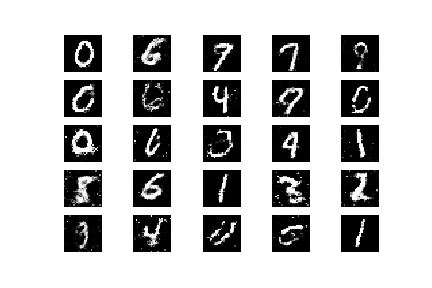

In [14]:
#通常のGAN最終画像
from IPython.display import Image, display_png
display_png(Image("images/29800.png"))

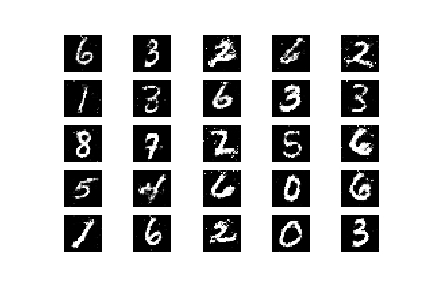

"'\nラベル情報\n[[6] [3] [2] [6] [2] [1][3] [6] [3] [3] [8] [7] [2] [5] [6] [5] [4] [6] [0] [6] [1] [6] [2] [0] [3]]\nちゃんとラベルどうり出力できている！感動しました！\n"

In [17]:
#Conditional  GANの最終画像
from IPython.display import Image, display_png
display_png(Image("images_C/29800.png"))
''''
ラベル情報
[[6] [3] [2] [6] [2] [1][3] [6] [3] [3] [8] [7] [2] [5] [6] [5] [4] [6] [0] [6] [1] [6] [2] [0] [3]]
ちゃんとラベルどうり出力できている！感動しました！
'''